In [2]:
import time
from collections import deque

import os

os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import random

import gym
import logging
from arguments import get_args
from config_init import get_config_init
from utils.storage import GlobalRolloutStorage, FIFOMemory
from utils.optimization import get_optimizer
from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
from util import AgentPositionSensor,draw_top_down_map,inverse_transform,make_train_data,RewardForwardFilter,RunningMeanStd,global_grad_norm_

#from ppo import PPO

import sys
import matplotlib

if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

In [3]:
argumnts = ''
args = get_args(argumnts)
config = get_config_init()

Auto GPU config:
Number of processes: 36
Number of processes on GPU 0: 0
Number of processes per GPU: 12


In [4]:
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
args.num_processes = 1
num_scenes = args.num_processes
num_episodes = int(args.num_episodes)
costs = deque(maxlen=1000)
exp_costs = deque(maxlen=1000)
pose_costs = deque(maxlen=1000)

In [5]:
from my_env import MyRLEnvNew

In [6]:
rank = range(args.num_processes)
dataset = PointNavDatasetV1(config.TASK_CONFIG.DATASET)
one_env = MyRLEnvNew(args=args, rank=rank, config=config, dataset=dataset)

2020-04-20 15:19:44,626 initializing sim Sim-v0
2020-04-20 15:19:48,599 Initializing task Nav-v0


In [7]:
obs, info = one_env.reset()

2020-04-20 15:19:51,749 Computing map for /data/gibson/Adrian.glb
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [8]:
# slam
nslam_module = Neural_SLAM_Module(args).to(device)
slam_optimizer = get_optimizer(nslam_module.parameters(),
                               args.slam_optimizer)
# Storage
slam_memory = FIFOMemory(args.slam_batch_size)

In [9]:
map_size = args.map_size_cm // args.map_resolution
num_scenes = 1
full_w, full_h = map_size, map_size
local_w, local_h = int(full_w / args.global_downscaling), \
                   int(full_h / args.global_downscaling)
local_map = torch.zeros(num_scenes, 4, local_w, local_h).float().to(device)
local_pose = torch.zeros(num_scenes, 3).float().to(device)
poses = torch.from_numpy(np.asarray(
    [info['sensor_pose'] for env_idx
     in range(num_scenes)])
).float().to(device)

obs_new = torch.from_numpy(np.asarray(one_env.res(obs['rgb'])).transpose(2, 0, 1)).unsqueeze(0).float().to(device)

_, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
    nslam_module(obs_new, obs_new, poses, local_map[:, 0, :, :],
                 local_map[:, 1, :, :], local_pose)

(7.235676, -1.5530449, 0.6856071308761865)
[240.0, 240.0, 0.0]


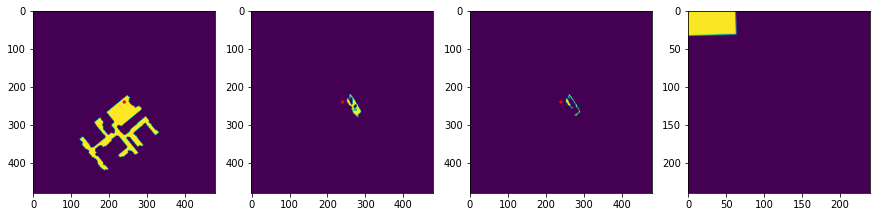

In [10]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)
circ = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[0]/10*2),3,color='red')
circ2 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[0]/10*2),3,color='red')
circ3 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[0]/10*2),3,color='red')
ax.imshow(one_env.explorable_map)
ax.add_patch(circ)
ax2.imshow(one_env.explored_map)
ax2.add_patch(circ2)
ax3.imshow(one_env.map)
ax3.add_patch(circ3)
ax4.imshow(local_map[0, 0, :, :].cpu().numpy())
print(one_env.last_sim_location)
print([one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2,one_env.mapper_gt_pose[2]])

In [ ]:
for i in range(100000):
    if i%10==0:
        strt = time.time()
        obs, info = one_env.reset()
        eend = time.time()
        print(i,'\t','TIME TO RESET: ','\t',eend-strt)
    else:
        strt = time.time()
        obs, reward, done, info = one_env.step(action=1)
        obs_new = torch.from_numpy(np.asarray(one_env.res(obs['rgb'])).transpose(2, 0, 1)).unsqueeze(0).float().to(device)
        infos = [info]
        eend = time.time()
        print(i,'\t','TIME TO STEP: ',eend-strt)

2020-04-20 15:20:01,616 Computing map for /data/gibson/Adrian.glb


0 	 TIME TO RESET:  	 5.685142517089844
1 	 TIME TO STEP:  0.0452878475189209
2 	 TIME TO STEP:  0.018576860427856445
3 	 TIME TO STEP:  0.019179344177246094
4 	 TIME TO STEP:  0.0191805362701416
5 	 TIME TO STEP:  0.0193328857421875
6 	 TIME TO STEP:  0.01890707015991211
7 	 TIME TO STEP:  0.01937413215637207
8 	 TIME TO STEP:  0.019821643829345703
9 	 TIME TO STEP:  0.019504547119140625


2020-04-20 15:20:07,485 Computing map for /data/gibson/Adrian.glb


10 	 TIME TO RESET:  	 5.627733945846558
11 	 TIME TO STEP:  0.047940731048583984
12 	 TIME TO STEP:  0.019506216049194336
13 	 TIME TO STEP:  0.019261837005615234
14 	 TIME TO STEP:  0.01933145523071289
15 	 TIME TO STEP:  0.01940131187438965
16 	 TIME TO STEP:  0.03516364097595215
17 	 TIME TO STEP:  0.019032001495361328
18 	 TIME TO STEP:  0.02042698860168457
19 	 TIME TO STEP:  0.034130096435546875


2020-04-20 15:20:13,362 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:20:18,783 Invalid map: /data/gibson/Adrian.glb/4
2020-04-20 15:20:18,996 Computing map for /data/gibson/Adrian.glb


20 	 TIME TO RESET:  	 11.29744839668274
21 	 TIME TO STEP:  0.019548892974853516
22 	 TIME TO STEP:  0.059593915939331055
23 	 TIME TO STEP:  0.03439021110534668
24 	 TIME TO STEP:  0.02800750732421875
25 	 TIME TO STEP:  0.018682479858398438
26 	 TIME TO STEP:  0.01873326301574707
27 	 TIME TO STEP:  0.01969456672668457
28 	 TIME TO STEP:  0.01999974250793457
29 	 TIME TO STEP:  0.029661893844604492


2020-04-20 15:20:24,911 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:20:30,303 Invalid map: /data/gibson/Adrian.glb/5
2020-04-20 15:20:30,520 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:20:35,915 Invalid map: /data/gibson/Adrian.glb/5
2020-04-20 15:20:36,131 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:20:41,658 Invalid map: /data/gibson/Adrian.glb/5
2020-04-20 15:20:41,896 Computing map for /data/gibson/Adrian.glb


30 	 TIME TO RESET:  	 22.682038068771362
31 	 TIME TO STEP:  0.07992267608642578
32 	 TIME TO STEP:  0.04920315742492676
33 	 TIME TO STEP:  0.05809211730957031
34 	 TIME TO STEP:  0.03375744819641113
35 	 TIME TO STEP:  0.024201393127441406
36 	 TIME TO STEP:  0.019352197647094727
37 	 TIME TO STEP:  0.047582387924194336
38 	 TIME TO STEP:  0.01916027069091797
39 	 TIME TO STEP:  0.01980757713317871


2020-04-20 15:20:47,947 Computing map for /data/gibson/Adrian.glb


40 	 TIME TO RESET:  	 5.876062870025635
41 	 TIME TO STEP:  0.033652544021606445
42 	 TIME TO STEP:  0.02045583724975586
43 	 TIME TO STEP:  0.02052164077758789
44 	 TIME TO STEP:  0.020014524459838867
45 	 TIME TO STEP:  0.020753860473632812
46 	 TIME TO STEP:  0.03579425811767578
47 	 TIME TO STEP:  0.02128911018371582
48 	 TIME TO STEP:  0.01992940902709961
49 	 TIME TO STEP:  0.021455764770507812


2020-04-20 15:20:54,040 Computing map for /data/gibson/Adrian.glb


50 	 TIME TO RESET:  	 5.816633701324463
51 	 TIME TO STEP:  0.051979780197143555
52 	 TIME TO STEP:  0.020965576171875
53 	 TIME TO STEP:  0.020871639251708984
54 	 TIME TO STEP:  0.019772052764892578
55 	 TIME TO STEP:  0.020070552825927734
56 	 TIME TO STEP:  0.020328998565673828
57 	 TIME TO STEP:  0.02005791664123535
58 	 TIME TO STEP:  0.02005934715270996


2020-04-20 15:21:00,056 Computing map for /data/gibson/Adrian.glb


59 	 TIME TO STEP:  0.022228240966796875
60 	 TIME TO RESET:  	 5.719959735870361
61 	 TIME TO STEP:  0.03261876106262207
62 	 TIME TO STEP:  0.02056145668029785
63 	 TIME TO STEP:  0.02024221420288086
64 	 TIME TO STEP:  0.03389453887939453
65 	 TIME TO STEP:  0.03647279739379883
66 	 TIME TO STEP:  0.0625302791595459
67 	 TIME TO STEP:  0.020494937896728516
68 	 TIME TO STEP:  0.05113840103149414
69 	 TIME TO STEP:  0.05298161506652832


2020-04-20 15:21:06,125 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:21:11,534 Invalid map: /data/gibson/Adrian.glb/9
2020-04-20 15:21:11,744 Computing map for /data/gibson/Adrian.glb


70 	 TIME TO RESET:  	 11.293906450271606
71 	 TIME TO STEP:  0.0228118896484375
72 	 TIME TO STEP:  0.021357059478759766
73 	 TIME TO STEP:  0.02079629898071289
74 	 TIME TO STEP:  0.020204782485961914
75 	 TIME TO STEP:  0.020142316818237305
76 	 TIME TO STEP:  0.020334243774414062
77 	 TIME TO STEP:  0.020161151885986328
78 	 TIME TO STEP:  0.020064115524291992
79 	 TIME TO STEP:  0.020325422286987305


2020-04-20 15:21:17,608 Computing map for /data/gibson/Adrian.glb


80 	 TIME TO RESET:  	 5.776385307312012
81 	 TIME TO STEP:  0.05615568161010742
82 	 TIME TO STEP:  0.07503342628479004
83 	 TIME TO STEP:  0.03680849075317383
84 	 TIME TO STEP:  0.019795656204223633
85 	 TIME TO STEP:  0.02064681053161621
86 	 TIME TO STEP:  0.02055811882019043
87 	 TIME TO STEP:  0.02001476287841797
88 	 TIME TO STEP:  0.02075028419494629
89 	 TIME TO STEP:  0.02034926414489746


2020-04-20 15:21:23,676 Computing map for /data/gibson/Adrian.glb


90 	 TIME TO RESET:  	 5.8052802085876465
91 	 TIME TO STEP:  0.06985950469970703
92 	 TIME TO STEP:  0.020968198776245117
93 	 TIME TO STEP:  0.020081043243408203
94 	 TIME TO STEP:  0.020434141159057617
95 	 TIME TO STEP:  0.02022576332092285
96 	 TIME TO STEP:  0.020224571228027344
97 	 TIME TO STEP:  0.020673036575317383
98 	 TIME TO STEP:  0.03433108329772949
99 	 TIME TO STEP:  0.03488922119140625


2020-04-20 15:21:29,743 Computing map for /data/gibson/Adrian.glb


100 	 TIME TO RESET:  	 5.748404026031494
101 	 TIME TO STEP:  0.02325749397277832
102 	 TIME TO STEP:  0.06719565391540527
103 	 TIME TO STEP:  0.020791292190551758
104 	 TIME TO STEP:  0.020371437072753906
105 	 TIME TO STEP:  0.02026963233947754
106 	 TIME TO STEP:  0.020563602447509766
107 	 TIME TO STEP:  0.02032470703125
108 	 TIME TO STEP:  0.022405147552490234
109 	 TIME TO STEP:  0.020678997039794922


2020-04-20 15:21:35,745 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:21:41,179 Invalid map: /data/gibson/Adrian.glb/13
2020-04-20 15:21:41,400 Computing map for /data/gibson/Adrian.glb


110 	 TIME TO RESET:  	 11.432425498962402
111 	 TIME TO STEP:  0.06600308418273926
112 	 TIME TO STEP:  0.05142784118652344
113 	 TIME TO STEP:  0.020486116409301758
114 	 TIME TO STEP:  0.020145654678344727
115 	 TIME TO STEP:  0.020191192626953125
116 	 TIME TO STEP:  0.020734310150146484
117 	 TIME TO STEP:  0.023221731185913086
118 	 TIME TO STEP:  0.02284836769104004
119 	 TIME TO STEP:  0.021482467651367188


2020-04-20 15:21:47,442 Computing map for /data/gibson/Adrian.glb


120 	 TIME TO RESET:  	 5.752538204193115
121 	 TIME TO STEP:  0.05382800102233887
122 	 TIME TO STEP:  0.06708049774169922
123 	 TIME TO STEP:  0.06910109519958496
124 	 TIME TO STEP:  0.05430293083190918
125 	 TIME TO STEP:  0.05405163764953613
126 	 TIME TO STEP:  0.054701805114746094
127 	 TIME TO STEP:  0.05274510383605957
128 	 TIME TO STEP:  0.0653235912322998
129 	 TIME TO STEP:  0.02010321617126465


2020-04-20 15:21:53,676 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:21:59,103 Invalid map: /data/gibson/Adrian.glb/15
2020-04-20 15:21:59,311 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:22:04,778 Invalid map: /data/gibson/Adrian.glb/15
2020-04-20 15:22:04,995 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:22:10,401 Invalid map: /data/gibson/Adrian.glb/15
2020-04-20 15:22:10,626 Computing map for /data/gibson/Adrian.glb


130 	 TIME TO RESET:  	 22.633705854415894
131 	 TIME TO STEP:  0.08205819129943848
132 	 TIME TO STEP:  0.05453777313232422
133 	 TIME TO STEP:  0.020180702209472656
134 	 TIME TO STEP:  0.02080512046813965
135 	 TIME TO STEP:  0.020641565322875977
136 	 TIME TO STEP:  0.020262479782104492
137 	 TIME TO STEP:  0.020125627517700195
138 	 TIME TO STEP:  0.020065784454345703
139 	 TIME TO STEP:  0.02086949348449707


2020-04-20 15:22:16,589 Computing map for /data/gibson/Adrian.glb


140 	 TIME TO RESET:  	 5.753215312957764
141 	 TIME TO STEP:  0.0370793342590332
142 	 TIME TO STEP:  0.019932270050048828
143 	 TIME TO STEP:  0.020166635513305664
144 	 TIME TO STEP:  0.02027726173400879
145 	 TIME TO STEP:  0.02011418342590332
146 	 TIME TO STEP:  0.02042245864868164
147 	 TIME TO STEP:  0.038979291915893555
148 	 TIME TO STEP:  0.04587841033935547
149 	 TIME TO STEP:  0.021366119384765625


2020-04-20 15:22:22,612 Computing map for /data/gibson/Adrian.glb


150 	 TIME TO RESET:  	 5.89906907081604
151 	 TIME TO STEP:  0.02484297752380371
152 	 TIME TO STEP:  0.021930932998657227
153 	 TIME TO STEP:  0.02033400535583496
154 	 TIME TO STEP:  0.02017807960510254
155 	 TIME TO STEP:  0.02039957046508789
156 	 TIME TO STEP:  0.020490646362304688
157 	 TIME TO STEP:  0.020381689071655273
158 	 TIME TO STEP:  0.020190715789794922
159 	 TIME TO STEP:  0.02097606658935547


2020-04-20 15:22:28,699 Computing map for /data/gibson/Adrian.glb


160 	 TIME TO RESET:  	 5.898068904876709
161 	 TIME TO STEP:  0.02108454704284668
162 	 TIME TO STEP:  0.020746231079101562
163 	 TIME TO STEP:  0.021137237548828125
164 	 TIME TO STEP:  0.05413556098937988
165 	 TIME TO STEP:  0.05017542839050293
166 	 TIME TO STEP:  0.03739595413208008
167 	 TIME TO STEP:  0.053069353103637695
168 	 TIME TO STEP:  0.06196904182434082
169 	 TIME TO STEP:  0.029354095458984375


2020-04-20 15:22:34,929 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:22:40,557 Invalid map: /data/gibson/Adrian.glb/19
2020-04-20 15:22:40,764 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:22:46,394 Invalid map: /data/gibson/Adrian.glb/19
2020-04-20 15:22:46,609 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:22:52,066 Invalid map: /data/gibson/Adrian.glb/19
2020-04-20 15:22:52,287 Computing map for /data/gibson/Adrian.glb


170 	 TIME TO RESET:  	 23.113388299942017
171 	 TIME TO STEP:  0.09235930442810059
172 	 TIME TO STEP:  0.03610038757324219
173 	 TIME TO STEP:  0.02133655548095703
174 	 TIME TO STEP:  0.020424604415893555
175 	 TIME TO STEP:  0.020711898803710938
176 	 TIME TO STEP:  0.021883249282836914
177 	 TIME TO STEP:  0.02130889892578125
178 	 TIME TO STEP:  0.02174091339111328
179 	 TIME TO STEP:  0.020425081253051758


2020-04-20 15:22:58,317 Computing map for /data/gibson/Adrian.glb


180 	 TIME TO RESET:  	 5.71710205078125
181 	 TIME TO STEP:  0.03822517395019531
182 	 TIME TO STEP:  0.021173715591430664
183 	 TIME TO STEP:  0.020359516143798828
184 	 TIME TO STEP:  0.020241737365722656
185 	 TIME TO STEP:  0.020120859146118164
186 	 TIME TO STEP:  0.02033376693725586
187 	 TIME TO STEP:  0.020149946212768555
188 	 TIME TO STEP:  0.020352840423583984
189 	 TIME TO STEP:  0.01995396614074707


2020-04-20 15:23:04,238 Computing map for /data/gibson/Adrian.glb


190 	 TIME TO RESET:  	 5.776017665863037
191 	 TIME TO STEP:  0.020659923553466797
192 	 TIME TO STEP:  0.021003007888793945
193 	 TIME TO STEP:  0.02035379409790039
194 	 TIME TO STEP:  0.03803610801696777
195 	 TIME TO STEP:  0.020128488540649414
196 	 TIME TO STEP:  0.04567575454711914
197 	 TIME TO STEP:  0.02030014991760254
198 	 TIME TO STEP:  0.021082162857055664
199 	 TIME TO STEP:  0.029049158096313477


2020-04-20 15:23:10,259 Computing map for /data/gibson/Adrian.glb


200 	 TIME TO RESET:  	 5.73778510093689
201 	 TIME TO STEP:  0.07150435447692871
202 	 TIME TO STEP:  0.0314333438873291
203 	 TIME TO STEP:  0.02094292640686035
204 	 TIME TO STEP:  0.020656824111938477
205 	 TIME TO STEP:  0.02001667022705078
206 	 TIME TO STEP:  0.020793676376342773
207 	 TIME TO STEP:  0.020386457443237305
208 	 TIME TO STEP:  0.020793676376342773
209 	 TIME TO STEP:  0.020522356033325195


2020-04-20 15:23:16,237 Computing map for /data/gibson/Adrian.glb


210 	 TIME TO RESET:  	 5.787220001220703
211 	 TIME TO STEP:  0.02198648452758789
212 	 TIME TO STEP:  0.029539823532104492
213 	 TIME TO STEP:  0.0297393798828125
214 	 TIME TO STEP:  0.020582914352416992
215 	 TIME TO STEP:  0.05282855033874512
216 	 TIME TO STEP:  0.038977861404418945
217 	 TIME TO STEP:  0.05838823318481445
218 	 TIME TO STEP:  0.053208351135253906
219 	 TIME TO STEP:  0.05118274688720703


2020-04-20 15:23:22,389 Computing map for /data/gibson/Adrian.glb


220 	 TIME TO RESET:  	 5.837875604629517
221 	 TIME TO STEP:  0.021033048629760742
222 	 TIME TO STEP:  0.020623445510864258
223 	 TIME TO STEP:  0.020254135131835938
224 	 TIME TO STEP:  0.037018775939941406
225 	 TIME TO STEP:  0.020524978637695312
226 	 TIME TO STEP:  0.0294189453125
227 	 TIME TO STEP:  0.020190715789794922
228 	 TIME TO STEP:  0.020390987396240234
229 	 TIME TO STEP:  0.02189183235168457


2020-04-20 15:23:28,435 Computing map for /data/gibson/Adrian.glb


230 	 TIME TO RESET:  	 5.708543539047241
231 	 TIME TO STEP:  0.028944015502929688
232 	 TIME TO STEP:  0.02029871940612793
233 	 TIME TO STEP:  0.020520448684692383
234 	 TIME TO STEP:  0.029096364974975586
235 	 TIME TO STEP:  0.0200345516204834
236 	 TIME TO STEP:  0.02004408836364746
237 	 TIME TO STEP:  0.04093289375305176
238 	 TIME TO STEP:  0.02119755744934082
239 	 TIME TO STEP:  0.02044677734375


2020-04-20 15:23:34,353 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:23:39,813 Invalid map: /data/gibson/Adrian.glb/26
2020-04-20 15:23:40,029 Computing map for /data/gibson/Adrian.glb


240 	 TIME TO RESET:  	 11.447591543197632
241 	 TIME TO STEP:  0.038217782974243164
242 	 TIME TO STEP:  0.020910263061523438
243 	 TIME TO STEP:  0.0204160213470459
244 	 TIME TO STEP:  0.020833492279052734
245 	 TIME TO STEP:  0.020403623580932617
246 	 TIME TO STEP:  0.020615816116333008
247 	 TIME TO STEP:  0.02054429054260254
248 	 TIME TO STEP:  0.021119356155395508
249 	 TIME TO STEP:  0.022211313247680664


2020-04-20 15:23:46,021 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:23:51,490 Invalid map: /data/gibson/Adrian.glb/27
2020-04-20 15:23:51,703 Computing map for /data/gibson/Adrian.glb


250 	 TIME TO RESET:  	 11.408871412277222
251 	 TIME TO STEP:  0.05917096138000488
252 	 TIME TO STEP:  0.03003525733947754
253 	 TIME TO STEP:  0.045911550521850586
254 	 TIME TO STEP:  0.020331859588623047
255 	 TIME TO STEP:  0.02014946937561035
256 	 TIME TO STEP:  0.02091240882873535
257 	 TIME TO STEP:  0.020694971084594727
258 	 TIME TO STEP:  0.0205991268157959
259 	 TIME TO STEP:  0.02034473419189453


2020-04-20 15:23:57,685 Computing map for /data/gibson/Adrian.glb


260 	 TIME TO RESET:  	 5.766019344329834
261 	 TIME TO STEP:  0.054168701171875
262 	 TIME TO STEP:  0.03460955619812012
263 	 TIME TO STEP:  0.04024815559387207
264 	 TIME TO STEP:  0.020659446716308594
265 	 TIME TO STEP:  0.03970646858215332
266 	 TIME TO STEP:  0.021088123321533203
267 	 TIME TO STEP:  0.020379304885864258
268 	 TIME TO STEP:  0.029543399810791016
269 	 TIME TO STEP:  0.020235061645507812


2020-04-20 15:24:03,736 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:24:09,316 Invalid map: /data/gibson/Adrian.glb/29
2020-04-20 15:24:09,548 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:24:15,208 Invalid map: /data/gibson/Adrian.glb/29
2020-04-20 15:24:15,443 Computing map for /data/gibson/Adrian.glb


270 	 TIME TO RESET:  	 17.523815393447876
271 	 TIME TO STEP:  0.0876009464263916
272 	 TIME TO STEP:  0.06590890884399414
273 	 TIME TO STEP:  0.05272626876831055
274 	 TIME TO STEP:  0.028013229370117188
275 	 TIME TO STEP:  0.0452728271484375
276 	 TIME TO STEP:  0.019917964935302734
277 	 TIME TO STEP:  0.019872665405273438
278 	 TIME TO STEP:  0.02000117301940918
279 	 TIME TO STEP:  0.019989967346191406


2020-04-20 15:24:21,617 Computing map for /data/gibson/Adrian.glb


280 	 TIME TO RESET:  	 5.689916610717773
281 	 TIME TO STEP:  0.029932737350463867
282 	 TIME TO STEP:  0.030125856399536133
283 	 TIME TO STEP:  0.02024698257446289
284 	 TIME TO STEP:  0.020439624786376953
285 	 TIME TO STEP:  0.01999974250793457
286 	 TIME TO STEP:  0.02056097984313965
287 	 TIME TO STEP:  0.019795656204223633
288 	 TIME TO STEP:  0.020284414291381836
289 	 TIME TO STEP:  0.029055356979370117


2020-04-20 15:24:27,520 Computing map for /data/gibson/Adrian.glb


290 	 TIME TO RESET:  	 5.909277439117432
291 	 TIME TO STEP:  0.04088282585144043
292 	 TIME TO STEP:  0.019025564193725586
293 	 TIME TO STEP:  0.046843767166137695
294 	 TIME TO STEP:  0.0459895133972168
295 	 TIME TO STEP:  0.0580904483795166
296 	 TIME TO STEP:  0.025790691375732422
297 	 TIME TO STEP:  0.019125938415527344
298 	 TIME TO STEP:  0.01904296875
299 	 TIME TO STEP:  0.019190549850463867


2020-04-20 15:24:33,707 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:24:39,231 Invalid map: /data/gibson/Adrian.glb/32
2020-04-20 15:24:39,453 Computing map for /data/gibson/Adrian.glb


300 	 TIME TO RESET:  	 11.51580262184143
301 	 TIME TO STEP:  0.04094266891479492
302 	 TIME TO STEP:  0.04571819305419922
303 	 TIME TO STEP:  0.04645991325378418
304 	 TIME TO STEP:  0.02618241310119629
305 	 TIME TO STEP:  0.0399172306060791
306 	 TIME TO STEP:  0.019917964935302734
307 	 TIME TO STEP:  0.019782304763793945
308 	 TIME TO STEP:  0.01975107192993164
309 	 TIME TO STEP:  0.019299030303955078


2020-04-20 15:24:45,519 Computing map for /data/gibson/Adrian.glb


310 	 TIME TO RESET:  	 5.730196714401245
311 	 TIME TO STEP:  0.03904366493225098
312 	 TIME TO STEP:  0.02777266502380371
313 	 TIME TO STEP:  0.05024909973144531
314 	 TIME TO STEP:  0.050394296646118164
315 	 TIME TO STEP:  0.05098605155944824
316 	 TIME TO STEP:  0.03563737869262695
317 	 TIME TO STEP:  0.020165205001831055
318 	 TIME TO STEP:  0.020031452178955078
319 	 TIME TO STEP:  0.019982099533081055


2020-04-20 15:24:51,568 Computing map for /data/gibson/Adrian.glb


320 	 TIME TO RESET:  	 5.762416839599609
321 	 TIME TO STEP:  0.05157756805419922
322 	 TIME TO STEP:  0.050336599349975586
323 	 TIME TO STEP:  0.019855499267578125
324 	 TIME TO STEP:  0.01986837387084961
325 	 TIME TO STEP:  0.01998281478881836
326 	 TIME TO STEP:  0.020036697387695312
327 	 TIME TO STEP:  0.020734548568725586
328 	 TIME TO STEP:  0.020064830780029297
329 	 TIME TO STEP:  0.01995563507080078


2020-04-20 15:24:57,580 Computing map for /data/gibson/Adrian.glb


330 	 TIME TO RESET:  	 5.671796798706055
331 	 TIME TO STEP:  0.053902387619018555
332 	 TIME TO STEP:  0.020244836807250977
333 	 TIME TO STEP:  0.020183324813842773
334 	 TIME TO STEP:  0.027921438217163086
335 	 TIME TO STEP:  0.020058631896972656
336 	 TIME TO STEP:  0.01984119415283203
337 	 TIME TO STEP:  0.020381450653076172
338 	 TIME TO STEP:  0.020312070846557617
339 	 TIME TO STEP:  0.021112680435180664


2020-04-20 15:25:03,474 Computing map for /data/gibson/Adrian.glb


340 	 TIME TO RESET:  	 5.851742744445801
341 	 TIME TO STEP:  0.06778860092163086
342 	 TIME TO STEP:  0.021742820739746094
343 	 TIME TO STEP:  0.02937769889831543
344 	 TIME TO STEP:  0.029370784759521484
345 	 TIME TO STEP:  0.020082473754882812
346 	 TIME TO STEP:  0.02029871940612793
347 	 TIME TO STEP:  0.021005630493164062
348 	 TIME TO STEP:  0.020404338836669922
349 	 TIME TO STEP:  0.02088475227355957


2020-04-20 15:25:09,574 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:25:15,144 Invalid map: /data/gibson/Adrian.glb/37
2020-04-20 15:25:15,346 Computing map for /data/gibson/Adrian.glb


350 	 TIME TO RESET:  	 11.709590911865234
351 	 TIME TO STEP:  0.05360913276672363
352 	 TIME TO STEP:  0.06602883338928223
353 	 TIME TO STEP:  0.046042680740356445
354 	 TIME TO STEP:  0.03644299507141113
355 	 TIME TO STEP:  0.04625654220581055
356 	 TIME TO STEP:  0.020579814910888672
357 	 TIME TO STEP:  0.02961897850036621
358 	 TIME TO STEP:  0.020676851272583008
359 	 TIME TO STEP:  0.020468711853027344


2020-04-20 15:25:21,640 Computing map for /data/gibson/Adrian.glb


360 	 TIME TO RESET:  	 5.9906005859375
361 	 TIME TO STEP:  0.03007364273071289
362 	 TIME TO STEP:  0.02070784568786621
363 	 TIME TO STEP:  0.0214383602142334
364 	 TIME TO STEP:  0.020560741424560547
365 	 TIME TO STEP:  0.02047872543334961
366 	 TIME TO STEP:  0.037093162536621094
367 	 TIME TO STEP:  0.020299911499023438
368 	 TIME TO STEP:  0.020225048065185547
369 	 TIME TO STEP:  0.021554231643676758


2020-04-20 15:25:27,833 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:25:33,386 Invalid map: /data/gibson/Adrian.glb/39
2020-04-20 15:25:33,603 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:25:39,017 Invalid map: /data/gibson/Adrian.glb/39
2020-04-20 15:25:39,235 Computing map for /data/gibson/Adrian.glb


370 	 TIME TO RESET:  	 17.12683653831482
371 	 TIME TO STEP:  0.09098649024963379
372 	 TIME TO STEP:  0.021410465240478516
373 	 TIME TO STEP:  0.05014824867248535
374 	 TIME TO STEP:  0.022902727127075195
375 	 TIME TO STEP:  0.03452658653259277
376 	 TIME TO STEP:  0.026373863220214844
377 	 TIME TO STEP:  0.020852327346801758
378 	 TIME TO STEP:  0.020198822021484375
379 	 TIME TO STEP:  0.022150039672851562


2020-04-20 15:25:45,275 Computing map for /data/gibson/Adrian.glb


380 	 TIME TO RESET:  	 5.898288011550903
381 	 TIME TO STEP:  0.04943561553955078
382 	 TIME TO STEP:  0.020946025848388672
383 	 TIME TO STEP:  0.0203096866607666
384 	 TIME TO STEP:  0.031647443771362305
385 	 TIME TO STEP:  0.021752357482910156
386 	 TIME TO STEP:  0.02147364616394043
387 	 TIME TO STEP:  0.021410703659057617
388 	 TIME TO STEP:  0.020585060119628906
389 	 TIME TO STEP:  0.020735502243041992


2020-04-20 15:25:51,400 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:25:56,980 Invalid map: /data/gibson/Adrian.glb/41
2020-04-20 15:25:57,200 Computing map for /data/gibson/Adrian.glb


390 	 TIME TO RESET:  	 11.631766557693481
391 	 TIME TO STEP:  0.04883146286010742
392 	 TIME TO STEP:  0.020570039749145508
393 	 TIME TO STEP:  0.020557165145874023
394 	 TIME TO STEP:  0.054166316986083984
395 	 TIME TO STEP:  0.04054403305053711
396 	 TIME TO STEP:  0.05572009086608887
397 	 TIME TO STEP:  0.03742170333862305
398 	 TIME TO STEP:  0.06697535514831543
399 	 TIME TO STEP:  0.020696163177490234


2020-04-20 15:26:03,394 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:26:08,779 Invalid map: /data/gibson/Adrian.glb/42
2020-04-20 15:26:09,002 Computing map for /data/gibson/Adrian.glb


400 	 TIME TO RESET:  	 11.43476676940918
401 	 TIME TO STEP:  0.057698726654052734
402 	 TIME TO STEP:  0.055312156677246094
403 	 TIME TO STEP:  0.05373191833496094
404 	 TIME TO STEP:  0.029444217681884766
405 	 TIME TO STEP:  0.021582841873168945
406 	 TIME TO STEP:  0.020493268966674805
407 	 TIME TO STEP:  0.0210568904876709
408 	 TIME TO STEP:  0.020928382873535156
409 	 TIME TO STEP:  0.020734071731567383


2020-04-20 15:26:15,133 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:26:20,522 Invalid map: /data/gibson/Adrian.glb/43
2020-04-20 15:26:20,723 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:26:26,174 Invalid map: /data/gibson/Adrian.glb/43
2020-04-20 15:26:26,396 Computing map for /data/gibson/Adrian.glb


410 	 TIME TO RESET:  	 17.003410577774048
411 	 TIME TO STEP:  0.07455205917358398
412 	 TIME TO STEP:  0.05609297752380371
413 	 TIME TO STEP:  0.05386233329772949
414 	 TIME TO STEP:  0.021539926528930664
415 	 TIME TO STEP:  0.022047996520996094
416 	 TIME TO STEP:  0.02037191390991211
417 	 TIME TO STEP:  0.02075338363647461
418 	 TIME TO STEP:  0.020498991012573242
419 	 TIME TO STEP:  0.02046942710876465


2020-04-20 15:26:32,445 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:26:38,035 Invalid map: /data/gibson/Adrian.glb/44
2020-04-20 15:26:38,266 Computing map for /data/gibson/Adrian.glb


420 	 TIME TO RESET:  	 11.575881958007812
421 	 TIME TO STEP:  0.023030757904052734
422 	 TIME TO STEP:  0.03820538520812988
423 	 TIME TO STEP:  0.05550050735473633
424 	 TIME TO STEP:  0.054427146911621094
425 	 TIME TO STEP:  0.03871488571166992
426 	 TIME TO STEP:  0.0663602352142334
427 	 TIME TO STEP:  0.06413531303405762
428 	 TIME TO STEP:  0.05817461013793945
429 	 TIME TO STEP:  0.021249055862426758


2020-04-20 15:26:44,445 Computing map for /data/gibson/Adrian.glb


430 	 TIME TO RESET:  	 5.717605113983154
431 	 TIME TO STEP:  0.021737337112426758
432 	 TIME TO STEP:  0.020951032638549805
433 	 TIME TO STEP:  0.020146608352661133
434 	 TIME TO STEP:  0.029282569885253906
435 	 TIME TO STEP:  0.02021479606628418
436 	 TIME TO STEP:  0.020201921463012695
437 	 TIME TO STEP:  0.020733118057250977
438 	 TIME TO STEP:  0.02021503448486328
439 	 TIME TO STEP:  0.020707130432128906


2020-04-20 15:26:50,366 Computing map for /data/gibson/Adrian.glb


440 	 TIME TO RESET:  	 5.691708564758301
441 	 TIME TO STEP:  0.0532069206237793
442 	 TIME TO STEP:  0.028299331665039062
443 	 TIME TO STEP:  0.020105361938476562
444 	 TIME TO STEP:  0.02001047134399414
445 	 TIME TO STEP:  0.019861698150634766
446 	 TIME TO STEP:  0.020262479782104492
447 	 TIME TO STEP:  0.019935131072998047
448 	 TIME TO STEP:  0.019889116287231445
449 	 TIME TO STEP:  0.020073652267456055


2020-04-20 15:26:56,270 Computing map for /data/gibson/Adrian.glb


450 	 TIME TO RESET:  	 5.68059515953064
451 	 TIME TO STEP:  0.04462718963623047
452 	 TIME TO STEP:  0.020500898361206055
453 	 TIME TO STEP:  0.020709514617919922
454 	 TIME TO STEP:  0.020334720611572266
455 	 TIME TO STEP:  0.03585100173950195
456 	 TIME TO STEP:  0.02154994010925293
457 	 TIME TO STEP:  0.020717859268188477
458 	 TIME TO STEP:  0.038123130798339844
459 	 TIME TO STEP:  0.021442651748657227


2020-04-20 15:27:02,196 Computing map for /data/gibson/Adrian.glb


460 	 TIME TO RESET:  	 5.710018873214722
461 	 TIME TO STEP:  0.05666685104370117
462 	 TIME TO STEP:  0.06685566902160645
463 	 TIME TO STEP:  0.03787875175476074
464 	 TIME TO STEP:  0.0205690860748291
465 	 TIME TO STEP:  0.02036285400390625
466 	 TIME TO STEP:  0.020390748977661133
467 	 TIME TO STEP:  0.020109176635742188
468 	 TIME TO STEP:  0.03593754768371582
469 	 TIME TO STEP:  0.019759416580200195


2020-04-20 15:27:08,214 Computing map for /data/gibson/Adrian.glb


470 	 TIME TO RESET:  	 5.895304918289185
471 	 TIME TO STEP:  0.020360469818115234
472 	 TIME TO STEP:  0.04357743263244629
473 	 TIME TO STEP:  0.01974654197692871
474 	 TIME TO STEP:  0.020233154296875
475 	 TIME TO STEP:  0.027497053146362305
476 	 TIME TO STEP:  0.01967763900756836
477 	 TIME TO STEP:  0.05014467239379883
478 	 TIME TO STEP:  0.020477771759033203
479 	 TIME TO STEP:  0.021441221237182617


2020-04-20 15:27:14,346 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:27:19,936 Invalid map: /data/gibson/Adrian.glb/50
2020-04-20 15:27:20,148 Computing map for /data/gibson/Adrian.glb


480 	 TIME TO RESET:  	 11.603078842163086
481 	 TIME TO STEP:  0.022395610809326172
482 	 TIME TO STEP:  0.06911325454711914
483 	 TIME TO STEP:  0.036324501037597656
484 	 TIME TO STEP:  0.019937753677368164
485 	 TIME TO STEP:  0.019884109497070312
486 	 TIME TO STEP:  0.03575754165649414
487 	 TIME TO STEP:  0.023934364318847656
488 	 TIME TO STEP:  0.020464181900024414
489 	 TIME TO STEP:  0.020114898681640625


2020-04-20 15:27:26,219 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:27:31,707 Invalid map: /data/gibson/Adrian.glb/51
2020-04-20 15:27:31,923 Computing map for /data/gibson/Adrian.glb


490 	 TIME TO RESET:  	 11.410969495773315
491 	 TIME TO STEP:  0.021296024322509766
492 	 TIME TO STEP:  0.020467758178710938
493 	 TIME TO STEP:  0.020596742630004883
494 	 TIME TO STEP:  0.020586729049682617
495 	 TIME TO STEP:  0.02120351791381836
496 	 TIME TO STEP:  0.021238327026367188
497 	 TIME TO STEP:  0.020696401596069336
498 	 TIME TO STEP:  0.02040696144104004
499 	 TIME TO STEP:  0.020279645919799805


2020-04-20 15:27:37,817 Computing map for /data/gibson/Adrian.glb


500 	 TIME TO RESET:  	 5.71656608581543
501 	 TIME TO STEP:  0.05747199058532715
502 	 TIME TO STEP:  0.031260013580322266
503 	 TIME TO STEP:  0.03809952735900879
504 	 TIME TO STEP:  0.0654439926147461
505 	 TIME TO STEP:  0.04372739791870117
506 	 TIME TO STEP:  0.05455613136291504
507 	 TIME TO STEP:  0.06507730484008789
508 	 TIME TO STEP:  0.08355498313903809
509 	 TIME TO STEP:  0.06907200813293457


2020-04-20 15:27:44,048 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:27:49,524 Invalid map: /data/gibson/Adrian.glb/53
2020-04-20 15:27:49,746 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:27:55,171 Invalid map: /data/gibson/Adrian.glb/53
2020-04-20 15:27:55,390 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:28:00,800 Invalid map: /data/gibson/Adrian.glb/53
2020-04-20 15:28:01,018 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:28:06,479 Invalid map: /data/gibson/Adrian.glb/53
2020-04-20 15:28:06,696 Computing map for /data/gibson/Adrian.glb


510 	 TIME TO RESET:  	 28.499043226242065
511 	 TIME TO STEP:  0.08248114585876465
512 	 TIME TO STEP:  0.03750729560852051
513 	 TIME TO STEP:  0.0507504940032959
514 	 TIME TO STEP:  0.021391868591308594
515 	 TIME TO STEP:  0.022083759307861328
516 	 TIME TO STEP:  0.020355224609375
517 	 TIME TO STEP:  0.02025771141052246
518 	 TIME TO STEP:  0.0209958553314209
519 	 TIME TO STEP:  0.020499706268310547


2020-04-20 15:28:12,833 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:28:18,269 Invalid map: /data/gibson/Adrian.glb/54
2020-04-20 15:28:18,481 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:28:23,927 Invalid map: /data/gibson/Adrian.glb/54
2020-04-20 15:28:24,161 Computing map for /data/gibson/Adrian.glb


520 	 TIME TO RESET:  	 17.026584148406982
521 	 TIME TO STEP:  0.02717280387878418
522 	 TIME TO STEP:  0.020661592483520508
523 	 TIME TO STEP:  0.05436110496520996
524 	 TIME TO STEP:  0.021332502365112305
525 	 TIME TO STEP:  0.020888328552246094
526 	 TIME TO STEP:  0.0202944278717041
527 	 TIME TO STEP:  0.0285794734954834
528 	 TIME TO STEP:  0.021497011184692383
529 	 TIME TO STEP:  0.020743131637573242


2020-04-20 15:28:30,097 Computing map for /data/gibson/Adrian.glb


530 	 TIME TO RESET:  	 5.877161026000977
531 	 TIME TO STEP:  0.045992374420166016
532 	 TIME TO STEP:  0.02920246124267578
533 	 TIME TO STEP:  0.020542621612548828
534 	 TIME TO STEP:  0.020910978317260742
535 	 TIME TO STEP:  0.020337581634521484
536 	 TIME TO STEP:  0.02028799057006836
537 	 TIME TO STEP:  0.0203855037689209
538 	 TIME TO STEP:  0.021087169647216797
539 	 TIME TO STEP:  0.02060222625732422


2020-04-20 15:28:36,213 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:28:41,783 Invalid map: /data/gibson/Adrian.glb/56
2020-04-20 15:28:41,999 Computing map for /data/gibson/Adrian.glb


540 	 TIME TO RESET:  	 11.545391082763672
541 	 TIME TO STEP:  0.07837176322937012
542 	 TIME TO STEP:  0.049865007400512695
543 	 TIME TO STEP:  0.06189560890197754
544 	 TIME TO STEP:  0.06147575378417969
545 	 TIME TO STEP:  0.08614802360534668
546 	 TIME TO STEP:  0.02241802215576172
547 	 TIME TO STEP:  0.03299546241760254
548 	 TIME TO STEP:  0.023535490036010742
549 	 TIME TO STEP:  0.02008652687072754


2020-04-20 15:28:48,190 Computing map for /data/gibson/Adrian.glb


550 	 TIME TO RESET:  	 5.851588010787964
551 	 TIME TO STEP:  0.02764105796813965
552 	 TIME TO STEP:  0.021268844604492188
553 	 TIME TO STEP:  0.02144336700439453
554 	 TIME TO STEP:  0.028285741806030273
555 	 TIME TO STEP:  0.020360231399536133
556 	 TIME TO STEP:  0.02018260955810547
557 	 TIME TO STEP:  0.02088451385498047
558 	 TIME TO STEP:  0.02061176300048828
559 	 TIME TO STEP:  0.020791292190551758


2020-04-20 15:28:54,234 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:28:59,799 Invalid map: /data/gibson/Adrian.glb/58
2020-04-20 15:29:00,015 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:29:05,643 Invalid map: /data/gibson/Adrian.glb/58
2020-04-20 15:29:05,889 Computing map for /data/gibson/Adrian.glb


560 	 TIME TO RESET:  	 17.414726495742798
561 	 TIME TO STEP:  0.06112194061279297
562 	 TIME TO STEP:  0.02200460433959961
563 	 TIME TO STEP:  0.05565381050109863
564 	 TIME TO STEP:  0.0203397274017334
565 	 TIME TO STEP:  0.02039170265197754
566 	 TIME TO STEP:  0.07779884338378906
567 	 TIME TO STEP:  0.06825566291809082
568 	 TIME TO STEP:  0.029627561569213867
569 	 TIME TO STEP:  0.05370664596557617


2020-04-20 15:29:12,069 Computing map for /data/gibson/Adrian.glb


570 	 TIME TO RESET:  	 5.830956697463989
571 	 TIME TO STEP:  0.0543217658996582
572 	 TIME TO STEP:  0.019968032836914062
573 	 TIME TO STEP:  0.020279407501220703
574 	 TIME TO STEP:  0.020638227462768555
575 	 TIME TO STEP:  0.020310401916503906
576 	 TIME TO STEP:  0.02018284797668457
577 	 TIME TO STEP:  0.02043747901916504
578 	 TIME TO STEP:  0.020241498947143555


2020-04-20 15:29:18,114 Computing map for /data/gibson/Adrian.glb


579 	 TIME TO STEP:  0.030315637588500977


2020-04-20 15:29:23,507 Invalid map: /data/gibson/Adrian.glb/60
2020-04-20 15:29:23,751 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:29:29,241 Invalid map: /data/gibson/Adrian.glb/60
2020-04-20 15:29:29,457 Computing map for /data/gibson/Adrian.glb


580 	 TIME TO RESET:  	 17.184948682785034
581 	 TIME TO STEP:  0.06218314170837402
582 	 TIME TO STEP:  0.020511150360107422
583 	 TIME TO STEP:  0.02009296417236328
584 	 TIME TO STEP:  0.020101070404052734
585 	 TIME TO STEP:  0.020186424255371094
586 	 TIME TO STEP:  0.029381275177001953
587 	 TIME TO STEP:  0.02026987075805664
588 	 TIME TO STEP:  0.021213769912719727
589 	 TIME TO STEP:  0.020453453063964844


2020-04-20 15:29:35,547 Computing map for /data/gibson/Adrian.glb


590 	 TIME TO RESET:  	 5.840670108795166
591 	 TIME TO STEP:  0.03750181198120117
592 	 TIME TO STEP:  0.037548065185546875
593 	 TIME TO STEP:  0.05371594429016113
594 	 TIME TO STEP:  0.06981062889099121
595 	 TIME TO STEP:  0.02183675765991211
596 	 TIME TO STEP:  0.020262479782104492
597 	 TIME TO STEP:  0.02045130729675293
598 	 TIME TO STEP:  0.020293474197387695
599 	 TIME TO STEP:  0.019899845123291016


2020-04-20 15:29:41,688 Computing map for /data/gibson/Adrian.glb


600 	 TIME TO RESET:  	 5.793883562088013
601 	 TIME TO STEP:  0.06644630432128906
602 	 TIME TO STEP:  0.0419926643371582
603 	 TIME TO STEP:  0.019591093063354492
604 	 TIME TO STEP:  0.019739627838134766
605 	 TIME TO STEP:  0.02045416831970215
606 	 TIME TO STEP:  0.02015209197998047
607 	 TIME TO STEP:  0.020369768142700195
608 	 TIME TO STEP:  0.020324230194091797
609 	 TIME TO STEP:  0.01984119415283203


2020-04-20 15:29:47,732 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:29:53,147 Invalid map: /data/gibson/Adrian.glb/63
2020-04-20 15:29:53,379 Computing map for /data/gibson/Adrian.glb


610 	 TIME TO RESET:  	 11.515595197677612
611 	 TIME TO STEP:  0.025626420974731445
612 	 TIME TO STEP:  0.02135634422302246
613 	 TIME TO STEP:  0.058718204498291016
614 	 TIME TO STEP:  0.023281097412109375
615 	 TIME TO STEP:  0.03757286071777344
616 	 TIME TO STEP:  0.029766321182250977
617 	 TIME TO STEP:  0.05446481704711914
618 	 TIME TO STEP:  0.028879642486572266
619 	 TIME TO STEP:  0.02027440071105957


2020-04-20 15:29:59,556 Computing map for /data/gibson/Adrian.glb


620 	 TIME TO RESET:  	 5.760344505310059
621 	 TIME TO STEP:  0.023967981338500977
622 	 TIME TO STEP:  0.06705856323242188
623 	 TIME TO STEP:  0.021201372146606445
624 	 TIME TO STEP:  0.02823185920715332
625 	 TIME TO STEP:  0.02008342742919922
626 	 TIME TO STEP:  0.030208110809326172
627 	 TIME TO STEP:  0.021811246871948242
628 	 TIME TO STEP:  0.020200014114379883
629 	 TIME TO STEP:  0.0210721492767334


2020-04-20 15:30:05,569 Computing map for /data/gibson/Adrian.glb


630 	 TIME TO RESET:  	 5.828941345214844
631 	 TIME TO STEP:  0.032036781311035156
632 	 TIME TO STEP:  0.05611133575439453
633 	 TIME TO STEP:  0.07337737083435059
634 	 TIME TO STEP:  0.02107858657836914
635 	 TIME TO STEP:  0.021602869033813477
636 	 TIME TO STEP:  0.02012014389038086
637 	 TIME TO STEP:  0.020504474639892578
638 	 TIME TO STEP:  0.02021026611328125
639 	 TIME TO STEP:  0.028328657150268555


2020-04-20 15:30:11,693 Computing map for /data/gibson/Adrian.glb


640 	 TIME TO RESET:  	 5.828888893127441
641 	 TIME TO STEP:  0.05646634101867676
642 	 TIME TO STEP:  0.05504107475280762
643 	 TIME TO STEP:  0.05348515510559082
644 	 TIME TO STEP:  0.05515742301940918
645 	 TIME TO STEP:  0.05370926856994629
646 	 TIME TO STEP:  0.0676727294921875
647 	 TIME TO STEP:  0.041625022888183594
648 	 TIME TO STEP:  0.021025896072387695
649 	 TIME TO STEP:  0.020372390747070312


2020-04-20 15:30:17,947 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:30:23,462 Invalid map: /data/gibson/Adrian.glb/67
2020-04-20 15:30:23,679 Computing map for /data/gibson/Adrian.glb


650 	 TIME TO RESET:  	 11.447578191757202
651 	 TIME TO STEP:  0.059072017669677734
652 	 TIME TO STEP:  0.021317481994628906
653 	 TIME TO STEP:  0.02062368392944336
654 	 TIME TO STEP:  0.020961999893188477
655 	 TIME TO STEP:  0.06794548034667969
656 	 TIME TO STEP:  0.06990861892700195
657 	 TIME TO STEP:  0.06013298034667969
658 	 TIME TO STEP:  0.020703554153442383
659 	 TIME TO STEP:  0.020527124404907227


2020-04-20 15:30:29,756 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:30:35,195 Invalid map: /data/gibson/Adrian.glb/68
2020-04-20 15:30:35,416 Computing map for /data/gibson/Adrian.glb


660 	 TIME TO RESET:  	 11.458692073822021
661 	 TIME TO STEP:  0.05905294418334961
662 	 TIME TO STEP:  0.028202295303344727
663 	 TIME TO STEP:  0.019842863082885742
664 	 TIME TO STEP:  0.02035665512084961
665 	 TIME TO STEP:  0.020564794540405273
666 	 TIME TO STEP:  0.02009439468383789
667 	 TIME TO STEP:  0.0360109806060791
668 	 TIME TO STEP:  0.02226734161376953
669 	 TIME TO STEP:  0.020531654357910156


2020-04-20 15:30:41,466 Computing map for /data/gibson/Adrian.glb


670 	 TIME TO RESET:  	 5.744978904724121
671 	 TIME TO STEP:  0.021041154861450195
672 	 TIME TO STEP:  0.020395517349243164
673 	 TIME TO STEP:  0.02059316635131836
674 	 TIME TO STEP:  0.020485401153564453
675 	 TIME TO STEP:  0.020714759826660156
676 	 TIME TO STEP:  0.02036142349243164
677 	 TIME TO STEP:  0.020957469940185547
678 	 TIME TO STEP:  0.03174996376037598
679 	 TIME TO STEP:  0.021408557891845703


2020-04-20 15:30:47,408 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:30:52,856 Invalid map: /data/gibson/Adrian.glb/70
2020-04-20 15:30:53,071 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:30:58,649 Invalid map: /data/gibson/Adrian.glb/70
2020-04-20 15:30:58,893 Computing map for /data/gibson/Adrian.glb


680 	 TIME TO RESET:  	 17.235249280929565
681 	 TIME TO STEP:  0.06920289993286133
682 	 TIME TO STEP:  0.0551149845123291
683 	 TIME TO STEP:  0.020331144332885742
684 	 TIME TO STEP:  0.020451784133911133
685 	 TIME TO STEP:  0.020328044891357422
686 	 TIME TO STEP:  0.021451234817504883
687 	 TIME TO STEP:  0.021859169006347656
688 	 TIME TO STEP:  0.028901100158691406
689 	 TIME TO STEP:  0.020249128341674805


2020-04-20 15:31:04,923 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:31:10,372 Invalid map: /data/gibson/Adrian.glb/71
2020-04-20 15:31:10,592 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:31:16,029 Invalid map: /data/gibson/Adrian.glb/71
2020-04-20 15:31:16,245 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:31:21,740 Invalid map: /data/gibson/Adrian.glb/71
2020-04-20 15:31:21,955 Computing map for /data/gibson/Adrian.glb


690 	 TIME TO RESET:  	 22.737910985946655
691 	 TIME TO STEP:  0.05854225158691406
692 	 TIME TO STEP:  0.03906393051147461
693 	 TIME TO STEP:  0.02767038345336914
694 	 TIME TO STEP:  0.02046799659729004
695 	 TIME TO STEP:  0.01989912986755371
696 	 TIME TO STEP:  0.020195960998535156
697 	 TIME TO STEP:  0.02075505256652832
698 	 TIME TO STEP:  0.020617961883544922
699 	 TIME TO STEP:  0.020370960235595703


2020-04-20 15:31:27,908 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:31:33,405 Invalid map: /data/gibson/Adrian.glb/72
2020-04-20 15:31:33,621 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:31:39,073 Invalid map: /data/gibson/Adrian.glb/72
2020-04-20 15:31:39,293 Computing map for /data/gibson/Adrian.glb


700 	 TIME TO RESET:  	 17.16478395462036
701 	 TIME TO STEP:  0.0852670669555664
702 	 TIME TO STEP:  0.028635740280151367
703 	 TIME TO STEP:  0.05332541465759277
704 	 TIME TO STEP:  0.02886652946472168
705 	 TIME TO STEP:  0.021313905715942383
706 	 TIME TO STEP:  0.02002406120300293
707 	 TIME TO STEP:  0.020064592361450195
708 	 TIME TO STEP:  0.020226716995239258
709 	 TIME TO STEP:  0.020610570907592773


2020-04-20 15:31:45,378 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:31:50,856 Invalid map: /data/gibson/Adrian.glb/73
2020-04-20 15:31:51,068 Computing map for /data/gibson/Adrian.glb


710 	 TIME TO RESET:  	 11.452880859375
711 	 TIME TO STEP:  0.03709244728088379
712 	 TIME TO STEP:  0.01976299285888672
713 	 TIME TO STEP:  0.02026987075805664
714 	 TIME TO STEP:  0.02002406120300293
715 	 TIME TO STEP:  0.020620107650756836
716 	 TIME TO STEP:  0.029592275619506836
717 	 TIME TO STEP:  0.019922494888305664
718 	 TIME TO STEP:  0.02031707763671875
719 	 TIME TO STEP:  0.020357608795166016


2020-04-20 15:31:57,039 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:32:02,448 Invalid map: /data/gibson/Adrian.glb/74
2020-04-20 15:32:02,665 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:32:08,222 Invalid map: /data/gibson/Adrian.glb/74
2020-04-20 15:32:08,430 Computing map for /data/gibson/Adrian.glb


720 	 TIME TO RESET:  	 17.21806573867798
721 	 TIME TO STEP:  0.07675719261169434
722 	 TIME TO STEP:  0.05381131172180176
723 	 TIME TO STEP:  0.0673985481262207
724 	 TIME TO STEP:  0.06923365592956543
725 	 TIME TO STEP:  0.019893646240234375
726 	 TIME TO STEP:  0.03633236885070801
727 	 TIME TO STEP:  0.0283353328704834
728 	 TIME TO STEP:  0.019652843475341797
729 	 TIME TO STEP:  0.019884347915649414


2020-04-20 15:32:14,692 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:32:20,371 Invalid map: /data/gibson/Adrian.glb/75
2020-04-20 15:32:20,584 Computing map for /data/gibson/Adrian.glb


730 	 TIME TO RESET:  	 11.6619713306427
731 	 TIME TO STEP:  0.05475187301635742
732 	 TIME TO STEP:  0.02018880844116211
733 	 TIME TO STEP:  0.02043914794921875
734 	 TIME TO STEP:  0.02100396156311035
735 	 TIME TO STEP:  0.020301342010498047
736 	 TIME TO STEP:  0.02068352699279785
737 	 TIME TO STEP:  0.02065277099609375
738 	 TIME TO STEP:  0.020346641540527344


2020-04-20 15:32:26,520 Computing map for /data/gibson/Adrian.glb


739 	 TIME TO STEP:  0.021974802017211914
740 	 TIME TO RESET:  	 5.794158458709717
741 	 TIME TO STEP:  0.05771660804748535
742 	 TIME TO STEP:  0.05459403991699219
743 	 TIME TO STEP:  0.05307126045227051
744 	 TIME TO STEP:  0.07735300064086914
745 	 TIME TO STEP:  0.08839702606201172
746 	 TIME TO STEP:  0.05012822151184082
747 	 TIME TO STEP:  0.01935124397277832
748 	 TIME TO STEP:  0.04865694046020508
749 	 TIME TO STEP:  0.048303842544555664


2020-04-20 15:32:32,818 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:32:38,470 Invalid map: /data/gibson/Adrian.glb/77
2020-04-20 15:32:38,694 Computing map for /data/gibson/Adrian.glb


750 	 TIME TO RESET:  	 11.744212865829468
751 	 TIME TO STEP:  0.04642367362976074
752 	 TIME TO STEP:  0.021109580993652344
753 	 TIME TO STEP:  0.02077627182006836
754 	 TIME TO STEP:  0.020579814910888672
755 	 TIME TO STEP:  0.020818710327148438
756 	 TIME TO STEP:  0.04752182960510254
757 	 TIME TO STEP:  0.05267596244812012
758 	 TIME TO STEP:  0.02007460594177246
759 	 TIME TO STEP:  0.020002365112304688


2020-04-20 15:32:44,838 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:32:50,345 Invalid map: /data/gibson/Adrian.glb/78
2020-04-20 15:32:50,560 Computing map for /data/gibson/Adrian.glb


760 	 TIME TO RESET:  	 11.671991348266602
761 	 TIME TO STEP:  0.05450582504272461
762 	 TIME TO STEP:  0.043636322021484375
763 	 TIME TO STEP:  0.052561283111572266
764 	 TIME TO STEP:  0.0671088695526123
765 	 TIME TO STEP:  0.05056333541870117
766 	 TIME TO STEP:  0.020198822021484375
767 	 TIME TO STEP:  0.021858930587768555
768 	 TIME TO STEP:  0.020476102828979492
769 	 TIME TO STEP:  0.02031564712524414


2020-04-20 15:32:56,866 Computing map for /data/gibson/Adrian.glb


770 	 TIME TO RESET:  	 5.843842506408691
771 	 TIME TO STEP:  0.055431365966796875
772 	 TIME TO STEP:  0.020530223846435547
773 	 TIME TO STEP:  0.01957845687866211
774 	 TIME TO STEP:  0.02108621597290039
775 	 TIME TO STEP:  0.020340919494628906
776 	 TIME TO STEP:  0.0202939510345459
777 	 TIME TO STEP:  0.019852399826049805
778 	 TIME TO STEP:  0.020320892333984375
779 	 TIME TO STEP:  0.022687435150146484


2020-04-20 15:33:02,929 Computing map for /data/gibson/Adrian.glb


780 	 TIME TO RESET:  	 5.8288254737854
781 	 TIME TO STEP:  0.054913997650146484
782 	 TIME TO STEP:  0.05113625526428223
783 	 TIME TO STEP:  0.04507780075073242
784 	 TIME TO STEP:  0.020555734634399414
785 	 TIME TO STEP:  0.020524263381958008
786 	 TIME TO STEP:  0.055318593978881836
787 	 TIME TO STEP:  0.06732678413391113
788 	 TIME TO STEP:  0.05276894569396973
789 	 TIME TO STEP:  0.035356760025024414


2020-04-20 15:33:09,176 Computing map for /data/gibson/Adrian.glb


790 	 TIME TO RESET:  	 5.855859756469727
791 	 TIME TO STEP:  0.039469003677368164
792 	 TIME TO STEP:  0.01970076560974121
793 	 TIME TO STEP:  0.05288410186767578
794 	 TIME TO STEP:  0.060918331146240234
795 	 TIME TO STEP:  0.026642560958862305
796 	 TIME TO STEP:  0.027893781661987305
797 	 TIME TO STEP:  0.0371861457824707
798 	 TIME TO STEP:  0.026236295700073242
799 	 TIME TO STEP:  0.03630352020263672


2020-04-20 15:33:15,359 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:33:20,973 Invalid map: /data/gibson/Adrian.glb/82
2020-04-20 15:33:21,196 Computing map for /data/gibson/Adrian.glb


800 	 TIME TO RESET:  	 11.61010456085205
801 	 TIME TO STEP:  0.054856061935424805
802 	 TIME TO STEP:  0.045438528060913086
803 	 TIME TO STEP:  0.02065563201904297
804 	 TIME TO STEP:  0.020874738693237305
805 	 TIME TO STEP:  0.020137310028076172
806 	 TIME TO STEP:  0.020233631134033203
807 	 TIME TO STEP:  0.02026677131652832
808 	 TIME TO STEP:  0.021813154220581055
809 	 TIME TO STEP:  0.02068805694580078


2020-04-20 15:33:27,223 Computing map for /data/gibson/Adrian.glb


810 	 TIME TO RESET:  	 5.7975075244903564
811 	 TIME TO STEP:  0.02156662940979004
812 	 TIME TO STEP:  0.021446943283081055
813 	 TIME TO STEP:  0.04168415069580078
814 	 TIME TO STEP:  0.021859169006347656
815 	 TIME TO STEP:  0.037116050720214844
816 	 TIME TO STEP:  0.020287752151489258
817 	 TIME TO STEP:  0.020208120346069336
818 	 TIME TO STEP:  0.0341641902923584
819 	 TIME TO STEP:  0.02129220962524414


2020-04-20 15:33:33,287 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:33:38,753 Invalid map: /data/gibson/Adrian.glb/84
2020-04-20 15:33:38,975 Computing map for /data/gibson/Adrian.glb


820 	 TIME TO RESET:  	 11.504068374633789
821 	 TIME TO STEP:  0.056970834732055664
822 	 TIME TO STEP:  0.021356582641601562
823 	 TIME TO STEP:  0.0204925537109375
824 	 TIME TO STEP:  0.020798921585083008
825 	 TIME TO STEP:  0.020855426788330078
826 	 TIME TO STEP:  0.028449296951293945
827 	 TIME TO STEP:  0.021007299423217773
828 	 TIME TO STEP:  0.02092766761779785
829 	 TIME TO STEP:  0.02033090591430664


2020-04-20 15:33:45,001 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:33:50,580 Invalid map: /data/gibson/Adrian.glb/85
2020-04-20 15:33:50,796 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:33:56,333 Invalid map: /data/gibson/Adrian.glb/85
2020-04-20 15:33:56,549 Computing map for /data/gibson/Adrian.glb


830 	 TIME TO RESET:  	 17.327606678009033
831 	 TIME TO STEP:  0.04622197151184082
832 	 TIME TO STEP:  0.021399259567260742
833 	 TIME TO STEP:  0.020289897918701172
834 	 TIME TO STEP:  0.01970076560974121
835 	 TIME TO STEP:  0.019879579544067383
836 	 TIME TO STEP:  0.020531654357910156
837 	 TIME TO STEP:  0.02034735679626465
838 	 TIME TO STEP:  0.020234346389770508
839 	 TIME TO STEP:  0.021663904190063477


2020-04-20 15:34:02,522 Computing map for /data/gibson/Adrian.glb


840 	 TIME TO RESET:  	 5.702991485595703
841 	 TIME TO STEP:  0.054876089096069336
842 	 TIME TO STEP:  0.020165443420410156
843 	 TIME TO STEP:  0.02000713348388672
844 	 TIME TO STEP:  0.01998615264892578
845 	 TIME TO STEP:  0.020343303680419922
846 	 TIME TO STEP:  0.02035832405090332
847 	 TIME TO STEP:  0.02006077766418457
848 	 TIME TO STEP:  0.020628690719604492
849 	 TIME TO STEP:  0.02043628692626953


2020-04-20 15:34:08,445 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:34:13,905 Invalid map: /data/gibson/Adrian.glb/87
2020-04-20 15:34:14,121 Computing map for /data/gibson/Adrian.glb


850 	 TIME TO RESET:  	 11.356454372406006
851 	 TIME TO STEP:  0.046457767486572266
852 	 TIME TO STEP:  0.020453929901123047
853 	 TIME TO STEP:  0.028843402862548828
854 	 TIME TO STEP:  0.020142078399658203
855 	 TIME TO STEP:  0.02027583122253418
856 	 TIME TO STEP:  0.02052760124206543
857 	 TIME TO STEP:  0.02948904037475586
858 	 TIME TO STEP:  0.06328511238098145
859 	 TIME TO STEP:  0.04628777503967285


2020-04-20 15:34:20,113 Computing map for /data/gibson/Adrian.glb


860 	 TIME TO RESET:  	 5.769184112548828
861 	 TIME TO STEP:  0.04752230644226074
862 	 TIME TO STEP:  0.053700923919677734
863 	 TIME TO STEP:  0.028270721435546875
864 	 TIME TO STEP:  0.020234346389770508
865 	 TIME TO STEP:  0.02910757064819336
866 	 TIME TO STEP:  0.020034313201904297
867 	 TIME TO STEP:  0.03768730163574219
868 	 TIME TO STEP:  0.02021050453186035
869 	 TIME TO STEP:  0.02064037322998047


2020-04-20 15:34:26,162 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:34:31,598 Invalid map: /data/gibson/Adrian.glb/89
2020-04-20 15:34:31,818 Computing map for /data/gibson/Adrian.glb


870 	 TIME TO RESET:  	 11.457757234573364
871 	 TIME TO STEP:  0.055176496505737305
872 	 TIME TO STEP:  0.02903580665588379
873 	 TIME TO STEP:  0.021040916442871094
874 	 TIME TO STEP:  0.020120620727539062
875 	 TIME TO STEP:  0.020677566528320312
876 	 TIME TO STEP:  0.02017688751220703
877 	 TIME TO STEP:  0.020492076873779297
878 	 TIME TO STEP:  0.02015972137451172
879 	 TIME TO STEP:  0.02098369598388672


2020-04-20 15:34:37,834 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:34:43,351 Invalid map: /data/gibson/Adrian.glb/90
2020-04-20 15:34:43,574 Computing map for /data/gibson/Adrian.glb


880 	 TIME TO RESET:  	 11.469522714614868
881 	 TIME TO STEP:  0.05245828628540039
882 	 TIME TO STEP:  0.03977203369140625
883 	 TIME TO STEP:  0.035604000091552734
884 	 TIME TO STEP:  0.020065784454345703
885 	 TIME TO STEP:  0.050417184829711914
886 	 TIME TO STEP:  0.0525052547454834
887 	 TIME TO STEP:  0.0200040340423584
888 	 TIME TO STEP:  0.019628286361694336
889 	 TIME TO STEP:  0.020146608352661133


2020-04-20 15:34:49,614 Computing map for /data/gibson/Adrian.glb


890 	 TIME TO RESET:  	 5.890823602676392
891 	 TIME TO STEP:  0.04327702522277832
892 	 TIME TO STEP:  0.02798628807067871
893 	 TIME TO STEP:  0.027982711791992188
894 	 TIME TO STEP:  0.019644498825073242
895 	 TIME TO STEP:  0.019823551177978516
896 	 TIME TO STEP:  0.027367830276489258
897 	 TIME TO STEP:  0.06804108619689941
898 	 TIME TO STEP:  0.04018139839172363
899 	 TIME TO STEP:  0.08815383911132812


2020-04-20 15:34:55,869 Computing map for /data/gibson/Adrian.glb


900 	 TIME TO RESET:  	 5.6765642166137695
901 	 TIME TO STEP:  0.0302274227142334
902 	 TIME TO STEP:  0.0289306640625
903 	 TIME TO STEP:  0.05246305465698242
904 	 TIME TO STEP:  0.0521540641784668
905 	 TIME TO STEP:  0.05362725257873535
906 	 TIME TO STEP:  0.0198516845703125
907 	 TIME TO STEP:  0.0203096866607666
908 	 TIME TO STEP:  0.01999950408935547
909 	 TIME TO STEP:  0.02046823501586914


2020-04-20 15:35:01,846 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:35:07,251 Invalid map: /data/gibson/Adrian.glb/93
2020-04-20 15:35:07,470 Computing map for /data/gibson/Adrian.glb


910 	 TIME TO RESET:  	 11.443177700042725
911 	 TIME TO STEP:  0.06969475746154785
912 	 TIME TO STEP:  0.020866870880126953
913 	 TIME TO STEP:  0.020464420318603516
914 	 TIME TO STEP:  0.020976781845092773
915 	 TIME TO STEP:  0.02104806900024414
916 	 TIME TO STEP:  0.020826339721679688
917 	 TIME TO STEP:  0.02104663848876953
918 	 TIME TO STEP:  0.021811723709106445
919 	 TIME TO STEP:  0.02079010009765625


2020-04-20 15:35:13,524 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:35:19,020 Invalid map: /data/gibson/Adrian.glb/94
2020-04-20 15:35:19,231 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:35:24,752 Invalid map: /data/gibson/Adrian.glb/94
2020-04-20 15:35:24,968 Computing map for /data/gibson/Adrian.glb


920 	 TIME TO RESET:  	 17.20802927017212
921 	 TIME TO STEP:  0.07974648475646973
922 	 TIME TO STEP:  0.05548357963562012
923 	 TIME TO STEP:  0.020917654037475586
924 	 TIME TO STEP:  0.02102804183959961
925 	 TIME TO STEP:  0.020986557006835938
926 	 TIME TO STEP:  0.020843505859375
927 	 TIME TO STEP:  0.020496129989624023
928 	 TIME TO STEP:  0.021330833435058594
929 	 TIME TO STEP:  0.02086925506591797


2020-04-20 15:35:31,018 Computing map for /data/gibson/Adrian.glb


930 	 TIME TO RESET:  	 5.744664192199707
931 	 TIME TO STEP:  0.047358036041259766
932 	 TIME TO STEP:  0.08196067810058594
933 	 TIME TO STEP:  0.0668795108795166
934 	 TIME TO STEP:  0.05068039894104004
935 	 TIME TO STEP:  0.05097627639770508
936 	 TIME TO STEP:  0.037982940673828125
937 	 TIME TO STEP:  0.04264402389526367
938 	 TIME TO STEP:  0.059960365295410156


2020-04-20 15:35:37,207 Computing map for /data/gibson/Adrian.glb


939 	 TIME TO STEP:  0.021442413330078125


2020-04-20 15:35:42,624 Invalid map: /data/gibson/Adrian.glb/96
2020-04-20 15:35:42,840 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:35:48,412 Invalid map: /data/gibson/Adrian.glb/96
2020-04-20 15:35:48,630 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:35:54,142 Invalid map: /data/gibson/Adrian.glb/96
2020-04-20 15:35:54,364 Computing map for /data/gibson/Adrian.glb


940 	 TIME TO RESET:  	 22.895319938659668
941 	 TIME TO STEP:  0.04704713821411133
942 	 TIME TO STEP:  0.052048444747924805
943 	 TIME TO STEP:  0.044545888900756836
944 	 TIME TO STEP:  0.02008652687072754
945 	 TIME TO STEP:  0.028850555419921875
946 	 TIME TO STEP:  0.022068262100219727
947 	 TIME TO STEP:  0.020693063735961914
948 	 TIME TO STEP:  0.02020549774169922
949 	 TIME TO STEP:  0.020025253295898438


2020-04-20 15:36:00,397 Computing map for /data/gibson/Adrian.glb


950 	 TIME TO RESET:  	 5.787134885787964
951 	 TIME TO STEP:  0.0452876091003418
952 	 TIME TO STEP:  0.04554581642150879
953 	 TIME TO STEP:  0.06459164619445801
954 	 TIME TO STEP:  0.053965091705322266
955 	 TIME TO STEP:  0.053436279296875
956 	 TIME TO STEP:  0.05306506156921387
957 	 TIME TO STEP:  0.05294036865234375
958 	 TIME TO STEP:  0.037346601486206055
959 	 TIME TO STEP:  0.07020163536071777


2020-04-20 15:36:06,693 Computing map for /data/gibson/Adrian.glb


960 	 TIME TO RESET:  	 5.772274732589722
961 	 TIME TO STEP:  0.020982742309570312
962 	 TIME TO STEP:  0.020012378692626953
963 	 TIME TO STEP:  0.020266294479370117
964 	 TIME TO STEP:  0.020030498504638672
965 	 TIME TO STEP:  0.019913911819458008
966 	 TIME TO STEP:  0.020357370376586914
967 	 TIME TO STEP:  0.01974773406982422
968 	 TIME TO STEP:  0.020235300064086914
969 	 TIME TO STEP:  0.020096540451049805


2020-04-20 15:36:12,619 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:36:18,036 Invalid map: /data/gibson/Adrian.glb/99
2020-04-20 15:36:18,253 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:36:23,687 Invalid map: /data/gibson/Adrian.glb/99
2020-04-20 15:36:23,903 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:36:29,388 Invalid map: /data/gibson/Adrian.glb/99
2020-04-20 15:36:29,611 Computing map for /data/gibson/Adrian.glb


970 	 TIME TO RESET:  	 22.733768939971924
971 	 TIME TO STEP:  0.08295178413391113
972 	 TIME TO STEP:  0.02205038070678711
973 	 TIME TO STEP:  0.05497336387634277
974 	 TIME TO STEP:  0.03129315376281738
975 	 TIME TO STEP:  0.022404193878173828
976 	 TIME TO STEP:  0.02045917510986328
977 	 TIME TO STEP:  0.020151376724243164
978 	 TIME TO STEP:  0.02061009407043457
979 	 TIME TO STEP:  0.020834684371948242


2020-04-20 15:36:35,647 Computing map for /data/gibson/Adrian.glb


980 	 TIME TO RESET:  	 5.807506084442139
981 	 TIME TO STEP:  0.05034780502319336
982 	 TIME TO STEP:  0.05290651321411133
983 	 TIME TO STEP:  0.05442190170288086
984 	 TIME TO STEP:  0.05620932579040527
985 	 TIME TO STEP:  0.053848981857299805
986 	 TIME TO STEP:  0.06395244598388672
987 	 TIME TO STEP:  0.020177841186523438
988 	 TIME TO STEP:  0.020101070404052734
989 	 TIME TO STEP:  0.0205230712890625


2020-04-20 15:36:41,850 Computing map for /data/gibson/Adrian.glb


990 	 TIME TO RESET:  	 5.7864601612091064
991 	 TIME TO STEP:  0.056543827056884766
992 	 TIME TO STEP:  0.06009554862976074
993 	 TIME TO STEP:  0.05775642395019531
994 	 TIME TO STEP:  0.0550694465637207
995 	 TIME TO STEP:  0.08594942092895508
996 	 TIME TO STEP:  0.025875329971313477
997 	 TIME TO STEP:  0.04730033874511719
998 	 TIME TO STEP:  0.040306806564331055
999 	 TIME TO STEP:  0.043067216873168945


2020-04-20 15:36:48,124 Computing map for /data/gibson/Adrian.glb


1000 	 TIME TO RESET:  	 5.769545555114746
1001 	 TIME TO STEP:  0.032530784606933594
1002 	 TIME TO STEP:  0.06735038757324219
1003 	 TIME TO STEP:  0.03814387321472168
1004 	 TIME TO STEP:  0.020044803619384766
1005 	 TIME TO STEP:  0.02025151252746582
1006 	 TIME TO STEP:  0.020514965057373047
1007 	 TIME TO STEP:  0.020488262176513672
1008 	 TIME TO STEP:  0.020154476165771484
1009 	 TIME TO STEP:  0.05086970329284668


2020-04-20 15:36:54,174 Computing map for /data/gibson/Adrian.glb


1010 	 TIME TO RESET:  	 5.719054937362671
1011 	 TIME TO STEP:  0.033847808837890625
1012 	 TIME TO STEP:  0.0206758975982666
1013 	 TIME TO STEP:  0.0277254581451416
1014 	 TIME TO STEP:  0.0363306999206543
1015 	 TIME TO STEP:  0.019606828689575195
1016 	 TIME TO STEP:  0.020407915115356445
1017 	 TIME TO STEP:  0.020344972610473633
1018 	 TIME TO STEP:  0.03631925582885742
1019 	 TIME TO STEP:  0.02754998207092285


2020-04-20 15:37:00,139 Computing map for /data/gibson/Adrian.glb


1020 	 TIME TO RESET:  	 5.706161975860596
1021 	 TIME TO STEP:  0.05168867111206055
1022 	 TIME TO STEP:  0.019873857498168945
1023 	 TIME TO STEP:  0.019825458526611328
1024 	 TIME TO STEP:  0.05709385871887207
1025 	 TIME TO STEP:  0.04475903511047363
1026 	 TIME TO STEP:  0.02249932289123535
1027 	 TIME TO STEP:  0.02059769630432129
1028 	 TIME TO STEP:  0.03582906723022461
1029 	 TIME TO STEP:  0.02000284194946289


2020-04-20 15:37:06,157 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:37:11,787 Invalid map: /data/gibson/Adrian.glb/105
2020-04-20 15:37:12,010 Computing map for /data/gibson/Adrian.glb


1030 	 TIME TO RESET:  	 11.650700807571411
1031 	 TIME TO STEP:  0.03237628936767578
1032 	 TIME TO STEP:  0.02094554901123047
1033 	 TIME TO STEP:  0.02050042152404785
1034 	 TIME TO STEP:  0.020841598510742188
1035 	 TIME TO STEP:  0.02074122428894043
1036 	 TIME TO STEP:  0.020470142364501953
1037 	 TIME TO STEP:  0.020509958267211914
1038 	 TIME TO STEP:  0.02036762237548828
1039 	 TIME TO STEP:  0.01982593536376953


2020-04-20 15:37:17,969 Computing map for /data/gibson/Adrian.glb


1040 	 TIME TO RESET:  	 5.718031167984009
1041 	 TIME TO STEP:  0.05626487731933594
1042 	 TIME TO STEP:  0.04805469512939453
1043 	 TIME TO STEP:  0.020810842514038086
1044 	 TIME TO STEP:  0.020174026489257812
1045 	 TIME TO STEP:  0.028989076614379883
1046 	 TIME TO STEP:  0.019699811935424805
1047 	 TIME TO STEP:  0.022185087203979492
1048 	 TIME TO STEP:  0.02032303810119629
1049 	 TIME TO STEP:  0.02071404457092285


2020-04-20 15:37:23,962 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:37:29,419 Invalid map: /data/gibson/Adrian.glb/107
2020-04-20 15:37:29,649 Computing map for /data/gibson/Adrian.glb


1050 	 TIME TO RESET:  	 11.44826340675354
1051 	 TIME TO STEP:  0.02113938331604004
1052 	 TIME TO STEP:  0.028786659240722656
1053 	 TIME TO STEP:  0.020693302154541016
1054 	 TIME TO STEP:  0.028839826583862305
1055 	 TIME TO STEP:  0.02017378807067871
1056 	 TIME TO STEP:  0.054662227630615234
1057 	 TIME TO STEP:  0.0576481819152832
1058 	 TIME TO STEP:  0.02032327651977539
1059 	 TIME TO STEP:  0.020553112030029297


2020-04-20 15:37:35,699 Computing map for /data/gibson/Adrian.glb


1060 	 TIME TO RESET:  	 5.824282169342041
1061 	 TIME TO STEP:  0.021342992782592773
1062 	 TIME TO STEP:  0.06844377517700195
1063 	 TIME TO STEP:  0.019948720932006836
1064 	 TIME TO STEP:  0.04300856590270996
1065 	 TIME TO STEP:  0.0504603385925293
1066 	 TIME TO STEP:  0.052498579025268555
1067 	 TIME TO STEP:  0.027961254119873047
1068 	 TIME TO STEP:  0.02896428108215332
1069 	 TIME TO STEP:  0.01980304718017578


2020-04-20 15:37:41,849 Computing map for /data/gibson/Adrian.glb


1070 	 TIME TO RESET:  	 5.74275279045105
1071 	 TIME TO STEP:  0.06463813781738281
1072 	 TIME TO STEP:  0.04605984687805176
1073 	 TIME TO STEP:  0.019938230514526367
1074 	 TIME TO STEP:  0.020255565643310547
1075 	 TIME TO STEP:  0.020334243774414062
1076 	 TIME TO STEP:  0.020188331604003906
1077 	 TIME TO STEP:  0.021656513214111328
1078 	 TIME TO STEP:  0.0202329158782959
1079 	 TIME TO STEP:  0.020146608352661133


2020-04-20 15:37:47,840 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:37:53,310 Invalid map: /data/gibson/Adrian.glb/110
2020-04-20 15:37:53,526 Computing map for /data/gibson/Adrian.glb


1080 	 TIME TO RESET:  	 11.48929500579834
1081 	 TIME TO STEP:  0.04545116424560547
1082 	 TIME TO STEP:  0.03650975227355957
1083 	 TIME TO STEP:  0.03590583801269531
1084 	 TIME TO STEP:  0.02019333839416504
1085 	 TIME TO STEP:  0.020143508911132812
1086 	 TIME TO STEP:  0.02036309242248535
1087 	 TIME TO STEP:  0.0204160213470459
1088 	 TIME TO STEP:  0.020514726638793945
1089 	 TIME TO STEP:  0.020021438598632812


2020-04-20 15:37:59,571 Computing map for /data/gibson/Adrian.glb


1090 	 TIME TO RESET:  	 5.793880939483643
1091 	 TIME TO STEP:  0.05306386947631836
1092 	 TIME TO STEP:  0.06341409683227539
1093 	 TIME TO STEP:  0.05331230163574219
1094 	 TIME TO STEP:  0.05765080451965332
1095 	 TIME TO STEP:  0.06910014152526855
1096 	 TIME TO STEP:  0.06170535087585449
1097 	 TIME TO STEP:  0.05370664596557617
1098 	 TIME TO STEP:  0.054628610610961914
1099 	 TIME TO STEP:  0.0284426212310791


2020-04-20 15:38:05,860 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:38:11,407 Invalid map: /data/gibson/Adrian.glb/112
2020-04-20 15:38:11,620 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:38:17,110 Invalid map: /data/gibson/Adrian.glb/112
2020-04-20 15:38:17,333 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:38:22,737 Invalid map: /data/gibson/Adrian.glb/112
2020-04-20 15:38:22,973 Computing map for /data/gibson/Adrian.glb


1100 	 TIME TO RESET:  	 22.789244174957275
1101 	 TIME TO STEP:  0.08155417442321777
1102 	 TIME TO STEP:  0.07029461860656738
1103 	 TIME TO STEP:  0.05322456359863281
1104 	 TIME TO STEP:  0.05556368827819824
1105 	 TIME TO STEP:  0.05440187454223633
1106 	 TIME TO STEP:  0.047096967697143555
1107 	 TIME TO STEP:  0.027915000915527344
1108 	 TIME TO STEP:  0.02029871940612793
1109 	 TIME TO STEP:  0.02047109603881836


2020-04-20 15:38:29,083 Computing map for /data/gibson/Adrian.glb


1110 	 TIME TO RESET:  	 5.732814073562622
1111 	 TIME TO STEP:  0.03123617172241211
1112 	 TIME TO STEP:  0.019919157028198242
1113 	 TIME TO STEP:  0.01978158950805664
1114 	 TIME TO STEP:  0.020082712173461914
1115 	 TIME TO STEP:  0.020204782485961914
1116 	 TIME TO STEP:  0.02030348777770996
1117 	 TIME TO STEP:  0.01996755599975586
1118 	 TIME TO STEP:  0.020661354064941406
1119 	 TIME TO STEP:  0.019942283630371094


2020-04-20 15:38:35,004 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:38:40,418 Invalid map: /data/gibson/Adrian.glb/114
2020-04-20 15:38:40,645 Computing map for /data/gibson/Adrian.glb


1120 	 TIME TO RESET:  	 11.338188409805298
1121 	 TIME TO STEP:  0.0205533504486084
1122 	 TIME TO STEP:  0.05369734764099121
1123 	 TIME TO STEP:  0.020012617111206055
1124 	 TIME TO STEP:  0.020788192749023438
1125 	 TIME TO STEP:  0.02032017707824707
1126 	 TIME TO STEP:  0.030918121337890625
1127 	 TIME TO STEP:  0.0204465389251709
1128 	 TIME TO STEP:  0.02279829978942871
1129 	 TIME TO STEP:  0.020321130752563477


2020-04-20 15:38:46,600 Computing map for /data/gibson/Adrian.glb


1130 	 TIME TO RESET:  	 5.822877645492554
1131 	 TIME TO STEP:  0.04658937454223633
1132 	 TIME TO STEP:  0.029239892959594727
1133 	 TIME TO STEP:  0.020357131958007812
1134 	 TIME TO STEP:  0.020754337310791016
1135 	 TIME TO STEP:  0.02034783363342285
1136 	 TIME TO STEP:  0.028829336166381836
1137 	 TIME TO STEP:  0.05435943603515625
1138 	 TIME TO STEP:  0.05628466606140137
1139 	 TIME TO STEP:  0.020722150802612305


2020-04-20 15:38:52,703 Computing map for /data/gibson/Adrian.glb


1140 	 TIME TO RESET:  	 5.794061183929443
1141 	 TIME TO STEP:  0.02221989631652832
1142 	 TIME TO STEP:  0.055672645568847656
1143 	 TIME TO STEP:  0.019797325134277344
1144 	 TIME TO STEP:  0.020247697830200195
1145 	 TIME TO STEP:  0.028002023696899414
1146 	 TIME TO STEP:  0.045883893966674805
1147 	 TIME TO STEP:  0.022222280502319336
1148 	 TIME TO STEP:  0.021164894104003906
1149 	 TIME TO STEP:  0.02153944969177246


2020-04-20 15:38:58,758 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:39:04,299 Invalid map: /data/gibson/Adrian.glb/117
2020-04-20 15:39:04,521 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:39:10,035 Invalid map: /data/gibson/Adrian.glb/117
2020-04-20 15:39:10,237 Computing map for /data/gibson/Adrian.glb


1150 	 TIME TO RESET:  	 17.33418035507202
1151 	 TIME TO STEP:  0.06797671318054199
1152 	 TIME TO STEP:  0.029227495193481445
1153 	 TIME TO STEP:  0.020600080490112305
1154 	 TIME TO STEP:  0.02885603904724121
1155 	 TIME TO STEP:  0.038190603256225586
1156 	 TIME TO STEP:  0.02108931541442871
1157 	 TIME TO STEP:  0.02044367790222168
1158 	 TIME TO STEP:  0.02054119110107422
1159 	 TIME TO STEP:  0.021179914474487305


2020-04-20 15:39:16,341 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:39:21,803 Invalid map: /data/gibson/Adrian.glb/118
2020-04-20 15:39:22,025 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:39:27,477 Invalid map: /data/gibson/Adrian.glb/118
2020-04-20 15:39:27,696 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:39:33,291 Invalid map: /data/gibson/Adrian.glb/118
2020-04-20 15:39:33,508 Computing map for /data/gibson/Adrian.glb


1160 	 TIME TO RESET:  	 22.915186882019043
1161 	 TIME TO STEP:  0.0729379653930664
1162 	 TIME TO STEP:  0.0413360595703125
1163 	 TIME TO STEP:  0.02084183692932129
1164 	 TIME TO STEP:  0.02022838592529297
1165 	 TIME TO STEP:  0.05874013900756836
1166 	 TIME TO STEP:  0.03785419464111328
1167 	 TIME TO STEP:  0.020010709762573242
1168 	 TIME TO STEP:  0.020238876342773438
1169 	 TIME TO STEP:  0.020220279693603516


2020-04-20 15:39:39,588 Computing map for /data/gibson/Adrian.glb


1170 	 TIME TO RESET:  	 5.705473899841309
1171 	 TIME TO STEP:  0.039586782455444336
1172 	 TIME TO STEP:  0.02125835418701172
1173 	 TIME TO STEP:  0.02065253257751465
1174 	 TIME TO STEP:  0.020874738693237305
1175 	 TIME TO STEP:  0.02084946632385254
1176 	 TIME TO STEP:  0.0202333927154541
1177 	 TIME TO STEP:  0.020325660705566406
1178 	 TIME TO STEP:  0.020340442657470703
1179 	 TIME TO STEP:  0.020932674407958984


2020-04-20 15:39:45,497 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:39:51,013 Invalid map: /data/gibson/Adrian.glb/120
2020-04-20 15:39:51,248 Computing map for /data/gibson/Adrian.glb


1180 	 TIME TO RESET:  	 11.442191123962402
1181 	 TIME TO STEP:  0.05630064010620117
1182 	 TIME TO STEP:  0.020170927047729492
1183 	 TIME TO STEP:  0.020030975341796875
1184 	 TIME TO STEP:  0.020886898040771484
1185 	 TIME TO STEP:  0.019848108291625977
1186 	 TIME TO STEP:  0.020420551300048828
1187 	 TIME TO STEP:  0.020230770111083984
1188 	 TIME TO STEP:  0.020767688751220703
1189 	 TIME TO STEP:  0.020578384399414062


2020-04-20 15:39:57,167 Computing map for /data/gibson/Adrian.glb


1190 	 TIME TO RESET:  	 5.774186611175537
1191 	 TIME TO STEP:  0.05366373062133789
1192 	 TIME TO STEP:  0.05608677864074707
1193 	 TIME TO STEP:  0.033713579177856445
1194 	 TIME TO STEP:  0.02275705337524414
1195 	 TIME TO STEP:  0.020484209060668945
1196 	 TIME TO STEP:  0.021111011505126953
1197 	 TIME TO STEP:  0.02044224739074707
1198 	 TIME TO STEP:  0.020039081573486328
1199 	 TIME TO STEP:  0.020813941955566406


2020-04-20 15:40:03,204 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:40:08,732 Invalid map: /data/gibson/Adrian.glb/122
2020-04-20 15:40:08,943 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:40:14,557 Invalid map: /data/gibson/Adrian.glb/122
2020-04-20 15:40:14,791 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:40:20,359 Invalid map: /data/gibson/Adrian.glb/122
2020-04-20 15:40:20,587 Computing map for /data/gibson/Adrian.glb


1200 	 TIME TO RESET:  	 23.248679876327515
1201 	 TIME TO STEP:  0.04135918617248535
1202 	 TIME TO STEP:  0.05610013008117676
1203 	 TIME TO STEP:  0.020311594009399414
1204 	 TIME TO STEP:  0.020732641220092773
1205 	 TIME TO STEP:  0.020583391189575195
1206 	 TIME TO STEP:  0.02035069465637207
1207 	 TIME TO STEP:  0.020896434783935547
1208 	 TIME TO STEP:  0.022423267364501953
1209 	 TIME TO STEP:  0.02030158042907715


2020-04-20 15:40:26,713 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:40:32,243 Invalid map: /data/gibson/Adrian.glb/123
2020-04-20 15:40:32,456 Computing map for /data/gibson/Adrian.glb


1210 	 TIME TO RESET:  	 11.408613681793213
1211 	 TIME TO STEP:  0.05238747596740723
1212 	 TIME TO STEP:  0.026834726333618164
1213 	 TIME TO STEP:  0.0196988582611084
1214 	 TIME TO STEP:  0.01972341537475586
1215 	 TIME TO STEP:  0.04955911636352539
1216 	 TIME TO STEP:  0.02725529670715332
1217 	 TIME TO STEP:  0.020952463150024414
1218 	 TIME TO STEP:  0.019789695739746094
1219 	 TIME TO STEP:  0.01988697052001953


2020-04-20 15:40:38,362 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:40:43,780 Invalid map: /data/gibson/Adrian.glb/124
2020-04-20 15:40:43,994 Computing map for /data/gibson/Adrian.glb


1220 	 TIME TO RESET:  	 11.31889796257019
1221 	 TIME TO STEP:  0.04656028747558594
1222 	 TIME TO STEP:  0.045386314392089844
1223 	 TIME TO STEP:  0.06785273551940918
1224 	 TIME TO STEP:  0.02084493637084961
1225 	 TIME TO STEP:  0.05369687080383301
1226 	 TIME TO STEP:  0.05299544334411621
1227 	 TIME TO STEP:  0.020456552505493164
1228 	 TIME TO STEP:  0.02006673812866211
1229 	 TIME TO STEP:  0.020490169525146484


2020-04-20 15:40:50,053 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:40:55,577 Invalid map: /data/gibson/Adrian.glb/125
2020-04-20 15:40:55,792 Computing map for /data/gibson/Adrian.glb


1230 	 TIME TO RESET:  	 11.481522798538208
1231 	 TIME TO STEP:  0.028400182723999023
1232 	 TIME TO STEP:  0.025362730026245117
1233 	 TIME TO STEP:  0.048447370529174805
1234 	 TIME TO STEP:  0.046828269958496094
1235 	 TIME TO STEP:  0.019478559494018555
1236 	 TIME TO STEP:  0.01996326446533203
1237 	 TIME TO STEP:  0.020222187042236328
1238 	 TIME TO STEP:  0.01953291893005371
1239 	 TIME TO STEP:  0.019974470138549805


2020-04-20 15:41:01,763 Computing map for /data/gibson/Adrian.glb


1240 	 TIME TO RESET:  	 5.683247089385986
1241 	 TIME TO STEP:  0.04616379737854004
1242 	 TIME TO STEP:  0.04541516304016113
1243 	 TIME TO STEP:  0.018915176391601562
1244 	 TIME TO STEP:  0.019296884536743164
1245 	 TIME TO STEP:  0.01886892318725586
1246 	 TIME TO STEP:  0.019026756286621094
1247 	 TIME TO STEP:  0.018975496292114258
1248 	 TIME TO STEP:  0.03239297866821289
1249 	 TIME TO STEP:  0.019063711166381836


2020-04-20 15:41:07,671 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:41:13,155 Invalid map: /data/gibson/Adrian.glb/127
2020-04-20 15:41:13,371 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:41:18,768 Invalid map: /data/gibson/Adrian.glb/127
2020-04-20 15:41:18,989 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:41:24,515 Invalid map: /data/gibson/Adrian.glb/127
2020-04-20 15:41:24,732 Computing map for /data/gibson/Adrian.glb


1250 	 TIME TO RESET:  	 22.80631923675537
1251 	 TIME TO STEP:  0.03659224510192871
1252 	 TIME TO STEP:  0.022545576095581055
1253 	 TIME TO STEP:  0.020795583724975586
1254 	 TIME TO STEP:  0.020299673080444336
1255 	 TIME TO STEP:  0.020502805709838867
1256 	 TIME TO STEP:  0.020186901092529297
1257 	 TIME TO STEP:  0.020714759826660156
1258 	 TIME TO STEP:  0.020128250122070312
1259 	 TIME TO STEP:  0.02008676528930664


2020-04-20 15:41:30,706 Computing map for /data/gibson/Adrian.glb


1260 	 TIME TO RESET:  	 5.904162406921387
1261 	 TIME TO STEP:  0.05528450012207031
1262 	 TIME TO STEP:  0.05332136154174805
1263 	 TIME TO STEP:  0.05170273780822754
1264 	 TIME TO STEP:  0.04554319381713867
1265 	 TIME TO STEP:  0.05323934555053711
1266 	 TIME TO STEP:  0.05229330062866211
1267 	 TIME TO STEP:  0.019423723220825195
1268 	 TIME TO STEP:  0.05172467231750488
1269 	 TIME TO STEP:  0.06264686584472656


2020-04-20 15:41:37,057 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:41:42,725 Invalid map: /data/gibson/Adrian.glb/129
2020-04-20 15:41:42,967 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:41:48,465 Invalid map: /data/gibson/Adrian.glb/129
2020-04-20 15:41:48,684 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:41:54,186 Invalid map: /data/gibson/Adrian.glb/129
2020-04-20 15:41:54,433 Computing map for /data/gibson/Adrian.glb


1270 	 TIME TO RESET:  	 23.151296615600586
1271 	 TIME TO STEP:  0.055161476135253906
1272 	 TIME TO STEP:  0.022353410720825195
1273 	 TIME TO STEP:  0.0294952392578125
1274 	 TIME TO STEP:  0.020867347717285156
1275 	 TIME TO STEP:  0.020195960998535156
1276 	 TIME TO STEP:  0.020494699478149414
1277 	 TIME TO STEP:  0.020167112350463867
1278 	 TIME TO STEP:  0.020386934280395508
1279 	 TIME TO STEP:  0.020506858825683594


2020-04-20 15:42:00,434 Computing map for /data/gibson/Adrian.glb


1280 	 TIME TO RESET:  	 5.862149953842163
1281 	 TIME TO STEP:  0.05652213096618652
1282 	 TIME TO STEP:  0.036305904388427734
1283 	 TIME TO STEP:  0.02022075653076172
1284 	 TIME TO STEP:  0.020797252655029297
1285 	 TIME TO STEP:  0.020394563674926758
1286 	 TIME TO STEP:  0.020717620849609375
1287 	 TIME TO STEP:  0.034246206283569336
1288 	 TIME TO STEP:  0.03174328804016113
1289 	 TIME TO STEP:  0.02074265480041504


2020-04-20 15:42:06,555 Computing map for /data/gibson/Adrian.glb


1290 	 TIME TO RESET:  	 5.710316181182861
1291 	 TIME TO STEP:  0.0476231575012207
1292 	 TIME TO STEP:  0.0463261604309082
1293 	 TIME TO STEP:  0.02050948143005371
1294 	 TIME TO STEP:  0.020777225494384766
1295 	 TIME TO STEP:  0.02015089988708496
1296 	 TIME TO STEP:  0.020528078079223633
1297 	 TIME TO STEP:  0.02045726776123047
1298 	 TIME TO STEP:  0.020902156829833984
1299 	 TIME TO STEP:  0.020636558532714844


2020-04-20 15:42:12,503 Computing map for /data/gibson/Adrian.glb


1300 	 TIME TO RESET:  	 5.842773914337158
1301 	 TIME TO STEP:  0.05893659591674805
1302 	 TIME TO STEP:  0.05375409126281738
1303 	 TIME TO STEP:  0.06709098815917969
1304 	 TIME TO STEP:  0.031058788299560547
1305 	 TIME TO STEP:  0.020287752151489258
1306 	 TIME TO STEP:  0.02067422866821289
1307 	 TIME TO STEP:  0.020218372344970703
1308 	 TIME TO STEP:  0.02084493637084961
1309 	 TIME TO STEP:  0.020589590072631836


2020-04-20 15:42:18,660 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:42:24,216 Invalid map: /data/gibson/Adrian.glb/133
2020-04-20 15:42:24,441 Computing map for /data/gibson/Adrian.glb


1310 	 TIME TO RESET:  	 11.495074033737183
1311 	 TIME TO STEP:  0.02359151840209961
1312 	 TIME TO STEP:  0.0211029052734375
1313 	 TIME TO STEP:  0.02077770233154297
1314 	 TIME TO STEP:  0.0205991268157959
1315 	 TIME TO STEP:  0.02152538299560547
1316 	 TIME TO STEP:  0.02065277099609375
1317 	 TIME TO STEP:  0.02012801170349121
1318 	 TIME TO STEP:  0.020933866500854492
1319 	 TIME TO STEP:  0.02025437355041504


2020-04-20 15:42:30,348 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:42:35,845 Invalid map: /data/gibson/Adrian.glb/134
2020-04-20 15:42:36,064 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:42:41,641 Invalid map: /data/gibson/Adrian.glb/134
2020-04-20 15:42:41,864 Computing map for /data/gibson/Adrian.glb


1320 	 TIME TO RESET:  	 17.245745182037354
1321 	 TIME TO STEP:  0.05202031135559082
1322 	 TIME TO STEP:  0.02366352081298828
1323 	 TIME TO STEP:  0.021042823791503906
1324 	 TIME TO STEP:  0.020315170288085938
1325 	 TIME TO STEP:  0.020623445510864258
1326 	 TIME TO STEP:  0.031301021575927734
1327 	 TIME TO STEP:  0.020766019821166992
1328 	 TIME TO STEP:  0.021038293838500977
1329 	 TIME TO STEP:  0.02057647705078125


2020-04-20 15:42:47,835 Computing map for /data/gibson/Adrian.glb


1330 	 TIME TO RESET:  	 5.758417129516602
1331 	 TIME TO STEP:  0.020969629287719727
1332 	 TIME TO STEP:  0.0497896671295166
1333 	 TIME TO STEP:  0.053792476654052734
1334 	 TIME TO STEP:  0.03685498237609863
1335 	 TIME TO STEP:  0.020547866821289062
1336 	 TIME TO STEP:  0.02074122428894043
1337 	 TIME TO STEP:  0.04531979560852051
1338 	 TIME TO STEP:  0.02108168601989746
1339 	 TIME TO STEP:  0.03086709976196289


2020-04-20 15:42:53,890 Computing map for /data/gibson/Adrian.glb


1340 	 TIME TO RESET:  	 5.798275470733643
1341 	 TIME TO STEP:  0.030708789825439453
1342 	 TIME TO STEP:  0.020496606826782227
1343 	 TIME TO STEP:  0.03531789779663086
1344 	 TIME TO STEP:  0.021852970123291016
1345 	 TIME TO STEP:  0.02083134651184082
1346 	 TIME TO STEP:  0.02101898193359375
1347 	 TIME TO STEP:  0.020540237426757812
1348 	 TIME TO STEP:  0.02054762840270996
1349 	 TIME TO STEP:  0.03166961669921875


2020-04-20 15:42:59,912 Computing map for /data/gibson/Adrian.glb


1350 	 TIME TO RESET:  	 5.659820795059204
1351 	 TIME TO STEP:  0.05485343933105469
1352 	 TIME TO STEP:  0.028630971908569336
1353 	 TIME TO STEP:  0.06684279441833496
1354 	 TIME TO STEP:  0.0804891586303711
1355 	 TIME TO STEP:  0.03824925422668457
1356 	 TIME TO STEP:  0.029196977615356445
1357 	 TIME TO STEP:  0.020166873931884766
1358 	 TIME TO STEP:  0.021077394485473633
1359 	 TIME TO STEP:  0.02051711082458496


2020-04-20 15:43:05,935 Computing map for /data/gibson/Adrian.glb


1360 	 TIME TO RESET:  	 5.740283489227295
1361 	 TIME TO STEP:  0.0524747371673584
1362 	 TIME TO STEP:  0.020398378372192383
1363 	 TIME TO STEP:  0.022612333297729492
1364 	 TIME TO STEP:  0.021332979202270508
1365 	 TIME TO STEP:  0.03194260597229004
1366 	 TIME TO STEP:  0.02087712287902832
1367 	 TIME TO STEP:  0.03473401069641113
1368 	 TIME TO STEP:  0.02044391632080078
1369 	 TIME TO STEP:  0.020195484161376953


2020-04-20 15:43:11,922 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:43:17,341 Invalid map: /data/gibson/Adrian.glb/139
2020-04-20 15:43:17,555 Computing map for /data/gibson/Adrian.glb


1370 	 TIME TO RESET:  	 11.449765682220459
1371 	 TIME TO STEP:  0.030608415603637695
1372 	 TIME TO STEP:  0.047113656997680664
1373 	 TIME TO STEP:  0.020039796829223633
1374 	 TIME TO STEP:  0.020322799682617188
1375 	 TIME TO STEP:  0.020227670669555664
1376 	 TIME TO STEP:  0.02061152458190918
1377 	 TIME TO STEP:  0.020151853561401367
1378 	 TIME TO STEP:  0.02086663246154785
1379 	 TIME TO STEP:  0.021046876907348633


2020-04-20 15:43:23,592 Computing map for /data/gibson/Adrian.glb


1380 	 TIME TO RESET:  	 5.819413423538208
1381 	 TIME TO STEP:  0.021393299102783203
1382 	 TIME TO STEP:  0.0323488712310791
1383 	 TIME TO STEP:  0.05120730400085449
1384 	 TIME TO STEP:  0.020847082138061523
1385 	 TIME TO STEP:  0.020385265350341797
1386 	 TIME TO STEP:  0.020163774490356445
1387 	 TIME TO STEP:  0.020086050033569336
1388 	 TIME TO STEP:  0.020786762237548828
1389 	 TIME TO STEP:  0.05243062973022461


2020-04-20 15:43:29,675 Computing map for /data/gibson/Adrian.glb


1390 	 TIME TO RESET:  	 5.944533586502075
1391 	 TIME TO STEP:  0.04605817794799805
1392 	 TIME TO STEP:  0.020510196685791016
1393 	 TIME TO STEP:  0.053414106369018555
1394 	 TIME TO STEP:  0.053671836853027344
1395 	 TIME TO STEP:  0.038208961486816406
1396 	 TIME TO STEP:  0.02073216438293457
1397 	 TIME TO STEP:  0.020405054092407227
1398 	 TIME TO STEP:  0.020352840423583984
1399 	 TIME TO STEP:  0.05529952049255371


2020-04-20 15:43:35,958 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:43:41,472 Invalid map: /data/gibson/Adrian.glb/142
2020-04-20 15:43:41,687 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:43:47,145 Invalid map: /data/gibson/Adrian.glb/142
2020-04-20 15:43:47,359 Computing map for /data/gibson/Adrian.glb


1400 	 TIME TO RESET:  	 17.210583448410034
1401 	 TIME TO STEP:  0.08564066886901855
1402 	 TIME TO STEP:  0.07570314407348633
1403 	 TIME TO STEP:  0.08992290496826172
1404 	 TIME TO STEP:  0.046636104583740234
1405 	 TIME TO STEP:  0.025897502899169922
1406 	 TIME TO STEP:  0.04828667640686035
1407 	 TIME TO STEP:  0.07184624671936035
1408 	 TIME TO STEP:  0.054238319396972656
1409 	 TIME TO STEP:  0.019864320755004883


2020-04-20 15:43:53,677 Computing map for /data/gibson/Adrian.glb


1410 	 TIME TO RESET:  	 5.734485864639282
1411 	 TIME TO STEP:  0.023544788360595703
1412 	 TIME TO STEP:  0.0201418399810791
1413 	 TIME TO STEP:  0.019737720489501953
1414 	 TIME TO STEP:  0.019597291946411133
1415 	 TIME TO STEP:  0.019498586654663086
1416 	 TIME TO STEP:  0.02025628089904785
1417 	 TIME TO STEP:  0.019675254821777344
1418 	 TIME TO STEP:  0.019889354705810547
1419 	 TIME TO STEP:  0.019570350646972656


2020-04-20 15:43:59,605 Computing map for /data/gibson/Adrian.glb


1420 	 TIME TO RESET:  	 5.865627288818359
1421 	 TIME TO STEP:  0.0312647819519043
1422 	 TIME TO STEP:  0.020668745040893555
1423 	 TIME TO STEP:  0.03661799430847168
1424 	 TIME TO STEP:  0.02956223487854004
1425 	 TIME TO STEP:  0.06681418418884277
1426 	 TIME TO STEP:  0.05114603042602539
1427 	 TIME TO STEP:  0.019696950912475586
1428 	 TIME TO STEP:  0.04962491989135742
1429 	 TIME TO STEP:  0.01969623565673828


2020-04-20 15:44:05,788 Computing map for /data/gibson/Adrian.glb


1430 	 TIME TO RESET:  	 5.669865846633911
1431 	 TIME TO STEP:  0.05277085304260254
1432 	 TIME TO STEP:  0.02944660186767578
1433 	 TIME TO STEP:  0.0434720516204834
1434 	 TIME TO STEP:  0.051126718521118164
1435 	 TIME TO STEP:  0.019695520401000977
1436 	 TIME TO STEP:  0.02200603485107422
1437 	 TIME TO STEP:  0.02000141143798828
1438 	 TIME TO STEP:  0.020099401473999023
1439 	 TIME TO STEP:  0.01992321014404297


2020-04-20 15:44:11,735 Computing map for /data/gibson/Adrian.glb


1440 	 TIME TO RESET:  	 5.689732074737549
1441 	 TIME TO STEP:  0.027612686157226562
1442 	 TIME TO STEP:  0.019797325134277344
1443 	 TIME TO STEP:  0.01971149444580078
1444 	 TIME TO STEP:  0.020039796829223633
1445 	 TIME TO STEP:  0.020168781280517578
1446 	 TIME TO STEP:  0.02102804183959961
1447 	 TIME TO STEP:  0.020612239837646484
1448 	 TIME TO STEP:  0.020660877227783203
1449 	 TIME TO STEP:  0.020329952239990234


2020-04-20 15:44:17,639 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:44:23,107 Invalid map: /data/gibson/Adrian.glb/147
2020-04-20 15:44:23,327 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:44:28,790 Invalid map: /data/gibson/Adrian.glb/147
2020-04-20 15:44:29,013 Computing map for /data/gibson/Adrian.glb


1450 	 TIME TO RESET:  	 17.199750900268555
1451 	 TIME TO STEP:  0.059140682220458984
1452 	 TIME TO STEP:  0.05488300323486328
1453 	 TIME TO STEP:  0.05254340171813965
1454 	 TIME TO STEP:  0.028984546661376953
1455 	 TIME TO STEP:  0.02162456512451172
1456 	 TIME TO STEP:  0.020482301712036133
1457 	 TIME TO STEP:  0.020323514938354492
1458 	 TIME TO STEP:  0.020620346069335938
1459 	 TIME TO STEP:  0.020349502563476562


2020-04-20 15:44:35,105 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:44:40,579 Invalid map: /data/gibson/Adrian.glb/148
2020-04-20 15:44:40,795 Computing map for /data/gibson/Adrian.glb


1460 	 TIME TO RESET:  	 11.367104053497314
1461 	 TIME TO STEP:  0.028840065002441406
1462 	 TIME TO STEP:  0.02051258087158203
1463 	 TIME TO STEP:  0.020108461380004883
1464 	 TIME TO STEP:  0.020298004150390625
1465 	 TIME TO STEP:  0.020006656646728516
1466 	 TIME TO STEP:  0.02031254768371582
1467 	 TIME TO STEP:  0.02012014389038086
1468 	 TIME TO STEP:  0.020832538604736328
1469 	 TIME TO STEP:  0.019989013671875


2020-04-20 15:44:46,698 Computing map for /data/gibson/Adrian.glb


1470 	 TIME TO RESET:  	 5.878453016281128
1471 	 TIME TO STEP:  0.021462678909301758
1472 	 TIME TO STEP:  0.050484657287597656
1473 	 TIME TO STEP:  0.021075725555419922
1474 	 TIME TO STEP:  0.02091670036315918
1475 	 TIME TO STEP:  0.020509719848632812
1476 	 TIME TO STEP:  0.020392656326293945
1477 	 TIME TO STEP:  0.03810620307922363
1478 	 TIME TO STEP:  0.0529332160949707
1479 	 TIME TO STEP:  0.028798580169677734


2020-04-20 15:44:52,838 Computing map for /data/gibson/Adrian.glb


1480 	 TIME TO RESET:  	 5.752932548522949
1481 	 TIME TO STEP:  0.053484201431274414
1482 	 TIME TO STEP:  0.028838157653808594
1483 	 TIME TO STEP:  0.0267789363861084
1484 	 TIME TO STEP:  0.03697800636291504
1485 	 TIME TO STEP:  0.025442838668823242
1486 	 TIME TO STEP:  0.020280838012695312
1487 	 TIME TO STEP:  0.021974802017211914
1488 	 TIME TO STEP:  0.020053386688232422
1489 	 TIME TO STEP:  0.02034759521484375


2020-04-20 15:44:58,850 Computing map for /data/gibson/Adrian.glb


1490 	 TIME TO RESET:  	 5.866881370544434
1491 	 TIME TO STEP:  0.03379225730895996
1492 	 TIME TO STEP:  0.020472288131713867
1493 	 TIME TO STEP:  0.019806623458862305
1494 	 TIME TO STEP:  0.019952774047851562
1495 	 TIME TO STEP:  0.019602298736572266
1496 	 TIME TO STEP:  0.019896507263183594
1497 	 TIME TO STEP:  0.01978468894958496
1498 	 TIME TO STEP:  0.019809722900390625
1499 	 TIME TO STEP:  0.0202789306640625


2020-04-20 15:45:04,924 Computing map for /data/gibson/Adrian.glb


1500 	 TIME TO RESET:  	 5.8622636795043945
1501 	 TIME TO STEP:  0.03710222244262695
1502 	 TIME TO STEP:  0.08066821098327637
1503 	 TIME TO STEP:  0.05225396156311035
1504 	 TIME TO STEP:  0.026926517486572266
1505 	 TIME TO STEP:  0.021250009536743164
1506 	 TIME TO STEP:  0.019708871841430664
1507 	 TIME TO STEP:  0.02016615867614746
1508 	 TIME TO STEP:  0.020200729370117188
1509 	 TIME TO STEP:  0.019609928131103516


2020-04-20 15:45:11,071 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:45:16,636 Invalid map: /data/gibson/Adrian.glb/153
2020-04-20 15:45:16,880 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:45:22,413 Invalid map: /data/gibson/Adrian.glb/153
2020-04-20 15:45:22,647 Computing map for /data/gibson/Adrian.glb


1510 	 TIME TO RESET:  	 17.270742177963257
1511 	 TIME TO STEP:  0.09967517852783203
1512 	 TIME TO STEP:  0.0554654598236084
1513 	 TIME TO STEP:  0.046269893646240234
1514 	 TIME TO STEP:  0.029479265213012695
1515 	 TIME TO STEP:  0.04430556297302246
1516 	 TIME TO STEP:  0.05454206466674805
1517 	 TIME TO STEP:  0.10617923736572266
1518 	 TIME TO STEP:  0.03652811050415039
1519 	 TIME TO STEP:  0.04525399208068848


2020-04-20 15:45:28,859 Computing map for /data/gibson/Adrian.glb


1520 	 TIME TO RESET:  	 5.9413042068481445
1521 	 TIME TO STEP:  0.02656078338623047
1522 	 TIME TO STEP:  0.06824517250061035
1523 	 TIME TO STEP:  0.020427703857421875
1524 	 TIME TO STEP:  0.029224395751953125
1525 	 TIME TO STEP:  0.020359039306640625
1526 	 TIME TO STEP:  0.020161151885986328
1527 	 TIME TO STEP:  0.02073216438293457
1528 	 TIME TO STEP:  0.02229595184326172
1529 	 TIME TO STEP:  0.028119564056396484


2020-04-20 15:45:35,086 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:45:40,577 Invalid map: /data/gibson/Adrian.glb/155
2020-04-20 15:45:40,784 Computing map for /data/gibson/Adrian.glb


1530 	 TIME TO RESET:  	 11.609280347824097
1531 	 TIME TO STEP:  0.045142412185668945
1532 	 TIME TO STEP:  0.020450353622436523
1533 	 TIME TO STEP:  0.020038843154907227
1534 	 TIME TO STEP:  0.020245790481567383
1535 	 TIME TO STEP:  0.019750356674194336
1536 	 TIME TO STEP:  0.019820690155029297
1537 	 TIME TO STEP:  0.035303354263305664
1538 	 TIME TO STEP:  0.050656795501708984
1539 	 TIME TO STEP:  0.027067184448242188


2020-04-20 15:45:46,927 Computing map for /data/gibson/Adrian.glb


1540 	 TIME TO RESET:  	 5.8024444580078125
1541 	 TIME TO STEP:  0.030831098556518555
1542 	 TIME TO STEP:  0.020093202590942383
1543 	 TIME TO STEP:  0.05273175239562988
1544 	 TIME TO STEP:  0.028176069259643555
1545 	 TIME TO STEP:  0.02050948143005371
1546 	 TIME TO STEP:  0.02006053924560547
1547 	 TIME TO STEP:  0.020177602767944336
1548 	 TIME TO STEP:  0.02816915512084961
1549 	 TIME TO STEP:  0.019533872604370117


2020-04-20 15:45:52,969 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:45:58,501 Invalid map: /data/gibson/Adrian.glb/157
2020-04-20 15:45:58,702 Computing map for /data/gibson/Adrian.glb


1550 	 TIME TO RESET:  	 11.473174333572388
1551 	 TIME TO STEP:  0.028405189514160156
1552 	 TIME TO STEP:  0.01984429359436035
1553 	 TIME TO STEP:  0.020170211791992188
1554 	 TIME TO STEP:  0.019968748092651367
1555 	 TIME TO STEP:  0.02025151252746582
1556 	 TIME TO STEP:  0.020134449005126953
1557 	 TIME TO STEP:  0.01993727684020996
1558 	 TIME TO STEP:  0.019707441329956055
1559 	 TIME TO STEP:  0.019769668579101562


2020-04-20 15:46:04,631 Computing map for /data/gibson/Adrian.glb


1560 	 TIME TO RESET:  	 5.7460572719573975
1561 	 TIME TO STEP:  0.04327082633972168
1562 	 TIME TO STEP:  0.03493642807006836
1563 	 TIME TO STEP:  0.01958775520324707
1564 	 TIME TO STEP:  0.020453214645385742
1565 	 TIME TO STEP:  0.02873992919921875
1566 	 TIME TO STEP:  0.01977229118347168
1567 	 TIME TO STEP:  0.050765275955200195
1568 	 TIME TO STEP:  0.019573211669921875
1569 	 TIME TO STEP:  0.019681930541992188


2020-04-20 15:46:10,637 Computing map for /data/gibson/Adrian.glb


1570 	 TIME TO RESET:  	 5.786734104156494
1571 	 TIME TO STEP:  0.05383586883544922
1572 	 TIME TO STEP:  0.05380725860595703
1573 	 TIME TO STEP:  0.04525160789489746
1574 	 TIME TO STEP:  0.05292773246765137
1575 	 TIME TO STEP:  0.037274837493896484
1576 	 TIME TO STEP:  0.019958019256591797
1577 	 TIME TO STEP:  0.020771503448486328
1578 	 TIME TO STEP:  0.02055978775024414
1579 	 TIME TO STEP:  0.05008578300476074


2020-04-20 15:46:16,800 Computing map for /data/gibson/Adrian.glb


1580 	 TIME TO RESET:  	 5.895307779312134
1581 	 TIME TO STEP:  0.06652331352233887
1582 	 TIME TO STEP:  0.05548739433288574
1583 	 TIME TO STEP:  0.02031683921813965
1584 	 TIME TO STEP:  0.07281303405761719
1585 	 TIME TO STEP:  0.05450725555419922
1586 	 TIME TO STEP:  0.020505666732788086
1587 	 TIME TO STEP:  0.07707810401916504
1588 	 TIME TO STEP:  0.05148935317993164
1589 	 TIME TO STEP:  0.053139686584472656


2020-04-20 15:46:23,151 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:46:28,573 Invalid map: /data/gibson/Adrian.glb/161
2020-04-20 15:46:28,788 Computing map for /data/gibson/Adrian.glb


1590 	 TIME TO RESET:  	 11.301473379135132
1591 	 TIME TO STEP:  0.035952091217041016
1592 	 TIME TO STEP:  0.020360708236694336
1593 	 TIME TO STEP:  0.02010822296142578
1594 	 TIME TO STEP:  0.020459413528442383
1595 	 TIME TO STEP:  0.020161867141723633
1596 	 TIME TO STEP:  0.020231962203979492
1597 	 TIME TO STEP:  0.020161151885986328
1598 	 TIME TO STEP:  0.020076274871826172
1599 	 TIME TO STEP:  0.0354456901550293


2020-04-20 15:46:34,676 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:46:40,106 Invalid map: /data/gibson/Adrian.glb/162
2020-04-20 15:46:40,328 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:46:45,793 Invalid map: /data/gibson/Adrian.glb/162
2020-04-20 15:46:46,019 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:46:51,649 Invalid map: /data/gibson/Adrian.glb/162
2020-04-20 15:46:51,873 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:46:57,484 Invalid map: /data/gibson/Adrian.glb/162
2020-04-20 15:46:57,703 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:47:03,273 Invalid map: /data/gibson/Adrian.glb/162
2020-04-20 15:47:03,498 Computing map for /data/gibson/Adrian.glb


1600 	 TIME TO RESET:  	 34.8002073764801
1601 	 TIME TO STEP:  0.09615468978881836
1602 	 TIME TO STEP:  0.07949161529541016
1603 	 TIME TO STEP:  0.021848678588867188
1604 	 TIME TO STEP:  0.022223949432373047
1605 	 TIME TO STEP:  0.02042222023010254
1606 	 TIME TO STEP:  0.020647048950195312
1607 	 TIME TO STEP:  0.020755290985107422
1608 	 TIME TO STEP:  0.020954370498657227
1609 	 TIME TO STEP:  0.020464420318603516


2020-04-20 15:47:09,790 Computing map for /data/gibson/Adrian.glb


1610 	 TIME TO RESET:  	 5.849811315536499
1611 	 TIME TO STEP:  0.04705309867858887
1612 	 TIME TO STEP:  0.06892871856689453
1613 	 TIME TO STEP:  0.04484415054321289
1614 	 TIME TO STEP:  0.020581960678100586
1615 	 TIME TO STEP:  0.020554542541503906
1616 	 TIME TO STEP:  0.0205533504486084
1617 	 TIME TO STEP:  0.019910097122192383
1618 	 TIME TO STEP:  0.020010948181152344
1619 	 TIME TO STEP:  0.019820451736450195


2020-04-20 15:47:15,926 Computing map for /data/gibson/Adrian.glb


1620 	 TIME TO RESET:  	 6.01408052444458
1621 	 TIME TO STEP:  0.05772757530212402
1622 	 TIME TO STEP:  0.06953573226928711
1623 	 TIME TO STEP:  0.06883764266967773
1624 	 TIME TO STEP:  0.07069230079650879
1625 	 TIME TO STEP:  0.045031070709228516
1626 	 TIME TO STEP:  0.054163217544555664
1627 	 TIME TO STEP:  0.06767845153808594
1628 	 TIME TO STEP:  0.06073784828186035
1629 	 TIME TO STEP:  0.05296730995178223


2020-04-20 15:47:22,492 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:47:28,157 Invalid map: /data/gibson/Adrian.glb/165
2020-04-20 15:47:28,376 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:47:33,969 Invalid map: /data/gibson/Adrian.glb/165
2020-04-20 15:47:34,213 Computing map for /data/gibson/Adrian.glb


1630 	 TIME TO RESET:  	 17.732011556625366
1631 	 TIME TO STEP:  0.08430147171020508
1632 	 TIME TO STEP:  0.05661773681640625
1633 	 TIME TO STEP:  0.04344582557678223
1634 	 TIME TO STEP:  0.05620718002319336
1635 	 TIME TO STEP:  0.03807258605957031
1636 	 TIME TO STEP:  0.05416727066040039
1637 	 TIME TO STEP:  0.05617213249206543
1638 	 TIME TO STEP:  0.06098365783691406
1639 	 TIME TO STEP:  0.054497718811035156


2020-04-20 15:47:40,745 Computing map for /data/gibson/Adrian.glb


1640 	 TIME TO RESET:  	 5.952197790145874
1641 	 TIME TO STEP:  0.038800716400146484
1642 	 TIME TO STEP:  0.028434038162231445
1643 	 TIME TO STEP:  0.02131366729736328
1644 	 TIME TO STEP:  0.020723581314086914
1645 	 TIME TO STEP:  0.020303964614868164
1646 	 TIME TO STEP:  0.02038288116455078
1647 	 TIME TO STEP:  0.020121097564697266
1648 	 TIME TO STEP:  0.020142316818237305
1649 	 TIME TO STEP:  0.02091360092163086


2020-04-20 15:47:46,905 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:47:52,574 Invalid map: /data/gibson/Adrian.glb/167
2020-04-20 15:47:52,810 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:47:58,430 Invalid map: /data/gibson/Adrian.glb/167
2020-04-20 15:47:58,646 Computing map for /data/gibson/Adrian.glb


1650 	 TIME TO RESET:  	 17.754103422164917
1651 	 TIME TO STEP:  0.0687406063079834
1652 	 TIME TO STEP:  0.036972999572753906
1653 	 TIME TO STEP:  0.020693540573120117
1654 	 TIME TO STEP:  0.020157575607299805
1655 	 TIME TO STEP:  0.02043604850769043
1656 	 TIME TO STEP:  0.020389080047607422
1657 	 TIME TO STEP:  0.021070480346679688
1658 	 TIME TO STEP:  0.031128883361816406
1659 	 TIME TO STEP:  0.020503997802734375


2020-04-20 15:48:04,912 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:48:10,560 Invalid map: /data/gibson/Adrian.glb/168
2020-04-20 15:48:10,761 Computing map for /data/gibson/Adrian.glb


1660 	 TIME TO RESET:  	 11.717827081680298
1661 	 TIME TO STEP:  0.05656075477600098
1662 	 TIME TO STEP:  0.06644964218139648
1663 	 TIME TO STEP:  0.02014303207397461
1664 	 TIME TO STEP:  0.03560018539428711
1665 	 TIME TO STEP:  0.030386686325073242
1666 	 TIME TO STEP:  0.05375409126281738
1667 	 TIME TO STEP:  0.019853830337524414
1668 	 TIME TO STEP:  0.02072906494140625
1669 	 TIME TO STEP:  0.020264387130737305


2020-04-20 15:48:16,950 Computing map for /data/gibson/Adrian.glb


1670 	 TIME TO RESET:  	 5.993053197860718
1671 	 TIME TO STEP:  0.06098604202270508
1672 	 TIME TO STEP:  0.054672956466674805
1673 	 TIME TO STEP:  0.054039716720581055
1674 	 TIME TO STEP:  0.054924726486206055
1675 	 TIME TO STEP:  0.01992201805114746
1676 	 TIME TO STEP:  0.01982569694519043
1677 	 TIME TO STEP:  0.02012944221496582
1678 	 TIME TO STEP:  0.020110368728637695
1679 	 TIME TO STEP:  0.019861936569213867


2020-04-20 15:48:23,257 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:48:28,795 Invalid map: /data/gibson/Adrian.glb/170
2020-04-20 15:48:29,026 Computing map for /data/gibson/Adrian.glb


1680 	 TIME TO RESET:  	 11.660377264022827
1681 	 TIME TO STEP:  0.056391000747680664
1682 	 TIME TO STEP:  0.0471041202545166
1683 	 TIME TO STEP:  0.055103302001953125
1684 	 TIME TO STEP:  0.029576539993286133
1685 	 TIME TO STEP:  0.021282672882080078
1686 	 TIME TO STEP:  0.020419836044311523
1687 	 TIME TO STEP:  0.020653486251831055
1688 	 TIME TO STEP:  0.020220518112182617
1689 	 TIME TO STEP:  0.02031421661376953


2020-04-20 15:48:35,223 Computing map for /data/gibson/Adrian.glb


1690 	 TIME TO RESET:  	 5.985199213027954
1691 	 TIME TO STEP:  0.03663349151611328
1692 	 TIME TO STEP:  0.06569600105285645
1693 	 TIME TO STEP:  0.058364152908325195
1694 	 TIME TO STEP:  0.020819425582885742
1695 	 TIME TO STEP:  0.020035266876220703
1696 	 TIME TO STEP:  0.035257577896118164
1697 	 TIME TO STEP:  0.021857500076293945
1698 	 TIME TO STEP:  0.02056407928466797
1699 	 TIME TO STEP:  0.02014946937561035


2020-04-20 15:48:41,513 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:48:47,204 Invalid map: /data/gibson/Adrian.glb/172
2020-04-20 15:48:47,418 Computing map for /data/gibson/Adrian.glb


1700 	 TIME TO RESET:  	 11.848302125930786
1701 	 TIME TO STEP:  0.05864071846008301
1702 	 TIME TO STEP:  0.027627229690551758
1703 	 TIME TO STEP:  0.019895315170288086
1704 	 TIME TO STEP:  0.020638704299926758
1705 	 TIME TO STEP:  0.019928455352783203
1706 	 TIME TO STEP:  0.0200042724609375
1707 	 TIME TO STEP:  0.020133495330810547
1708 	 TIME TO STEP:  0.02045583724975586
1709 	 TIME TO STEP:  0.02020883560180664


2020-04-20 15:48:53,584 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:48:59,111 Invalid map: /data/gibson/Adrian.glb/173
2020-04-20 15:48:59,325 Computing map for /data/gibson/Adrian.glb


1710 	 TIME TO RESET:  	 11.638713836669922
1711 	 TIME TO STEP:  0.05501079559326172
1712 	 TIME TO STEP:  0.04299306869506836
1713 	 TIME TO STEP:  0.07628154754638672
1714 	 TIME TO STEP:  0.059693098068237305
1715 	 TIME TO STEP:  0.040592193603515625
1716 	 TIME TO STEP:  0.020066261291503906
1717 	 TIME TO STEP:  0.020047426223754883
1718 	 TIME TO STEP:  0.047637224197387695
1719 	 TIME TO STEP:  0.019461393356323242


2020-04-20 15:49:05,612 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:49:11,275 Invalid map: /data/gibson/Adrian.glb/174
2020-04-20 15:49:11,499 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:49:17,197 Invalid map: /data/gibson/Adrian.glb/174
2020-04-20 15:49:17,414 Computing map for /data/gibson/Adrian.glb


1720 	 TIME TO RESET:  	 17.78597354888916
1721 	 TIME TO STEP:  0.04949235916137695
1722 	 TIME TO STEP:  0.037982940673828125
1723 	 TIME TO STEP:  0.053724050521850586
1724 	 TIME TO STEP:  0.05327033996582031
1725 	 TIME TO STEP:  0.05391860008239746
1726 	 TIME TO STEP:  0.053078413009643555
1727 	 TIME TO STEP:  0.020372390747070312
1728 	 TIME TO STEP:  0.020938396453857422
1729 	 TIME TO STEP:  0.02019667625427246


2020-04-20 15:49:23,763 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:49:29,400 Invalid map: /data/gibson/Adrian.glb/175
2020-04-20 15:49:29,625 Computing map for /data/gibson/Adrian.glb


1730 	 TIME TO RESET:  	 11.720971822738647
1731 	 TIME TO STEP:  0.021010398864746094
1732 	 TIME TO STEP:  0.0205843448638916
1733 	 TIME TO STEP:  0.020616769790649414
1734 	 TIME TO STEP:  0.05417943000793457
1735 	 TIME TO STEP:  0.06431460380554199
1736 	 TIME TO STEP:  0.0526270866394043
1737 	 TIME TO STEP:  0.020524978637695312
1738 	 TIME TO STEP:  0.02019524574279785
1739 	 TIME TO STEP:  0.020276546478271484


2020-04-20 15:49:35,789 Computing map for /data/gibson/Adrian.glb


1740 	 TIME TO RESET:  	 5.927416086196899
1741 	 TIME TO STEP:  0.05298495292663574
1742 	 TIME TO STEP:  0.037853240966796875
1743 	 TIME TO STEP:  0.03411102294921875
1744 	 TIME TO STEP:  0.03699803352355957
1745 	 TIME TO STEP:  0.0216522216796875
1746 	 TIME TO STEP:  0.021351099014282227
1747 	 TIME TO STEP:  0.02053070068359375
1748 	 TIME TO STEP:  0.020226478576660156
1749 	 TIME TO STEP:  0.0205233097076416


2020-04-20 15:49:41,975 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:49:47,565 Invalid map: /data/gibson/Adrian.glb/177
2020-04-20 15:49:47,782 Computing map for /data/gibson/Adrian.glb


1750 	 TIME TO RESET:  	 11.740150451660156
1751 	 TIME TO STEP:  0.04794597625732422
1752 	 TIME TO STEP:  0.05578947067260742
1753 	 TIME TO STEP:  0.020059585571289062
1754 	 TIME TO STEP:  0.0537571907043457
1755 	 TIME TO STEP:  0.020130395889282227
1756 	 TIME TO STEP:  0.02090740203857422
1757 	 TIME TO STEP:  0.020505666732788086
1758 	 TIME TO STEP:  0.036981821060180664
1759 	 TIME TO STEP:  0.019987106323242188


2020-04-20 15:49:54,012 Computing map for /data/gibson/Adrian.glb


1760 	 TIME TO RESET:  	 6.055410623550415
1761 	 TIME TO STEP:  0.055238962173461914
1762 	 TIME TO STEP:  0.06713271141052246
1763 	 TIME TO STEP:  0.028465986251831055
1764 	 TIME TO STEP:  0.04706740379333496
1765 	 TIME TO STEP:  0.05652499198913574
1766 	 TIME TO STEP:  0.06601142883300781
1767 	 TIME TO STEP:  0.05337333679199219
1768 	 TIME TO STEP:  0.07387614250183105
1769 	 TIME TO STEP:  0.06562328338623047


2020-04-20 15:50:00,587 Computing map for /data/gibson/Adrian.glb


1770 	 TIME TO RESET:  	 5.913066864013672
1771 	 TIME TO STEP:  0.028570175170898438
1772 	 TIME TO STEP:  0.019663095474243164
1773 	 TIME TO STEP:  0.02059483528137207
1774 	 TIME TO STEP:  0.020355701446533203
1775 	 TIME TO STEP:  0.020282983779907227
1776 	 TIME TO STEP:  0.020097017288208008
1777 	 TIME TO STEP:  0.020847320556640625
1778 	 TIME TO STEP:  0.020168304443359375
1779 	 TIME TO STEP:  0.020116329193115234


2020-04-20 15:50:06,711 Computing map for /data/gibson/Adrian.glb


1780 	 TIME TO RESET:  	 5.963504314422607
1781 	 TIME TO STEP:  0.03638100624084473
1782 	 TIME TO STEP:  0.027446746826171875
1783 	 TIME TO STEP:  0.02004551887512207
1784 	 TIME TO STEP:  0.019549131393432617
1785 	 TIME TO STEP:  0.019734859466552734
1786 	 TIME TO STEP:  0.020874738693237305
1787 	 TIME TO STEP:  0.0378720760345459
1788 	 TIME TO STEP:  0.02064800262451172
1789 	 TIME TO STEP:  0.020381689071655273


2020-04-20 15:50:12,871 Computing map for /data/gibson/Adrian.glb


1790 	 TIME TO RESET:  	 5.992664098739624
1791 	 TIME TO STEP:  0.06977415084838867
1792 	 TIME TO STEP:  0.029553651809692383
1793 	 TIME TO STEP:  0.053908586502075195
1794 	 TIME TO STEP:  0.06368136405944824
1795 	 TIME TO STEP:  0.04490518569946289
1796 	 TIME TO STEP:  0.06740164756774902
1797 	 TIME TO STEP:  0.05280900001525879
1798 	 TIME TO STEP:  0.0690915584564209
1799 	 TIME TO STEP:  0.020484209060668945


2020-04-20 15:50:19,340 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:50:24,981 Invalid map: /data/gibson/Adrian.glb/182
2020-04-20 15:50:25,196 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:50:30,718 Invalid map: /data/gibson/Adrian.glb/182
2020-04-20 15:50:30,922 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:50:36,606 Invalid map: /data/gibson/Adrian.glb/182
2020-04-20 15:50:36,828 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:50:42,518 Invalid map: /data/gibson/Adrian.glb/182
2020-04-20 15:50:42,740 Computing map for /data/gibson/Adrian.glb


1800 	 TIME TO RESET:  	 29.290250301361084
1801 	 TIME TO STEP:  0.08341336250305176
1802 	 TIME TO STEP:  0.019806385040283203
1803 	 TIME TO STEP:  0.01984238624572754
1804 	 TIME TO STEP:  0.048802852630615234
1805 	 TIME TO STEP:  0.019953489303588867
1806 	 TIME TO STEP:  0.02060556411743164
1807 	 TIME TO STEP:  0.01976776123046875
1808 	 TIME TO STEP:  0.01981973648071289
1809 	 TIME TO STEP:  0.02045464515686035


2020-04-20 15:50:48,901 Computing map for /data/gibson/Adrian.glb


1810 	 TIME TO RESET:  	 5.928720474243164
1811 	 TIME TO STEP:  0.029603004455566406
1812 	 TIME TO STEP:  0.05974578857421875
1813 	 TIME TO STEP:  0.026508331298828125
1814 	 TIME TO STEP:  0.036773681640625
1815 	 TIME TO STEP:  0.07068014144897461
1816 	 TIME TO STEP:  0.023618459701538086
1817 	 TIME TO STEP:  0.022704124450683594
1818 	 TIME TO STEP:  0.023600101470947266
1819 	 TIME TO STEP:  0.038498640060424805


2020-04-20 15:50:55,164 Computing map for /data/gibson/Adrian.glb


1820 	 TIME TO RESET:  	 5.9224419593811035
1821 	 TIME TO STEP:  0.03332090377807617
1822 	 TIME TO STEP:  0.020711421966552734
1823 	 TIME TO STEP:  0.020425796508789062
1824 	 TIME TO STEP:  0.0201873779296875
1825 	 TIME TO STEP:  0.020627737045288086
1826 	 TIME TO STEP:  0.02016305923461914
1827 	 TIME TO STEP:  0.02072620391845703
1828 	 TIME TO STEP:  0.02793288230895996
1829 	 TIME TO STEP:  0.020028352737426758


2020-04-20 15:51:01,291 Computing map for /data/gibson/Adrian.glb


1830 	 TIME TO RESET:  	 6.004032373428345
1831 	 TIME TO STEP:  0.03775310516357422
1832 	 TIME TO STEP:  0.03624463081359863
1833 	 TIME TO STEP:  0.036804914474487305
1834 	 TIME TO STEP:  0.02332758903503418
1835 	 TIME TO STEP:  0.02322983741760254
1836 	 TIME TO STEP:  0.020596742630004883
1837 	 TIME TO STEP:  0.020355224609375
1838 	 TIME TO STEP:  0.03633832931518555
1839 	 TIME TO STEP:  0.02720928192138672


2020-04-20 15:51:07,566 Computing map for /data/gibson/Adrian.glb


1840 	 TIME TO RESET:  	 5.994494676589966
1841 	 TIME TO STEP:  0.020640134811401367
1842 	 TIME TO STEP:  0.08022475242614746
1843 	 TIME TO STEP:  0.06639814376831055
1844 	 TIME TO STEP:  0.027774333953857422
1845 	 TIME TO STEP:  0.02104949951171875
1846 	 TIME TO STEP:  0.020087242126464844
1847 	 TIME TO STEP:  0.020425796508789062
1848 	 TIME TO STEP:  0.020270109176635742
1849 	 TIME TO STEP:  0.020586729049682617


2020-04-20 15:51:13,855 Computing map for /data/gibson/Adrian.glb


1850 	 TIME TO RESET:  	 6.0040552616119385
1851 	 TIME TO STEP:  0.05584716796875
1852 	 TIME TO STEP:  0.05427074432373047
1853 	 TIME TO STEP:  0.02810835838317871
1854 	 TIME TO STEP:  0.020219802856445312
1855 	 TIME TO STEP:  0.03722381591796875
1856 	 TIME TO STEP:  0.024698734283447266
1857 	 TIME TO STEP:  0.02252340316772461
1858 	 TIME TO STEP:  0.03769683837890625
1859 	 TIME TO STEP:  0.0208587646484375


2020-04-20 15:51:20,149 Computing map for /data/gibson/Adrian.glb


1860 	 TIME TO RESET:  	 5.870126008987427
1861 	 TIME TO STEP:  0.023845434188842773
1862 	 TIME TO STEP:  0.021053314208984375
1863 	 TIME TO STEP:  0.03747248649597168
1864 	 TIME TO STEP:  0.02048015594482422
1865 	 TIME TO STEP:  0.02115631103515625
1866 	 TIME TO STEP:  0.02052474021911621
1867 	 TIME TO STEP:  0.020673274993896484
1868 	 TIME TO STEP:  0.020349979400634766
1869 	 TIME TO STEP:  0.04220271110534668


2020-04-20 15:51:26,259 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:51:31,971 Invalid map: /data/gibson/Adrian.glb/189
2020-04-20 15:51:32,176 Computing map for /data/gibson/Adrian.glb


1870 	 TIME TO RESET:  	 11.805215120315552
1871 	 TIME TO STEP:  0.03839588165283203
1872 	 TIME TO STEP:  0.03569769859313965
1873 	 TIME TO STEP:  0.03136587142944336
1874 	 TIME TO STEP:  0.020499229431152344
1875 	 TIME TO STEP:  0.020235300064086914
1876 	 TIME TO STEP:  0.020312786102294922
1877 	 TIME TO STEP:  0.02036762237548828
1878 	 TIME TO STEP:  0.020441770553588867
1879 	 TIME TO STEP:  0.020328521728515625


2020-04-20 15:51:38,299 Computing map for /data/gibson/Adrian.glb


1880 	 TIME TO RESET:  	 5.94815468788147
1881 	 TIME TO STEP:  0.04008126258850098
1882 	 TIME TO STEP:  0.04456591606140137
1883 	 TIME TO STEP:  0.020038843154907227
1884 	 TIME TO STEP:  0.020228862762451172
1885 	 TIME TO STEP:  0.020106077194213867
1886 	 TIME TO STEP:  0.04500293731689453
1887 	 TIME TO STEP:  0.029721498489379883
1888 	 TIME TO STEP:  0.02778005599975586
1889 	 TIME TO STEP:  0.020253419876098633


2020-04-20 15:51:44,503 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:51:50,243 Invalid map: /data/gibson/Adrian.glb/191
2020-04-20 15:51:50,465 Computing map for /data/gibson/Adrian.glb


1890 	 TIME TO RESET:  	 11.970266103744507
1891 	 TIME TO STEP:  0.04873538017272949
1892 	 TIME TO STEP:  0.05117487907409668
1893 	 TIME TO STEP:  0.05471968650817871
1894 	 TIME TO STEP:  0.021371126174926758
1895 	 TIME TO STEP:  0.03274369239807129
1896 	 TIME TO STEP:  0.021561861038208008
1897 	 TIME TO STEP:  0.02054595947265625
1898 	 TIME TO STEP:  0.02110743522644043
1899 	 TIME TO STEP:  0.020776987075805664


2020-04-20 15:51:56,776 Computing map for /data/gibson/Adrian.glb


1900 	 TIME TO RESET:  	 5.8355491161346436
1901 	 TIME TO STEP:  0.023205280303955078
1902 	 TIME TO STEP:  0.021061182022094727
1903 	 TIME TO STEP:  0.020687103271484375
1904 	 TIME TO STEP:  0.020586490631103516
1905 	 TIME TO STEP:  0.02026200294494629
1906 	 TIME TO STEP:  0.03517746925354004
1907 	 TIME TO STEP:  0.03648853302001953
1908 	 TIME TO STEP:  0.022533178329467773
1909 	 TIME TO STEP:  0.02061176300048828


2020-04-20 15:52:02,833 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:52:08,532 Invalid map: /data/gibson/Adrian.glb/193
2020-04-20 15:52:08,745 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:52:14,428 Invalid map: /data/gibson/Adrian.glb/193
2020-04-20 15:52:14,666 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:52:20,382 Invalid map: /data/gibson/Adrian.glb/193
2020-04-20 15:52:20,610 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:52:26,226 Invalid map: /data/gibson/Adrian.glb/193
2020-04-20 15:52:26,435 Computing map for /data/gibson/Adrian.glb


1910 	 TIME TO RESET:  	 29.58573842048645
1911 	 TIME TO STEP:  0.050950050354003906
1912 	 TIME TO STEP:  0.02154994010925293
1913 	 TIME TO STEP:  0.020235538482666016
1914 	 TIME TO STEP:  0.02072596549987793
1915 	 TIME TO STEP:  0.020418167114257812
1916 	 TIME TO STEP:  0.02077651023864746
1917 	 TIME TO STEP:  0.029289722442626953
1918 	 TIME TO STEP:  0.020064353942871094
1919 	 TIME TO STEP:  0.02097797393798828


2020-04-20 15:52:32,648 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:52:38,278 Invalid map: /data/gibson/Adrian.glb/194
2020-04-20 15:52:38,510 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:52:44,165 Invalid map: /data/gibson/Adrian.glb/194
2020-04-20 15:52:44,400 Computing map for /data/gibson/Adrian.glb


1920 	 TIME TO RESET:  	 17.651302814483643
1921 	 TIME TO STEP:  0.03829050064086914
1922 	 TIME TO STEP:  0.023288249969482422
1923 	 TIME TO STEP:  0.019869089126586914
1924 	 TIME TO STEP:  0.01977682113647461
1925 	 TIME TO STEP:  0.019776582717895508
1926 	 TIME TO STEP:  0.020127534866333008
1927 	 TIME TO STEP:  0.020070314407348633
1928 	 TIME TO STEP:  0.020148515701293945
1929 	 TIME TO STEP:  0.0200350284576416


2020-04-20 15:52:50,506 Computing map for /data/gibson/Adrian.glb


1930 	 TIME TO RESET:  	 5.903820276260376
1931 	 TIME TO STEP:  0.030621767044067383
1932 	 TIME TO STEP:  0.046253204345703125
1933 	 TIME TO STEP:  0.01949286460876465
1934 	 TIME TO STEP:  0.020189762115478516
1935 	 TIME TO STEP:  0.020253419876098633
1936 	 TIME TO STEP:  0.02046680450439453
1937 	 TIME TO STEP:  0.020679235458374023
1938 	 TIME TO STEP:  0.02026224136352539
1939 	 TIME TO STEP:  0.01984095573425293


2020-04-20 15:52:56,631 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:02,231 Invalid map: /data/gibson/Adrian.glb/196
2020-04-20 15:53:02,446 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:08,124 Invalid map: /data/gibson/Adrian.glb/196
2020-04-20 15:53:08,326 Computing map for /data/gibson/Adrian.glb


1940 	 TIME TO RESET:  	 17.556567668914795
1941 	 TIME TO STEP:  0.06690287590026855
1942 	 TIME TO STEP:  0.030347347259521484
1943 	 TIME TO STEP:  0.019541501998901367
1944 	 TIME TO STEP:  0.02011275291442871
1945 	 TIME TO STEP:  0.028766632080078125
1946 	 TIME TO STEP:  0.02001166343688965
1947 	 TIME TO STEP:  0.02096104621887207
1948 	 TIME TO STEP:  0.020237445831298828
1949 	 TIME TO STEP:  0.02801203727722168


2020-04-20 15:53:14,439 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:20,018 Invalid map: /data/gibson/Adrian.glb/197
2020-04-20 15:53:20,233 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:25,827 Invalid map: /data/gibson/Adrian.glb/197
2020-04-20 15:53:26,071 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:31,772 Invalid map: /data/gibson/Adrian.glb/197
2020-04-20 15:53:31,995 Computing map for /data/gibson/Adrian.glb


1950 	 TIME TO RESET:  	 23.379835605621338
1951 	 TIME TO STEP:  0.08556222915649414
1952 	 TIME TO STEP:  0.02057933807373047
1953 	 TIME TO STEP:  0.02084636688232422
1954 	 TIME TO STEP:  0.02109503746032715
1955 	 TIME TO STEP:  0.02515125274658203
1956 	 TIME TO STEP:  0.02064204216003418
1957 	 TIME TO STEP:  0.021299362182617188
1958 	 TIME TO STEP:  0.020486831665039062
1959 	 TIME TO STEP:  0.020296096801757812


2020-04-20 15:53:38,085 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:43,808 Invalid map: /data/gibson/Adrian.glb/198
2020-04-20 15:53:44,032 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:53:49,703 Invalid map: /data/gibson/Adrian.glb/198
2020-04-20 15:53:49,916 Computing map for /data/gibson/Adrian.glb


1960 	 TIME TO RESET:  	 17.617805004119873
1961 	 TIME TO STEP:  0.06057310104370117
1962 	 TIME TO STEP:  0.020296812057495117
1963 	 TIME TO STEP:  0.03740668296813965
1964 	 TIME TO STEP:  0.05720782279968262
1965 	 TIME TO STEP:  0.020200729370117188
1966 	 TIME TO STEP:  0.04587125778198242
1967 	 TIME TO STEP:  0.020487070083618164
1968 	 TIME TO STEP:  0.020595312118530273
1969 	 TIME TO STEP:  0.03742194175720215


2020-04-20 15:53:56,007 Computing map for /data/gibson/Adrian.glb


1970 	 TIME TO RESET:  	 5.970384359359741
1971 	 TIME TO STEP:  0.05311179161071777
1972 	 TIME TO STEP:  0.05278158187866211
1973 	 TIME TO STEP:  0.028142690658569336
1974 	 TIME TO STEP:  0.02054619789123535
1975 	 TIME TO STEP:  0.028009653091430664
1976 	 TIME TO STEP:  0.021395444869995117
1977 	 TIME TO STEP:  0.02058863639831543
1978 	 TIME TO STEP:  0.020699024200439453
1979 	 TIME TO STEP:  0.05313229560852051


2020-04-20 15:54:02,286 Computing map for /data/gibson/Adrian.glb


1980 	 TIME TO RESET:  	 5.928626298904419
1981 	 TIME TO STEP:  0.021358728408813477
1982 	 TIME TO STEP:  0.02055811882019043
1983 	 TIME TO STEP:  0.019777774810791016
1984 	 TIME TO STEP:  0.020030498504638672
1985 	 TIME TO STEP:  0.02007913589477539
1986 	 TIME TO STEP:  0.020450115203857422
1987 	 TIME TO STEP:  0.021874427795410156
1988 	 TIME TO STEP:  0.02049875259399414
1989 	 TIME TO STEP:  0.019958972930908203


2020-04-20 15:54:08,402 Computing map for /data/gibson/Adrian.glb


1990 	 TIME TO RESET:  	 5.895344018936157
1991 	 TIME TO STEP:  0.05535697937011719
1992 	 TIME TO STEP:  0.06129193305969238
1993 	 TIME TO STEP:  0.026906251907348633
1994 	 TIME TO STEP:  0.09443163871765137
1995 	 TIME TO STEP:  0.04315352439880371
1996 	 TIME TO STEP:  0.05741095542907715
1997 	 TIME TO STEP:  0.020045042037963867
1998 	 TIME TO STEP:  0.0231935977935791
1999 	 TIME TO STEP:  0.020714759826660156


2020-04-20 15:54:14,712 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:54:20,457 Invalid map: /data/gibson/Adrian.glb/202
2020-04-20 15:54:20,691 Computing map for /data/gibson/Adrian.glb


2000 	 TIME TO RESET:  	 11.925482034683228
2001 	 TIME TO STEP:  0.05814862251281738
2002 	 TIME TO STEP:  0.03713583946228027
2003 	 TIME TO STEP:  0.05377602577209473
2004 	 TIME TO STEP:  0.058125972747802734
2005 	 TIME TO STEP:  0.029270172119140625
2006 	 TIME TO STEP:  0.02015089988708496
2007 	 TIME TO STEP:  0.02036905288696289
2008 	 TIME TO STEP:  0.0202639102935791
2009 	 TIME TO STEP:  0.02117776870727539


2020-04-20 15:54:26,953 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:54:32,657 Invalid map: /data/gibson/Adrian.glb/203
2020-04-20 15:54:32,876 Computing map for /data/gibson/Adrian.glb


2010 	 TIME TO RESET:  	 11.869566440582275
2011 	 TIME TO STEP:  0.03133678436279297
2012 	 TIME TO STEP:  0.020366907119750977
2013 	 TIME TO STEP:  0.05944228172302246
2014 	 TIME TO STEP:  0.0210721492767334
2015 	 TIME TO STEP:  0.021562814712524414
2016 	 TIME TO STEP:  0.020873308181762695
2017 	 TIME TO STEP:  0.020235776901245117
2018 	 TIME TO STEP:  0.02123117446899414
2019 	 TIME TO STEP:  0.02852940559387207


2020-04-20 15:54:39,071 Computing map for /data/gibson/Adrian.glb


2020 	 TIME TO RESET:  	 6.017706394195557
2021 	 TIME TO STEP:  0.05627250671386719
2022 	 TIME TO STEP:  0.02102375030517578
2023 	 TIME TO STEP:  0.020305395126342773
2024 	 TIME TO STEP:  0.02074408531188965
2025 	 TIME TO STEP:  0.02090144157409668
2026 	 TIME TO STEP:  0.02085709571838379
2027 	 TIME TO STEP:  0.021284103393554688
2028 	 TIME TO STEP:  0.020127296447753906
2029 	 TIME TO STEP:  0.0414891242980957


2020-04-20 15:54:45,327 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:54:50,975 Invalid map: /data/gibson/Adrian.glb/205
2020-04-20 15:54:51,192 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:54:56,787 Invalid map: /data/gibson/Adrian.glb/205
2020-04-20 15:54:57,025 Computing map for /data/gibson/Adrian.glb


2030 	 TIME TO RESET:  	 17.696027755737305
2031 	 TIME TO STEP:  0.04585552215576172
2032 	 TIME TO STEP:  0.05456662178039551
2033 	 TIME TO STEP:  0.02044534683227539
2034 	 TIME TO STEP:  0.020269155502319336
2035 	 TIME TO STEP:  0.020627737045288086
2036 	 TIME TO STEP:  0.020339488983154297
2037 	 TIME TO STEP:  0.020317554473876953
2038 	 TIME TO STEP:  0.020552635192871094
2039 	 TIME TO STEP:  0.020660400390625


2020-04-20 15:55:03,302 Computing map for /data/gibson/Adrian.glb


2040 	 TIME TO RESET:  	 5.9374120235443115
2041 	 TIME TO STEP:  0.059111595153808594
2042 	 TIME TO STEP:  0.02086496353149414
2043 	 TIME TO STEP:  0.020350933074951172
2044 	 TIME TO STEP:  0.02033853530883789
2045 	 TIME TO STEP:  0.020940065383911133
2046 	 TIME TO STEP:  0.020574331283569336
2047 	 TIME TO STEP:  0.020647287368774414
2048 	 TIME TO STEP:  0.02206587791442871
2049 	 TIME TO STEP:  0.020177125930786133


2020-04-20 15:55:09,431 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:55:15,050 Invalid map: /data/gibson/Adrian.glb/207
2020-04-20 15:55:15,272 Computing map for /data/gibson/Adrian.glb


2050 	 TIME TO RESET:  	 11.813827276229858
2051 	 TIME TO STEP:  0.036952972412109375
2052 	 TIME TO STEP:  0.020067453384399414
2053 	 TIME TO STEP:  0.020382404327392578
2054 	 TIME TO STEP:  0.02043771743774414
2055 	 TIME TO STEP:  0.020570755004882812
2056 	 TIME TO STEP:  0.02035975456237793
2057 	 TIME TO STEP:  0.02048182487487793
2058 	 TIME TO STEP:  0.020228862762451172
2059 	 TIME TO STEP:  0.02088022232055664


2020-04-20 15:55:21,437 Computing map for /data/gibson/Adrian.glb


2060 	 TIME TO RESET:  	 5.9010748863220215
2061 	 TIME TO STEP:  0.06231212615966797
2062 	 TIME TO STEP:  0.06581401824951172
2063 	 TIME TO STEP:  0.02010369300842285
2064 	 TIME TO STEP:  0.019707918167114258
2065 	 TIME TO STEP:  0.01988506317138672
2066 	 TIME TO STEP:  0.022533655166625977
2067 	 TIME TO STEP:  0.020578861236572266
2068 	 TIME TO STEP:  0.019936561584472656
2069 	 TIME TO STEP:  0.019652843475341797


2020-04-20 15:55:27,630 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:55:33,284 Invalid map: /data/gibson/Adrian.glb/209
2020-04-20 15:55:33,504 Computing map for /data/gibson/Adrian.glb


2070 	 TIME TO RESET:  	 11.772454261779785
2071 	 TIME TO STEP:  0.04531407356262207
2072 	 TIME TO STEP:  0.01931309700012207
2073 	 TIME TO STEP:  0.019318819046020508
2074 	 TIME TO STEP:  0.02020716667175293
2075 	 TIME TO STEP:  0.019591331481933594
2076 	 TIME TO STEP:  0.019457578659057617
2077 	 TIME TO STEP:  0.019971370697021484
2078 	 TIME TO STEP:  0.01965045928955078
2079 	 TIME TO STEP:  0.020880460739135742


2020-04-20 15:55:39,635 Computing map for /data/gibson/Adrian.glb


2080 	 TIME TO RESET:  	 6.040426015853882
2081 	 TIME TO STEP:  0.03766012191772461
2082 	 TIME TO STEP:  0.020360231399536133
2083 	 TIME TO STEP:  0.020247459411621094
2084 	 TIME TO STEP:  0.02080821990966797
2085 	 TIME TO STEP:  0.020227432250976562
2086 	 TIME TO STEP:  0.021720170974731445
2087 	 TIME TO STEP:  0.02059626579284668
2088 	 TIME TO STEP:  0.02048969268798828
2089 	 TIME TO STEP:  0.033014774322509766


2020-04-20 15:55:45,859 Computing map for /data/gibson/Adrian.glb


2090 	 TIME TO RESET:  	 5.843540906906128
2091 	 TIME TO STEP:  0.030579328536987305
2092 	 TIME TO STEP:  0.030704259872436523
2093 	 TIME TO STEP:  0.0352017879486084
2094 	 TIME TO STEP:  0.020778179168701172
2095 	 TIME TO STEP:  0.019936323165893555
2096 	 TIME TO STEP:  0.02141880989074707
2097 	 TIME TO STEP:  0.020392417907714844
2098 	 TIME TO STEP:  0.019899845123291016
2099 	 TIME TO STEP:  0.019826173782348633


2020-04-20 15:55:51,917 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:55:57,487 Invalid map: /data/gibson/Adrian.glb/212
2020-04-20 15:55:57,724 Computing map for /data/gibson/Adrian.glb


2100 	 TIME TO RESET:  	 11.819761991500854
2101 	 TIME TO STEP:  0.05150485038757324
2102 	 TIME TO STEP:  0.045599937438964844
2103 	 TIME TO STEP:  0.02020740509033203
2104 	 TIME TO STEP:  0.05302882194519043
2105 	 TIME TO STEP:  0.05281567573547363
2106 	 TIME TO STEP:  0.04715704917907715
2107 	 TIME TO STEP:  0.02075934410095215
2108 	 TIME TO STEP:  0.02032637596130371
2109 	 TIME TO STEP:  0.02021193504333496


2020-04-20 15:56:04,094 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:56:09,636 Invalid map: /data/gibson/Adrian.glb/213
2020-04-20 15:56:09,858 Computing map for /data/gibson/Adrian.glb


2110 	 TIME TO RESET:  	 11.813596487045288
2111 	 TIME TO STEP:  0.05625772476196289
2112 	 TIME TO STEP:  0.020773649215698242
2113 	 TIME TO STEP:  0.020251989364624023
2114 	 TIME TO STEP:  0.02014017105102539
2115 	 TIME TO STEP:  0.020885705947875977
2116 	 TIME TO STEP:  0.05348348617553711
2117 	 TIME TO STEP:  0.022396087646484375
2118 	 TIME TO STEP:  0.020124197006225586
2119 	 TIME TO STEP:  0.03478860855102539


2020-04-20 15:56:16,185 Computing map for /data/gibson/Adrian.glb


2120 	 TIME TO RESET:  	 5.898751974105835
2121 	 TIME TO STEP:  0.05704498291015625
2122 	 TIME TO STEP:  0.020522117614746094
2123 	 TIME TO STEP:  0.019649744033813477
2124 	 TIME TO STEP:  0.01973724365234375
2125 	 TIME TO STEP:  0.0199432373046875
2126 	 TIME TO STEP:  0.06923341751098633
2127 	 TIME TO STEP:  0.029925823211669922
2128 	 TIME TO STEP:  0.020012855529785156
2129 	 TIME TO STEP:  0.02762317657470703


2020-04-20 15:56:22,340 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:56:28,021 Invalid map: /data/gibson/Adrian.glb/215
2020-04-20 15:56:28,261 Computing map for /data/gibson/Adrian.glb


2130 	 TIME TO RESET:  	 11.750651359558105
2131 	 TIME TO STEP:  0.05562901496887207
2132 	 TIME TO STEP:  0.03764224052429199
2133 	 TIME TO STEP:  0.020114660263061523
2134 	 TIME TO STEP:  0.020268678665161133
2135 	 TIME TO STEP:  0.03129124641418457
2136 	 TIME TO STEP:  0.02136397361755371
2137 	 TIME TO STEP:  0.020481348037719727
2138 	 TIME TO STEP:  0.020136356353759766
2139 	 TIME TO STEP:  0.02019357681274414


2020-04-20 15:56:34,348 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:56:40,041 Invalid map: /data/gibson/Adrian.glb/216
2020-04-20 15:56:40,263 Computing map for /data/gibson/Adrian.glb


2140 	 TIME TO RESET:  	 11.87826132774353
2141 	 TIME TO STEP:  0.0424802303314209
2142 	 TIME TO STEP:  0.020395994186401367
2143 	 TIME TO STEP:  0.020503520965576172
2144 	 TIME TO STEP:  0.020137310028076172
2145 	 TIME TO STEP:  0.021053314208984375
2146 	 TIME TO STEP:  0.020543575286865234
2147 	 TIME TO STEP:  0.020047903060913086
2148 	 TIME TO STEP:  0.03625154495239258
2149 	 TIME TO STEP:  0.036429405212402344


2020-04-20 15:56:46,467 Computing map for /data/gibson/Adrian.glb


2150 	 TIME TO RESET:  	 5.849262237548828
2151 	 TIME TO STEP:  0.050682783126831055
2152 	 TIME TO STEP:  0.02045750617980957
2153 	 TIME TO STEP:  0.02905559539794922
2154 	 TIME TO STEP:  0.03039264678955078
2155 	 TIME TO STEP:  0.04673957824707031
2156 	 TIME TO STEP:  0.05344557762145996
2157 	 TIME TO STEP:  0.02060413360595703
2158 	 TIME TO STEP:  0.02160787582397461
2159 	 TIME TO STEP:  0.02068495750427246


2020-04-20 15:56:52,609 Computing map for /data/gibson/Adrian.glb


2160 	 TIME TO RESET:  	 5.916967868804932
2161 	 TIME TO STEP:  0.05690288543701172
2162 	 TIME TO STEP:  0.053800344467163086
2163 	 TIME TO STEP:  0.07691478729248047
2164 	 TIME TO STEP:  0.03687787055969238
2165 	 TIME TO STEP:  0.0208895206451416
2166 	 TIME TO STEP:  0.01999378204345703
2167 	 TIME TO STEP:  0.019975662231445312
2168 	 TIME TO STEP:  0.02019643783569336
2169 	 TIME TO STEP:  0.01987743377685547


2020-04-20 15:56:58,842 Computing map for /data/gibson/Adrian.glb


2170 	 TIME TO RESET:  	 5.834859132766724
2171 	 TIME TO STEP:  0.05392026901245117
2172 	 TIME TO STEP:  0.04607510566711426
2173 	 TIME TO STEP:  0.019953489303588867
2174 	 TIME TO STEP:  0.02003002166748047
2175 	 TIME TO STEP:  0.020745038986206055
2176 	 TIME TO STEP:  0.020115137100219727
2177 	 TIME TO STEP:  0.020630836486816406
2178 	 TIME TO STEP:  0.02071547508239746
2179 	 TIME TO STEP:  0.01977992057800293


2020-04-20 15:57:04,923 Computing map for /data/gibson/Adrian.glb


2180 	 TIME TO RESET:  	 5.773153781890869
2181 	 TIME TO STEP:  0.03690218925476074
2182 	 TIME TO STEP:  0.020650148391723633
2183 	 TIME TO STEP:  0.020252704620361328
2184 	 TIME TO STEP:  0.020570755004882812
2185 	 TIME TO STEP:  0.021679401397705078
2186 	 TIME TO STEP:  0.020586013793945312
2187 	 TIME TO STEP:  0.02256011962890625
2188 	 TIME TO STEP:  0.020195960998535156
2189 	 TIME TO STEP:  0.030551671981811523


2020-04-20 15:57:10,914 Computing map for /data/gibson/Adrian.glb


2190 	 TIME TO RESET:  	 5.88385272026062
2191 	 TIME TO STEP:  0.03202652931213379
2192 	 TIME TO STEP:  0.02154231071472168
2193 	 TIME TO STEP:  0.021217823028564453
2194 	 TIME TO STEP:  0.029751300811767578
2195 	 TIME TO STEP:  0.020378589630126953
2196 	 TIME TO STEP:  0.020154237747192383
2197 	 TIME TO STEP:  0.02077198028564453
2198 	 TIME TO STEP:  0.020342588424682617
2199 	 TIME TO STEP:  0.03177285194396973


2020-04-20 15:57:17,024 Computing map for /data/gibson/Adrian.glb


2200 	 TIME TO RESET:  	 5.925085067749023
2201 	 TIME TO STEP:  0.07411694526672363
2202 	 TIME TO STEP:  0.05492210388183594
2203 	 TIME TO STEP:  0.019954681396484375
2204 	 TIME TO STEP:  0.020162105560302734
2205 	 TIME TO STEP:  0.020058631896972656
2206 	 TIME TO STEP:  0.021748065948486328
2207 	 TIME TO STEP:  0.02029132843017578
2208 	 TIME TO STEP:  0.020402193069458008
2209 	 TIME TO STEP:  0.020400285720825195


2020-04-20 15:57:23,213 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:57:28,896 Invalid map: /data/gibson/Adrian.glb/223
2020-04-20 15:57:29,129 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:57:34,863 Invalid map: /data/gibson/Adrian.glb/223
2020-04-20 15:57:35,084 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:57:40,689 Invalid map: /data/gibson/Adrian.glb/223
2020-04-20 15:57:40,896 Computing map for /data/gibson/Adrian.glb


2210 	 TIME TO RESET:  	 23.64776635169983
2211 	 TIME TO STEP:  0.03847789764404297
2212 	 TIME TO STEP:  0.021411418914794922
2213 	 TIME TO STEP:  0.020757198333740234
2214 	 TIME TO STEP:  0.02021169662475586
2215 	 TIME TO STEP:  0.020684003829956055
2216 	 TIME TO STEP:  0.020899057388305664
2217 	 TIME TO STEP:  0.020132064819335938
2218 	 TIME TO STEP:  0.020203351974487305
2219 	 TIME TO STEP:  0.020129919052124023


2020-04-20 15:57:47,073 Computing map for /data/gibson/Adrian.glb


2220 	 TIME TO RESET:  	 5.793991327285767
2221 	 TIME TO STEP:  0.06975531578063965
2222 	 TIME TO STEP:  0.03720426559448242
2223 	 TIME TO STEP:  0.021491289138793945
2224 	 TIME TO STEP:  0.032015085220336914
2225 	 TIME TO STEP:  0.06843924522399902
2226 	 TIME TO STEP:  0.052896976470947266
2227 	 TIME TO STEP:  0.0610959529876709
2228 	 TIME TO STEP:  0.05298876762390137
2229 	 TIME TO STEP:  0.07707715034484863


2020-04-20 15:57:53,325 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:57:58,913 Invalid map: /data/gibson/Adrian.glb/225
2020-04-20 15:57:59,133 Computing map for /data/gibson/Adrian.glb


2230 	 TIME TO RESET:  	 11.71714973449707
2231 	 TIME TO STEP:  0.05785417556762695
2232 	 TIME TO STEP:  0.05669403076171875
2233 	 TIME TO STEP:  0.038892507553100586
2234 	 TIME TO STEP:  0.03884625434875488
2235 	 TIME TO STEP:  0.030479907989501953
2236 	 TIME TO STEP:  0.021004199981689453
2237 	 TIME TO STEP:  0.02057480812072754
2238 	 TIME TO STEP:  0.020183324813842773
2239 	 TIME TO STEP:  0.020621776580810547


2020-04-20 15:58:05,365 Computing map for /data/gibson/Adrian.glb


2240 	 TIME TO RESET:  	 5.879504203796387
2241 	 TIME TO STEP:  0.04654717445373535
2242 	 TIME TO STEP:  0.020010948181152344
2243 	 TIME TO STEP:  0.020400285720825195
2244 	 TIME TO STEP:  0.020416736602783203
2245 	 TIME TO STEP:  0.020116090774536133
2246 	 TIME TO STEP:  0.02021622657775879
2247 	 TIME TO STEP:  0.0202484130859375
2248 	 TIME TO STEP:  0.020343303680419922
2249 	 TIME TO STEP:  0.02143383026123047


2020-04-20 15:58:11,454 Computing map for /data/gibson/Adrian.glb


2250 	 TIME TO RESET:  	 5.92786431312561
2251 	 TIME TO STEP:  0.06631135940551758
2252 	 TIME TO STEP:  0.0655360221862793
2253 	 TIME TO STEP:  0.0638430118560791
2254 	 TIME TO STEP:  0.02957916259765625
2255 	 TIME TO STEP:  0.0726170539855957
2256 	 TIME TO STEP:  0.051409006118774414
2257 	 TIME TO STEP:  0.0436711311340332
2258 	 TIME TO STEP:  0.05344963073730469
2259 	 TIME TO STEP:  0.05171370506286621


2020-04-20 15:58:17,882 Computing map for /data/gibson/Adrian.glb


2260 	 TIME TO RESET:  	 5.853481292724609
2261 	 TIME TO STEP:  0.023160219192504883
2262 	 TIME TO STEP:  0.020795583724975586
2263 	 TIME TO STEP:  0.020054101943969727
2264 	 TIME TO STEP:  0.020314931869506836
2265 	 TIME TO STEP:  0.019873380661010742
2266 	 TIME TO STEP:  0.051988840103149414
2267 	 TIME TO STEP:  0.05369210243225098
2268 	 TIME TO STEP:  0.020083904266357422
2269 	 TIME TO STEP:  0.020061254501342773


2020-04-20 15:58:23,991 Computing map for /data/gibson/Adrian.glb


2270 	 TIME TO RESET:  	 5.864533185958862
2271 	 TIME TO STEP:  0.05476689338684082
2272 	 TIME TO STEP:  0.0677039623260498
2273 	 TIME TO STEP:  0.03762102127075195
2274 	 TIME TO STEP:  0.02022242546081543
2275 	 TIME TO STEP:  0.020910024642944336
2276 	 TIME TO STEP:  0.020415544509887695
2277 	 TIME TO STEP:  0.020398616790771484
2278 	 TIME TO STEP:  0.020375490188598633
2279 	 TIME TO STEP:  0.02028942108154297


2020-04-20 15:58:30,135 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:58:35,848 Invalid map: /data/gibson/Adrian.glb/230
2020-04-20 15:58:36,071 Computing map for /data/gibson/Adrian.glb


2280 	 TIME TO RESET:  	 11.94440507888794
2281 	 TIME TO STEP:  0.021172285079956055
2282 	 TIME TO STEP:  0.020417451858520508
2283 	 TIME TO STEP:  0.021122217178344727
2284 	 TIME TO STEP:  0.020752429962158203
2285 	 TIME TO STEP:  0.020348072052001953
2286 	 TIME TO STEP:  0.04099631309509277
2287 	 TIME TO STEP:  0.03658723831176758
2288 	 TIME TO STEP:  0.02015376091003418


2020-04-20 15:58:42,286 Computing map for /data/gibson/Adrian.glb


2289 	 TIME TO STEP:  0.021073341369628906


2020-04-20 15:58:47,993 Invalid map: /data/gibson/Adrian.glb/231
2020-04-20 15:58:48,223 Computing map for /data/gibson/Adrian.glb


2290 	 TIME TO RESET:  	 11.944255590438843
2291 	 TIME TO STEP:  0.055583953857421875
2292 	 TIME TO STEP:  0.0667424201965332
2293 	 TIME TO STEP:  0.028558969497680664
2294 	 TIME TO STEP:  0.05540800094604492
2295 	 TIME TO STEP:  0.06943655014038086
2296 	 TIME TO STEP:  0.05164766311645508
2297 	 TIME TO STEP:  0.043038129806518555
2298 	 TIME TO STEP:  0.02019047737121582
2299 	 TIME TO STEP:  0.020403623580932617


2020-04-20 15:58:54,660 Computing map for /data/gibson/Adrian.glb


2300 	 TIME TO RESET:  	 5.971679449081421
2301 	 TIME TO STEP:  0.030979156494140625
2302 	 TIME TO STEP:  0.020724773406982422
2303 	 TIME TO STEP:  0.020676851272583008
2304 	 TIME TO STEP:  0.020514726638793945
2305 	 TIME TO STEP:  0.02060246467590332
2306 	 TIME TO STEP:  0.02088475227355957
2307 	 TIME TO STEP:  0.020624160766601562
2308 	 TIME TO STEP:  0.02065134048461914
2309 	 TIME TO STEP:  0.02015089988708496


2020-04-20 15:59:00,825 Computing map for /data/gibson/Adrian.glb


2310 	 TIME TO RESET:  	 5.913678169250488
2311 	 TIME TO STEP:  0.04546022415161133
2312 	 TIME TO STEP:  0.0558321475982666
2313 	 TIME TO STEP:  0.05336594581604004
2314 	 TIME TO STEP:  0.06267094612121582
2315 	 TIME TO STEP:  0.06777358055114746
2316 	 TIME TO STEP:  0.05478930473327637
2317 	 TIME TO STEP:  0.06380486488342285
2318 	 TIME TO STEP:  0.028679370880126953
2319 	 TIME TO STEP:  0.022203922271728516


2020-04-20 15:59:07,202 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:59:12,870 Invalid map: /data/gibson/Adrian.glb/234
2020-04-20 15:59:13,090 Computing map for /data/gibson/Adrian.glb


2320 	 TIME TO RESET:  	 11.885093212127686
2321 	 TIME TO STEP:  0.021286487579345703
2322 	 TIME TO STEP:  0.0540773868560791
2323 	 TIME TO STEP:  0.0563960075378418
2324 	 TIME TO STEP:  0.02041792869567871
2325 	 TIME TO STEP:  0.020226478576660156
2326 	 TIME TO STEP:  0.020453691482543945
2327 	 TIME TO STEP:  0.02106332778930664
2328 	 TIME TO STEP:  0.020846128463745117
2329 	 TIME TO STEP:  0.022099018096923828


2020-04-20 15:59:19,345 Computing map for /data/gibson/Adrian.glb


2330 	 TIME TO RESET:  	 5.864289283752441
2331 	 TIME TO STEP:  0.0549311637878418
2332 	 TIME TO STEP:  0.020473718643188477
2333 	 TIME TO STEP:  0.019901752471923828
2334 	 TIME TO STEP:  0.020215988159179688
2335 	 TIME TO STEP:  0.020251035690307617
2336 	 TIME TO STEP:  0.020214319229125977
2337 	 TIME TO STEP:  0.02004694938659668
2338 	 TIME TO STEP:  0.021128177642822266
2339 	 TIME TO STEP:  0.03681135177612305


2020-04-20 15:59:25,449 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:59:31,163 Invalid map: /data/gibson/Adrian.glb/236
2020-04-20 15:59:31,389 Computing map for /data/gibson/Adrian.glb
2020-04-20 15:59:36,961 Invalid map: /data/gibson/Adrian.glb/236
2020-04-20 15:59:37,179 Computing map for /data/gibson/Adrian.glb


2340 	 TIME TO RESET:  	 17.672728538513184
2341 	 TIME TO STEP:  0.04710030555725098
2342 	 TIME TO STEP:  0.02085256576538086
2343 	 TIME TO STEP:  0.01970076560974121
2344 	 TIME TO STEP:  0.02037191390991211
2345 	 TIME TO STEP:  0.019932270050048828
2346 	 TIME TO STEP:  0.021265506744384766
2347 	 TIME TO STEP:  0.020780563354492188
2348 	 TIME TO STEP:  0.020184040069580078
2349 	 TIME TO STEP:  0.021136760711669922


2020-04-20 15:59:43,328 Computing map for /data/gibson/Adrian.glb


2350 	 TIME TO RESET:  	 5.91414213180542
2351 	 TIME TO STEP:  0.052132606506347656
2352 	 TIME TO STEP:  0.05369424819946289
2353 	 TIME TO STEP:  0.05702090263366699
2354 	 TIME TO STEP:  0.019826889038085938
2355 	 TIME TO STEP:  0.0194399356842041
2356 	 TIME TO STEP:  0.02001214027404785
2357 	 TIME TO STEP:  0.01961827278137207
2358 	 TIME TO STEP:  0.019850492477416992
2359 	 TIME TO STEP:  0.026832103729248047


2020-04-20 15:59:49,523 Computing map for /data/gibson/Adrian.glb


2360 	 TIME TO RESET:  	 6.009131193161011
2361 	 TIME TO STEP:  0.02882099151611328
2362 	 TIME TO STEP:  0.04561877250671387
2363 	 TIME TO STEP:  0.06689167022705078
2364 	 TIME TO STEP:  0.028741836547851562
2365 	 TIME TO STEP:  0.02839064598083496
2366 	 TIME TO STEP:  0.02024364471435547
2367 	 TIME TO STEP:  0.022154808044433594
2368 	 TIME TO STEP:  0.02055525779724121
2369 	 TIME TO STEP:  0.020075082778930664


2020-04-20 15:59:55,826 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:00:01,346 Invalid map: /data/gibson/Adrian.glb/239
2020-04-20 16:00:01,570 Computing map for /data/gibson/Adrian.glb


2370 	 TIME TO RESET:  	 11.64748215675354
2371 	 TIME TO STEP:  0.06660079956054688
2372 	 TIME TO STEP:  0.027040481567382812
2373 	 TIME TO STEP:  0.01956915855407715
2374 	 TIME TO STEP:  0.019778013229370117
2375 	 TIME TO STEP:  0.019619464874267578
2376 	 TIME TO STEP:  0.02027416229248047
2377 	 TIME TO STEP:  0.019755125045776367
2378 	 TIME TO STEP:  0.02199077606201172
2379 	 TIME TO STEP:  0.020264387130737305


2020-04-20 16:00:07,709 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:00:13,295 Invalid map: /data/gibson/Adrian.glb/240
2020-04-20 16:00:13,525 Computing map for /data/gibson/Adrian.glb


2380 	 TIME TO RESET:  	 11.75787353515625
2381 	 TIME TO STEP:  0.07138180732727051
2382 	 TIME TO STEP:  0.05286097526550293
2383 	 TIME TO STEP:  0.027530670166015625
2384 	 TIME TO STEP:  0.019844770431518555
2385 	 TIME TO STEP:  0.01950836181640625
2386 	 TIME TO STEP:  0.020377397537231445
2387 	 TIME TO STEP:  0.019707202911376953
2388 	 TIME TO STEP:  0.020270824432373047
2389 	 TIME TO STEP:  0.020066499710083008


2020-04-20 16:00:19,724 Computing map for /data/gibson/Adrian.glb


2390 	 TIME TO RESET:  	 5.821094751358032
2391 	 TIME TO STEP:  0.05232572555541992
2392 	 TIME TO STEP:  0.056061744689941406
2393 	 TIME TO STEP:  0.053302764892578125
2394 	 TIME TO STEP:  0.020404338836669922
2395 	 TIME TO STEP:  0.07847881317138672
2396 	 TIME TO STEP:  0.07514286041259766
2397 	 TIME TO STEP:  0.06709051132202148
2398 	 TIME TO STEP:  0.06188154220581055
2399 	 TIME TO STEP:  0.026471614837646484


2020-04-20 16:00:26,092 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:00:31,696 Invalid map: /data/gibson/Adrian.glb/242
2020-04-20 16:00:31,916 Computing map for /data/gibson/Adrian.glb


2400 	 TIME TO RESET:  	 11.852951049804688
2401 	 TIME TO STEP:  0.06077122688293457
2402 	 TIME TO STEP:  0.06857872009277344
2403 	 TIME TO STEP:  0.05008506774902344
2404 	 TIME TO STEP:  0.05411815643310547
2405 	 TIME TO STEP:  0.052669525146484375
2406 	 TIME TO STEP:  0.029888629913330078
2407 	 TIME TO STEP:  0.02048802375793457
2408 	 TIME TO STEP:  0.02082657814025879
2409 	 TIME TO STEP:  0.021628141403198242


2020-04-20 16:00:38,302 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:00:43,982 Invalid map: /data/gibson/Adrian.glb/243
2020-04-20 16:00:44,202 Computing map for /data/gibson/Adrian.glb


2410 	 TIME TO RESET:  	 11.723645687103271
2411 	 TIME TO STEP:  0.022576570510864258
2412 	 TIME TO STEP:  0.03846120834350586
2413 	 TIME TO STEP:  0.071319580078125
2414 	 TIME TO STEP:  0.02604365348815918
2415 	 TIME TO STEP:  0.05879998207092285
2416 	 TIME TO STEP:  0.020972251892089844
2417 	 TIME TO STEP:  0.020470857620239258
2418 	 TIME TO STEP:  0.02081465721130371
2419 	 TIME TO STEP:  0.020195722579956055


2020-04-20 16:00:50,335 Computing map for /data/gibson/Adrian.glb


2420 	 TIME TO RESET:  	 6.045203685760498
2421 	 TIME TO STEP:  0.055998802185058594
2422 	 TIME TO STEP:  0.038413047790527344
2423 	 TIME TO STEP:  0.019507884979248047
2424 	 TIME TO STEP:  0.020724773406982422
2425 	 TIME TO STEP:  0.03724932670593262
2426 	 TIME TO STEP:  0.0354461669921875
2427 	 TIME TO STEP:  0.020282745361328125
2428 	 TIME TO STEP:  0.019200563430786133
2429 	 TIME TO STEP:  0.019852399826049805


2020-04-20 16:00:56,625 Computing map for /data/gibson/Adrian.glb


2430 	 TIME TO RESET:  	 6.015094757080078
2431 	 TIME TO STEP:  0.05665087699890137
2432 	 TIME TO STEP:  0.029391765594482422
2433 	 TIME TO STEP:  0.019959688186645508
2434 	 TIME TO STEP:  0.020607709884643555
2435 	 TIME TO STEP:  0.020808696746826172
2436 	 TIME TO STEP:  0.021996259689331055
2437 	 TIME TO STEP:  0.020470857620239258
2438 	 TIME TO STEP:  0.020886898040771484
2439 	 TIME TO STEP:  0.04615330696105957


2020-04-20 16:01:02,902 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:01:08,596 Invalid map: /data/gibson/Adrian.glb/246
2020-04-20 16:01:08,811 Computing map for /data/gibson/Adrian.glb


2440 	 TIME TO RESET:  	 11.813132047653198
2441 	 TIME TO STEP:  0.025531530380249023
2442 	 TIME TO STEP:  0.02223801612854004
2443 	 TIME TO STEP:  0.020216703414916992
2444 	 TIME TO STEP:  0.020404338836669922
2445 	 TIME TO STEP:  0.0315241813659668
2446 	 TIME TO STEP:  0.02137303352355957
2447 	 TIME TO STEP:  0.02033400535583496
2448 	 TIME TO STEP:  0.02027726173400879
2449 	 TIME TO STEP:  0.02078080177307129


2020-04-20 16:01:14,921 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:01:20,535 Invalid map: /data/gibson/Adrian.glb/247
2020-04-20 16:01:20,754 Computing map for /data/gibson/Adrian.glb


2450 	 TIME TO RESET:  	 11.884403467178345
2451 	 TIME TO STEP:  0.055582523345947266
2452 	 TIME TO STEP:  0.02198958396911621
2453 	 TIME TO STEP:  0.02026987075805664
2454 	 TIME TO STEP:  0.02042222023010254
2455 	 TIME TO STEP:  0.02036881446838379
2456 	 TIME TO STEP:  0.020420312881469727
2457 	 TIME TO STEP:  0.020501136779785156
2458 	 TIME TO STEP:  0.02039623260498047
2459 	 TIME TO STEP:  0.020864486694335938


2020-04-20 16:01:27,032 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:01:32,616 Invalid map: /data/gibson/Adrian.glb/248
2020-04-20 16:01:32,866 Computing map for /data/gibson/Adrian.glb


2460 	 TIME TO RESET:  	 11.760728359222412
2461 	 TIME TO STEP:  0.05288219451904297
2462 	 TIME TO STEP:  0.06760334968566895
2463 	 TIME TO STEP:  0.051226139068603516
2464 	 TIME TO STEP:  0.05403423309326172
2465 	 TIME TO STEP:  0.02064204216003418
2466 	 TIME TO STEP:  0.04995250701904297
2467 	 TIME TO STEP:  0.024084806442260742
2468 	 TIME TO STEP:  0.03592658042907715
2469 	 TIME TO STEP:  0.03627586364746094


2020-04-20 16:01:39,166 Computing map for /data/gibson/Adrian.glb


2470 	 TIME TO RESET:  	 5.785910129547119
2471 	 TIME TO STEP:  0.054522037506103516
2472 	 TIME TO STEP:  0.06627702713012695
2473 	 TIME TO STEP:  0.046338796615600586
2474 	 TIME TO STEP:  0.037653446197509766
2475 	 TIME TO STEP:  0.020650863647460938
2476 	 TIME TO STEP:  0.020565271377563477
2477 	 TIME TO STEP:  0.02021956443786621
2478 	 TIME TO STEP:  0.020134687423706055
2479 	 TIME TO STEP:  0.044904470443725586


2020-04-20 16:01:45,299 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:01:50,831 Invalid map: /data/gibson/Adrian.glb/250
2020-04-20 16:01:51,055 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:01:56,708 Invalid map: /data/gibson/Adrian.glb/250
2020-04-20 16:01:56,925 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:02:02,513 Invalid map: /data/gibson/Adrian.glb/250
2020-04-20 16:02:02,722 Computing map for /data/gibson/Adrian.glb


2480 	 TIME TO RESET:  	 23.333516597747803
2481 	 TIME TO STEP:  0.08309245109558105
2482 	 TIME TO STEP:  0.05527472496032715
2483 	 TIME TO STEP:  0.06457114219665527
2484 	 TIME TO STEP:  0.05087685585021973
2485 	 TIME TO STEP:  0.048134803771972656
2486 	 TIME TO STEP:  0.02036309242248535
2487 	 TIME TO STEP:  0.02056288719177246
2488 	 TIME TO STEP:  0.02043318748474121
2489 	 TIME TO STEP:  0.020913124084472656


2020-04-20 16:02:09,026 Computing map for /data/gibson/Adrian.glb


2490 	 TIME TO RESET:  	 6.013361215591431
2491 	 TIME TO STEP:  0.022121191024780273
2492 	 TIME TO STEP:  0.02079319953918457
2493 	 TIME TO STEP:  0.020290613174438477
2494 	 TIME TO STEP:  0.020716190338134766
2495 	 TIME TO STEP:  0.020926713943481445
2496 	 TIME TO STEP:  0.020541906356811523
2497 	 TIME TO STEP:  0.02021169662475586
2498 	 TIME TO STEP:  0.020216941833496094
2499 	 TIME TO STEP:  0.020021677017211914


2020-04-20 16:02:15,215 Computing map for /data/gibson/Adrian.glb


2500 	 TIME TO RESET:  	 5.894967555999756
2501 	 TIME TO STEP:  0.028789043426513672
2502 	 TIME TO STEP:  0.02879500389099121
2503 	 TIME TO STEP:  0.03021407127380371
2504 	 TIME TO STEP:  0.0373842716217041
2505 	 TIME TO STEP:  0.030636310577392578
2506 	 TIME TO STEP:  0.053214311599731445
2507 	 TIME TO STEP:  0.03772592544555664
2508 	 TIME TO STEP:  0.02102971076965332
2509 	 TIME TO STEP:  0.021001100540161133


2020-04-20 16:02:21,409 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:02:26,962 Invalid map: /data/gibson/Adrian.glb/253
2020-04-20 16:02:27,172 Computing map for /data/gibson/Adrian.glb


2510 	 TIME TO RESET:  	 11.523468017578125
2511 	 TIME TO STEP:  0.02272343635559082
2512 	 TIME TO STEP:  0.029325485229492188
2513 	 TIME TO STEP:  0.020926475524902344
2514 	 TIME TO STEP:  0.02090597152709961
2515 	 TIME TO STEP:  0.056136369705200195
2516 	 TIME TO STEP:  0.030296802520751953
2517 	 TIME TO STEP:  0.09233450889587402
2518 	 TIME TO STEP:  0.0379786491394043
2519 	 TIME TO STEP:  0.03653717041015625


2020-04-20 16:02:33,281 Computing map for /data/gibson/Adrian.glb


2520 	 TIME TO RESET:  	 5.937115669250488
2521 	 TIME TO STEP:  0.03191661834716797
2522 	 TIME TO STEP:  0.020301103591918945
2523 	 TIME TO STEP:  0.020467519760131836
2524 	 TIME TO STEP:  0.020324230194091797
2525 	 TIME TO STEP:  0.05324697494506836
2526 	 TIME TO STEP:  0.04446673393249512
2527 	 TIME TO STEP:  0.05413532257080078
2528 	 TIME TO STEP:  0.02009129524230957
2529 	 TIME TO STEP:  0.020697355270385742


2020-04-20 16:02:39,504 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:02:45,285 Invalid map: /data/gibson/Adrian.glb/255
2020-04-20 16:02:45,509 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:02:51,304 Invalid map: /data/gibson/Adrian.glb/255
2020-04-20 16:02:51,526 Computing map for /data/gibson/Adrian.glb


2530 	 TIME TO RESET:  	 17.991978406906128
2531 	 TIME TO STEP:  0.08761072158813477
2532 	 TIME TO STEP:  0.043172597885131836
2533 	 TIME TO STEP:  0.021330595016479492
2534 	 TIME TO STEP:  0.02026987075805664
2535 	 TIME TO STEP:  0.0204617977142334
2536 	 TIME TO STEP:  0.022249937057495117
2537 	 TIME TO STEP:  0.020225048065185547
2538 	 TIME TO STEP:  0.028251171112060547
2539 	 TIME TO STEP:  0.019921541213989258


2020-04-20 16:02:57,786 Computing map for /data/gibson/Adrian.glb


2540 	 TIME TO RESET:  	 5.864229679107666
2541 	 TIME TO STEP:  0.05434608459472656
2542 	 TIME TO STEP:  0.06247258186340332
2543 	 TIME TO STEP:  0.0649862289428711
2544 	 TIME TO STEP:  0.06609463691711426
2545 	 TIME TO STEP:  0.03648972511291504
2546 	 TIME TO STEP:  0.01975083351135254
2547 	 TIME TO STEP:  0.019239187240600586
2548 	 TIME TO STEP:  0.019342422485351562
2549 	 TIME TO STEP:  0.01977825164794922


2020-04-20 16:03:04,017 Computing map for /data/gibson/Adrian.glb


2550 	 TIME TO RESET:  	 5.815978527069092
2551 	 TIME TO STEP:  0.04944658279418945
2552 	 TIME TO STEP:  0.022271394729614258
2553 	 TIME TO STEP:  0.020372867584228516
2554 	 TIME TO STEP:  0.02019643783569336
2555 	 TIME TO STEP:  0.020589590072631836
2556 	 TIME TO STEP:  0.020496129989624023
2557 	 TIME TO STEP:  0.02017354965209961
2558 	 TIME TO STEP:  0.020511388778686523
2559 	 TIME TO STEP:  0.021847009658813477


2020-04-20 16:03:10,054 Computing map for /data/gibson/Adrian.glb


2560 	 TIME TO RESET:  	 6.05928897857666
2561 	 TIME TO STEP:  0.045491933822631836
2562 	 TIME TO STEP:  0.020094633102416992
2563 	 TIME TO STEP:  0.020743370056152344
2564 	 TIME TO STEP:  0.020532846450805664
2565 	 TIME TO STEP:  0.03427696228027344
2566 	 TIME TO STEP:  0.020589828491210938
2567 	 TIME TO STEP:  0.020044326782226562
2568 	 TIME TO STEP:  0.029141902923583984
2569 	 TIME TO STEP:  0.019646167755126953


2020-04-20 16:03:16,326 Computing map for /data/gibson/Adrian.glb


2570 	 TIME TO RESET:  	 5.9659013748168945
2571 	 TIME TO STEP:  0.05755734443664551
2572 	 TIME TO STEP:  0.020199298858642578
2573 	 TIME TO STEP:  0.020842790603637695
2574 	 TIME TO STEP:  0.020296573638916016
2575 	 TIME TO STEP:  0.0203859806060791
2576 	 TIME TO STEP:  0.02013397216796875
2577 	 TIME TO STEP:  0.020138025283813477
2578 	 TIME TO STEP:  0.02064037322998047
2579 	 TIME TO STEP:  0.02160501480102539


2020-04-20 16:03:22,527 Computing map for /data/gibson/Adrian.glb


2580 	 TIME TO RESET:  	 5.925102949142456
2581 	 TIME TO STEP:  0.06861424446105957
2582 	 TIME TO STEP:  0.046132564544677734
2583 	 TIME TO STEP:  0.019954919815063477
2584 	 TIME TO STEP:  0.020284652709960938
2585 	 TIME TO STEP:  0.020349740982055664
2586 	 TIME TO STEP:  0.02057623863220215
2587 	 TIME TO STEP:  0.020520448684692383
2588 	 TIME TO STEP:  0.020388364791870117
2589 	 TIME TO STEP:  0.020269155502319336


2020-04-20 16:03:28,703 Computing map for /data/gibson/Adrian.glb


2590 	 TIME TO RESET:  	 5.901177406311035
2591 	 TIME TO STEP:  0.056596994400024414
2592 	 TIME TO STEP:  0.04499220848083496
2593 	 TIME TO STEP:  0.05789351463317871
2594 	 TIME TO STEP:  0.05016279220581055
2595 	 TIME TO STEP:  0.05418205261230469
2596 	 TIME TO STEP:  0.02076554298400879
2597 	 TIME TO STEP:  0.02051997184753418
2598 	 TIME TO STEP:  0.020936250686645508
2599 	 TIME TO STEP:  0.020708084106445312


2020-04-20 16:03:34,979 Computing map for /data/gibson/Adrian.glb


2600 	 TIME TO RESET:  	 5.9629199504852295
2601 	 TIME TO STEP:  0.03801989555358887
2602 	 TIME TO STEP:  0.029036760330200195
2603 	 TIME TO STEP:  0.019939422607421875
2604 	 TIME TO STEP:  0.020177125930786133
2605 	 TIME TO STEP:  0.020339250564575195
2606 	 TIME TO STEP:  0.028350830078125
2607 	 TIME TO STEP:  0.02005767822265625
2608 	 TIME TO STEP:  0.020036697387695312
2609 	 TIME TO STEP:  0.020705223083496094


2020-04-20 16:03:41,135 Computing map for /data/gibson/Adrian.glb


2610 	 TIME TO RESET:  	 5.939931392669678
2611 	 TIME TO STEP:  0.0639028549194336
2612 	 TIME TO STEP:  0.05289173126220703
2613 	 TIME TO STEP:  0.020961523056030273
2614 	 TIME TO STEP:  0.05118846893310547
2615 	 TIME TO STEP:  0.021403789520263672
2616 	 TIME TO STEP:  0.05418848991394043
2617 	 TIME TO STEP:  0.07166838645935059
2618 	 TIME TO STEP:  0.03875565528869629
2619 	 TIME TO STEP:  0.06589651107788086


2020-04-20 16:03:47,551 Computing map for /data/gibson/Adrian.glb


2620 	 TIME TO RESET:  	 6.058854818344116
2621 	 TIME TO STEP:  0.04180264472961426
2622 	 TIME TO STEP:  0.06771445274353027
2623 	 TIME TO STEP:  0.04660916328430176
2624 	 TIME TO STEP:  0.020122051239013672
2625 	 TIME TO STEP:  0.036936283111572266
2626 	 TIME TO STEP:  0.06438803672790527
2627 	 TIME TO STEP:  0.06147909164428711
2628 	 TIME TO STEP:  0.021171092987060547
2629 	 TIME TO STEP:  0.020426034927368164


2020-04-20 16:03:53,974 Computing map for /data/gibson/Adrian.glb


2630 	 TIME TO RESET:  	 5.880801677703857
2631 	 TIME TO STEP:  0.051230430603027344
2632 	 TIME TO STEP:  0.05060553550720215
2633 	 TIME TO STEP:  0.0224306583404541
2634 	 TIME TO STEP:  0.050539255142211914
2635 	 TIME TO STEP:  0.02883291244506836
2636 	 TIME TO STEP:  0.019711017608642578
2637 	 TIME TO STEP:  0.05013775825500488
2638 	 TIME TO STEP:  0.020305871963500977
2639 	 TIME TO STEP:  0.019742250442504883


2020-04-20 16:04:00,143 Computing map for /data/gibson/Adrian.glb


2640 	 TIME TO RESET:  	 5.858041286468506
2641 	 TIME TO STEP:  0.038825035095214844
2642 	 TIME TO STEP:  0.020421504974365234
2643 	 TIME TO STEP:  0.02018451690673828
2644 	 TIME TO STEP:  0.020642757415771484
2645 	 TIME TO STEP:  0.020412683486938477
2646 	 TIME TO STEP:  0.03782248497009277
2647 	 TIME TO STEP:  0.020269393920898438
2648 	 TIME TO STEP:  0.020080089569091797
2649 	 TIME TO STEP:  0.020725011825561523


2020-04-20 16:04:06,232 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:04:11,885 Invalid map: /data/gibson/Adrian.glb/267
2020-04-20 16:04:12,106 Computing map for /data/gibson/Adrian.glb


2650 	 TIME TO RESET:  	 11.60975456237793
2651 	 TIME TO STEP:  0.020879507064819336
2652 	 TIME TO STEP:  0.02139115333557129
2653 	 TIME TO STEP:  0.0212709903717041
2654 	 TIME TO STEP:  0.021134614944458008
2655 	 TIME TO STEP:  0.02073812484741211
2656 	 TIME TO STEP:  0.02053976058959961
2657 	 TIME TO STEP:  0.02065587043762207
2658 	 TIME TO STEP:  0.020655155181884766
2659 	 TIME TO STEP:  0.020507335662841797


2020-04-20 16:04:18,039 Computing map for /data/gibson/Adrian.glb


2660 	 TIME TO RESET:  	 5.861334562301636
2661 	 TIME TO STEP:  0.06764340400695801
2662 	 TIME TO STEP:  0.03839397430419922
2663 	 TIME TO STEP:  0.021226882934570312
2664 	 TIME TO STEP:  0.020158767700195312
2665 	 TIME TO STEP:  0.020281553268432617
2666 	 TIME TO STEP:  0.02069258689880371
2667 	 TIME TO STEP:  0.021993637084960938
2668 	 TIME TO STEP:  0.020474910736083984
2669 	 TIME TO STEP:  0.03728532791137695


2020-04-20 16:04:24,171 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:04:29,907 Invalid map: /data/gibson/Adrian.glb/269
2020-04-20 16:04:30,122 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:04:35,676 Invalid map: /data/gibson/Adrian.glb/269
2020-04-20 16:04:35,917 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:04:41,541 Invalid map: /data/gibson/Adrian.glb/269
2020-04-20 16:04:41,760 Computing map for /data/gibson/Adrian.glb


2670 	 TIME TO RESET:  	 23.5095431804657
2671 	 TIME TO STEP:  0.08576631546020508
2672 	 TIME TO STEP:  0.06463050842285156
2673 	 TIME TO STEP:  0.0735774040222168
2674 	 TIME TO STEP:  0.06934213638305664
2675 	 TIME TO STEP:  0.02058696746826172
2676 	 TIME TO STEP:  0.07083892822265625
2677 	 TIME TO STEP:  0.05358409881591797
2678 	 TIME TO STEP:  0.019455432891845703
2679 	 TIME TO STEP:  0.01967167854309082


2020-04-20 16:04:48,189 Computing map for /data/gibson/Adrian.glb


2680 	 TIME TO RESET:  	 6.012842893600464
2681 	 TIME TO STEP:  0.0326077938079834
2682 	 TIME TO STEP:  0.05500984191894531
2683 	 TIME TO STEP:  0.01996326446533203
2684 	 TIME TO STEP:  0.03162097930908203
2685 	 TIME TO STEP:  0.020615339279174805
2686 	 TIME TO STEP:  0.022172927856445312
2687 	 TIME TO STEP:  0.02879786491394043
2688 	 TIME TO STEP:  0.02049422264099121
2689 	 TIME TO STEP:  0.01997065544128418


2020-04-20 16:04:54,401 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:05:00,038 Invalid map: /data/gibson/Adrian.glb/271
2020-04-20 16:05:00,263 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:05:05,983 Invalid map: /data/gibson/Adrian.glb/271
2020-04-20 16:05:06,200 Computing map for /data/gibson/Adrian.glb


2690 	 TIME TO RESET:  	 17.645678281784058
2691 	 TIME TO STEP:  0.055655717849731445
2692 	 TIME TO STEP:  0.05560302734375
2693 	 TIME TO STEP:  0.04984283447265625
2694 	 TIME TO STEP:  0.06270623207092285
2695 	 TIME TO STEP:  0.036426544189453125
2696 	 TIME TO STEP:  0.05135917663574219
2697 	 TIME TO STEP:  0.0791928768157959
2698 	 TIME TO STEP:  0.06193685531616211
2699 	 TIME TO STEP:  0.022083520889282227


2020-04-20 16:05:12,551 Computing map for /data/gibson/Adrian.glb


2700 	 TIME TO RESET:  	 5.987519979476929
2701 	 TIME TO STEP:  0.02472519874572754
2702 	 TIME TO STEP:  0.02053046226501465
2703 	 TIME TO STEP:  0.020897865295410156
2704 	 TIME TO STEP:  0.020528078079223633
2705 	 TIME TO STEP:  0.03439736366271973
2706 	 TIME TO STEP:  0.020751953125
2707 	 TIME TO STEP:  0.019843339920043945
2708 	 TIME TO STEP:  0.020115375518798828
2709 	 TIME TO STEP:  0.020294189453125


2020-04-20 16:05:18,729 Computing map for /data/gibson/Adrian.glb


2710 	 TIME TO RESET:  	 5.893357038497925
2711 	 TIME TO STEP:  0.028459787368774414
2712 	 TIME TO STEP:  0.020310163497924805
2713 	 TIME TO STEP:  0.02080535888671875
2714 	 TIME TO STEP:  0.03116750717163086
2715 	 TIME TO STEP:  0.020559072494506836
2716 	 TIME TO STEP:  0.020806312561035156
2717 	 TIME TO STEP:  0.020130634307861328
2718 	 TIME TO STEP:  0.020674705505371094
2719 	 TIME TO STEP:  0.02076101303100586


2020-04-20 16:05:24,828 Computing map for /data/gibson/Adrian.glb


2720 	 TIME TO RESET:  	 5.92212438583374
2721 	 TIME TO STEP:  0.04203152656555176
2722 	 TIME TO STEP:  0.05269026756286621
2723 	 TIME TO STEP:  0.0524754524230957
2724 	 TIME TO STEP:  0.05333542823791504
2725 	 TIME TO STEP:  0.044947147369384766
2726 	 TIME TO STEP:  0.034156084060668945
2727 	 TIME TO STEP:  0.021472454071044922
2728 	 TIME TO STEP:  0.02070927619934082
2729 	 TIME TO STEP:  0.020756959915161133


2020-04-20 16:05:31,106 Computing map for /data/gibson/Adrian.glb


2730 	 TIME TO RESET:  	 5.8300416469573975
2731 	 TIME TO STEP:  0.021226882934570312
2732 	 TIME TO STEP:  0.020112991333007812
2733 	 TIME TO STEP:  0.020134925842285156
2734 	 TIME TO STEP:  0.02019190788269043
2735 	 TIME TO STEP:  0.020597219467163086
2736 	 TIME TO STEP:  0.02015066146850586
2737 	 TIME TO STEP:  0.020235776901245117
2738 	 TIME TO STEP:  0.020328998565673828
2739 	 TIME TO STEP:  0.019975900650024414


2020-04-20 16:05:37,116 Computing map for /data/gibson/Adrian.glb


2740 	 TIME TO RESET:  	 5.912177324295044
2741 	 TIME TO STEP:  0.0207517147064209
2742 	 TIME TO STEP:  0.052693843841552734
2743 	 TIME TO STEP:  0.06617331504821777
2744 	 TIME TO STEP:  0.05417346954345703
2745 	 TIME TO STEP:  0.021266460418701172
2746 	 TIME TO STEP:  0.01996445655822754
2747 	 TIME TO STEP:  0.020672082901000977
2748 	 TIME TO STEP:  0.02899003028869629
2749 	 TIME TO STEP:  0.055040836334228516


2020-04-20 16:05:43,353 Computing map for /data/gibson/Adrian.glb


2750 	 TIME TO RESET:  	 5.812012672424316
2751 	 TIME TO STEP:  0.03930306434631348
2752 	 TIME TO STEP:  0.03705000877380371
2753 	 TIME TO STEP:  0.021154165267944336
2754 	 TIME TO STEP:  0.031531572341918945
2755 	 TIME TO STEP:  0.062026262283325195
2756 	 TIME TO STEP:  0.041130781173706055
2757 	 TIME TO STEP:  0.05666756629943848
2758 	 TIME TO STEP:  0.05452370643615723
2759 	 TIME TO STEP:  0.020250558853149414


2020-04-20 16:05:49,555 Computing map for /data/gibson/Adrian.glb


2760 	 TIME TO RESET:  	 5.886463403701782
2761 	 TIME TO STEP:  0.07646298408508301
2762 	 TIME TO STEP:  0.06309127807617188
2763 	 TIME TO STEP:  0.04586386680603027
2764 	 TIME TO STEP:  0.06870484352111816
2765 	 TIME TO STEP:  0.05414438247680664
2766 	 TIME TO STEP:  0.054229021072387695
2767 	 TIME TO STEP:  0.09288501739501953
2768 	 TIME TO STEP:  0.07573223114013672
2769 	 TIME TO STEP:  0.04210853576660156


2020-04-20 16:05:56,018 Computing map for /data/gibson/Adrian.glb


2770 	 TIME TO RESET:  	 6.0821614265441895
2771 	 TIME TO STEP:  0.05510520935058594
2772 	 TIME TO STEP:  0.03803682327270508
2773 	 TIME TO STEP:  0.02065563201904297
2774 	 TIME TO STEP:  0.020780563354492188
2775 	 TIME TO STEP:  0.021416902542114258
2776 	 TIME TO STEP:  0.02087235450744629
2777 	 TIME TO STEP:  0.020516157150268555
2778 	 TIME TO STEP:  0.031703948974609375
2779 	 TIME TO STEP:  0.020856142044067383


2020-04-20 16:06:02,357 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:06:08,106 Invalid map: /data/gibson/Adrian.glb/280
2020-04-20 16:06:08,329 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:06:14,024 Invalid map: /data/gibson/Adrian.glb/280
2020-04-20 16:06:14,266 Computing map for /data/gibson/Adrian.glb


2780 	 TIME TO RESET:  	 17.934830904006958
2781 	 TIME TO STEP:  0.08432793617248535
2782 	 TIME TO STEP:  0.03939175605773926
2783 	 TIME TO STEP:  0.02123117446899414
2784 	 TIME TO STEP:  0.020795106887817383
2785 	 TIME TO STEP:  0.020672082901000977
2786 	 TIME TO STEP:  0.02132439613342285
2787 	 TIME TO STEP:  0.0205843448638916
2788 	 TIME TO STEP:  0.020526885986328125
2789 	 TIME TO STEP:  0.020346403121948242


2020-04-20 16:06:20,547 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:06:26,269 Invalid map: /data/gibson/Adrian.glb/281
2020-04-20 16:06:26,476 Computing map for /data/gibson/Adrian.glb


2790 	 TIME TO RESET:  	 11.805545330047607
2791 	 TIME TO STEP:  0.022546052932739258
2792 	 TIME TO STEP:  0.054694414138793945
2793 	 TIME TO STEP:  0.036984920501708984
2794 	 TIME TO STEP:  0.020580768585205078
2795 	 TIME TO STEP:  0.052309274673461914
2796 	 TIME TO STEP:  0.05175924301147461
2797 	 TIME TO STEP:  0.07466673851013184
2798 	 TIME TO STEP:  0.029401779174804688
2799 	 TIME TO STEP:  0.027621984481811523


2020-04-20 16:06:32,722 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:06:38,320 Invalid map: /data/gibson/Adrian.glb/282
2020-04-20 16:06:38,552 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:06:44,270 Invalid map: /data/gibson/Adrian.glb/282
2020-04-20 16:06:44,501 Computing map for /data/gibson/Adrian.glb


2800 	 TIME TO RESET:  	 17.7116482257843
2801 	 TIME TO STEP:  0.0494999885559082
2802 	 TIME TO STEP:  0.02048516273498535
2803 	 TIME TO STEP:  0.020254135131835938
2804 	 TIME TO STEP:  0.02031087875366211
2805 	 TIME TO STEP:  0.02043008804321289
2806 	 TIME TO STEP:  0.020455121994018555
2807 	 TIME TO STEP:  0.020757436752319336
2808 	 TIME TO STEP:  0.020354032516479492
2809 	 TIME TO STEP:  0.0218050479888916


2020-04-20 16:06:50,656 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:06:56,254 Invalid map: /data/gibson/Adrian.glb/283
2020-04-20 16:06:56,469 Computing map for /data/gibson/Adrian.glb


2810 	 TIME TO RESET:  	 11.777744770050049
2811 	 TIME TO STEP:  0.056360721588134766
2812 	 TIME TO STEP:  0.05300140380859375
2813 	 TIME TO STEP:  0.04340314865112305
2814 	 TIME TO STEP:  0.019781827926635742
2815 	 TIME TO STEP:  0.02011585235595703
2816 	 TIME TO STEP:  0.02207207679748535
2817 	 TIME TO STEP:  0.021004915237426758
2818 	 TIME TO STEP:  0.020084619522094727
2819 	 TIME TO STEP:  0.02097153663635254


2020-04-20 16:07:02,719 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:07:08,399 Invalid map: /data/gibson/Adrian.glb/284
2020-04-20 16:07:08,624 Computing map for /data/gibson/Adrian.glb


2820 	 TIME TO RESET:  	 11.840819835662842
2821 	 TIME TO STEP:  0.034546613693237305
2822 	 TIME TO STEP:  0.05543875694274902
2823 	 TIME TO STEP:  0.055436134338378906
2824 	 TIME TO STEP:  0.05341625213623047
2825 	 TIME TO STEP:  0.05443072319030762
2826 	 TIME TO STEP:  0.05451560020446777
2827 	 TIME TO STEP:  0.02831101417541504
2828 	 TIME TO STEP:  0.020347118377685547
2829 	 TIME TO STEP:  0.020107269287109375


2020-04-20 16:07:14,931 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:07:20,518 Invalid map: /data/gibson/Adrian.glb/285
2020-04-20 16:07:20,733 Computing map for /data/gibson/Adrian.glb


2830 	 TIME TO RESET:  	 11.671536445617676
2831 	 TIME TO STEP:  0.06969332695007324
2832 	 TIME TO STEP:  0.06204724311828613
2833 	 TIME TO STEP:  0.02873373031616211
2834 	 TIME TO STEP:  0.05548715591430664
2835 	 TIME TO STEP:  0.06676959991455078
2836 	 TIME TO STEP:  0.053231000900268555
2837 	 TIME TO STEP:  0.06441068649291992
2838 	 TIME TO STEP:  0.0539398193359375
2839 	 TIME TO STEP:  0.07150864601135254


2020-04-20 16:07:27,137 Computing map for /data/gibson/Adrian.glb


2840 	 TIME TO RESET:  	 5.843717813491821
2841 	 TIME TO STEP:  0.0596919059753418
2842 	 TIME TO STEP:  0.021396398544311523
2843 	 TIME TO STEP:  0.021056652069091797
2844 	 TIME TO STEP:  0.02047896385192871
2845 	 TIME TO STEP:  0.020925045013427734
2846 	 TIME TO STEP:  0.020477294921875
2847 	 TIME TO STEP:  0.020305395126342773
2848 	 TIME TO STEP:  0.02100849151611328
2849 	 TIME TO STEP:  0.021038532257080078


2020-04-20 16:07:33,228 Computing map for /data/gibson/Adrian.glb


2850 	 TIME TO RESET:  	 5.899123907089233
2851 	 TIME TO STEP:  0.03847146034240723
2852 	 TIME TO STEP:  0.05713462829589844
2853 	 TIME TO STEP:  0.04370617866516113
2854 	 TIME TO STEP:  0.051640987396240234
2855 	 TIME TO STEP:  0.08766651153564453
2856 	 TIME TO STEP:  0.02093052864074707
2857 	 TIME TO STEP:  0.020663022994995117
2858 	 TIME TO STEP:  0.02056121826171875
2859 	 TIME TO STEP:  0.020734548568725586


2020-04-20 16:07:39,461 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:07:45,050 Invalid map: /data/gibson/Adrian.glb/288
2020-04-20 16:07:45,275 Computing map for /data/gibson/Adrian.glb


2860 	 TIME TO RESET:  	 11.66832447052002
2861 	 TIME TO STEP:  0.029441118240356445
2862 	 TIME TO STEP:  0.020045995712280273
2863 	 TIME TO STEP:  0.020524978637695312
2864 	 TIME TO STEP:  0.020321130752563477
2865 	 TIME TO STEP:  0.020259618759155273
2866 	 TIME TO STEP:  0.02049708366394043
2867 	 TIME TO STEP:  0.019970417022705078
2868 	 TIME TO STEP:  0.020356416702270508
2869 	 TIME TO STEP:  0.020164012908935547


2020-04-20 16:07:51,317 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:07:56,905 Invalid map: /data/gibson/Adrian.glb/289
2020-04-20 16:07:57,135 Computing map for /data/gibson/Adrian.glb


2870 	 TIME TO RESET:  	 11.699092864990234
2871 	 TIME TO STEP:  0.0556337833404541
2872 	 TIME TO STEP:  0.061371564865112305
2873 	 TIME TO STEP:  0.05486774444580078
2874 	 TIME TO STEP:  0.04546546936035156
2875 	 TIME TO STEP:  0.05768990516662598
2876 	 TIME TO STEP:  0.020932912826538086
2877 	 TIME TO STEP:  0.019762277603149414
2878 	 TIME TO STEP:  0.01983809471130371
2879 	 TIME TO STEP:  0.02050161361694336


2020-04-20 16:08:03,359 Computing map for /data/gibson/Adrian.glb


2880 	 TIME TO RESET:  	 5.944379091262817
2881 	 TIME TO STEP:  0.05523109436035156
2882 	 TIME TO STEP:  0.06641030311584473
2883 	 TIME TO STEP:  0.05673336982727051
2884 	 TIME TO STEP:  0.020155906677246094
2885 	 TIME TO STEP:  0.02108001708984375
2886 	 TIME TO STEP:  0.020385026931762695
2887 	 TIME TO STEP:  0.020358562469482422
2888 	 TIME TO STEP:  0.020734786987304688
2889 	 TIME TO STEP:  0.020812034606933594


2020-04-20 16:08:09,628 Computing map for /data/gibson/Adrian.glb


2890 	 TIME TO RESET:  	 5.809769153594971
2891 	 TIME TO STEP:  0.054140329360961914
2892 	 TIME TO STEP:  0.05346226692199707
2893 	 TIME TO STEP:  0.06755638122558594
2894 	 TIME TO STEP:  0.062101125717163086
2895 	 TIME TO STEP:  0.06512212753295898
2896 	 TIME TO STEP:  0.053800344467163086
2897 	 TIME TO STEP:  0.05099225044250488
2898 	 TIME TO STEP:  0.0521693229675293
2899 	 TIME TO STEP:  0.04326272010803223


2020-04-20 16:08:15,936 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:08:21,630 Invalid map: /data/gibson/Adrian.glb/292
2020-04-20 16:08:21,829 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:08:27,524 Invalid map: /data/gibson/Adrian.glb/292
2020-04-20 16:08:27,749 Computing map for /data/gibson/Adrian.glb


2900 	 TIME TO RESET:  	 17.825289249420166
2901 	 TIME TO STEP:  0.05198359489440918
2902 	 TIME TO STEP:  0.020992755889892578
2903 	 TIME TO STEP:  0.03603100776672363
2904 	 TIME TO STEP:  0.05323338508605957
2905 	 TIME TO STEP:  0.02025294303894043
2906 	 TIME TO STEP:  0.020624160766601562
2907 	 TIME TO STEP:  0.021906614303588867
2908 	 TIME TO STEP:  0.0208892822265625
2909 	 TIME TO STEP:  0.0202181339263916


2020-04-20 16:08:34,037 Computing map for /data/gibson/Adrian.glb


2910 	 TIME TO RESET:  	 5.81415319442749
2911 	 TIME TO STEP:  0.0312654972076416
2912 	 TIME TO STEP:  0.020203351974487305
2913 	 TIME TO STEP:  0.01985931396484375
2914 	 TIME TO STEP:  0.020316123962402344
2915 	 TIME TO STEP:  0.02023792266845703
2916 	 TIME TO STEP:  0.020908832550048828
2917 	 TIME TO STEP:  0.02016472816467285
2918 	 TIME TO STEP:  0.020862340927124023
2919 	 TIME TO STEP:  0.021169424057006836


2020-04-20 16:08:40,102 Computing map for /data/gibson/Adrian.glb


2920 	 TIME TO RESET:  	 6.01150918006897
2921 	 TIME TO STEP:  0.05314469337463379
2922 	 TIME TO STEP:  0.030651092529296875
2923 	 TIME TO STEP:  0.020893096923828125
2924 	 TIME TO STEP:  0.03232002258300781
2925 	 TIME TO STEP:  0.02177572250366211
2926 	 TIME TO STEP:  0.02099466323852539
2927 	 TIME TO STEP:  0.02079319953918457
2928 	 TIME TO STEP:  0.020603656768798828
2929 	 TIME TO STEP:  0.021050214767456055


2020-04-20 16:08:46,299 Computing map for /data/gibson/Adrian.glb


2930 	 TIME TO RESET:  	 5.958425045013428
2931 	 TIME TO STEP:  0.029252290725708008
2932 	 TIME TO STEP:  0.049629926681518555
2933 	 TIME TO STEP:  0.020234346389770508
2934 	 TIME TO STEP:  0.02045607566833496
2935 	 TIME TO STEP:  0.02042365074157715
2936 	 TIME TO STEP:  0.020354747772216797
2937 	 TIME TO STEP:  0.02024555206298828
2938 	 TIME TO STEP:  0.020227909088134766
2939 	 TIME TO STEP:  0.020915746688842773


2020-04-20 16:08:52,505 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:08:58,082 Invalid map: /data/gibson/Adrian.glb/296
2020-04-20 16:08:58,296 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:09:04,052 Invalid map: /data/gibson/Adrian.glb/296
2020-04-20 16:09:04,283 Computing map for /data/gibson/Adrian.glb


2940 	 TIME TO RESET:  	 17.711395740509033
2941 	 TIME TO STEP:  0.07775545120239258
2942 	 TIME TO STEP:  0.05271124839782715
2943 	 TIME TO STEP:  0.019654512405395508
2944 	 TIME TO STEP:  0.02013373374938965
2945 	 TIME TO STEP:  0.04442024230957031
2946 	 TIME TO STEP:  0.028516769409179688
2947 	 TIME TO STEP:  0.01996016502380371
2948 	 TIME TO STEP:  0.020255327224731445
2949 	 TIME TO STEP:  0.02019524574279785


2020-04-20 16:09:10,500 Computing map for /data/gibson/Adrian.glb


2950 	 TIME TO RESET:  	 5.938499927520752
2951 	 TIME TO STEP:  0.03037118911743164
2952 	 TIME TO STEP:  0.02159404754638672
2953 	 TIME TO STEP:  0.020846128463745117
2954 	 TIME TO STEP:  0.020809412002563477
2955 	 TIME TO STEP:  0.020346879959106445
2956 	 TIME TO STEP:  0.02029871940612793
2957 	 TIME TO STEP:  0.020804405212402344
2958 	 TIME TO STEP:  0.020907163619995117
2959 	 TIME TO STEP:  0.02029132843017578


2020-04-20 16:09:16,631 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:09:22,372 Invalid map: /data/gibson/Adrian.glb/298
2020-04-20 16:09:22,640 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:09:28,259 Invalid map: /data/gibson/Adrian.glb/298
2020-04-20 16:09:28,484 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:09:34,182 Invalid map: /data/gibson/Adrian.glb/298
2020-04-20 16:09:34,402 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:09:39,944 Invalid map: /data/gibson/Adrian.glb/298
2020-04-20 16:09:40,172 Computing map for /data/gibson/Adrian.glb


2960 	 TIME TO RESET:  	 29.48513150215149
2961 	 TIME TO STEP:  0.09319424629211426
2962 	 TIME TO STEP:  0.035880327224731445
2963 	 TIME TO STEP:  0.05016636848449707
2964 	 TIME TO STEP:  0.01954364776611328
2965 	 TIME TO STEP:  0.020120620727539062
2966 	 TIME TO STEP:  0.019884824752807617
2967 	 TIME TO STEP:  0.019935131072998047
2968 	 TIME TO STEP:  0.019470930099487305
2969 	 TIME TO STEP:  0.020261049270629883


2020-04-20 16:09:46,439 Computing map for /data/gibson/Adrian.glb


2970 	 TIME TO RESET:  	 5.9018354415893555
2971 	 TIME TO STEP:  0.029178619384765625
2972 	 TIME TO STEP:  0.020522356033325195
2973 	 TIME TO STEP:  0.020069122314453125
2974 	 TIME TO STEP:  0.03163886070251465
2975 	 TIME TO STEP:  0.02087712287902832
2976 	 TIME TO STEP:  0.02090167999267578
2977 	 TIME TO STEP:  0.0687258243560791
2978 	 TIME TO STEP:  0.04070401191711426
2979 	 TIME TO STEP:  0.06842446327209473


2020-04-20 16:09:52,651 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:09:58,339 Invalid map: /data/gibson/Adrian.glb/300
2020-04-20 16:09:58,544 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:04,191 Invalid map: /data/gibson/Adrian.glb/300
2020-04-20 16:10:04,403 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:10,097 Invalid map: /data/gibson/Adrian.glb/300
2020-04-20 16:10:10,322 Computing map for /data/gibson/Adrian.glb


2980 	 TIME TO RESET:  	 23.64566993713379
2981 	 TIME TO STEP:  0.08188986778259277
2982 	 TIME TO STEP:  0.05070805549621582
2983 	 TIME TO STEP:  0.035958051681518555
2984 	 TIME TO STEP:  0.0197904109954834
2985 	 TIME TO STEP:  0.05182909965515137
2986 	 TIME TO STEP:  0.036438941955566406
2987 	 TIME TO STEP:  0.0279695987701416
2988 	 TIME TO STEP:  0.019925594329833984
2989 	 TIME TO STEP:  0.019696950912475586


2020-04-20 16:10:16,628 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:22,340 Invalid map: /data/gibson/Adrian.glb/301
2020-04-20 16:10:22,573 Computing map for /data/gibson/Adrian.glb


2990 	 TIME TO RESET:  	 11.820108890533447
2991 	 TIME TO STEP:  0.07129025459289551
2992 	 TIME TO STEP:  0.02968311309814453
2993 	 TIME TO STEP:  0.07412075996398926
2994 	 TIME TO STEP:  0.029900312423706055
2995 	 TIME TO STEP:  0.020715951919555664
2996 	 TIME TO STEP:  0.020183086395263672
2997 	 TIME TO STEP:  0.020995378494262695
2998 	 TIME TO STEP:  0.02091693878173828
2999 	 TIME TO STEP:  0.020646333694458008


2020-04-20 16:10:28,771 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:34,555 Invalid map: /data/gibson/Adrian.glb/302
2020-04-20 16:10:34,770 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:40,503 Invalid map: /data/gibson/Adrian.glb/302
2020-04-20 16:10:40,738 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:46,372 Invalid map: /data/gibson/Adrian.glb/302
2020-04-20 16:10:46,608 Computing map for /data/gibson/Adrian.glb


3000 	 TIME TO RESET:  	 23.78346347808838
3001 	 TIME TO STEP:  0.0374455451965332
3002 	 TIME TO STEP:  0.021567821502685547
3003 	 TIME TO STEP:  0.021312713623046875
3004 	 TIME TO STEP:  0.02138519287109375
3005 	 TIME TO STEP:  0.01987457275390625
3006 	 TIME TO STEP:  0.02129054069519043
3007 	 TIME TO STEP:  0.021008014678955078
3008 	 TIME TO STEP:  0.02069687843322754
3009 	 TIME TO STEP:  0.0214385986328125


2020-04-20 16:10:52,745 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:10:58,420 Invalid map: /data/gibson/Adrian.glb/303
2020-04-20 16:10:58,652 Computing map for /data/gibson/Adrian.glb


3010 	 TIME TO RESET:  	 11.880864381790161
3011 	 TIME TO STEP:  0.05337214469909668
3012 	 TIME TO STEP:  0.02007746696472168
3013 	 TIME TO STEP:  0.020612478256225586
3014 	 TIME TO STEP:  0.020326614379882812
3015 	 TIME TO STEP:  0.020910263061523438
3016 	 TIME TO STEP:  0.022212743759155273
3017 	 TIME TO STEP:  0.020177841186523438
3018 	 TIME TO STEP:  0.02053380012512207


2020-04-20 16:11:04,839 Computing map for /data/gibson/Adrian.glb


3019 	 TIME TO STEP:  0.020253658294677734


2020-04-20 16:11:10,373 Invalid map: /data/gibson/Adrian.glb/304
2020-04-20 16:11:10,605 Computing map for /data/gibson/Adrian.glb


3020 	 TIME TO RESET:  	 11.693270921707153
3021 	 TIME TO STEP:  0.0550539493560791
3022 	 TIME TO STEP:  0.06870579719543457
3023 	 TIME TO STEP:  0.05279135704040527
3024 	 TIME TO STEP:  0.05451083183288574
3025 	 TIME TO STEP:  0.05410361289978027
3026 	 TIME TO STEP:  0.06110429763793945
3027 	 TIME TO STEP:  0.03494668006896973
3028 	 TIME TO STEP:  0.02106785774230957
3029 	 TIME TO STEP:  0.03295755386352539


2020-04-20 16:11:16,982 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:11:22,574 Invalid map: /data/gibson/Adrian.glb/305
2020-04-20 16:11:22,793 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:11:28,490 Invalid map: /data/gibson/Adrian.glb/305
2020-04-20 16:11:28,725 Computing map for /data/gibson/Adrian.glb


3030 	 TIME TO RESET:  	 17.729042768478394
3031 	 TIME TO STEP:  0.08181285858154297
3032 	 TIME TO STEP:  0.04520535469055176
3033 	 TIME TO STEP:  0.05136299133300781
3034 	 TIME TO STEP:  0.06385588645935059
3035 	 TIME TO STEP:  0.022844791412353516
3036 	 TIME TO STEP:  0.046914100646972656
3037 	 TIME TO STEP:  0.02195262908935547
3038 	 TIME TO STEP:  0.022301435470581055
3039 	 TIME TO STEP:  0.02248525619506836


2020-04-20 16:11:35,119 Computing map for /data/gibson/Adrian.glb


3040 	 TIME TO RESET:  	 6.078785181045532
3041 	 TIME TO STEP:  0.0240023136138916
3042 	 TIME TO STEP:  0.02171492576599121
3043 	 TIME TO STEP:  0.021498441696166992
3044 	 TIME TO STEP:  0.021277666091918945
3045 	 TIME TO STEP:  0.020377635955810547
3046 	 TIME TO STEP:  0.02084946632385254
3047 	 TIME TO STEP:  0.06899309158325195
3048 	 TIME TO STEP:  0.07318854331970215
3049 	 TIME TO STEP:  0.051947593688964844


2020-04-20 16:11:41,519 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:11:47,177 Invalid map: /data/gibson/Adrian.glb/307
2020-04-20 16:11:47,401 Computing map for /data/gibson/Adrian.glb


3050 	 TIME TO RESET:  	 11.914983034133911
3051 	 TIME TO STEP:  0.03414344787597656
3052 	 TIME TO STEP:  0.020835161209106445
3053 	 TIME TO STEP:  0.0204465389251709
3054 	 TIME TO STEP:  0.02030777931213379
3055 	 TIME TO STEP:  0.020955562591552734
3056 	 TIME TO STEP:  0.020423173904418945
3057 	 TIME TO STEP:  0.02025771141052246
3058 	 TIME TO STEP:  0.020833730697631836
3059 	 TIME TO STEP:  0.020258665084838867


2020-04-20 16:11:53,601 Computing map for /data/gibson/Adrian.glb


3060 	 TIME TO RESET:  	 5.9341630935668945
3061 	 TIME TO STEP:  0.046388864517211914
3062 	 TIME TO STEP:  0.0671834945678711
3063 	 TIME TO STEP:  0.053907155990600586
3064 	 TIME TO STEP:  0.020213603973388672
3065 	 TIME TO STEP:  0.020741939544677734
3066 	 TIME TO STEP:  0.021018505096435547
3067 	 TIME TO STEP:  0.02096700668334961
3068 	 TIME TO STEP:  0.02025580406188965
3069 	 TIME TO STEP:  0.020350933074951172


2020-04-20 16:11:59,854 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:12:05,493 Invalid map: /data/gibson/Adrian.glb/309
2020-04-20 16:12:05,712 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:12:11,436 Invalid map: /data/gibson/Adrian.glb/309
2020-04-20 16:12:11,673 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:12:17,291 Invalid map: /data/gibson/Adrian.glb/309
2020-04-20 16:12:17,519 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:12:23,112 Invalid map: /data/gibson/Adrian.glb/309
2020-04-20 16:12:23,336 Computing map for /data/gibson/Adrian.glb


3070 	 TIME TO RESET:  	 29.42709970474243
3071 	 TIME TO STEP:  0.08946418762207031
3072 	 TIME TO STEP:  0.05354118347167969
3073 	 TIME TO STEP:  0.06331086158752441
3074 	 TIME TO STEP:  0.023436307907104492
3075 	 TIME TO STEP:  0.02032923698425293
3076 	 TIME TO STEP:  0.02900981903076172
3077 	 TIME TO STEP:  0.02045440673828125
3078 	 TIME TO STEP:  0.020354270935058594
3079 	 TIME TO STEP:  0.020548343658447266


2020-04-20 16:12:29,659 Computing map for /data/gibson/Adrian.glb


3080 	 TIME TO RESET:  	 5.918766260147095
3081 	 TIME TO STEP:  0.03259110450744629
3082 	 TIME TO STEP:  0.020754337310791016
3083 	 TIME TO STEP:  0.020262956619262695
3084 	 TIME TO STEP:  0.020244836807250977
3085 	 TIME TO STEP:  0.021097898483276367
3086 	 TIME TO STEP:  0.020717620849609375
3087 	 TIME TO STEP:  0.020137786865234375
3088 	 TIME TO STEP:  0.02071976661682129
3089 	 TIME TO STEP:  0.0201873779296875


2020-04-20 16:12:35,728 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:12:41,377 Invalid map: /data/gibson/Adrian.glb/311
2020-04-20 16:12:41,604 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:12:47,293 Invalid map: /data/gibson/Adrian.glb/311
2020-04-20 16:12:47,513 Computing map for /data/gibson/Adrian.glb


3090 	 TIME TO RESET:  	 17.740272283554077
3091 	 TIME TO STEP:  0.04257774353027344
3092 	 TIME TO STEP:  0.04980063438415527
3093 	 TIME TO STEP:  0.020854949951171875
3094 	 TIME TO STEP:  0.01990818977355957
3095 	 TIME TO STEP:  0.020151615142822266
3096 	 TIME TO STEP:  0.02035212516784668
3097 	 TIME TO STEP:  0.020064115524291992
3098 	 TIME TO STEP:  0.02116990089416504
3099 	 TIME TO STEP:  0.019945621490478516


2020-04-20 16:12:53,700 Computing map for /data/gibson/Adrian.glb


3100 	 TIME TO RESET:  	 6.000382900238037
3101 	 TIME TO STEP:  0.06644988059997559
3102 	 TIME TO STEP:  0.0289914608001709
3103 	 TIME TO STEP:  0.020749330520629883
3104 	 TIME TO STEP:  0.020441293716430664
3105 	 TIME TO STEP:  0.029007673263549805
3106 	 TIME TO STEP:  0.020264387130737305
3107 	 TIME TO STEP:  0.020914554595947266
3108 	 TIME TO STEP:  0.02105545997619629
3109 	 TIME TO STEP:  0.020662784576416016


2020-04-20 16:12:59,941 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:13:05,665 Invalid map: /data/gibson/Adrian.glb/313
2020-04-20 16:13:05,882 Computing map for /data/gibson/Adrian.glb


3110 	 TIME TO RESET:  	 11.867761135101318
3111 	 TIME TO STEP:  0.05515122413635254
3112 	 TIME TO STEP:  0.02918720245361328
3113 	 TIME TO STEP:  0.020018577575683594
3114 	 TIME TO STEP:  0.020174026489257812
3115 	 TIME TO STEP:  0.020520687103271484
3116 	 TIME TO STEP:  0.0294952392578125
3117 	 TIME TO STEP:  0.02061152458190918
3118 	 TIME TO STEP:  0.021699905395507812
3119 	 TIME TO STEP:  0.020301342010498047


2020-04-20 16:13:12,064 Computing map for /data/gibson/Adrian.glb


3120 	 TIME TO RESET:  	 5.912126064300537
3121 	 TIME TO STEP:  0.03862452507019043
3122 	 TIME TO STEP:  0.02039051055908203
3123 	 TIME TO STEP:  0.020119905471801758
3124 	 TIME TO STEP:  0.0291900634765625
3125 	 TIME TO STEP:  0.0535430908203125
3126 	 TIME TO STEP:  0.0204925537109375
3127 	 TIME TO STEP:  0.021100759506225586
3128 	 TIME TO STEP:  0.020719289779663086
3129 	 TIME TO STEP:  0.05353569984436035


2020-04-20 16:13:18,257 Computing map for /data/gibson/Adrian.glb


3130 	 TIME TO RESET:  	 5.928394079208374
3131 	 TIME TO STEP:  0.020978450775146484
3132 	 TIME TO STEP:  0.02075815200805664
3133 	 TIME TO STEP:  0.020234346389770508
3134 	 TIME TO STEP:  0.020316123962402344
3135 	 TIME TO STEP:  0.05368638038635254
3136 	 TIME TO STEP:  0.02010488510131836
3137 	 TIME TO STEP:  0.02102351188659668
3138 	 TIME TO STEP:  0.020312070846557617
3139 	 TIME TO STEP:  0.03602147102355957


2020-04-20 16:13:24,421 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:13:30,104 Invalid map: /data/gibson/Adrian.glb/316
2020-04-20 16:13:30,325 Computing map for /data/gibson/Adrian.glb


3140 	 TIME TO RESET:  	 11.942928552627563
3141 	 TIME TO STEP:  0.057662248611450195
3142 	 TIME TO STEP:  0.05330681800842285
3143 	 TIME TO STEP:  0.020487308502197266
3144 	 TIME TO STEP:  0.020096540451049805
3145 	 TIME TO STEP:  0.02079319953918457
3146 	 TIME TO STEP:  0.020281076431274414
3147 	 TIME TO STEP:  0.02203369140625
3148 	 TIME TO STEP:  0.02208113670349121
3149 	 TIME TO STEP:  0.03646445274353027


2020-04-20 16:13:36,633 Computing map for /data/gibson/Adrian.glb


3150 	 TIME TO RESET:  	 5.86230206489563
3151 	 TIME TO STEP:  0.037784576416015625
3152 	 TIME TO STEP:  0.02867603302001953
3153 	 TIME TO STEP:  0.0201871395111084
3154 	 TIME TO STEP:  0.02046036720275879
3155 	 TIME TO STEP:  0.02017807960510254
3156 	 TIME TO STEP:  0.02084827423095703
3157 	 TIME TO STEP:  0.021426677703857422
3158 	 TIME TO STEP:  0.02126169204711914
3159 	 TIME TO STEP:  0.021238327026367188


2020-04-20 16:13:42,708 Computing map for /data/gibson/Adrian.glb


3160 	 TIME TO RESET:  	 5.894555568695068
3161 	 TIME TO STEP:  0.06917428970336914
3162 	 TIME TO STEP:  0.01982569694519043
3163 	 TIME TO STEP:  0.019833087921142578
3164 	 TIME TO STEP:  0.02054286003112793
3165 	 TIME TO STEP:  0.021510601043701172
3166 	 TIME TO STEP:  0.02064347267150879
3167 	 TIME TO STEP:  0.019985198974609375
3168 	 TIME TO STEP:  0.021204710006713867
3169 	 TIME TO STEP:  0.020081520080566406


2020-04-20 16:13:48,833 Computing map for /data/gibson/Adrian.glb


3170 	 TIME TO RESET:  	 6.015847206115723
3171 	 TIME TO STEP:  0.020607471466064453
3172 	 TIME TO STEP:  0.028354167938232422
3173 	 TIME TO STEP:  0.01987910270690918
3174 	 TIME TO STEP:  0.020355701446533203
3175 	 TIME TO STEP:  0.02063298225402832
3176 	 TIME TO STEP:  0.05391740798950195
3177 	 TIME TO STEP:  0.05476093292236328
3178 	 TIME TO STEP:  0.06602859497070312
3179 	 TIME TO STEP:  0.0709998607635498


2020-04-20 16:13:55,194 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:14:00,793 Invalid map: /data/gibson/Adrian.glb/320
2020-04-20 16:14:01,018 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:14:06,622 Invalid map: /data/gibson/Adrian.glb/320
2020-04-20 16:14:06,863 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:14:12,574 Invalid map: /data/gibson/Adrian.glb/320
2020-04-20 16:14:12,793 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:14:18,497 Invalid map: /data/gibson/Adrian.glb/320
2020-04-20 16:14:18,718 Computing map for /data/gibson/Adrian.glb


3180 	 TIME TO RESET:  	 29.391582489013672
3181 	 TIME TO STEP:  0.07283282279968262
3182 	 TIME TO STEP:  0.02087879180908203
3183 	 TIME TO STEP:  0.020711183547973633
3184 	 TIME TO STEP:  0.020914316177368164
3185 	 TIME TO STEP:  0.05573320388793945
3186 	 TIME TO STEP:  0.04560446739196777
3187 	 TIME TO STEP:  0.02019977569580078
3188 	 TIME TO STEP:  0.020216703414916992
3189 	 TIME TO STEP:  0.02761054039001465


2020-04-20 16:14:24,910 Computing map for /data/gibson/Adrian.glb


3190 	 TIME TO RESET:  	 5.964648246765137
3191 	 TIME TO STEP:  0.04883575439453125
3192 	 TIME TO STEP:  0.049324989318847656
3193 	 TIME TO STEP:  0.027730941772460938
3194 	 TIME TO STEP:  0.0193326473236084
3195 	 TIME TO STEP:  0.020403385162353516
3196 	 TIME TO STEP:  0.019484281539916992
3197 	 TIME TO STEP:  0.030137062072753906
3198 	 TIME TO STEP:  0.02994394302368164
3199 	 TIME TO STEP:  0.033978939056396484


2020-04-20 16:14:31,152 Computing map for /data/gibson/Adrian.glb


3200 	 TIME TO RESET:  	 5.9248206615448
3201 	 TIME TO STEP:  0.0500636100769043
3202 	 TIME TO STEP:  0.019804716110229492
3203 	 TIME TO STEP:  0.01992940902709961
3204 	 TIME TO STEP:  0.019654512405395508
3205 	 TIME TO STEP:  0.01937413215637207
3206 	 TIME TO STEP:  0.01956009864807129
3207 	 TIME TO STEP:  0.019878864288330078
3208 	 TIME TO STEP:  0.019655466079711914
3209 	 TIME TO STEP:  0.020084381103515625


2020-04-20 16:14:37,312 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:14:43,022 Invalid map: /data/gibson/Adrian.glb/323
2020-04-20 16:14:43,240 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:14:48,982 Invalid map: /data/gibson/Adrian.glb/323
2020-04-20 16:14:49,203 Computing map for /data/gibson/Adrian.glb


3210 	 TIME TO RESET:  	 17.934979915618896
3211 	 TIME TO STEP:  0.08094573020935059
3212 	 TIME TO STEP:  0.05787348747253418
3213 	 TIME TO STEP:  0.06790757179260254
3214 	 TIME TO STEP:  0.029540061950683594
3215 	 TIME TO STEP:  0.05041193962097168
3216 	 TIME TO STEP:  0.020032644271850586
3217 	 TIME TO STEP:  0.03440570831298828
3218 	 TIME TO STEP:  0.021036386489868164
3219 	 TIME TO STEP:  0.031313419342041016


2020-04-20 16:14:55,606 Computing map for /data/gibson/Adrian.glb


3220 	 TIME TO RESET:  	 5.752004384994507
3221 	 TIME TO STEP:  0.06481599807739258
3222 	 TIME TO STEP:  0.05460357666015625
3223 	 TIME TO STEP:  0.04360699653625488
3224 	 TIME TO STEP:  0.020211458206176758
3225 	 TIME TO STEP:  0.019929885864257812
3226 	 TIME TO STEP:  0.020442485809326172
3227 	 TIME TO STEP:  0.02168750762939453
3228 	 TIME TO STEP:  0.02071547508239746
3229 	 TIME TO STEP:  0.02047109603881836


2020-04-20 16:15:01,656 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:07,207 Invalid map: /data/gibson/Adrian.glb/325
2020-04-20 16:15:07,429 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:13,171 Invalid map: /data/gibson/Adrian.glb/325
2020-04-20 16:15:13,390 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:19,006 Invalid map: /data/gibson/Adrian.glb/325
2020-04-20 16:15:19,227 Computing map for /data/gibson/Adrian.glb


3230 	 TIME TO RESET:  	 23.46420931816101
3231 	 TIME TO STEP:  0.08188271522521973
3232 	 TIME TO STEP:  0.051543474197387695
3233 	 TIME TO STEP:  0.05668210983276367
3234 	 TIME TO STEP:  0.10359525680541992
3235 	 TIME TO STEP:  0.050221920013427734
3236 	 TIME TO STEP:  0.05713987350463867
3237 	 TIME TO STEP:  0.03581571578979492
3238 	 TIME TO STEP:  0.026456594467163086
3239 	 TIME TO STEP:  0.019248247146606445


2020-04-20 16:15:25,602 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:31,138 Invalid map: /data/gibson/Adrian.glb/326
2020-04-20 16:15:31,380 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:37,138 Invalid map: /data/gibson/Adrian.glb/326
2020-04-20 16:15:37,370 Computing map for /data/gibson/Adrian.glb


3240 	 TIME TO RESET:  	 17.77220368385315
3241 	 TIME TO STEP:  0.10053348541259766
3242 	 TIME TO STEP:  0.0850062370300293
3243 	 TIME TO STEP:  0.04256129264831543
3244 	 TIME TO STEP:  0.056699514389038086
3245 	 TIME TO STEP:  0.02036881446838379
3246 	 TIME TO STEP:  0.019842863082885742
3247 	 TIME TO STEP:  0.020253896713256836
3248 	 TIME TO STEP:  0.019888877868652344
3249 	 TIME TO STEP:  0.019829273223876953


2020-04-20 16:15:43,763 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:49,513 Invalid map: /data/gibson/Adrian.glb/327
2020-04-20 16:15:49,734 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:15:55,462 Invalid map: /data/gibson/Adrian.glb/327
2020-04-20 16:15:55,702 Computing map for /data/gibson/Adrian.glb


3250 	 TIME TO RESET:  	 17.9909451007843
3251 	 TIME TO STEP:  0.051903724670410156
3252 	 TIME TO STEP:  0.0377039909362793
3253 	 TIME TO STEP:  0.0202789306640625
3254 	 TIME TO STEP:  0.020825862884521484
3255 	 TIME TO STEP:  0.02088761329650879
3256 	 TIME TO STEP:  0.020580530166625977
3257 	 TIME TO STEP:  0.020334243774414062
3258 	 TIME TO STEP:  0.021036386489868164
3259 	 TIME TO STEP:  0.021047115325927734


2020-04-20 16:16:01,992 Computing map for /data/gibson/Adrian.glb


3260 	 TIME TO RESET:  	 5.8588879108428955
3261 	 TIME TO STEP:  0.04748082160949707
3262 	 TIME TO STEP:  0.02046036720275879
3263 	 TIME TO STEP:  0.020092248916625977
3264 	 TIME TO STEP:  0.020267248153686523
3265 	 TIME TO STEP:  0.020589828491210938
3266 	 TIME TO STEP:  0.020418882369995117
3267 	 TIME TO STEP:  0.020694971084594727
3268 	 TIME TO STEP:  0.03263282775878906
3269 	 TIME TO STEP:  0.02137279510498047


2020-04-20 16:16:08,081 Computing map for /data/gibson/Adrian.glb


3270 	 TIME TO RESET:  	 6.071350336074829
3271 	 TIME TO STEP:  0.03686785697937012
3272 	 TIME TO STEP:  0.03740286827087402
3273 	 TIME TO STEP:  0.020973920822143555
3274 	 TIME TO STEP:  0.020585298538208008
3275 	 TIME TO STEP:  0.020841360092163086
3276 	 TIME TO STEP:  0.020682811737060547
3277 	 TIME TO STEP:  0.03153228759765625
3278 	 TIME TO STEP:  0.02169346809387207
3279 	 TIME TO STEP:  0.02021193504333496


2020-04-20 16:16:14,397 Computing map for /data/gibson/Adrian.glb


3280 	 TIME TO RESET:  	 6.011265754699707
3281 	 TIME TO STEP:  0.06352949142456055
3282 	 TIME TO STEP:  0.020309925079345703
3283 	 TIME TO STEP:  0.033179283142089844
3284 	 TIME TO STEP:  0.020676612854003906
3285 	 TIME TO STEP:  0.021525144577026367
3286 	 TIME TO STEP:  0.050191640853881836
3287 	 TIME TO STEP:  0.020461559295654297
3288 	 TIME TO STEP:  0.020595550537109375
3289 	 TIME TO STEP:  0.02036571502685547


2020-04-20 16:16:20,666 Computing map for /data/gibson/Adrian.glb


3290 	 TIME TO RESET:  	 5.954756021499634
3291 	 TIME TO STEP:  0.05849051475524902
3292 	 TIME TO STEP:  0.029172658920288086
3293 	 TIME TO STEP:  0.028905153274536133
3294 	 TIME TO STEP:  0.03749203681945801
3295 	 TIME TO STEP:  0.020284652709960938
3296 	 TIME TO STEP:  0.020250558853149414
3297 	 TIME TO STEP:  0.022731781005859375
3298 	 TIME TO STEP:  0.03816819190979004
3299 	 TIME TO STEP:  0.020335912704467773


2020-04-20 16:16:26,896 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:16:32,494 Invalid map: /data/gibson/Adrian.glb/332
2020-04-20 16:16:32,694 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:16:38,322 Invalid map: /data/gibson/Adrian.glb/332
2020-04-20 16:16:38,546 Computing map for /data/gibson/Adrian.glb


3300 	 TIME TO RESET:  	 17.56227684020996
3301 	 TIME TO STEP:  0.07172179222106934
3302 	 TIME TO STEP:  0.038043975830078125
3303 	 TIME TO STEP:  0.03713226318359375
3304 	 TIME TO STEP:  0.02003645896911621
3305 	 TIME TO STEP:  0.020348072052001953
3306 	 TIME TO STEP:  0.020954132080078125
3307 	 TIME TO STEP:  0.020494937896728516
3308 	 TIME TO STEP:  0.020491600036621094
3309 	 TIME TO STEP:  0.02082681655883789


2020-04-20 16:16:44,732 Computing map for /data/gibson/Adrian.glb


3310 	 TIME TO RESET:  	 6.038044691085815
3311 	 TIME TO STEP:  0.03175544738769531
3312 	 TIME TO STEP:  0.022337675094604492
3313 	 TIME TO STEP:  0.020255327224731445
3314 	 TIME TO STEP:  0.02017807960510254
3315 	 TIME TO STEP:  0.020143508911132812
3316 	 TIME TO STEP:  0.020521879196166992
3317 	 TIME TO STEP:  0.021216154098510742
3318 	 TIME TO STEP:  0.020583391189575195
3319 	 TIME TO STEP:  0.020145177841186523


2020-04-20 16:16:50,965 Computing map for /data/gibson/Adrian.glb


3320 	 TIME TO RESET:  	 5.923074960708618
3321 	 TIME TO STEP:  0.06803131103515625
3322 	 TIME TO STEP:  0.06813383102416992
3323 	 TIME TO STEP:  0.06820249557495117
3324 	 TIME TO STEP:  0.06821084022521973
3325 	 TIME TO STEP:  0.055246829986572266
3326 	 TIME TO STEP:  0.054540395736694336
3327 	 TIME TO STEP:  0.0549161434173584
3328 	 TIME TO STEP:  0.029372215270996094
3329 	 TIME TO STEP:  0.04697751998901367


2020-04-20 16:16:57,402 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:17:03,084 Invalid map: /data/gibson/Adrian.glb/335
2020-04-20 16:17:03,300 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:17:09,028 Invalid map: /data/gibson/Adrian.glb/335
2020-04-20 16:17:09,243 Computing map for /data/gibson/Adrian.glb


3330 	 TIME TO RESET:  	 17.66666316986084
3331 	 TIME TO STEP:  0.03941512107849121
3332 	 TIME TO STEP:  0.021424055099487305
3333 	 TIME TO STEP:  0.02104783058166504
3334 	 TIME TO STEP:  0.020645856857299805
3335 	 TIME TO STEP:  0.0202486515045166
3336 	 TIME TO STEP:  0.022667407989501953
3337 	 TIME TO STEP:  0.02107691764831543
3338 	 TIME TO STEP:  0.02130270004272461


2020-04-20 16:17:15,262 Computing map for /data/gibson/Adrian.glb


3339 	 TIME TO STEP:  0.02059006690979004


2020-04-20 16:17:20,965 Invalid map: /data/gibson/Adrian.glb/336
2020-04-20 16:17:21,189 Computing map for /data/gibson/Adrian.glb


3340 	 TIME TO RESET:  	 11.875184535980225
3341 	 TIME TO STEP:  0.04134011268615723
3342 	 TIME TO STEP:  0.020363569259643555
3343 	 TIME TO STEP:  0.020806074142456055
3344 	 TIME TO STEP:  0.019861698150634766
3345 	 TIME TO STEP:  0.027571678161621094
3346 	 TIME TO STEP:  0.054346323013305664
3347 	 TIME TO STEP:  0.023303508758544922
3348 	 TIME TO STEP:  0.03417181968688965
3349 	 TIME TO STEP:  0.021280527114868164


2020-04-20 16:17:27,456 Computing map for /data/gibson/Adrian.glb


3350 	 TIME TO RESET:  	 6.034643650054932
3351 	 TIME TO STEP:  0.029052734375
3352 	 TIME TO STEP:  0.020287275314331055
3353 	 TIME TO STEP:  0.028326749801635742
3354 	 TIME TO STEP:  0.020161867141723633
3355 	 TIME TO STEP:  0.019854307174682617
3356 	 TIME TO STEP:  0.01993846893310547
3357 	 TIME TO STEP:  0.020597219467163086
3358 	 TIME TO STEP:  0.020308971405029297
3359 	 TIME TO STEP:  0.020446300506591797


2020-04-20 16:17:33,654 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:17:39,289 Invalid map: /data/gibson/Adrian.glb/338
2020-04-20 16:17:39,504 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:17:45,164 Invalid map: /data/gibson/Adrian.glb/338
2020-04-20 16:17:45,380 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:17:51,121 Invalid map: /data/gibson/Adrian.glb/338
2020-04-20 16:17:51,362 Computing map for /data/gibson/Adrian.glb


3360 	 TIME TO RESET:  	 23.67396640777588
3361 	 TIME TO STEP:  0.07271385192871094
3362 	 TIME TO STEP:  0.028487682342529297
3363 	 TIME TO STEP:  0.01950836181640625
3364 	 TIME TO STEP:  0.01974201202392578
3365 	 TIME TO STEP:  0.019799232482910156
3366 	 TIME TO STEP:  0.019822359085083008
3367 	 TIME TO STEP:  0.019909381866455078
3368 	 TIME TO STEP:  0.03546881675720215
3369 	 TIME TO STEP:  0.01989150047302246


2020-04-20 16:17:57,592 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:18:03,188 Invalid map: /data/gibson/Adrian.glb/339
2020-04-20 16:18:03,405 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:18:09,094 Invalid map: /data/gibson/Adrian.glb/339
2020-04-20 16:18:09,308 Computing map for /data/gibson/Adrian.glb


3370 	 TIME TO RESET:  	 17.72438073158264
3371 	 TIME TO STEP:  0.047396183013916016
3372 	 TIME TO STEP:  0.049401044845581055
3373 	 TIME TO STEP:  0.022191762924194336
3374 	 TIME TO STEP:  0.033934593200683594
3375 	 TIME TO STEP:  0.020427703857421875
3376 	 TIME TO STEP:  0.020132780075073242
3377 	 TIME TO STEP:  0.03622245788574219
3378 	 TIME TO STEP:  0.020610570907592773
3379 	 TIME TO STEP:  0.019771099090576172


2020-04-20 16:18:15,591 Computing map for /data/gibson/Adrian.glb


3380 	 TIME TO RESET:  	 6.006296396255493
3381 	 TIME TO STEP:  0.03501129150390625
3382 	 TIME TO STEP:  0.05500507354736328
3383 	 TIME TO STEP:  0.03623509407043457
3384 	 TIME TO STEP:  0.02008056640625
3385 	 TIME TO STEP:  0.019739627838134766
3386 	 TIME TO STEP:  0.019459009170532227
3387 	 TIME TO STEP:  0.020476818084716797
3388 	 TIME TO STEP:  0.019961118698120117
3389 	 TIME TO STEP:  0.021083593368530273


2020-04-20 16:18:21,840 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:18:27,481 Invalid map: /data/gibson/Adrian.glb/341
2020-04-20 16:18:27,696 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:18:33,380 Invalid map: /data/gibson/Adrian.glb/341
2020-04-20 16:18:33,627 Computing map for /data/gibson/Adrian.glb


3390 	 TIME TO RESET:  	 17.78503441810608
3391 	 TIME TO STEP:  0.06780314445495605
3392 	 TIME TO STEP:  0.03448748588562012
3393 	 TIME TO STEP:  0.020842790603637695
3394 	 TIME TO STEP:  0.020470857620239258
3395 	 TIME TO STEP:  0.0205838680267334
3396 	 TIME TO STEP:  0.019896507263183594
3397 	 TIME TO STEP:  0.020136356353759766
3398 	 TIME TO STEP:  0.036795854568481445
3399 	 TIME TO STEP:  0.019629240036010742


2020-04-20 16:18:39,881 Computing map for /data/gibson/Adrian.glb


3400 	 TIME TO RESET:  	 6.028890132904053
3401 	 TIME TO STEP:  0.05143857002258301
3402 	 TIME TO STEP:  0.019461631774902344
3403 	 TIME TO STEP:  0.020401716232299805
3404 	 TIME TO STEP:  0.020438432693481445
3405 	 TIME TO STEP:  0.02007889747619629
3406 	 TIME TO STEP:  0.02004528045654297
3407 	 TIME TO STEP:  0.019975900650024414
3408 	 TIME TO STEP:  0.020024538040161133
3409 	 TIME TO STEP:  0.022246599197387695


2020-04-20 16:18:46,134 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:18:51,849 Invalid map: /data/gibson/Adrian.glb/343
2020-04-20 16:18:52,077 Computing map for /data/gibson/Adrian.glb


3410 	 TIME TO RESET:  	 11.893306493759155
3411 	 TIME TO STEP:  0.057412147521972656
3412 	 TIME TO STEP:  0.046814680099487305
3413 	 TIME TO STEP:  0.03677725791931152
3414 	 TIME TO STEP:  0.07003164291381836
3415 	 TIME TO STEP:  0.07826566696166992
3416 	 TIME TO STEP:  0.04213452339172363
3417 	 TIME TO STEP:  0.05065608024597168
3418 	 TIME TO STEP:  0.019496679306030273
3419 	 TIME TO STEP:  0.05737662315368652


2020-04-20 16:18:58,491 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:19:04,206 Invalid map: /data/gibson/Adrian.glb/344
2020-04-20 16:19:04,429 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:19:10,122 Invalid map: /data/gibson/Adrian.glb/344
2020-04-20 16:19:10,340 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:19:16,033 Invalid map: /data/gibson/Adrian.glb/344
2020-04-20 16:19:16,275 Computing map for /data/gibson/Adrian.glb


3420 	 TIME TO RESET:  	 23.74080204963684
3421 	 TIME TO STEP:  0.061232566833496094
3422 	 TIME TO STEP:  0.021156787872314453
3423 	 TIME TO STEP:  0.020165681838989258
3424 	 TIME TO STEP:  0.028273820877075195
3425 	 TIME TO STEP:  0.02006053924560547
3426 	 TIME TO STEP:  0.020087242126464844
3427 	 TIME TO STEP:  0.02003312110900879
3428 	 TIME TO STEP:  0.02106022834777832
3429 	 TIME TO STEP:  0.020104169845581055


2020-04-20 16:19:22,457 Computing map for /data/gibson/Adrian.glb


3430 	 TIME TO RESET:  	 5.839824914932251
3431 	 TIME TO STEP:  0.03958415985107422
3432 	 TIME TO STEP:  0.05443549156188965
3433 	 TIME TO STEP:  0.05139589309692383
3434 	 TIME TO STEP:  0.028778553009033203
3435 	 TIME TO STEP:  0.019756078720092773
3436 	 TIME TO STEP:  0.021050214767456055
3437 	 TIME TO STEP:  0.036252737045288086
3438 	 TIME TO STEP:  0.023282766342163086
3439 	 TIME TO STEP:  0.03826332092285156


2020-04-20 16:19:28,615 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:19:34,332 Invalid map: /data/gibson/Adrian.glb/346
2020-04-20 16:19:34,564 Computing map for /data/gibson/Adrian.glb


3440 	 TIME TO RESET:  	 11.832737922668457
3441 	 TIME TO STEP:  0.02274942398071289
3442 	 TIME TO STEP:  0.02091217041015625
3443 	 TIME TO STEP:  0.03879213333129883
3444 	 TIME TO STEP:  0.029531478881835938
3445 	 TIME TO STEP:  0.020819425582885742
3446 	 TIME TO STEP:  0.020410537719726562
3447 	 TIME TO STEP:  0.02070927619934082
3448 	 TIME TO STEP:  0.05455827713012695
3449 	 TIME TO STEP:  0.0513918399810791


2020-04-20 16:19:40,726 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:19:46,516 Invalid map: /data/gibson/Adrian.glb/347
2020-04-20 16:19:46,732 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:19:52,396 Invalid map: /data/gibson/Adrian.glb/347
2020-04-20 16:19:52,606 Computing map for /data/gibson/Adrian.glb


3450 	 TIME TO RESET:  	 17.873224020004272
3451 	 TIME TO STEP:  0.04003596305847168
3452 	 TIME TO STEP:  0.021983623504638672
3453 	 TIME TO STEP:  0.020299673080444336
3454 	 TIME TO STEP:  0.020234346389770508
3455 	 TIME TO STEP:  0.020467519760131836
3456 	 TIME TO STEP:  0.02023482322692871
3457 	 TIME TO STEP:  0.020837783813476562
3458 	 TIME TO STEP:  0.020766735076904297
3459 	 TIME TO STEP:  0.02039170265197754


2020-04-20 16:19:58,808 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:20:04,458 Invalid map: /data/gibson/Adrian.glb/348
2020-04-20 16:20:04,674 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:20:10,393 Invalid map: /data/gibson/Adrian.glb/348
2020-04-20 16:20:10,619 Computing map for /data/gibson/Adrian.glb


3460 	 TIME TO RESET:  	 17.6803457736969
3461 	 TIME TO STEP:  0.07911968231201172
3462 	 TIME TO STEP:  0.045272111892700195
3463 	 TIME TO STEP:  0.019992828369140625
3464 	 TIME TO STEP:  0.05328178405761719
3465 	 TIME TO STEP:  0.05353975296020508
3466 	 TIME TO STEP:  0.0199432373046875
3467 	 TIME TO STEP:  0.020697832107543945
3468 	 TIME TO STEP:  0.020243167877197266
3469 	 TIME TO STEP:  0.0204312801361084


2020-04-20 16:20:16,836 Computing map for /data/gibson/Adrian.glb


3470 	 TIME TO RESET:  	 6.011884450912476
3471 	 TIME TO STEP:  0.06496739387512207
3472 	 TIME TO STEP:  0.04316520690917969
3473 	 TIME TO STEP:  0.03488898277282715
3474 	 TIME TO STEP:  0.02819204330444336
3475 	 TIME TO STEP:  0.019974708557128906
3476 	 TIME TO STEP:  0.020961999893188477
3477 	 TIME TO STEP:  0.02063584327697754
3478 	 TIME TO STEP:  0.01994013786315918
3479 	 TIME TO STEP:  0.06209683418273926


2020-04-20 16:20:23,132 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:20:28,698 Invalid map: /data/gibson/Adrian.glb/350
2020-04-20 16:20:28,909 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:20:34,561 Invalid map: /data/gibson/Adrian.glb/350
2020-04-20 16:20:34,793 Computing map for /data/gibson/Adrian.glb


3480 	 TIME TO RESET:  	 17.639015436172485
3481 	 TIME TO STEP:  0.03660154342651367
3482 	 TIME TO STEP:  0.021008014678955078
3483 	 TIME TO STEP:  0.036362648010253906
3484 	 TIME TO STEP:  0.0633840560913086
3485 	 TIME TO STEP:  0.03579092025756836
3486 	 TIME TO STEP:  0.021286725997924805
3487 	 TIME TO STEP:  0.020090579986572266
3488 	 TIME TO STEP:  0.02044224739074707
3489 	 TIME TO STEP:  0.01953744888305664


2020-04-20 16:20:41,075 Computing map for /data/gibson/Adrian.glb


3490 	 TIME TO RESET:  	 6.026313543319702
3491 	 TIME TO STEP:  0.03152012825012207
3492 	 TIME TO STEP:  0.020759105682373047
3493 	 TIME TO STEP:  0.03691983222961426
3494 	 TIME TO STEP:  0.039075613021850586
3495 	 TIME TO STEP:  0.02107381820678711
3496 	 TIME TO STEP:  0.03614401817321777
3497 	 TIME TO STEP:  0.02025914192199707
3498 	 TIME TO STEP:  0.02016162872314453
3499 	 TIME TO STEP:  0.02053213119506836


2020-04-20 16:20:47,357 Computing map for /data/gibson/Adrian.glb


3500 	 TIME TO RESET:  	 6.0324485301971436
3501 	 TIME TO STEP:  0.04606795310974121
3502 	 TIME TO STEP:  0.021350622177124023
3503 	 TIME TO STEP:  0.020746469497680664
3504 	 TIME TO STEP:  0.05196189880371094
3505 	 TIME TO STEP:  0.04781484603881836
3506 	 TIME TO STEP:  0.0645444393157959
3507 	 TIME TO STEP:  0.07280087471008301
3508 	 TIME TO STEP:  0.05019354820251465
3509 	 TIME TO STEP:  0.049201011657714844


2020-04-20 16:20:53,813 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:20:59,646 Invalid map: /data/gibson/Adrian.glb/353
2020-04-20 16:20:59,895 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:21:05,589 Invalid map: /data/gibson/Adrian.glb/353
2020-04-20 16:21:05,830 Computing map for /data/gibson/Adrian.glb


3510 	 TIME TO RESET:  	 17.94007968902588
3511 	 TIME TO STEP:  0.049629926681518555
3512 	 TIME TO STEP:  0.03801774978637695
3513 	 TIME TO STEP:  0.020138978958129883
3514 	 TIME TO STEP:  0.020361900329589844
3515 	 TIME TO STEP:  0.04946017265319824
3516 	 TIME TO STEP:  0.04393148422241211
3517 	 TIME TO STEP:  0.0806725025177002
3518 	 TIME TO STEP:  0.06673765182495117
3519 	 TIME TO STEP:  0.03714871406555176


2020-04-20 16:21:12,147 Computing map for /data/gibson/Adrian.glb


3520 	 TIME TO RESET:  	 5.986699342727661
3521 	 TIME TO STEP:  0.049683570861816406
3522 	 TIME TO STEP:  0.02106499671936035
3523 	 TIME TO STEP:  0.02069091796875
3524 	 TIME TO STEP:  0.020688533782958984
3525 	 TIME TO STEP:  0.031693458557128906
3526 	 TIME TO STEP:  0.02058243751525879
3527 	 TIME TO STEP:  0.031378746032714844
3528 	 TIME TO STEP:  0.022525787353515625
3529 	 TIME TO STEP:  0.020476579666137695


2020-04-20 16:21:18,379 Computing map for /data/gibson/Adrian.glb


3530 	 TIME TO RESET:  	 5.880869388580322
3531 	 TIME TO STEP:  0.0671546459197998
3532 	 TIME TO STEP:  0.0542752742767334
3533 	 TIME TO STEP:  0.05749940872192383
3534 	 TIME TO STEP:  0.029882431030273438
3535 	 TIME TO STEP:  0.04594016075134277
3536 	 TIME TO STEP:  0.020599365234375
3537 	 TIME TO STEP:  0.020103931427001953
3538 	 TIME TO STEP:  0.02075505256652832
3539 	 TIME TO STEP:  0.02016162872314453


2020-04-20 16:21:24,639 Computing map for /data/gibson/Adrian.glb


3540 	 TIME TO RESET:  	 5.951663017272949
3541 	 TIME TO STEP:  0.05953383445739746
3542 	 TIME TO STEP:  0.03135538101196289
3543 	 TIME TO STEP:  0.07137560844421387
3544 	 TIME TO STEP:  0.05086231231689453
3545 	 TIME TO STEP:  0.051464080810546875
3546 	 TIME TO STEP:  0.04245328903198242
3547 	 TIME TO STEP:  0.019086599349975586
3548 	 TIME TO STEP:  0.04976773262023926
3549 	 TIME TO STEP:  0.02797102928161621


2020-04-20 16:21:30,974 Computing map for /data/gibson/Adrian.glb


3550 	 TIME TO RESET:  	 5.945690870285034
3551 	 TIME TO STEP:  0.04738473892211914
3552 	 TIME TO STEP:  0.02046036720275879
3553 	 TIME TO STEP:  0.020545005798339844
3554 	 TIME TO STEP:  0.020795345306396484
3555 	 TIME TO STEP:  0.01997661590576172
3556 	 TIME TO STEP:  0.019850969314575195
3557 	 TIME TO STEP:  0.0208737850189209
3558 	 TIME TO STEP:  0.02003645896911621
3559 	 TIME TO STEP:  0.021813392639160156


2020-04-20 16:21:37,126 Computing map for /data/gibson/Adrian.glb


3560 	 TIME TO RESET:  	 6.083102703094482
3561 	 TIME TO STEP:  0.043871164321899414
3562 	 TIME TO STEP:  0.020546436309814453
3563 	 TIME TO STEP:  0.020429372787475586
3564 	 TIME TO STEP:  0.020120620727539062
3565 	 TIME TO STEP:  0.02106785774230957
3566 	 TIME TO STEP:  0.020740032196044922
3567 	 TIME TO STEP:  0.01994919776916504
3568 	 TIME TO STEP:  0.019897937774658203
3569 	 TIME TO STEP:  0.020051002502441406


2020-04-20 16:21:43,424 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:21:49,052 Invalid map: /data/gibson/Adrian.glb/359
2020-04-20 16:21:49,270 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:21:54,849 Invalid map: /data/gibson/Adrian.glb/359
2020-04-20 16:21:55,094 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:22:00,813 Invalid map: /data/gibson/Adrian.glb/359
2020-04-20 16:22:01,025 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:22:06,794 Invalid map: /data/gibson/Adrian.glb/359
2020-04-20 16:22:07,021 Computing map for /data/gibson/Adrian.glb


3570 	 TIME TO RESET:  	 29.606969833374023
3571 	 TIME TO STEP:  0.06011795997619629
3572 	 TIME TO STEP:  0.021137714385986328
3573 	 TIME TO STEP:  0.035282135009765625
3574 	 TIME TO STEP:  0.020446300506591797
3575 	 TIME TO STEP:  0.05051541328430176
3576 	 TIME TO STEP:  0.0359501838684082
3577 	 TIME TO STEP:  0.052686214447021484
3578 	 TIME TO STEP:  0.02840566635131836
3579 	 TIME TO STEP:  0.05543160438537598


2020-04-20 16:22:13,355 Computing map for /data/gibson/Adrian.glb


3580 	 TIME TO RESET:  	 5.798646688461304
3581 	 TIME TO STEP:  0.023695707321166992
3582 	 TIME TO STEP:  0.03845930099487305
3583 	 TIME TO STEP:  0.02827000617980957
3584 	 TIME TO STEP:  0.053612470626831055
3585 	 TIME TO STEP:  0.02155470848083496
3586 	 TIME TO STEP:  0.02025628089904785
3587 	 TIME TO STEP:  0.029584884643554688
3588 	 TIME TO STEP:  0.020190000534057617
3589 	 TIME TO STEP:  0.02031111717224121


2020-04-20 16:22:19,429 Computing map for /data/gibson/Adrian.glb


3590 	 TIME TO RESET:  	 5.964872121810913
3591 	 TIME TO STEP:  0.037512779235839844
3592 	 TIME TO STEP:  0.05176997184753418
3593 	 TIME TO STEP:  0.07411003112792969
3594 	 TIME TO STEP:  0.08005666732788086
3595 	 TIME TO STEP:  0.04038500785827637
3596 	 TIME TO STEP:  0.037070512771606445
3597 	 TIME TO STEP:  0.052509307861328125
3598 	 TIME TO STEP:  0.07240438461303711
3599 	 TIME TO STEP:  0.02077770233154297


2020-04-20 16:22:25,863 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:22:31,528 Invalid map: /data/gibson/Adrian.glb/362
2020-04-20 16:22:31,751 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:22:37,379 Invalid map: /data/gibson/Adrian.glb/362
2020-04-20 16:22:37,612 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:22:43,278 Invalid map: /data/gibson/Adrian.glb/362
2020-04-20 16:22:43,486 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:22:49,196 Invalid map: /data/gibson/Adrian.glb/362
2020-04-20 16:22:49,421 Computing map for /data/gibson/Adrian.glb


3600 	 TIME TO RESET:  	 29.487576484680176
3601 	 TIME TO STEP:  0.055872440338134766
3602 	 TIME TO STEP:  0.021335601806640625
3603 	 TIME TO STEP:  0.020892858505249023
3604 	 TIME TO STEP:  0.020886898040771484
3605 	 TIME TO STEP:  0.0201416015625
3606 	 TIME TO STEP:  0.02007603645324707
3607 	 TIME TO STEP:  0.03149271011352539
3608 	 TIME TO STEP:  0.02142786979675293
3609 	 TIME TO STEP:  0.020923614501953125


2020-04-20 16:22:55,599 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:23:01,249 Invalid map: /data/gibson/Adrian.glb/363
2020-04-20 16:23:01,467 Computing map for /data/gibson/Adrian.glb


3610 	 TIME TO RESET:  	 11.769988536834717
3611 	 TIME TO STEP:  0.06681442260742188
3612 	 TIME TO STEP:  0.04646730422973633
3613 	 TIME TO STEP:  0.05219769477844238
3614 	 TIME TO STEP:  0.05526852607727051
3615 	 TIME TO STEP:  0.03652644157409668
3616 	 TIME TO STEP:  0.019925832748413086
3617 	 TIME TO STEP:  0.020499467849731445
3618 	 TIME TO STEP:  0.02033376693725586
3619 	 TIME TO STEP:  0.020130157470703125


2020-04-20 16:23:07,701 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:23:13,220 Invalid map: /data/gibson/Adrian.glb/364
2020-04-20 16:23:13,445 Computing map for /data/gibson/Adrian.glb


3620 	 TIME TO RESET:  	 11.63538408279419
3621 	 TIME TO STEP:  0.02996087074279785
3622 	 TIME TO STEP:  0.020207881927490234
3623 	 TIME TO STEP:  0.020070791244506836
3624 	 TIME TO STEP:  0.04033398628234863
3625 	 TIME TO STEP:  0.020866870880126953
3626 	 TIME TO STEP:  0.029404878616333008
3627 	 TIME TO STEP:  0.020021677017211914
3628 	 TIME TO STEP:  0.019965648651123047
3629 	 TIME TO STEP:  0.02106308937072754


2020-04-20 16:23:19,572 Computing map for /data/gibson/Adrian.glb


3630 	 TIME TO RESET:  	 5.962318420410156
3631 	 TIME TO STEP:  0.07059741020202637
3632 	 TIME TO STEP:  0.02028632164001465
3633 	 TIME TO STEP:  0.019775390625
3634 	 TIME TO STEP:  0.02061915397644043
3635 	 TIME TO STEP:  0.020478487014770508
3636 	 TIME TO STEP:  0.03494524955749512
3637 	 TIME TO STEP:  0.02930593490600586
3638 	 TIME TO STEP:  0.01969766616821289
3639 	 TIME TO STEP:  0.0340428352355957


2020-04-20 16:23:25,784 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:23:31,440 Invalid map: /data/gibson/Adrian.glb/366
2020-04-20 16:23:31,671 Computing map for /data/gibson/Adrian.glb


3640 	 TIME TO RESET:  	 11.766640663146973
3641 	 TIME TO STEP:  0.06832480430603027
3642 	 TIME TO STEP:  0.021063804626464844
3643 	 TIME TO STEP:  0.0697014331817627
3644 	 TIME TO STEP:  0.04634904861450195
3645 	 TIME TO STEP:  0.053340911865234375
3646 	 TIME TO STEP:  0.05438089370727539
3647 	 TIME TO STEP:  0.060945749282836914
3648 	 TIME TO STEP:  0.03701615333557129
3649 	 TIME TO STEP:  0.053375959396362305


2020-04-20 16:23:38,019 Computing map for /data/gibson/Adrian.glb


3650 	 TIME TO RESET:  	 5.967332601547241
3651 	 TIME TO STEP:  0.02309441566467285
3652 	 TIME TO STEP:  0.020763158798217773
3653 	 TIME TO STEP:  0.02039813995361328
3654 	 TIME TO STEP:  0.02017951011657715
3655 	 TIME TO STEP:  0.020231246948242188
3656 	 TIME TO STEP:  0.020847797393798828
3657 	 TIME TO STEP:  0.020551443099975586
3658 	 TIME TO STEP:  0.0354764461517334
3659 	 TIME TO STEP:  0.02130913734436035


2020-04-20 16:23:44,204 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:23:49,757 Invalid map: /data/gibson/Adrian.glb/368
2020-04-20 16:23:49,975 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:23:55,592 Invalid map: /data/gibson/Adrian.glb/368
2020-04-20 16:23:55,807 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:24:01,437 Invalid map: /data/gibson/Adrian.glb/368
2020-04-20 16:24:01,690 Computing map for /data/gibson/Adrian.glb


3660 	 TIME TO RESET:  	 23.37476420402527
3661 	 TIME TO STEP:  0.05080604553222656
3662 	 TIME TO STEP:  0.05106496810913086
3663 	 TIME TO STEP:  0.022523880004882812
3664 	 TIME TO STEP:  0.02058243751525879
3665 	 TIME TO STEP:  0.020288467407226562
3666 	 TIME TO STEP:  0.02067279815673828
3667 	 TIME TO STEP:  0.021563053131103516
3668 	 TIME TO STEP:  0.03347301483154297
3669 	 TIME TO STEP:  0.02125835418701172


2020-04-20 16:24:07,836 Computing map for /data/gibson/Adrian.glb


3670 	 TIME TO RESET:  	 5.706088066101074
3671 	 TIME TO STEP:  0.0672616958618164
3672 	 TIME TO STEP:  0.02870488166809082
3673 	 TIME TO STEP:  0.05221962928771973
3674 	 TIME TO STEP:  0.045133113861083984
3675 	 TIME TO STEP:  0.052710771560668945
3676 	 TIME TO STEP:  0.06450033187866211
3677 	 TIME TO STEP:  0.02048778533935547
3678 	 TIME TO STEP:  0.019965410232543945
3679 	 TIME TO STEP:  0.03180074691772461


2020-04-20 16:24:13,918 Computing map for /data/gibson/Adrian.glb


3680 	 TIME TO RESET:  	 6.013014078140259
3681 	 TIME TO STEP:  0.05306887626647949
3682 	 TIME TO STEP:  0.06582474708557129
3683 	 TIME TO STEP:  0.053546905517578125
3684 	 TIME TO STEP:  0.06947517395019531
3685 	 TIME TO STEP:  0.04694318771362305
3686 	 TIME TO STEP:  0.05290579795837402
3687 	 TIME TO STEP:  0.07063555717468262
3688 	 TIME TO STEP:  0.05484461784362793
3689 	 TIME TO STEP:  0.08324646949768066


2020-04-20 16:24:20,487 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:24:26,124 Invalid map: /data/gibson/Adrian.glb/371
2020-04-20 16:24:26,343 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:24:31,983 Invalid map: /data/gibson/Adrian.glb/371
2020-04-20 16:24:32,214 Computing map for /data/gibson/Adrian.glb


3690 	 TIME TO RESET:  	 17.70577621459961
3691 	 TIME TO STEP:  0.03666996955871582
3692 	 TIME TO STEP:  0.021876811981201172
3693 	 TIME TO STEP:  0.020073890686035156
3694 	 TIME TO STEP:  0.020472049713134766
3695 	 TIME TO STEP:  0.020336389541625977
3696 	 TIME TO STEP:  0.020742416381835938
3697 	 TIME TO STEP:  0.02180933952331543
3698 	 TIME TO STEP:  0.021246671676635742
3699 	 TIME TO STEP:  0.0213773250579834


2020-04-20 16:24:38,418 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:24:44,022 Invalid map: /data/gibson/Adrian.glb/372
2020-04-20 16:24:44,244 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:24:49,765 Invalid map: /data/gibson/Adrian.glb/372
2020-04-20 16:24:49,985 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:24:55,559 Invalid map: /data/gibson/Adrian.glb/372
2020-04-20 16:24:55,780 Computing map for /data/gibson/Adrian.glb


3700 	 TIME TO RESET:  	 23.199665307998657
3701 	 TIME TO STEP:  0.04069972038269043
3702 	 TIME TO STEP:  0.021419048309326172
3703 	 TIME TO STEP:  0.029294252395629883
3704 	 TIME TO STEP:  0.037186622619628906
3705 	 TIME TO STEP:  0.020405054092407227
3706 	 TIME TO STEP:  0.03396463394165039
3707 	 TIME TO STEP:  0.02965068817138672
3708 	 TIME TO STEP:  0.02039194107055664
3709 	 TIME TO STEP:  0.02068018913269043


2020-04-20 16:25:01,840 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:25:07,359 Invalid map: /data/gibson/Adrian.glb/373
2020-04-20 16:25:07,577 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:25:13,045 Invalid map: /data/gibson/Adrian.glb/373
2020-04-20 16:25:13,257 Computing map for /data/gibson/Adrian.glb


3710 	 TIME TO RESET:  	 17.241653203964233
3711 	 TIME TO STEP:  0.050185441970825195
3712 	 TIME TO STEP:  0.06578826904296875
3713 	 TIME TO STEP:  0.05096840858459473
3714 	 TIME TO STEP:  0.03501129150390625
3715 	 TIME TO STEP:  0.05407261848449707
3716 	 TIME TO STEP:  0.05290532112121582
3717 	 TIME TO STEP:  0.051500797271728516
3718 	 TIME TO STEP:  0.028194665908813477
3719 	 TIME TO STEP:  0.05124402046203613


2020-04-20 16:25:19,537 Computing map for /data/gibson/Adrian.glb


3720 	 TIME TO RESET:  	 5.788117170333862
3721 	 TIME TO STEP:  0.03966045379638672
3722 	 TIME TO STEP:  0.021544218063354492
3723 	 TIME TO STEP:  0.05411100387573242
3724 	 TIME TO STEP:  0.020061254501342773
3725 	 TIME TO STEP:  0.019849061965942383
3726 	 TIME TO STEP:  0.01991891860961914
3727 	 TIME TO STEP:  0.020262956619262695
3728 	 TIME TO STEP:  0.03670930862426758
3729 	 TIME TO STEP:  0.02113795280456543


2020-04-20 16:25:25,577 Computing map for /data/gibson/Adrian.glb


3730 	 TIME TO RESET:  	 5.773041009902954
3731 	 TIME TO STEP:  0.05342721939086914
3732 	 TIME TO STEP:  0.02074432373046875
3733 	 TIME TO STEP:  0.05237078666687012
3734 	 TIME TO STEP:  0.05293726921081543
3735 	 TIME TO STEP:  0.06889033317565918
3736 	 TIME TO STEP:  0.06621122360229492
3737 	 TIME TO STEP:  0.02727532386779785
3738 	 TIME TO STEP:  0.019742965698242188
3739 	 TIME TO STEP:  0.01976609230041504


2020-04-20 16:25:31,737 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:25:37,388 Invalid map: /data/gibson/Adrian.glb/376
2020-04-20 16:25:37,593 Computing map for /data/gibson/Adrian.glb


3740 	 TIME TO RESET:  	 11.782515525817871
3741 	 TIME TO STEP:  0.04646587371826172
3742 	 TIME TO STEP:  0.019945383071899414
3743 	 TIME TO STEP:  0.019921064376831055
3744 	 TIME TO STEP:  0.02005457878112793
3745 	 TIME TO STEP:  0.020674943923950195
3746 	 TIME TO STEP:  0.02060079574584961
3747 	 TIME TO STEP:  0.02921605110168457
3748 	 TIME TO STEP:  0.020124197006225586
3749 	 TIME TO STEP:  0.021541118621826172


2020-04-20 16:25:43,747 Computing map for /data/gibson/Adrian.glb


3750 	 TIME TO RESET:  	 6.0754780769348145
3751 	 TIME TO STEP:  0.06806087493896484
3752 	 TIME TO STEP:  0.05545377731323242
3753 	 TIME TO STEP:  0.052872657775878906
3754 	 TIME TO STEP:  0.029753446578979492
3755 	 TIME TO STEP:  0.020886898040771484
3756 	 TIME TO STEP:  0.0538945198059082
3757 	 TIME TO STEP:  0.06751561164855957
3758 	 TIME TO STEP:  0.055629730224609375
3759 	 TIME TO STEP:  0.05490231513977051


2020-04-20 16:25:50,302 Computing map for /data/gibson/Adrian.glb


3760 	 TIME TO RESET:  	 6.0196027755737305
3761 	 TIME TO STEP:  0.029207706451416016
3762 	 TIME TO STEP:  0.020401477813720703
3763 	 TIME TO STEP:  0.020120620727539062
3764 	 TIME TO STEP:  0.020668506622314453
3765 	 TIME TO STEP:  0.020303964614868164
3766 	 TIME TO STEP:  0.020566940307617188
3767 	 TIME TO STEP:  0.028943777084350586
3768 	 TIME TO STEP:  0.020697593688964844
3769 	 TIME TO STEP:  0.020075559616088867


2020-04-20 16:25:56,484 Computing map for /data/gibson/Adrian.glb


3770 	 TIME TO RESET:  	 6.0043556690216064
3771 	 TIME TO STEP:  0.05991649627685547
3772 	 TIME TO STEP:  0.02048516273498535
3773 	 TIME TO STEP:  0.02009725570678711
3774 	 TIME TO STEP:  0.020498991012573242
3775 	 TIME TO STEP:  0.02106451988220215
3776 	 TIME TO STEP:  0.029582738876342773
3777 	 TIME TO STEP:  0.028397798538208008
3778 	 TIME TO STEP:  0.041951656341552734
3779 	 TIME TO STEP:  0.02776169776916504


2020-04-20 16:26:02,772 Computing map for /data/gibson/Adrian.glb


3780 	 TIME TO RESET:  	 5.862222194671631
3781 	 TIME TO STEP:  0.020551204681396484
3782 	 TIME TO STEP:  0.021142244338989258
3783 	 TIME TO STEP:  0.028776168823242188
3784 	 TIME TO STEP:  0.055275917053222656
3785 	 TIME TO STEP:  0.06752419471740723
3786 	 TIME TO STEP:  0.053643226623535156
3787 	 TIME TO STEP:  0.06122922897338867
3788 	 TIME TO STEP:  0.07581377029418945
3789 	 TIME TO STEP:  0.054227590560913086


2020-04-20 16:26:09,082 Computing map for /data/gibson/Adrian.glb


3790 	 TIME TO RESET:  	 5.877005577087402
3791 	 TIME TO STEP:  0.055649757385253906
3792 	 TIME TO STEP:  0.02017974853515625
3793 	 TIME TO STEP:  0.02002239227294922
3794 	 TIME TO STEP:  0.071319580078125
3795 	 TIME TO STEP:  0.029583454132080078
3796 	 TIME TO STEP:  0.0378267765045166
3797 	 TIME TO STEP:  0.01992177963256836
3798 	 TIME TO STEP:  0.02631521224975586
3799 	 TIME TO STEP:  0.01967310905456543


2020-04-20 16:26:15,249 Computing map for /data/gibson/Adrian.glb


3800 	 TIME TO RESET:  	 6.03950572013855
3801 	 TIME TO STEP:  0.023781538009643555
3802 	 TIME TO STEP:  0.05545520782470703
3803 	 TIME TO STEP:  0.053666114807128906
3804 	 TIME TO STEP:  0.03736281394958496
3805 	 TIME TO STEP:  0.05488109588623047
3806 	 TIME TO STEP:  0.020761966705322266
3807 	 TIME TO STEP:  0.020310401916503906
3808 	 TIME TO STEP:  0.020154714584350586
3809 	 TIME TO STEP:  0.02071237564086914


2020-04-20 16:26:21,609 Computing map for /data/gibson/Adrian.glb


3810 	 TIME TO RESET:  	 5.914130210876465
3811 	 TIME TO STEP:  0.027576684951782227
3812 	 TIME TO STEP:  0.02124309539794922
3813 	 TIME TO STEP:  0.028319597244262695
3814 	 TIME TO STEP:  0.020653724670410156
3815 	 TIME TO STEP:  0.053098440170288086
3816 	 TIME TO STEP:  0.09239745140075684
3817 	 TIME TO STEP:  0.04633593559265137
3818 	 TIME TO STEP:  0.020366668701171875
3819 	 TIME TO STEP:  0.020055294036865234


2020-04-20 16:26:27,863 Computing map for /data/gibson/Adrian.glb


3820 	 TIME TO RESET:  	 5.910712480545044
3821 	 TIME TO STEP:  0.05621957778930664
3822 	 TIME TO STEP:  0.05208134651184082
3823 	 TIME TO STEP:  0.028711557388305664
3824 	 TIME TO STEP:  0.029819011688232422
3825 	 TIME TO STEP:  0.030150413513183594
3826 	 TIME TO STEP:  0.08962655067443848
3827 	 TIME TO STEP:  0.02164173126220703
3828 	 TIME TO STEP:  0.020488500595092773
3829 	 TIME TO STEP:  0.02006387710571289


2020-04-20 16:26:34,115 Computing map for /data/gibson/Adrian.glb


3830 	 TIME TO RESET:  	 5.97279691696167
3831 	 TIME TO STEP:  0.04644608497619629
3832 	 TIME TO STEP:  0.06694459915161133
3833 	 TIME TO STEP:  0.06362366676330566
3834 	 TIME TO STEP:  0.05317258834838867
3835 	 TIME TO STEP:  0.06673288345336914
3836 	 TIME TO STEP:  0.03717923164367676
3837 	 TIME TO STEP:  0.01986074447631836
3838 	 TIME TO STEP:  0.01999354362487793
3839 	 TIME TO STEP:  0.019978046417236328


2020-04-20 16:26:40,485 Computing map for /data/gibson/Adrian.glb


3840 	 TIME TO RESET:  	 5.9087910652160645
3841 	 TIME TO STEP:  0.07044053077697754
3842 	 TIME TO STEP:  0.05110764503479004
3843 	 TIME TO STEP:  0.07709169387817383
3844 	 TIME TO STEP:  0.05010652542114258
3845 	 TIME TO STEP:  0.018837690353393555
3846 	 TIME TO STEP:  0.025458097457885742
3847 	 TIME TO STEP:  0.018990278244018555
3848 	 TIME TO STEP:  0.018892765045166016
3849 	 TIME TO STEP:  0.0187222957611084


2020-04-20 16:26:46,735 Computing map for /data/gibson/Adrian.glb


3850 	 TIME TO RESET:  	 6.013155937194824
3851 	 TIME TO STEP:  0.05686330795288086
3852 	 TIME TO STEP:  0.02101421356201172
3853 	 TIME TO STEP:  0.02071380615234375
3854 	 TIME TO STEP:  0.02031874656677246
3855 	 TIME TO STEP:  0.05112290382385254
3856 	 TIME TO STEP:  0.04771780967712402
3857 	 TIME TO STEP:  0.03919363021850586
3858 	 TIME TO STEP:  0.07424807548522949
3859 	 TIME TO STEP:  0.08338236808776855


2020-04-20 16:26:53,166 Computing map for /data/gibson/Adrian.glb


3860 	 TIME TO RESET:  	 5.86941123008728
3861 	 TIME TO STEP:  0.0408017635345459
3862 	 TIME TO STEP:  0.05431199073791504
3863 	 TIME TO STEP:  0.0496821403503418
3864 	 TIME TO STEP:  0.047252655029296875
3865 	 TIME TO STEP:  0.02266073226928711
3866 	 TIME TO STEP:  0.020905017852783203
3867 	 TIME TO STEP:  0.020378589630126953
3868 	 TIME TO STEP:  0.020905494689941406
3869 	 TIME TO STEP:  0.020684480667114258


2020-04-20 16:26:59,333 Computing map for /data/gibson/Adrian.glb


3870 	 TIME TO RESET:  	 5.911856174468994
3871 	 TIME TO STEP:  0.021300792694091797
3872 	 TIME TO STEP:  0.022327661514282227
3873 	 TIME TO STEP:  0.02106332778930664
3874 	 TIME TO STEP:  0.020830154418945312
3875 	 TIME TO STEP:  0.020632505416870117
3876 	 TIME TO STEP:  0.020467281341552734
3877 	 TIME TO STEP:  0.020227432250976562
3878 	 TIME TO STEP:  0.02039647102355957
3879 	 TIME TO STEP:  0.020365476608276367


2020-04-20 16:27:05,422 Computing map for /data/gibson/Adrian.glb


3880 	 TIME TO RESET:  	 5.939831018447876
3881 	 TIME TO STEP:  0.05489182472229004
3882 	 TIME TO STEP:  0.05440258979797363
3883 	 TIME TO STEP:  0.01983332633972168
3884 	 TIME TO STEP:  0.0534360408782959
3885 	 TIME TO STEP:  0.038031578063964844
3886 	 TIME TO STEP:  0.02010369300842285
3887 	 TIME TO STEP:  0.020549774169921875
3888 	 TIME TO STEP:  0.020743608474731445
3889 	 TIME TO STEP:  0.02042078971862793


2020-04-20 16:27:11,701 Computing map for /data/gibson/Adrian.glb


3890 	 TIME TO RESET:  	 5.999462842941284
3891 	 TIME TO STEP:  0.054071664810180664
3892 	 TIME TO STEP:  0.038446664810180664
3893 	 TIME TO STEP:  0.05619668960571289
3894 	 TIME TO STEP:  0.054969072341918945
3895 	 TIME TO STEP:  0.035573482513427734
3896 	 TIME TO STEP:  0.03449249267578125
3897 	 TIME TO STEP:  0.02126312255859375
3898 	 TIME TO STEP:  0.020153284072875977
3899 	 TIME TO STEP:  0.02026534080505371


2020-04-20 16:27:18,040 Computing map for /data/gibson/Adrian.glb


3900 	 TIME TO RESET:  	 5.994128704071045
3901 	 TIME TO STEP:  0.06695055961608887
3902 	 TIME TO STEP:  0.052045345306396484
3903 	 TIME TO STEP:  0.051757097244262695
3904 	 TIME TO STEP:  0.05212759971618652
3905 	 TIME TO STEP:  0.07631158828735352
3906 	 TIME TO STEP:  0.08072185516357422
3907 	 TIME TO STEP:  0.05213451385498047
3908 	 TIME TO STEP:  0.05153679847717285
3909 	 TIME TO STEP:  0.053457021713256836


2020-04-20 16:27:24,535 Computing map for /data/gibson/Adrian.glb


3910 	 TIME TO RESET:  	 5.914966106414795
3911 	 TIME TO STEP:  0.022348403930664062
3912 	 TIME TO STEP:  0.07039403915405273
3913 	 TIME TO STEP:  0.02128005027770996
3914 	 TIME TO STEP:  0.028634309768676758
3915 	 TIME TO STEP:  0.01961040496826172
3916 	 TIME TO STEP:  0.020730972290039062
3917 	 TIME TO STEP:  0.020932912826538086
3918 	 TIME TO STEP:  0.020357847213745117
3919 	 TIME TO STEP:  0.019591331481933594


2020-04-20 16:27:30,709 Computing map for /data/gibson/Adrian.glb


3920 	 TIME TO RESET:  	 5.9674601554870605
3921 	 TIME TO STEP:  0.050582170486450195
3922 	 TIME TO STEP:  0.01961350440979004
3923 	 TIME TO STEP:  0.020151615142822266
3924 	 TIME TO STEP:  0.019831180572509766
3925 	 TIME TO STEP:  0.01990532875061035
3926 	 TIME TO STEP:  0.019875288009643555
3927 	 TIME TO STEP:  0.020129919052124023
3928 	 TIME TO STEP:  0.02014327049255371
3929 	 TIME TO STEP:  0.021163225173950195


2020-04-20 16:27:36,886 Computing map for /data/gibson/Adrian.glb


3930 	 TIME TO RESET:  	 5.908431529998779
3931 	 TIME TO STEP:  0.03734755516052246
3932 	 TIME TO STEP:  0.03740501403808594
3933 	 TIME TO STEP:  0.020806074142456055
3934 	 TIME TO STEP:  0.020369529724121094
3935 	 TIME TO STEP:  0.01959061622619629
3936 	 TIME TO STEP:  0.020143747329711914
3937 	 TIME TO STEP:  0.019610166549682617
3938 	 TIME TO STEP:  0.019713878631591797
3939 	 TIME TO STEP:  0.020880699157714844


2020-04-20 16:27:43,015 Computing map for /data/gibson/Adrian.glb


3940 	 TIME TO RESET:  	 5.984559774398804
3941 	 TIME TO STEP:  0.05759906768798828
3942 	 TIME TO STEP:  0.06466889381408691
3943 	 TIME TO STEP:  0.053640127182006836
3944 	 TIME TO STEP:  0.055214643478393555
3945 	 TIME TO STEP:  0.054250240325927734
3946 	 TIME TO STEP:  0.053865671157836914
3947 	 TIME TO STEP:  0.06753158569335938
3948 	 TIME TO STEP:  0.05028867721557617
3949 	 TIME TO STEP:  0.019692420959472656


2020-04-20 16:27:49,473 Computing map for /data/gibson/Adrian.glb


3950 	 TIME TO RESET:  	 5.9051032066345215
3951 	 TIME TO STEP:  0.04774069786071777
3952 	 TIME TO STEP:  0.020609378814697266
3953 	 TIME TO STEP:  0.028533935546875
3954 	 TIME TO STEP:  0.021553993225097656
3955 	 TIME TO STEP:  0.030451536178588867
3956 	 TIME TO STEP:  0.020239591598510742
3957 	 TIME TO STEP:  0.020428180694580078
3958 	 TIME TO STEP:  0.039510250091552734
3959 	 TIME TO STEP:  0.020395994186401367


2020-04-20 16:27:55,631 Computing map for /data/gibson/Adrian.glb


3960 	 TIME TO RESET:  	 5.798028945922852
3961 	 TIME TO STEP:  0.055367231369018555
3962 	 TIME TO STEP:  0.05440115928649902
3963 	 TIME TO STEP:  0.020203590393066406
3964 	 TIME TO STEP:  0.0203399658203125
3965 	 TIME TO STEP:  0.020252704620361328
3966 	 TIME TO STEP:  0.03229117393493652
3967 	 TIME TO STEP:  0.021008014678955078
3968 	 TIME TO STEP:  0.01973724365234375
3969 	 TIME TO STEP:  0.019997596740722656


2020-04-20 16:28:01,690 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:28:07,485 Invalid map: /data/gibson/Adrian.glb/399
2020-04-20 16:28:07,722 Computing map for /data/gibson/Adrian.glb


3970 	 TIME TO RESET:  	 11.972965240478516
3971 	 TIME TO STEP:  0.05497288703918457
3972 	 TIME TO STEP:  0.06873536109924316
3973 	 TIME TO STEP:  0.04897022247314453
3974 	 TIME TO STEP:  0.020191192626953125
3975 	 TIME TO STEP:  0.02107548713684082
3976 	 TIME TO STEP:  0.03945302963256836
3977 	 TIME TO STEP:  0.020606517791748047
3978 	 TIME TO STEP:  0.019617319107055664
3979 	 TIME TO STEP:  0.01980876922607422


2020-04-20 16:28:13,982 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:28:19,569 Invalid map: /data/gibson/Adrian.glb/400
2020-04-20 16:28:19,781 Computing map for /data/gibson/Adrian.glb


3980 	 TIME TO RESET:  	 11.744469404220581
3981 	 TIME TO STEP:  0.029529333114624023
3982 	 TIME TO STEP:  0.0361478328704834
3983 	 TIME TO STEP:  0.02041006088256836
3984 	 TIME TO STEP:  0.05331587791442871
3985 	 TIME TO STEP:  0.0524599552154541
3986 	 TIME TO STEP:  0.09551692008972168
3987 	 TIME TO STEP:  0.05491995811462402
3988 	 TIME TO STEP:  0.019609928131103516
3989 	 TIME TO STEP:  0.05276894569396973


2020-04-20 16:28:26,170 Computing map for /data/gibson/Adrian.glb


3990 	 TIME TO RESET:  	 5.979346036911011
3991 	 TIME TO STEP:  0.0518651008605957
3992 	 TIME TO STEP:  0.04502606391906738
3993 	 TIME TO STEP:  0.020228862762451172
3994 	 TIME TO STEP:  0.020302534103393555
3995 	 TIME TO STEP:  0.020282268524169922
3996 	 TIME TO STEP:  0.020474672317504883
3997 	 TIME TO STEP:  0.021709203720092773
3998 	 TIME TO STEP:  0.021010637283325195
3999 	 TIME TO STEP:  0.0207674503326416


2020-04-20 16:28:32,364 Computing map for /data/gibson/Adrian.glb


4000 	 TIME TO RESET:  	 5.869821548461914
4001 	 TIME TO STEP:  0.05240297317504883
4002 	 TIME TO STEP:  0.01938652992248535
4003 	 TIME TO STEP:  0.02001333236694336
4004 	 TIME TO STEP:  0.02013993263244629
4005 	 TIME TO STEP:  0.019800901412963867
4006 	 TIME TO STEP:  0.02118706703186035
4007 	 TIME TO STEP:  0.020358800888061523
4008 	 TIME TO STEP:  0.020571231842041016
4009 	 TIME TO STEP:  0.022855043411254883


2020-04-20 16:28:38,470 Computing map for /data/gibson/Adrian.glb


4010 	 TIME TO RESET:  	 5.982747316360474
4011 	 TIME TO STEP:  0.06423449516296387
4012 	 TIME TO STEP:  0.021411895751953125
4013 	 TIME TO STEP:  0.05450940132141113
4014 	 TIME TO STEP:  0.053389549255371094
4015 	 TIME TO STEP:  0.028720855712890625
4016 	 TIME TO STEP:  0.053629159927368164
4017 	 TIME TO STEP:  0.05476260185241699
4018 	 TIME TO STEP:  0.08273983001708984
4019 	 TIME TO STEP:  0.06949710845947266


2020-04-20 16:28:44,919 Computing map for /data/gibson/Adrian.glb


4020 	 TIME TO RESET:  	 6.0222697257995605
4021 	 TIME TO STEP:  0.0610198974609375
4022 	 TIME TO STEP:  0.06827759742736816
4023 	 TIME TO STEP:  0.03600645065307617
4024 	 TIME TO STEP:  0.029239654541015625
4025 	 TIME TO STEP:  0.056333065032958984
4026 	 TIME TO STEP:  0.0443723201751709
4027 	 TIME TO STEP:  0.09020304679870605
4028 	 TIME TO STEP:  0.07854676246643066
4029 	 TIME TO STEP:  0.03603768348693848


2020-04-20 16:28:51,472 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:28:57,181 Invalid map: /data/gibson/Adrian.glb/405
2020-04-20 16:28:57,406 Computing map for /data/gibson/Adrian.glb


4030 	 TIME TO RESET:  	 11.934144020080566
4031 	 TIME TO STEP:  0.029611825942993164
4032 	 TIME TO STEP:  0.020125150680541992
4033 	 TIME TO STEP:  0.020437002182006836
4034 	 TIME TO STEP:  0.0207064151763916
4035 	 TIME TO STEP:  0.020140409469604492
4036 	 TIME TO STEP:  0.02065110206604004
4037 	 TIME TO STEP:  0.020490646362304688
4038 	 TIME TO STEP:  0.020711183547973633
4039 	 TIME TO STEP:  0.03170299530029297


2020-04-20 16:29:03,593 Computing map for /data/gibson/Adrian.glb


4040 	 TIME TO RESET:  	 5.813584566116333
4041 	 TIME TO STEP:  0.040990352630615234
4042 	 TIME TO STEP:  0.020471572875976562
4043 	 TIME TO STEP:  0.05278611183166504
4044 	 TIME TO STEP:  0.03615617752075195
4045 	 TIME TO STEP:  0.01987314224243164
4046 	 TIME TO STEP:  0.020252704620361328
4047 	 TIME TO STEP:  0.022149085998535156
4048 	 TIME TO STEP:  0.02066326141357422
4049 	 TIME TO STEP:  0.020350217819213867


2020-04-20 16:29:09,684 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:29:15,302 Invalid map: /data/gibson/Adrian.glb/407
2020-04-20 16:29:15,519 Computing map for /data/gibson/Adrian.glb


4050 	 TIME TO RESET:  	 11.875955820083618
4051 	 TIME TO STEP:  0.07734251022338867
4052 	 TIME TO STEP:  0.029929161071777344
4053 	 TIME TO STEP:  0.03712964057922363
4054 	 TIME TO STEP:  0.0627603530883789
4055 	 TIME TO STEP:  0.021401166915893555
4056 	 TIME TO STEP:  0.020052194595336914
4057 	 TIME TO STEP:  0.02001047134399414
4058 	 TIME TO STEP:  0.022580385208129883
4059 	 TIME TO STEP:  0.020227909088134766


2020-04-20 16:29:21,851 Computing map for /data/gibson/Adrian.glb


4060 	 TIME TO RESET:  	 5.914147853851318
4061 	 TIME TO STEP:  0.023246049880981445
4062 	 TIME TO STEP:  0.02072763442993164
4063 	 TIME TO STEP:  0.02054142951965332
4064 	 TIME TO STEP:  0.02098679542541504
4065 	 TIME TO STEP:  0.020840883255004883
4066 	 TIME TO STEP:  0.02120351791381836
4067 	 TIME TO STEP:  0.05918002128601074
4068 	 TIME TO STEP:  0.07869839668273926
4069 	 TIME TO STEP:  0.06253170967102051


2020-04-20 16:29:28,113 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:29:33,782 Invalid map: /data/gibson/Adrian.glb/409
2020-04-20 16:29:34,010 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:29:39,653 Invalid map: /data/gibson/Adrian.glb/409
2020-04-20 16:29:39,880 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:29:45,346 Invalid map: /data/gibson/Adrian.glb/409
2020-04-20 16:29:45,570 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:29:51,076 Invalid map: /data/gibson/Adrian.glb/409
2020-04-20 16:29:51,301 Computing map for /data/gibson/Adrian.glb


4070 	 TIME TO RESET:  	 29.073782205581665
4071 	 TIME TO STEP:  0.05456352233886719
4072 	 TIME TO STEP:  0.021677494049072266
4073 	 TIME TO STEP:  0.020944833755493164
4074 	 TIME TO STEP:  0.02042841911315918
4075 	 TIME TO STEP:  0.0202944278717041
4076 	 TIME TO STEP:  0.021133899688720703
4077 	 TIME TO STEP:  0.02188253402709961
4078 	 TIME TO STEP:  0.02043914794921875
4079 	 TIME TO STEP:  0.020984649658203125


2020-04-20 16:29:57,384 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:30:02,887 Invalid map: /data/gibson/Adrian.glb/410
2020-04-20 16:30:03,128 Computing map for /data/gibson/Adrian.glb


4080 	 TIME TO RESET:  	 11.565844535827637
4081 	 TIME TO STEP:  0.03738689422607422
4082 	 TIME TO STEP:  0.0665287971496582
4083 	 TIME TO STEP:  0.054590463638305664
4084 	 TIME TO STEP:  0.06512308120727539
4085 	 TIME TO STEP:  0.049105167388916016
4086 	 TIME TO STEP:  0.027602434158325195
4087 	 TIME TO STEP:  0.03425121307373047
4088 	 TIME TO STEP:  0.0348818302154541
4089 	 TIME TO STEP:  0.01935577392578125


2020-04-20 16:30:09,345 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:30:14,885 Invalid map: /data/gibson/Adrian.glb/411
2020-04-20 16:30:15,102 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:30:20,548 Invalid map: /data/gibson/Adrian.glb/411
2020-04-20 16:30:20,747 Computing map for /data/gibson/Adrian.glb


4090 	 TIME TO RESET:  	 17.08898425102234
4091 	 TIME TO STEP:  0.06754922866821289
4092 	 TIME TO STEP:  0.07873725891113281
4093 	 TIME TO STEP:  0.030004024505615234
4094 	 TIME TO STEP:  0.05502581596374512
4095 	 TIME TO STEP:  0.06790709495544434
4096 	 TIME TO STEP:  0.052480220794677734
4097 	 TIME TO STEP:  0.04400348663330078
4098 	 TIME TO STEP:  0.020038366317749023
4099 	 TIME TO STEP:  0.020409822463989258


2020-04-20 16:30:26,875 Computing map for /data/gibson/Adrian.glb


4100 	 TIME TO RESET:  	 5.6780359745025635
4101 	 TIME TO STEP:  0.053954362869262695
4102 	 TIME TO STEP:  0.05319714546203613
4103 	 TIME TO STEP:  0.03620028495788574
4104 	 TIME TO STEP:  0.0198824405670166
4105 	 TIME TO STEP:  0.019607067108154297
4106 	 TIME TO STEP:  0.01986098289489746
4107 	 TIME TO STEP:  0.033210039138793945
4108 	 TIME TO STEP:  0.0206143856048584
4109 	 TIME TO STEP:  0.03734898567199707


2020-04-20 16:30:32,839 Computing map for /data/gibson/Adrian.glb


4110 	 TIME TO RESET:  	 5.667277097702026
4111 	 TIME TO STEP:  0.035608530044555664
4112 	 TIME TO STEP:  0.036505937576293945
4113 	 TIME TO STEP:  0.026918888092041016
4114 	 TIME TO STEP:  0.02744150161743164
4115 	 TIME TO STEP:  0.02088332176208496
4116 	 TIME TO STEP:  0.020000219345092773
4117 	 TIME TO STEP:  0.019761085510253906
4118 	 TIME TO STEP:  0.028339385986328125
4119 	 TIME TO STEP:  0.01972174644470215


2020-04-20 16:30:38,749 Computing map for /data/gibson/Adrian.glb


4120 	 TIME TO RESET:  	 5.753571033477783
4121 	 TIME TO STEP:  0.04461336135864258
4122 	 TIME TO STEP:  0.02048039436340332
4123 	 TIME TO STEP:  0.02044534683227539
4124 	 TIME TO STEP:  0.019746065139770508
4125 	 TIME TO STEP:  0.020168066024780273
4126 	 TIME TO STEP:  0.020730972290039062
4127 	 TIME TO STEP:  0.02013373374938965
4128 	 TIME TO STEP:  0.020405292510986328


2020-04-20 16:30:44,689 Computing map for /data/gibson/Adrian.glb


4129 	 TIME TO STEP:  0.02101421356201172


2020-04-20 16:30:50,298 Invalid map: /data/gibson/Adrian.glb/415
2020-04-20 16:30:50,512 Computing map for /data/gibson/Adrian.glb


4130 	 TIME TO RESET:  	 11.673532247543335
4131 	 TIME TO STEP:  0.051773786544799805
4132 	 TIME TO STEP:  0.05154013633728027
4133 	 TIME TO STEP:  0.028495073318481445
4134 	 TIME TO STEP:  0.01987290382385254
4135 	 TIME TO STEP:  0.02015376091003418
4136 	 TIME TO STEP:  0.02057933807373047
4137 	 TIME TO STEP:  0.022057294845581055
4138 	 TIME TO STEP:  0.02037954330444336
4139 	 TIME TO STEP:  0.02054142951965332


2020-04-20 16:30:56,638 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:31:02,159 Invalid map: /data/gibson/Adrian.glb/416
2020-04-20 16:31:02,379 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:31:07,772 Invalid map: /data/gibson/Adrian.glb/416
2020-04-20 16:31:07,992 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:31:13,491 Invalid map: /data/gibson/Adrian.glb/416
2020-04-20 16:31:13,713 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:31:19,299 Invalid map: /data/gibson/Adrian.glb/416
2020-04-20 16:31:19,522 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:31:25,065 Invalid map: /data/gibson/Adrian.glb/416
2020-04-20 16:31:25,291 Computing map for /data/gibson/Adrian.glb


4140 	 TIME TO RESET:  	 34.50469732284546
4141 	 TIME TO STEP:  0.04997563362121582
4142 	 TIME TO STEP:  0.03575849533081055
4143 	 TIME TO STEP:  0.02077651023864746
4144 	 TIME TO STEP:  0.020067214965820312
4145 	 TIME TO STEP:  0.032315731048583984
4146 	 TIME TO STEP:  0.02090167999267578
4147 	 TIME TO STEP:  0.02985668182373047
4148 	 TIME TO STEP:  0.020532608032226562
4149 	 TIME TO STEP:  0.05208230018615723


2020-04-20 16:31:31,436 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:31:36,994 Invalid map: /data/gibson/Adrian.glb/417
2020-04-20 16:31:37,228 Computing map for /data/gibson/Adrian.glb


4150 	 TIME TO RESET:  	 11.656910181045532
4151 	 TIME TO STEP:  0.0843820571899414
4152 	 TIME TO STEP:  0.022066593170166016
4153 	 TIME TO STEP:  0.01999378204345703
4154 	 TIME TO STEP:  0.020349979400634766
4155 	 TIME TO STEP:  0.019724130630493164
4156 	 TIME TO STEP:  0.02020549774169922
4157 	 TIME TO STEP:  0.020259857177734375
4158 	 TIME TO STEP:  0.020465373992919922
4159 	 TIME TO STEP:  0.01967167854309082


2020-04-20 16:31:43,328 Computing map for /data/gibson/Adrian.glb


4160 	 TIME TO RESET:  	 5.741365909576416
4161 	 TIME TO STEP:  0.05666470527648926
4162 	 TIME TO STEP:  0.07725834846496582
4163 	 TIME TO STEP:  0.036765336990356445
4164 	 TIME TO STEP:  0.07808446884155273
4165 	 TIME TO STEP:  0.052663564682006836
4166 	 TIME TO STEP:  0.03594231605529785
4167 	 TIME TO STEP:  0.020061016082763672
4168 	 TIME TO STEP:  0.019982576370239258
4169 	 TIME TO STEP:  0.020660877227783203


2020-04-20 16:31:49,486 Computing map for /data/gibson/Adrian.glb


4170 	 TIME TO RESET:  	 5.905194997787476
4171 	 TIME TO STEP:  0.02021026611328125
4172 	 TIME TO STEP:  0.019787073135375977
4173 	 TIME TO STEP:  0.020196914672851562
4174 	 TIME TO STEP:  0.020407438278198242
4175 	 TIME TO STEP:  0.020282506942749023
4176 	 TIME TO STEP:  0.019936800003051758
4177 	 TIME TO STEP:  0.02025580406188965
4178 	 TIME TO STEP:  0.029409170150756836
4179 	 TIME TO STEP:  0.03604555130004883


2020-04-20 16:31:55,590 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:32:01,260 Invalid map: /data/gibson/Adrian.glb/420
2020-04-20 16:32:01,488 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:32:07,145 Invalid map: /data/gibson/Adrian.glb/420
2020-04-20 16:32:07,359 Computing map for /data/gibson/Adrian.glb


4180 	 TIME TO RESET:  	 17.572311878204346
4181 	 TIME TO STEP:  0.08568882942199707
4182 	 TIME TO STEP:  0.05508017539978027
4183 	 TIME TO STEP:  0.05858898162841797
4184 	 TIME TO STEP:  0.05418968200683594
4185 	 TIME TO STEP:  0.02888631820678711
4186 	 TIME TO STEP:  0.054755449295043945
4187 	 TIME TO STEP:  0.05362558364868164
4188 	 TIME TO STEP:  0.038022756576538086
4189 	 TIME TO STEP:  0.029595613479614258


2020-04-20 16:32:13,626 Computing map for /data/gibson/Adrian.glb


4190 	 TIME TO RESET:  	 5.768128871917725
4191 	 TIME TO STEP:  0.05551862716674805
4192 	 TIME TO STEP:  0.03809714317321777
4193 	 TIME TO STEP:  0.020748615264892578
4194 	 TIME TO STEP:  0.020747900009155273
4195 	 TIME TO STEP:  0.020407438278198242
4196 	 TIME TO STEP:  0.020419836044311523
4197 	 TIME TO STEP:  0.020508766174316406
4198 	 TIME TO STEP:  0.021114110946655273
4199 	 TIME TO STEP:  0.020632028579711914


2020-04-20 16:32:19,624 Computing map for /data/gibson/Adrian.glb


4200 	 TIME TO RESET:  	 5.8074939250946045
4201 	 TIME TO STEP:  0.020380020141601562
4202 	 TIME TO STEP:  0.020517349243164062
4203 	 TIME TO STEP:  0.05584883689880371
4204 	 TIME TO STEP:  0.04077315330505371
4205 	 TIME TO STEP:  0.02151942253112793
4206 	 TIME TO STEP:  0.020447969436645508
4207 	 TIME TO STEP:  0.02031397819519043
4208 	 TIME TO STEP:  0.021608829498291016
4209 	 TIME TO STEP:  0.021497488021850586


2020-04-20 16:32:25,679 Computing map for /data/gibson/Adrian.glb


4210 	 TIME TO RESET:  	 5.746264219284058
4211 	 TIME TO STEP:  0.07774472236633301
4212 	 TIME TO STEP:  0.05842995643615723
4213 	 TIME TO STEP:  0.02226543426513672
4214 	 TIME TO STEP:  0.022393226623535156
4215 	 TIME TO STEP:  0.0228579044342041
4216 	 TIME TO STEP:  0.02259683609008789
4217 	 TIME TO STEP:  0.022797346115112305
4218 	 TIME TO STEP:  0.03635859489440918
4219 	 TIME TO STEP:  0.04061317443847656


2020-04-20 16:32:31,736 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:32:37,309 Invalid map: /data/gibson/Adrian.glb/424
2020-04-20 16:32:37,518 Computing map for /data/gibson/Adrian.glb


4220 	 TIME TO RESET:  	 11.592002630233765
4221 	 TIME TO STEP:  0.05568575859069824
4222 	 TIME TO STEP:  0.054750919342041016
4223 	 TIME TO STEP:  0.02077484130859375
4224 	 TIME TO STEP:  0.03773379325866699
4225 	 TIME TO STEP:  0.02834939956665039
4226 	 TIME TO STEP:  0.03724932670593262
4227 	 TIME TO STEP:  0.046044111251831055
4228 	 TIME TO STEP:  0.020562410354614258
4229 	 TIME TO STEP:  0.020455360412597656


2020-04-20 16:32:43,676 Computing map for /data/gibson/Adrian.glb


4230 	 TIME TO RESET:  	 5.81212306022644
4231 	 TIME TO STEP:  0.04129838943481445
4232 	 TIME TO STEP:  0.030542850494384766
4233 	 TIME TO STEP:  0.02030181884765625
4234 	 TIME TO STEP:  0.020426034927368164
4235 	 TIME TO STEP:  0.02027130126953125
4236 	 TIME TO STEP:  0.02077341079711914
4237 	 TIME TO STEP:  0.020546436309814453
4238 	 TIME TO STEP:  0.02040886878967285
4239 	 TIME TO STEP:  0.021772384643554688


2020-04-20 16:32:49,696 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:32:55,389 Invalid map: /data/gibson/Adrian.glb/426
2020-04-20 16:32:55,602 Computing map for /data/gibson/Adrian.glb


4240 	 TIME TO RESET:  	 11.605160474777222
4241 	 TIME TO STEP:  0.07009053230285645
4242 	 TIME TO STEP:  0.054224491119384766
4243 	 TIME TO STEP:  0.028321266174316406
4244 	 TIME TO STEP:  0.03722095489501953
4245 	 TIME TO STEP:  0.05831122398376465
4246 	 TIME TO STEP:  0.021152019500732422
4247 	 TIME TO STEP:  0.05394244194030762
4248 	 TIME TO STEP:  0.020848751068115234
4249 	 TIME TO STEP:  0.053940534591674805


2020-04-20 16:33:01,704 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:33:07,151 Invalid map: /data/gibson/Adrian.glb/427
2020-04-20 16:33:07,371 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:33:12,881 Invalid map: /data/gibson/Adrian.glb/427
2020-04-20 16:33:13,102 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:33:18,608 Invalid map: /data/gibson/Adrian.glb/427
2020-04-20 16:33:18,825 Computing map for /data/gibson/Adrian.glb


4250 	 TIME TO RESET:  	 22.918043613433838
4251 	 TIME TO STEP:  0.08254480361938477
4252 	 TIME TO STEP:  0.051819562911987305
4253 	 TIME TO STEP:  0.04980015754699707
4254 	 TIME TO STEP:  0.03852415084838867
4255 	 TIME TO STEP:  0.07230210304260254
4256 	 TIME TO STEP:  0.05012226104736328
4257 	 TIME TO STEP:  0.020087480545043945
4258 	 TIME TO STEP:  0.020531415939331055
4259 	 TIME TO STEP:  0.02029109001159668


2020-04-20 16:33:25,026 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:33:30,533 Invalid map: /data/gibson/Adrian.glb/428
2020-04-20 16:33:30,754 Computing map for /data/gibson/Adrian.glb


4260 	 TIME TO RESET:  	 11.621415376663208
4261 	 TIME TO STEP:  0.040825605392456055
4262 	 TIME TO STEP:  0.09023666381835938
4263 	 TIME TO STEP:  0.05553078651428223
4264 	 TIME TO STEP:  0.020740985870361328
4265 	 TIME TO STEP:  0.029347658157348633
4266 	 TIME TO STEP:  0.04881596565246582
4267 	 TIME TO STEP:  0.02202773094177246
4268 	 TIME TO STEP:  0.03557920455932617
4269 	 TIME TO STEP:  0.030417680740356445


2020-04-20 16:33:37,028 Computing map for /data/gibson/Adrian.glb


4270 	 TIME TO RESET:  	 5.798792362213135
4271 	 TIME TO STEP:  0.021333932876586914
4272 	 TIME TO STEP:  0.03216433525085449
4273 	 TIME TO STEP:  0.020683765411376953
4274 	 TIME TO STEP:  0.0599822998046875
4275 	 TIME TO STEP:  0.020826101303100586
4276 	 TIME TO STEP:  0.020556211471557617
4277 	 TIME TO STEP:  0.020998001098632812
4278 	 TIME TO STEP:  0.021236181259155273
4279 	 TIME TO STEP:  0.03841376304626465


2020-04-20 16:33:43,077 Computing map for /data/gibson/Adrian.glb


4280 	 TIME TO RESET:  	 5.656817436218262
4281 	 TIME TO STEP:  0.05313992500305176
4282 	 TIME TO STEP:  0.043595314025878906
4283 	 TIME TO STEP:  0.06328535079956055
4284 	 TIME TO STEP:  0.05302929878234863
4285 	 TIME TO STEP:  0.020604372024536133
4286 	 TIME TO STEP:  0.05352592468261719
4287 	 TIME TO STEP:  0.04932045936584473
4288 	 TIME TO STEP:  0.0360112190246582
4289 	 TIME TO STEP:  0.019563674926757812


2020-04-20 16:33:49,130 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:33:54,500 Invalid map: /data/gibson/Adrian.glb/431
2020-04-20 16:33:54,718 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:00,203 Invalid map: /data/gibson/Adrian.glb/431
2020-04-20 16:34:00,425 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:05,953 Invalid map: /data/gibson/Adrian.glb/431
2020-04-20 16:34:06,176 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:11,613 Invalid map: /data/gibson/Adrian.glb/431
2020-04-20 16:34:11,832 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:17,303 Invalid map: /data/gibson/Adrian.glb/431
2020-04-20 16:34:17,523 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:23,200 Invalid map: /data/gibson/Adrian.glb/431
2020-04-20 16:34:23,430 Computing map for /data/gibson/Adrian.glb


4290 	 TIME TO RESET:  	 40.25770330429077
4291 	 TIME TO STEP:  0.08407974243164062
4292 	 TIME TO STEP:  0.020551204681396484
4293 	 TIME TO STEP:  0.020076751708984375
4294 	 TIME TO STEP:  0.022138595581054688
4295 	 TIME TO STEP:  0.020212173461914062
4296 	 TIME TO STEP:  0.0208742618560791
4297 	 TIME TO STEP:  0.022110939025878906
4298 	 TIME TO STEP:  0.02119898796081543
4299 	 TIME TO STEP:  0.021038055419921875


2020-04-20 16:34:29,661 Computing map for /data/gibson/Adrian.glb


4300 	 TIME TO RESET:  	 5.9397313594818115
4301 	 TIME TO STEP:  0.05492544174194336
4302 	 TIME TO STEP:  0.020402908325195312
4303 	 TIME TO STEP:  0.02226090431213379
4304 	 TIME TO STEP:  0.021432161331176758
4305 	 TIME TO STEP:  0.02061939239501953
4306 	 TIME TO STEP:  0.020884275436401367
4307 	 TIME TO STEP:  0.020990848541259766
4308 	 TIME TO STEP:  0.05427265167236328
4309 	 TIME TO STEP:  0.020287275314331055


2020-04-20 16:34:35,861 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:41,413 Invalid map: /data/gibson/Adrian.glb/433
2020-04-20 16:34:41,656 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:47,238 Invalid map: /data/gibson/Adrian.glb/433
2020-04-20 16:34:47,461 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:34:52,949 Invalid map: /data/gibson/Adrian.glb/433
2020-04-20 16:34:53,181 Computing map for /data/gibson/Adrian.glb


4310 	 TIME TO RESET:  	 23.176828145980835
4311 	 TIME TO STEP:  0.08508968353271484
4312 	 TIME TO STEP:  0.03734421730041504
4313 	 TIME TO STEP:  0.035689592361450195
4314 	 TIME TO STEP:  0.021437644958496094
4315 	 TIME TO STEP:  0.020471572875976562
4316 	 TIME TO STEP:  0.020974397659301758
4317 	 TIME TO STEP:  0.03130054473876953
4318 	 TIME TO STEP:  0.0204315185546875
4319 	 TIME TO STEP:  0.020673036575317383


2020-04-20 16:34:59,310 Computing map for /data/gibson/Adrian.glb


4320 	 TIME TO RESET:  	 5.855454444885254
4321 	 TIME TO STEP:  0.04512357711791992
4322 	 TIME TO STEP:  0.02105569839477539
4323 	 TIME TO STEP:  0.020739316940307617
4324 	 TIME TO STEP:  0.05377388000488281
4325 	 TIME TO STEP:  0.02032923698425293
4326 	 TIME TO STEP:  0.037351369857788086
4327 	 TIME TO STEP:  0.02611374855041504
4328 	 TIME TO STEP:  0.0534210205078125
4329 	 TIME TO STEP:  0.06958532333374023


2020-04-20 16:35:05,520 Computing map for /data/gibson/Adrian.glb


4330 	 TIME TO RESET:  	 5.859678030014038
4331 	 TIME TO STEP:  0.05524086952209473
4332 	 TIME TO STEP:  0.054485321044921875
4333 	 TIME TO STEP:  0.03633594512939453
4334 	 TIME TO STEP:  0.06699633598327637
4335 	 TIME TO STEP:  0.049681663513183594
4336 	 TIME TO STEP:  0.02054882049560547
4337 	 TIME TO STEP:  0.049219369888305664
4338 	 TIME TO STEP:  0.04223346710205078
4339 	 TIME TO STEP:  0.027965307235717773


2020-04-20 16:35:11,780 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:35:17,490 Invalid map: /data/gibson/Adrian.glb/436
2020-04-20 16:35:17,725 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:35:23,224 Invalid map: /data/gibson/Adrian.glb/436
2020-04-20 16:35:23,443 Computing map for /data/gibson/Adrian.glb


4340 	 TIME TO RESET:  	 17.53142476081848
4341 	 TIME TO STEP:  0.08026456832885742
4342 	 TIME TO STEP:  0.030557870864868164
4343 	 TIME TO STEP:  0.020418405532836914
4344 	 TIME TO STEP:  0.020523786544799805
4345 	 TIME TO STEP:  0.020932435989379883
4346 	 TIME TO STEP:  0.020911693572998047
4347 	 TIME TO STEP:  0.022838354110717773
4348 	 TIME TO STEP:  0.020943641662597656
4349 	 TIME TO STEP:  0.03182578086853027


2020-04-20 16:35:29,597 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:35:35,169 Invalid map: /data/gibson/Adrian.glb/437
2020-04-20 16:35:35,390 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:35:40,839 Invalid map: /data/gibson/Adrian.glb/437
2020-04-20 16:35:41,057 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:35:46,667 Invalid map: /data/gibson/Adrian.glb/437
2020-04-20 16:35:46,885 Computing map for /data/gibson/Adrian.glb


4350 	 TIME TO RESET:  	 23.18324613571167
4351 	 TIME TO STEP:  0.10146188735961914
4352 	 TIME TO STEP:  0.05470895767211914
4353 	 TIME TO STEP:  0.044568538665771484
4354 	 TIME TO STEP:  0.021387815475463867
4355 	 TIME TO STEP:  0.054045677185058594
4356 	 TIME TO STEP:  0.05325126647949219
4357 	 TIME TO STEP:  0.053020477294921875
4358 	 TIME TO STEP:  0.05705833435058594
4359 	 TIME TO STEP:  0.028754234313964844


2020-04-20 16:35:53,255 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:35:58,871 Invalid map: /data/gibson/Adrian.glb/438
2020-04-20 16:35:59,094 Computing map for /data/gibson/Adrian.glb


4360 	 TIME TO RESET:  	 11.727034091949463
4361 	 TIME TO STEP:  0.04859471321105957
4362 	 TIME TO STEP:  0.020431995391845703
4363 	 TIME TO STEP:  0.01979851722717285
4364 	 TIME TO STEP:  0.02013421058654785
4365 	 TIME TO STEP:  0.019781112670898438
4366 	 TIME TO STEP:  0.020058870315551758
4367 	 TIME TO STEP:  0.019611597061157227
4368 	 TIME TO STEP:  0.01979851722717285
4369 	 TIME TO STEP:  0.020093441009521484


2020-04-20 16:36:05,171 Computing map for /data/gibson/Adrian.glb


4370 	 TIME TO RESET:  	 5.908758163452148
4371 	 TIME TO STEP:  0.05158424377441406
4372 	 TIME TO STEP:  0.01943492889404297
4373 	 TIME TO STEP:  0.026315927505493164
4374 	 TIME TO STEP:  0.05091595649719238
4375 	 TIME TO STEP:  0.04940080642700195
4376 	 TIME TO STEP:  0.02793264389038086
4377 	 TIME TO STEP:  0.04801011085510254
4378 	 TIME TO STEP:  0.026694059371948242
4379 	 TIME TO STEP:  0.03300881385803223


2020-04-20 16:36:11,413 Computing map for /data/gibson/Adrian.glb


4380 	 TIME TO RESET:  	 5.728301525115967
4381 	 TIME TO STEP:  0.04884529113769531
4382 	 TIME TO STEP:  0.04015660285949707
4383 	 TIME TO STEP:  0.046431779861450195
4384 	 TIME TO STEP:  0.047437429428100586
4385 	 TIME TO STEP:  0.019139766693115234
4386 	 TIME TO STEP:  0.02020406723022461
4387 	 TIME TO STEP:  0.01942157745361328
4388 	 TIME TO STEP:  0.019459962844848633
4389 	 TIME TO STEP:  0.020035505294799805


2020-04-20 16:36:17,409 Computing map for /data/gibson/Adrian.glb


4390 	 TIME TO RESET:  	 5.627633571624756
4391 	 TIME TO STEP:  0.04044938087463379
4392 	 TIME TO STEP:  0.05151224136352539
4393 	 TIME TO STEP:  0.019951343536376953
4394 	 TIME TO STEP:  0.020066022872924805
4395 	 TIME TO STEP:  0.02029705047607422
4396 	 TIME TO STEP:  0.020427703857421875
4397 	 TIME TO STEP:  0.044499874114990234
4398 	 TIME TO STEP:  0.020721912384033203
4399 	 TIME TO STEP:  0.01990675926208496


2020-04-20 16:36:23,313 Computing map for /data/gibson/Adrian.glb


4400 	 TIME TO RESET:  	 5.7426438331604
4401 	 TIME TO STEP:  0.028898239135742188
4402 	 TIME TO STEP:  0.037622928619384766
4403 	 TIME TO STEP:  0.020821332931518555
4404 	 TIME TO STEP:  0.020799636840820312
4405 	 TIME TO STEP:  0.020238637924194336
4406 	 TIME TO STEP:  0.02131366729736328
4407 	 TIME TO STEP:  0.020163774490356445
4408 	 TIME TO STEP:  0.02064824104309082
4409 	 TIME TO STEP:  0.021313905715942383


2020-04-20 16:36:29,280 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:36:34,727 Invalid map: /data/gibson/Adrian.glb/443
2020-04-20 16:36:34,944 Computing map for /data/gibson/Adrian.glb


4410 	 TIME TO RESET:  	 11.396284103393555
4411 	 TIME TO STEP:  0.020847082138061523
4412 	 TIME TO STEP:  0.020221233367919922
4413 	 TIME TO STEP:  0.019875288009643555
4414 	 TIME TO STEP:  0.01989603042602539
4415 	 TIME TO STEP:  0.019951581954956055
4416 	 TIME TO STEP:  0.02722930908203125
4417 	 TIME TO STEP:  0.01979684829711914
4418 	 TIME TO STEP:  0.0199892520904541
4419 	 TIME TO STEP:  0.020276308059692383


2020-04-20 16:36:40,852 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:36:46,318 Invalid map: /data/gibson/Adrian.glb/444
2020-04-20 16:36:46,530 Computing map for /data/gibson/Adrian.glb


4420 	 TIME TO RESET:  	 11.315957307815552
4421 	 TIME TO STEP:  0.07475090026855469
4422 	 TIME TO STEP:  0.03202462196350098
4423 	 TIME TO STEP:  0.04622459411621094
4424 	 TIME TO STEP:  0.02026844024658203
4425 	 TIME TO STEP:  0.02888178825378418
4426 	 TIME TO STEP:  0.02092599868774414
4427 	 TIME TO STEP:  0.020142555236816406
4428 	 TIME TO STEP:  0.02018427848815918
4429 	 TIME TO STEP:  0.020729541778564453


2020-04-20 16:36:52,456 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:36:57,914 Invalid map: /data/gibson/Adrian.glb/445
2020-04-20 16:36:58,145 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:37:03,694 Invalid map: /data/gibson/Adrian.glb/445
2020-04-20 16:37:03,907 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:37:09,387 Invalid map: /data/gibson/Adrian.glb/445
2020-04-20 16:37:09,614 Computing map for /data/gibson/Adrian.glb


4430 	 TIME TO RESET:  	 22.90574026107788
4431 	 TIME TO STEP:  0.07215237617492676
4432 	 TIME TO STEP:  0.04397726058959961
4433 	 TIME TO STEP:  0.03476738929748535
4434 	 TIME TO STEP:  0.06175351142883301
4435 	 TIME TO STEP:  0.07117509841918945
4436 	 TIME TO STEP:  0.029253482818603516
4437 	 TIME TO STEP:  0.0380861759185791
4438 	 TIME TO STEP:  0.020613908767700195
4439 	 TIME TO STEP:  0.02940058708190918


2020-04-20 16:37:15,765 Computing map for /data/gibson/Adrian.glb


4440 	 TIME TO RESET:  	 5.846071720123291
4441 	 TIME TO STEP:  0.020509004592895508
4442 	 TIME TO STEP:  0.020111560821533203
4443 	 TIME TO STEP:  0.029767513275146484
4444 	 TIME TO STEP:  0.02947831153869629
4445 	 TIME TO STEP:  0.028061628341674805
4446 	 TIME TO STEP:  0.020343303680419922
4447 	 TIME TO STEP:  0.019882678985595703
4448 	 TIME TO STEP:  0.020484209060668945
4449 	 TIME TO STEP:  0.022220849990844727


2020-04-20 16:37:21,824 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:37:27,340 Invalid map: /data/gibson/Adrian.glb/447
2020-04-20 16:37:27,556 Computing map for /data/gibson/Adrian.glb


4450 	 TIME TO RESET:  	 11.536360502243042
4451 	 TIME TO STEP:  0.05206799507141113
4452 	 TIME TO STEP:  0.02034592628479004
4453 	 TIME TO STEP:  0.07021450996398926
4454 	 TIME TO STEP:  0.04224705696105957
4455 	 TIME TO STEP:  0.045693397521972656
4456 	 TIME TO STEP:  0.048948049545288086
4457 	 TIME TO STEP:  0.05009603500366211
4458 	 TIME TO STEP:  0.027842283248901367
4459 	 TIME TO STEP:  0.049048423767089844


2020-04-20 16:37:33,770 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:37:39,340 Invalid map: /data/gibson/Adrian.glb/448
2020-04-20 16:37:39,539 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:37:45,065 Invalid map: /data/gibson/Adrian.glb/448
2020-04-20 16:37:45,286 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:37:50,701 Invalid map: /data/gibson/Adrian.glb/448
2020-04-20 16:37:50,926 Computing map for /data/gibson/Adrian.glb


4460 	 TIME TO RESET:  	 22.861586809158325
4461 	 TIME TO STEP:  0.08115315437316895
4462 	 TIME TO STEP:  0.029864072799682617
4463 	 TIME TO STEP:  0.020111799240112305
4464 	 TIME TO STEP:  0.020819664001464844
4465 	 TIME TO STEP:  0.03452444076538086
4466 	 TIME TO STEP:  0.022398710250854492
4467 	 TIME TO STEP:  0.0205535888671875
4468 	 TIME TO STEP:  0.020865678787231445
4469 	 TIME TO STEP:  0.02025461196899414


2020-04-20 16:37:56,928 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:38:02,343 Invalid map: /data/gibson/Adrian.glb/449
2020-04-20 16:38:02,556 Computing map for /data/gibson/Adrian.glb


4470 	 TIME TO RESET:  	 11.408442497253418
4471 	 TIME TO STEP:  0.035925865173339844
4472 	 TIME TO STEP:  0.02105879783630371
4473 	 TIME TO STEP:  0.01993107795715332
4474 	 TIME TO STEP:  0.02019953727722168
4475 	 TIME TO STEP:  0.028745651245117188
4476 	 TIME TO STEP:  0.02850961685180664
4477 	 TIME TO STEP:  0.020813465118408203
4478 	 TIME TO STEP:  0.038501739501953125
4479 	 TIME TO STEP:  0.020351171493530273


2020-04-20 16:38:08,535 Computing map for /data/gibson/Adrian.glb


4480 	 TIME TO RESET:  	 5.677076101303101
4481 	 TIME TO STEP:  0.020575761795043945
4482 	 TIME TO STEP:  0.02032947540283203
4483 	 TIME TO STEP:  0.020914077758789062
4484 	 TIME TO STEP:  0.022312164306640625
4485 	 TIME TO STEP:  0.020537376403808594
4486 	 TIME TO STEP:  0.021013736724853516
4487 	 TIME TO STEP:  0.019931554794311523
4488 	 TIME TO STEP:  0.02071976661682129
4489 	 TIME TO STEP:  0.02005171775817871


2020-04-20 16:38:14,409 Computing map for /data/gibson/Adrian.glb


4490 	 TIME TO RESET:  	 5.663769721984863
4491 	 TIME TO STEP:  0.05437278747558594
4492 	 TIME TO STEP:  0.0204007625579834
4493 	 TIME TO STEP:  0.05324435234069824
4494 	 TIME TO STEP:  0.03720736503601074
4495 	 TIME TO STEP:  0.02042412757873535
4496 	 TIME TO STEP:  0.021019458770751953
4497 	 TIME TO STEP:  0.03182554244995117
4498 	 TIME TO STEP:  0.05461239814758301
4499 	 TIME TO STEP:  0.028937578201293945


2020-04-20 16:38:20,400 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:38:25,950 Invalid map: /data/gibson/Adrian.glb/452
2020-04-20 16:38:26,163 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:38:31,581 Invalid map: /data/gibson/Adrian.glb/452
2020-04-20 16:38:31,811 Computing map for /data/gibson/Adrian.glb


4500 	 TIME TO RESET:  	 17.073325872421265
4501 	 TIME TO STEP:  0.03638744354248047
4502 	 TIME TO STEP:  0.029088497161865234
4503 	 TIME TO STEP:  0.02020883560180664
4504 	 TIME TO STEP:  0.021738290786743164
4505 	 TIME TO STEP:  0.02021336555480957
4506 	 TIME TO STEP:  0.04955887794494629
4507 	 TIME TO STEP:  0.020098209381103516
4508 	 TIME TO STEP:  0.020598173141479492
4509 	 TIME TO STEP:  0.01950359344482422


2020-04-20 16:38:37,706 Computing map for /data/gibson/Adrian.glb


4510 	 TIME TO RESET:  	 5.836572647094727
4511 	 TIME TO STEP:  0.0335078239440918
4512 	 TIME TO STEP:  0.0270841121673584
4513 	 TIME TO STEP:  0.01939845085144043
4514 	 TIME TO STEP:  0.021390199661254883
4515 	 TIME TO STEP:  0.01958942413330078
4516 	 TIME TO STEP:  0.019986629486083984
4517 	 TIME TO STEP:  0.01940178871154785
4518 	 TIME TO STEP:  0.019613265991210938
4519 	 TIME TO STEP:  0.019644737243652344


2020-04-20 16:38:43,758 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:38:49,204 Invalid map: /data/gibson/Adrian.glb/454
2020-04-20 16:38:49,420 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:38:54,828 Invalid map: /data/gibson/Adrian.glb/454
2020-04-20 16:38:55,045 Computing map for /data/gibson/Adrian.glb


4520 	 TIME TO RESET:  	 17.005520582199097
4521 	 TIME TO STEP:  0.05092787742614746
4522 	 TIME TO STEP:  0.020244836807250977
4523 	 TIME TO STEP:  0.02124476432800293
4524 	 TIME TO STEP:  0.020801067352294922
4525 	 TIME TO STEP:  0.02065896987915039
4526 	 TIME TO STEP:  0.021648645401000977
4527 	 TIME TO STEP:  0.020680904388427734
4528 	 TIME TO STEP:  0.02031993865966797
4529 	 TIME TO STEP:  0.02978229522705078


2020-04-20 16:39:00,979 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:39:06,409 Invalid map: /data/gibson/Adrian.glb/455
2020-04-20 16:39:06,624 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:39:12,085 Invalid map: /data/gibson/Adrian.glb/455
2020-04-20 16:39:12,299 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:39:17,774 Invalid map: /data/gibson/Adrian.glb/455
2020-04-20 16:39:17,995 Computing map for /data/gibson/Adrian.glb


4530 	 TIME TO RESET:  	 22.7337646484375
4531 	 TIME TO STEP:  0.0722055435180664
4532 	 TIME TO STEP:  0.020532608032226562
4533 	 TIME TO STEP:  0.02081918716430664
4534 	 TIME TO STEP:  0.020096302032470703
4535 	 TIME TO STEP:  0.020772933959960938
4536 	 TIME TO STEP:  0.046152591705322266
4537 	 TIME TO STEP:  0.02056574821472168
4538 	 TIME TO STEP:  0.020882606506347656
4539 	 TIME TO STEP:  0.05386519432067871


2020-04-20 16:39:24,016 Computing map for /data/gibson/Adrian.glb


4540 	 TIME TO RESET:  	 5.7261176109313965
4541 	 TIME TO STEP:  0.04697084426879883
4542 	 TIME TO STEP:  0.020011425018310547
4543 	 TIME TO STEP:  0.01997971534729004
4544 	 TIME TO STEP:  0.019717931747436523
4545 	 TIME TO STEP:  0.019543170928955078
4546 	 TIME TO STEP:  0.019661664962768555
4547 	 TIME TO STEP:  0.019746065139770508
4548 	 TIME TO STEP:  0.01974320411682129
4549 	 TIME TO STEP:  0.019992828369140625


2020-04-20 16:39:29,954 Computing map for /data/gibson/Adrian.glb


4550 	 TIME TO RESET:  	 5.678956031799316
4551 	 TIME TO STEP:  0.021341562271118164
4552 	 TIME TO STEP:  0.054147958755493164
4553 	 TIME TO STEP:  0.02010321617126465
4554 	 TIME TO STEP:  0.06787729263305664
4555 	 TIME TO STEP:  0.05329155921936035
4556 	 TIME TO STEP:  0.027940750122070312
4557 	 TIME TO STEP:  0.019589900970458984
4558 	 TIME TO STEP:  0.05223584175109863
4559 	 TIME TO STEP:  0.05161166191101074


2020-04-20 16:39:36,010 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:39:41,428 Invalid map: /data/gibson/Adrian.glb/458
2020-04-20 16:39:41,641 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:39:47,075 Invalid map: /data/gibson/Adrian.glb/458
2020-04-20 16:39:47,291 Computing map for /data/gibson/Adrian.glb


4560 	 TIME TO RESET:  	 17.041999340057373
4561 	 TIME TO STEP:  0.07164478302001953
4562 	 TIME TO STEP:  0.037706613540649414
4563 	 TIME TO STEP:  0.06724882125854492
4564 	 TIME TO STEP:  0.04677534103393555
4565 	 TIME TO STEP:  0.019970178604125977
4566 	 TIME TO STEP:  0.019675731658935547
4567 	 TIME TO STEP:  0.019802331924438477
4568 	 TIME TO STEP:  0.019980907440185547
4569 	 TIME TO STEP:  0.019805908203125


2020-04-20 16:39:53,362 Computing map for /data/gibson/Adrian.glb


4570 	 TIME TO RESET:  	 5.754281759262085
4571 	 TIME TO STEP:  0.05310177803039551
4572 	 TIME TO STEP:  0.05375170707702637
4573 	 TIME TO STEP:  0.05237936973571777
4574 	 TIME TO STEP:  0.0515131950378418
4575 	 TIME TO STEP:  0.050565242767333984
4576 	 TIME TO STEP:  0.05148887634277344
4577 	 TIME TO STEP:  0.05100893974304199
4578 	 TIME TO STEP:  0.0201261043548584
4579 	 TIME TO STEP:  0.036145925521850586


2020-04-20 16:39:59,561 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:40:05,078 Invalid map: /data/gibson/Adrian.glb/460
2020-04-20 16:40:05,291 Computing map for /data/gibson/Adrian.glb


4580 	 TIME TO RESET:  	 11.642699480056763
4581 	 TIME TO STEP:  0.0554196834564209
4582 	 TIME TO STEP:  0.029927492141723633
4583 	 TIME TO STEP:  0.03591728210449219
4584 	 TIME TO STEP:  0.02142810821533203
4585 	 TIME TO STEP:  0.02102065086364746
4586 	 TIME TO STEP:  0.020801067352294922
4587 	 TIME TO STEP:  0.02055501937866211
4588 	 TIME TO STEP:  0.02046513557434082
4589 	 TIME TO STEP:  0.02058243751525879


2020-04-20 16:40:11,424 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:40:16,854 Invalid map: /data/gibson/Adrian.glb/461
2020-04-20 16:40:17,068 Computing map for /data/gibson/Adrian.glb


4590 	 TIME TO RESET:  	 11.319956541061401
4591 	 TIME TO STEP:  0.06755447387695312
4592 	 TIME TO STEP:  0.046654701232910156
4593 	 TIME TO STEP:  0.036240577697753906
4594 	 TIME TO STEP:  0.020425081253051758
4595 	 TIME TO STEP:  0.019849300384521484
4596 	 TIME TO STEP:  0.04829859733581543
4597 	 TIME TO STEP:  0.06344366073608398
4598 	 TIME TO STEP:  0.05431771278381348
4599 	 TIME TO STEP:  0.04995250701904297


2020-04-20 16:40:23,153 Computing map for /data/gibson/Adrian.glb


4600 	 TIME TO RESET:  	 5.7080395221710205
4601 	 TIME TO STEP:  0.025563955307006836
4602 	 TIME TO STEP:  0.020811796188354492
4603 	 TIME TO STEP:  0.02006077766418457
4604 	 TIME TO STEP:  0.020328998565673828
4605 	 TIME TO STEP:  0.02019786834716797
4606 	 TIME TO STEP:  0.020572423934936523
4607 	 TIME TO STEP:  0.02063775062561035
4608 	 TIME TO STEP:  0.020560503005981445
4609 	 TIME TO STEP:  0.020098447799682617


2020-04-20 16:40:29,053 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:40:34,584 Invalid map: /data/gibson/Adrian.glb/463
2020-04-20 16:40:34,805 Computing map for /data/gibson/Adrian.glb


4610 	 TIME TO RESET:  	 11.466912746429443
4611 	 TIME TO STEP:  0.02959156036376953
4612 	 TIME TO STEP:  0.02050328254699707
4613 	 TIME TO STEP:  0.020372629165649414
4614 	 TIME TO STEP:  0.02025771141052246
4615 	 TIME TO STEP:  0.020128250122070312
4616 	 TIME TO STEP:  0.020521879196166992
4617 	 TIME TO STEP:  0.020231962203979492
4618 	 TIME TO STEP:  0.020722627639770508
4619 	 TIME TO STEP:  0.053726911544799805


2020-04-20 16:40:40,749 Computing map for /data/gibson/Adrian.glb


4620 	 TIME TO RESET:  	 5.746591329574585
4621 	 TIME TO STEP:  0.03772163391113281
4622 	 TIME TO STEP:  0.020264387130737305
4623 	 TIME TO STEP:  0.020540237426757812
4624 	 TIME TO STEP:  0.020238876342773438
4625 	 TIME TO STEP:  0.020071983337402344
4626 	 TIME TO STEP:  0.02093958854675293
4627 	 TIME TO STEP:  0.020752906799316406
4628 	 TIME TO STEP:  0.020763635635375977
4629 	 TIME TO STEP:  0.03237748146057129


2020-04-20 16:40:46,712 Computing map for /data/gibson/Adrian.glb


4630 	 TIME TO RESET:  	 5.825436115264893
4631 	 TIME TO STEP:  0.04752922058105469
4632 	 TIME TO STEP:  0.021206378936767578
4633 	 TIME TO STEP:  0.020374536514282227
4634 	 TIME TO STEP:  0.02075958251953125
4635 	 TIME TO STEP:  0.020231008529663086
4636 	 TIME TO STEP:  0.020033836364746094
4637 	 TIME TO STEP:  0.02051401138305664
4638 	 TIME TO STEP:  0.020754337310791016
4639 	 TIME TO STEP:  0.03179192543029785


2020-04-20 16:40:52,759 Computing map for /data/gibson/Adrian.glb


4640 	 TIME TO RESET:  	 5.695465326309204
4641 	 TIME TO STEP:  0.020760536193847656
4642 	 TIME TO STEP:  0.02048969268798828
4643 	 TIME TO STEP:  0.0205385684967041
4644 	 TIME TO STEP:  0.020235538482666016
4645 	 TIME TO STEP:  0.020283222198486328
4646 	 TIME TO STEP:  0.02016305923461914
4647 	 TIME TO STEP:  0.02030205726623535
4648 	 TIME TO STEP:  0.01987147331237793
4649 	 TIME TO STEP:  0.02020740509033203


2020-04-20 16:40:58,639 Computing map for /data/gibson/Adrian.glb


4650 	 TIME TO RESET:  	 5.841097593307495
4651 	 TIME TO STEP:  0.044145822525024414
4652 	 TIME TO STEP:  0.0200502872467041
4653 	 TIME TO STEP:  0.020002126693725586
4654 	 TIME TO STEP:  0.020064115524291992
4655 	 TIME TO STEP:  0.020484209060668945
4656 	 TIME TO STEP:  0.02019333839416504
4657 	 TIME TO STEP:  0.019955158233642578
4658 	 TIME TO STEP:  0.020038843154907227


2020-04-20 16:41:04,672 Computing map for /data/gibson/Adrian.glb


4659 	 TIME TO STEP:  0.020189523696899414


2020-04-20 16:41:10,329 Invalid map: /data/gibson/Adrian.glb/468
2020-04-20 16:41:10,551 Computing map for /data/gibson/Adrian.glb


4660 	 TIME TO RESET:  	 11.61447525024414
4661 	 TIME TO STEP:  0.036516666412353516
4662 	 TIME TO STEP:  0.02111196517944336
4663 	 TIME TO STEP:  0.020910978317260742
4664 	 TIME TO STEP:  0.05468392372131348
4665 	 TIME TO STEP:  0.06861639022827148
4666 	 TIME TO STEP:  0.05614447593688965
4667 	 TIME TO STEP:  0.0296170711517334
4668 	 TIME TO STEP:  0.028748273849487305
4669 	 TIME TO STEP:  0.020457983016967773


2020-04-20 16:41:16,641 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:41:22,164 Invalid map: /data/gibson/Adrian.glb/469
2020-04-20 16:41:22,406 Computing map for /data/gibson/Adrian.glb


4670 	 TIME TO RESET:  	 11.569360494613647
4671 	 TIME TO STEP:  0.05542778968811035
4672 	 TIME TO STEP:  0.0433964729309082
4673 	 TIME TO STEP:  0.020148277282714844
4674 	 TIME TO STEP:  0.05479717254638672
4675 	 TIME TO STEP:  0.044287681579589844
4676 	 TIME TO STEP:  0.019857168197631836
4677 	 TIME TO STEP:  0.020307302474975586
4678 	 TIME TO STEP:  0.020812034606933594
4679 	 TIME TO STEP:  0.019707202911376953


2020-04-20 16:41:28,521 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:41:33,963 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:41:34,181 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:41:39,662 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:41:39,879 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:41:45,419 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:41:45,641 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:41:51,046 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:41:51,268 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:41:56,798 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:41:57,007 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:42:02,556 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:42:02,780 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:42:08,252 Invalid map: /data/gibson/Adrian.glb/470
2020-04-20 16:42:08,470 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:42:

4680 	 TIME TO RESET:  	 57.11573076248169
4681 	 TIME TO STEP:  0.0848684310913086
4682 	 TIME TO STEP:  0.05499529838562012
4683 	 TIME TO STEP:  0.06458687782287598
4684 	 TIME TO STEP:  0.029465436935424805
4685 	 TIME TO STEP:  0.05327582359313965
4686 	 TIME TO STEP:  0.053911447525024414
4687 	 TIME TO STEP:  0.06478595733642578
4688 	 TIME TO STEP:  0.03803658485412598
4689 	 TIME TO STEP:  0.05069994926452637


2020-04-20 16:42:26,123 Computing map for /data/gibson/Adrian.glb


4690 	 TIME TO RESET:  	 5.8073413372039795
4691 	 TIME TO STEP:  0.05332303047180176
4692 	 TIME TO STEP:  0.06639862060546875
4693 	 TIME TO STEP:  0.04587507247924805
4694 	 TIME TO STEP:  0.03846287727355957
4695 	 TIME TO STEP:  0.05276823043823242
4696 	 TIME TO STEP:  0.02971029281616211
4697 	 TIME TO STEP:  0.019987821578979492
4698 	 TIME TO STEP:  0.020689725875854492
4699 	 TIME TO STEP:  0.020534992218017578


2020-04-20 16:42:32,290 Computing map for /data/gibson/Adrian.glb


4700 	 TIME TO RESET:  	 5.878617286682129
4701 	 TIME TO STEP:  0.028701066970825195
4702 	 TIME TO STEP:  0.020311832427978516
4703 	 TIME TO STEP:  0.02030324935913086
4704 	 TIME TO STEP:  0.02047443389892578
4705 	 TIME TO STEP:  0.03536415100097656
4706 	 TIME TO STEP:  0.02847123146057129
4707 	 TIME TO STEP:  0.02030158042907715
4708 	 TIME TO STEP:  0.020295381546020508
4709 	 TIME TO STEP:  0.021502017974853516


2020-04-20 16:42:38,387 Computing map for /data/gibson/Adrian.glb


4710 	 TIME TO RESET:  	 5.798931360244751
4711 	 TIME TO STEP:  0.05495929718017578
4712 	 TIME TO STEP:  0.02071666717529297
4713 	 TIME TO STEP:  0.0539858341217041
4714 	 TIME TO STEP:  0.03718304634094238
4715 	 TIME TO STEP:  0.02035808563232422
4716 	 TIME TO STEP:  0.02022528648376465
4717 	 TIME TO STEP:  0.02107095718383789
4718 	 TIME TO STEP:  0.022930622100830078
4719 	 TIME TO STEP:  0.020203828811645508


2020-04-20 16:42:44,455 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:42:50,039 Invalid map: /data/gibson/Adrian.glb/474
2020-04-20 16:42:50,254 Computing map for /data/gibson/Adrian.glb


4720 	 TIME TO RESET:  	 11.531996965408325
4721 	 TIME TO STEP:  0.04008173942565918
4722 	 TIME TO STEP:  0.05289745330810547
4723 	 TIME TO STEP:  0.028628110885620117
4724 	 TIME TO STEP:  0.030300140380859375
4725 	 TIME TO STEP:  0.020058631896972656
4726 	 TIME TO STEP:  0.019936800003051758
4727 	 TIME TO STEP:  0.021437644958496094
4728 	 TIME TO STEP:  0.020374059677124023
4729 	 TIME TO STEP:  0.020430803298950195


2020-04-20 16:42:56,233 Computing map for /data/gibson/Adrian.glb


4730 	 TIME TO RESET:  	 5.739528179168701
4731 	 TIME TO STEP:  0.06942415237426758
4732 	 TIME TO STEP:  0.020645618438720703
4733 	 TIME TO STEP:  0.020029783248901367
4734 	 TIME TO STEP:  0.020157575607299805
4735 	 TIME TO STEP:  0.020030736923217773
4736 	 TIME TO STEP:  0.020737648010253906
4737 	 TIME TO STEP:  0.020541667938232422
4738 	 TIME TO STEP:  0.02138805389404297
4739 	 TIME TO STEP:  0.020450353622436523


2020-04-20 16:43:02,209 Computing map for /data/gibson/Adrian.glb


4740 	 TIME TO RESET:  	 5.79835844039917
4741 	 TIME TO STEP:  0.05414915084838867
4742 	 TIME TO STEP:  0.020257234573364258
4743 	 TIME TO STEP:  0.02037978172302246
4744 	 TIME TO STEP:  0.020549774169921875
4745 	 TIME TO STEP:  0.02044820785522461
4746 	 TIME TO STEP:  0.020533084869384766
4747 	 TIME TO STEP:  0.020836830139160156
4748 	 TIME TO STEP:  0.019791126251220703
4749 	 TIME TO STEP:  0.03253293037414551


2020-04-20 16:43:08,244 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:43:13,725 Invalid map: /data/gibson/Adrian.glb/477
2020-04-20 16:43:13,957 Computing map for /data/gibson/Adrian.glb


4750 	 TIME TO RESET:  	 11.364142179489136
4751 	 TIME TO STEP:  0.05144166946411133
4752 	 TIME TO STEP:  0.05324387550354004
4753 	 TIME TO STEP:  0.020222187042236328
4754 	 TIME TO STEP:  0.028164386749267578
4755 	 TIME TO STEP:  0.0515596866607666
4756 	 TIME TO STEP:  0.04936790466308594
4757 	 TIME TO STEP:  0.0622403621673584
4758 	 TIME TO STEP:  0.026434659957885742
4759 	 TIME TO STEP:  0.04761862754821777


2020-04-20 16:43:19,977 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:43:25,402 Invalid map: /data/gibson/Adrian.glb/478
2020-04-20 16:43:25,644 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:43:31,054 Invalid map: /data/gibson/Adrian.glb/478
2020-04-20 16:43:31,269 Computing map for /data/gibson/Adrian.glb


4760 	 TIME TO RESET:  	 16.937070846557617
4761 	 TIME TO STEP:  0.04919862747192383
4762 	 TIME TO STEP:  0.03174877166748047
4763 	 TIME TO STEP:  0.020314693450927734
4764 	 TIME TO STEP:  0.03782367706298828
4765 	 TIME TO STEP:  0.020025014877319336
4766 	 TIME TO STEP:  0.031221389770507812
4767 	 TIME TO STEP:  0.023960351943969727
4768 	 TIME TO STEP:  0.03138613700866699
4769 	 TIME TO STEP:  0.020367860794067383


2020-04-20 16:43:37,197 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:43:42,658 Invalid map: /data/gibson/Adrian.glb/479
2020-04-20 16:43:42,874 Computing map for /data/gibson/Adrian.glb


4770 	 TIME TO RESET:  	 11.524614572525024
4771 	 TIME TO STEP:  0.057099342346191406
4772 	 TIME TO STEP:  0.05428624153137207
4773 	 TIME TO STEP:  0.06555318832397461
4774 	 TIME TO STEP:  0.029681682586669922
4775 	 TIME TO STEP:  0.036171674728393555
4776 	 TIME TO STEP:  0.02045583724975586
4777 	 TIME TO STEP:  0.05455493927001953
4778 	 TIME TO STEP:  0.03681635856628418
4779 	 TIME TO STEP:  0.07578849792480469


2020-04-20 16:43:49,163 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:43:54,692 Invalid map: /data/gibson/Adrian.glb/480
2020-04-20 16:43:54,911 Computing map for /data/gibson/Adrian.glb


4780 	 TIME TO RESET:  	 11.550384521484375
4781 	 TIME TO STEP:  0.05518531799316406
4782 	 TIME TO STEP:  0.054993391036987305
4783 	 TIME TO STEP:  0.05226635932922363
4784 	 TIME TO STEP:  0.04891157150268555
4785 	 TIME TO STEP:  0.020728349685668945
4786 	 TIME TO STEP:  0.020238876342773438
4787 	 TIME TO STEP:  0.02013707160949707
4788 	 TIME TO STEP:  0.02058887481689453
4789 	 TIME TO STEP:  0.020908355712890625


2020-04-20 16:44:01,023 Computing map for /data/gibson/Adrian.glb


4790 	 TIME TO RESET:  	 6.004410266876221
4791 	 TIME TO STEP:  0.053815603256225586
4792 	 TIME TO STEP:  0.029424190521240234
4793 	 TIME TO STEP:  0.020570755004882812
4794 	 TIME TO STEP:  0.020442485809326172
4795 	 TIME TO STEP:  0.02888798713684082
4796 	 TIME TO STEP:  0.02062702178955078
4797 	 TIME TO STEP:  0.020556926727294922
4798 	 TIME TO STEP:  0.02209329605102539
4799 	 TIME TO STEP:  0.021030426025390625


2020-04-20 16:44:07,269 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:44:12,720 Invalid map: /data/gibson/Adrian.glb/482
2020-04-20 16:44:12,937 Computing map for /data/gibson/Adrian.glb


4800 	 TIME TO RESET:  	 11.414705753326416
4801 	 TIME TO STEP:  0.04615354537963867
4802 	 TIME TO STEP:  0.02004241943359375
4803 	 TIME TO STEP:  0.02021026611328125
4804 	 TIME TO STEP:  0.020270109176635742
4805 	 TIME TO STEP:  0.020880699157714844
4806 	 TIME TO STEP:  0.02041006088256836
4807 	 TIME TO STEP:  0.020255327224731445
4808 	 TIME TO STEP:  0.020305395126342773


2020-04-20 16:44:18,874 Computing map for /data/gibson/Adrian.glb


4809 	 TIME TO STEP:  0.02148914337158203


2020-04-20 16:44:24,303 Invalid map: /data/gibson/Adrian.glb/483
2020-04-20 16:44:24,533 Computing map for /data/gibson/Adrian.glb


4810 	 TIME TO RESET:  	 11.318731307983398
4811 	 TIME TO STEP:  0.04609870910644531
4812 	 TIME TO STEP:  0.020089149475097656
4813 	 TIME TO STEP:  0.034366607666015625
4814 	 TIME TO STEP:  0.027092456817626953
4815 	 TIME TO STEP:  0.03711962699890137
4816 	 TIME TO STEP:  0.03876852989196777
4817 	 TIME TO STEP:  0.023853540420532227
4818 	 TIME TO STEP:  0.021546602249145508
4819 	 TIME TO STEP:  0.0207674503326416


2020-04-20 16:44:30,482 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:44:36,042 Invalid map: /data/gibson/Adrian.glb/484
2020-04-20 16:44:36,247 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:44:41,774 Invalid map: /data/gibson/Adrian.glb/484
2020-04-20 16:44:42,008 Computing map for /data/gibson/Adrian.glb


4820 	 TIME TO RESET:  	 17.284268379211426
4821 	 TIME TO STEP:  0.08781838417053223
4822 	 TIME TO STEP:  0.02189946174621582
4823 	 TIME TO STEP:  0.05275321006774902
4824 	 TIME TO STEP:  0.019759416580200195
4825 	 TIME TO STEP:  0.06154489517211914
4826 	 TIME TO STEP:  0.0503387451171875
4827 	 TIME TO STEP:  0.020102977752685547
4828 	 TIME TO STEP:  0.019405603408813477
4829 	 TIME TO STEP:  0.03424406051635742


2020-04-20 16:44:48,135 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:44:53,640 Invalid map: /data/gibson/Adrian.glb/485
2020-04-20 16:44:53,879 Computing map for /data/gibson/Adrian.glb


4830 	 TIME TO RESET:  	 11.412855625152588
4831 	 TIME TO STEP:  0.059302568435668945
4832 	 TIME TO STEP:  0.0800323486328125
4833 	 TIME TO STEP:  0.06574177742004395
4834 	 TIME TO STEP:  0.04212236404418945
4835 	 TIME TO STEP:  0.02700519561767578
4836 	 TIME TO STEP:  0.04287886619567871
4837 	 TIME TO STEP:  0.04779934883117676
4838 	 TIME TO STEP:  0.02774524688720703
4839 	 TIME TO STEP:  0.019324064254760742


2020-04-20 16:44:59,960 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:45:05,363 Invalid map: /data/gibson/Adrian.glb/486
2020-04-20 16:45:05,598 Computing map for /data/gibson/Adrian.glb


4840 	 TIME TO RESET:  	 11.480109453201294
4841 	 TIME TO STEP:  0.02982616424560547
4842 	 TIME TO STEP:  0.02028942108154297
4843 	 TIME TO STEP:  0.019806861877441406
4844 	 TIME TO STEP:  0.02020120620727539
4845 	 TIME TO STEP:  0.020561695098876953
4846 	 TIME TO STEP:  0.021088361740112305
4847 	 TIME TO STEP:  0.020478010177612305
4848 	 TIME TO STEP:  0.02019667625427246
4849 	 TIME TO STEP:  0.02041172981262207


2020-04-20 16:45:11,640 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:45:17,104 Invalid map: /data/gibson/Adrian.glb/487
2020-04-20 16:45:17,325 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:45:22,899 Invalid map: /data/gibson/Adrian.glb/487
2020-04-20 16:45:23,127 Computing map for /data/gibson/Adrian.glb


4850 	 TIME TO RESET:  	 17.264566659927368
4851 	 TIME TO STEP:  0.0483241081237793
4852 	 TIME TO STEP:  0.020888328552246094
4853 	 TIME TO STEP:  0.02823019027709961
4854 	 TIME TO STEP:  0.019959688186645508
4855 	 TIME TO STEP:  0.019957542419433594
4856 	 TIME TO STEP:  0.020317792892456055
4857 	 TIME TO STEP:  0.03133344650268555
4858 	 TIME TO STEP:  0.021479368209838867
4859 	 TIME TO STEP:  0.020271778106689453


2020-04-20 16:45:29,130 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:45:34,583 Invalid map: /data/gibson/Adrian.glb/488
2020-04-20 16:45:34,816 Computing map for /data/gibson/Adrian.glb


4860 	 TIME TO RESET:  	 11.415268898010254
4861 	 TIME TO STEP:  0.04549551010131836
4862 	 TIME TO STEP:  0.02074289321899414
4863 	 TIME TO STEP:  0.01991891860961914
4864 	 TIME TO STEP:  0.020073652267456055
4865 	 TIME TO STEP:  0.019701004028320312
4866 	 TIME TO STEP:  0.020548582077026367
4867 	 TIME TO STEP:  0.020238161087036133
4868 	 TIME TO STEP:  0.020517349243164062
4869 	 TIME TO STEP:  0.02158522605895996


2020-04-20 16:45:40,758 Computing map for /data/gibson/Adrian.glb


4870 	 TIME TO RESET:  	 5.701795816421509
4871 	 TIME TO STEP:  0.05326342582702637
4872 	 TIME TO STEP:  0.05069875717163086
4873 	 TIME TO STEP:  0.051259517669677734
4874 	 TIME TO STEP:  0.045142412185668945
4875 	 TIME TO STEP:  0.02166914939880371
4876 	 TIME TO STEP:  0.020221948623657227
4877 	 TIME TO STEP:  0.020376920700073242
4878 	 TIME TO STEP:  0.029027223587036133
4879 	 TIME TO STEP:  0.02016925811767578


2020-04-20 16:45:46,772 Computing map for /data/gibson/Adrian.glb


4880 	 TIME TO RESET:  	 5.7077178955078125
4881 	 TIME TO STEP:  0.047658443450927734
4882 	 TIME TO STEP:  0.0197603702545166
4883 	 TIME TO STEP:  0.02023625373840332
4884 	 TIME TO STEP:  0.020576000213623047
4885 	 TIME TO STEP:  0.027458906173706055
4886 	 TIME TO STEP:  0.01994180679321289
4887 	 TIME TO STEP:  0.0201265811920166
4888 	 TIME TO STEP:  0.020218610763549805
4889 	 TIME TO STEP:  0.05215144157409668


2020-04-20 16:45:52,732 Computing map for /data/gibson/Adrian.glb


4890 	 TIME TO RESET:  	 5.791662693023682
4891 	 TIME TO STEP:  0.05332517623901367
4892 	 TIME TO STEP:  0.043434858322143555
4893 	 TIME TO STEP:  0.020232439041137695
4894 	 TIME TO STEP:  0.02970409393310547
4895 	 TIME TO STEP:  0.019558429718017578
4896 	 TIME TO STEP:  0.03527092933654785
4897 	 TIME TO STEP:  0.03496837615966797
4898 	 TIME TO STEP:  0.020677566528320312
4899 	 TIME TO STEP:  0.020702838897705078


2020-04-20 16:45:58,804 Computing map for /data/gibson/Adrian.glb


4900 	 TIME TO RESET:  	 5.720995664596558
4901 	 TIME TO STEP:  0.02884364128112793
4902 	 TIME TO STEP:  0.02019786834716797
4903 	 TIME TO STEP:  0.01987481117248535
4904 	 TIME TO STEP:  0.019720792770385742
4905 	 TIME TO STEP:  0.019932985305786133
4906 	 TIME TO STEP:  0.019994497299194336
4907 	 TIME TO STEP:  0.019961118698120117
4908 	 TIME TO STEP:  0.02026653289794922
4909 	 TIME TO STEP:  0.02024102210998535


2020-04-20 16:46:04,710 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:10,098 Invalid map: /data/gibson/Adrian.glb/493
2020-04-20 16:46:10,309 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:15,783 Invalid map: /data/gibson/Adrian.glb/493
2020-04-20 16:46:16,008 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:21,455 Invalid map: /data/gibson/Adrian.glb/493
2020-04-20 16:46:21,670 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:27,247 Invalid map: /data/gibson/Adrian.glb/493
2020-04-20 16:46:27,481 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:32,914 Invalid map: /data/gibson/Adrian.glb/493
2020-04-20 16:46:33,122 Computing map for /data/gibson/Adrian.glb


4910 	 TIME TO RESET:  	 34.112321853637695
4911 	 TIME TO STEP:  0.08339357376098633
4912 	 TIME TO STEP:  0.021471023559570312
4913 	 TIME TO STEP:  0.03525352478027344
4914 	 TIME TO STEP:  0.02014446258544922
4915 	 TIME TO STEP:  0.020119190216064453
4916 	 TIME TO STEP:  0.02977728843688965
4917 	 TIME TO STEP:  0.020568370819091797
4918 	 TIME TO STEP:  0.02032017707824707
4919 	 TIME TO STEP:  0.020333051681518555


2020-04-20 16:46:39,097 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:44,590 Invalid map: /data/gibson/Adrian.glb/494
2020-04-20 16:46:44,848 Computing map for /data/gibson/Adrian.glb


4920 	 TIME TO RESET:  	 11.638617515563965
4921 	 TIME TO STEP:  0.060621023178100586
4922 	 TIME TO STEP:  0.04259943962097168
4923 	 TIME TO STEP:  0.050823211669921875
4924 	 TIME TO STEP:  0.05676150321960449
4925 	 TIME TO STEP:  0.054164886474609375
4926 	 TIME TO STEP:  0.05342268943786621
4927 	 TIME TO STEP:  0.06731510162353516
4928 	 TIME TO STEP:  0.06905150413513184
4929 	 TIME TO STEP:  0.07572674751281738


2020-04-20 16:46:51,273 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:46:56,764 Invalid map: /data/gibson/Adrian.glb/495
2020-04-20 16:46:56,973 Computing map for /data/gibson/Adrian.glb


4930 	 TIME TO RESET:  	 11.513025283813477
4931 	 TIME TO STEP:  0.056697845458984375
4932 	 TIME TO STEP:  0.02057671546936035
4933 	 TIME TO STEP:  0.02012157440185547
4934 	 TIME TO STEP:  0.020386934280395508
4935 	 TIME TO STEP:  0.029202699661254883
4936 	 TIME TO STEP:  0.02020120620727539
4937 	 TIME TO STEP:  0.020122766494750977
4938 	 TIME TO STEP:  0.021030426025390625
4939 	 TIME TO STEP:  0.01997685432434082


2020-04-20 16:47:03,025 Computing map for /data/gibson/Adrian.glb


4940 	 TIME TO RESET:  	 5.737602710723877
4941 	 TIME TO STEP:  0.10069704055786133
4942 	 TIME TO STEP:  0.02088022232055664
4943 	 TIME TO STEP:  0.027024030685424805
4944 	 TIME TO STEP:  0.019937753677368164
4945 	 TIME TO STEP:  0.019889116287231445
4946 	 TIME TO STEP:  0.02962660789489746
4947 	 TIME TO STEP:  0.019410133361816406
4948 	 TIME TO STEP:  0.04822659492492676
4949 	 TIME TO STEP:  0.020830154418945312


2020-04-20 16:47:09,054 Computing map for /data/gibson/Adrian.glb


4950 	 TIME TO RESET:  	 5.682636737823486
4951 	 TIME TO STEP:  0.021074295043945312
4952 	 TIME TO STEP:  0.02046680450439453
4953 	 TIME TO STEP:  0.020638704299926758
4954 	 TIME TO STEP:  0.02034735679626465
4955 	 TIME TO STEP:  0.03156328201293945
4956 	 TIME TO STEP:  0.02047133445739746
4957 	 TIME TO STEP:  0.02111029624938965
4958 	 TIME TO STEP:  0.02050495147705078
4959 	 TIME TO STEP:  0.020617246627807617


2020-04-20 16:47:14,969 Computing map for /data/gibson/Adrian.glb


4960 	 TIME TO RESET:  	 5.744155406951904
4961 	 TIME TO STEP:  0.023191213607788086
4962 	 TIME TO STEP:  0.06770873069763184
4963 	 TIME TO STEP:  0.01991581916809082
4964 	 TIME TO STEP:  0.020922422409057617
4965 	 TIME TO STEP:  0.020442724227905273
4966 	 TIME TO STEP:  0.01972484588623047
4967 	 TIME TO STEP:  0.019992828369140625
4968 	 TIME TO STEP:  0.032175302505493164
4969 	 TIME TO STEP:  0.022363901138305664


2020-04-20 16:47:20,937 Computing map for /data/gibson/Adrian.glb


4970 	 TIME TO RESET:  	 5.710543155670166
4971 	 TIME TO STEP:  0.05127286911010742
4972 	 TIME TO STEP:  0.04923248291015625
4973 	 TIME TO STEP:  0.019769906997680664
4974 	 TIME TO STEP:  0.01954197883605957
4975 	 TIME TO STEP:  0.01960897445678711
4976 	 TIME TO STEP:  0.020450115203857422
4977 	 TIME TO STEP:  0.019772052764892578
4978 	 TIME TO STEP:  0.02005147933959961
4979 	 TIME TO STEP:  0.027347803115844727


2020-04-20 16:47:26,903 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:47:32,332 Invalid map: /data/gibson/Adrian.glb/500
2020-04-20 16:47:32,550 Computing map for /data/gibson/Adrian.glb


4980 	 TIME TO RESET:  	 11.337586641311646
4981 	 TIME TO STEP:  0.02908182144165039
4982 	 TIME TO STEP:  0.05004167556762695
4983 	 TIME TO STEP:  0.019957780838012695
4984 	 TIME TO STEP:  0.020058155059814453
4985 	 TIME TO STEP:  0.02022528648376465
4986 	 TIME TO STEP:  0.027853727340698242
4987 	 TIME TO STEP:  0.02056407928466797
4988 	 TIME TO STEP:  0.029485702514648438
4989 	 TIME TO STEP:  0.052371978759765625


2020-04-20 16:47:38,498 Computing map for /data/gibson/Adrian.glb


4990 	 TIME TO RESET:  	 5.756523132324219
4991 	 TIME TO STEP:  0.02170538902282715
4992 	 TIME TO STEP:  0.019638776779174805
4993 	 TIME TO STEP:  0.05162191390991211
4994 	 TIME TO STEP:  0.04546785354614258
4995 	 TIME TO STEP:  0.01984095573425293
4996 	 TIME TO STEP:  0.020015478134155273
4997 	 TIME TO STEP:  0.020123720169067383
4998 	 TIME TO STEP:  0.03580880165100098
4999 	 TIME TO STEP:  0.03288722038269043


2020-04-20 16:47:44,541 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:47:50,098 Invalid map: /data/gibson/Adrian.glb/502
2020-04-20 16:47:50,314 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:47:55,764 Invalid map: /data/gibson/Adrian.glb/502
2020-04-20 16:47:55,971 Computing map for /data/gibson/Adrian.glb


5000 	 TIME TO RESET:  	 17.338232278823853
5001 	 TIME TO STEP:  0.03578662872314453
5002 	 TIME TO STEP:  0.021564483642578125
5003 	 TIME TO STEP:  0.019881725311279297
5004 	 TIME TO STEP:  0.020209312438964844
5005 	 TIME TO STEP:  0.020184755325317383
5006 	 TIME TO STEP:  0.020178556442260742
5007 	 TIME TO STEP:  0.020212888717651367
5008 	 TIME TO STEP:  0.019667863845825195
5009 	 TIME TO STEP:  0.02010059356689453


2020-04-20 16:48:02,044 Computing map for /data/gibson/Adrian.glb


5010 	 TIME TO RESET:  	 5.957118034362793
5011 	 TIME TO STEP:  0.05404186248779297
5012 	 TIME TO STEP:  0.05573415756225586
5013 	 TIME TO STEP:  0.04696798324584961
5014 	 TIME TO STEP:  0.019954442977905273
5015 	 TIME TO STEP:  0.019952058792114258
5016 	 TIME TO STEP:  0.02075672149658203
5017 	 TIME TO STEP:  0.05172538757324219
5018 	 TIME TO STEP:  0.02141547203063965
5019 	 TIME TO STEP:  0.051706552505493164


2020-04-20 16:48:08,375 Computing map for /data/gibson/Adrian.glb


5020 	 TIME TO RESET:  	 6.015952825546265
5021 	 TIME TO STEP:  0.02926349639892578
5022 	 TIME TO STEP:  0.020477294921875
5023 	 TIME TO STEP:  0.021068572998046875
5024 	 TIME TO STEP:  0.020064353942871094
5025 	 TIME TO STEP:  0.01983475685119629
5026 	 TIME TO STEP:  0.01992321014404297
5027 	 TIME TO STEP:  0.020246505737304688
5028 	 TIME TO STEP:  0.02069878578186035
5029 	 TIME TO STEP:  0.019971609115600586


2020-04-20 16:48:14,597 Computing map for /data/gibson/Adrian.glb


5030 	 TIME TO RESET:  	 5.920645475387573
5031 	 TIME TO STEP:  0.0379331111907959
5032 	 TIME TO STEP:  0.020607471466064453
5033 	 TIME TO STEP:  0.04533529281616211
5034 	 TIME TO STEP:  0.05337119102478027
5035 	 TIME TO STEP:  0.059114933013916016
5036 	 TIME TO STEP:  0.020453691482543945
5037 	 TIME TO STEP:  0.020642757415771484
5038 	 TIME TO STEP:  0.020047903060913086
5039 	 TIME TO STEP:  0.020659208297729492


2020-04-20 16:48:20,796 Computing map for /data/gibson/Adrian.glb


5040 	 TIME TO RESET:  	 6.002398729324341
5041 	 TIME TO STEP:  0.0388796329498291
5042 	 TIME TO STEP:  0.02092289924621582
5043 	 TIME TO STEP:  0.02040243148803711
5044 	 TIME TO STEP:  0.02040553092956543
5045 	 TIME TO STEP:  0.020259380340576172
5046 	 TIME TO STEP:  0.020547866821289062
5047 	 TIME TO STEP:  0.021108388900756836
5048 	 TIME TO STEP:  0.021342039108276367
5049 	 TIME TO STEP:  0.06581902503967285


2020-04-20 16:48:27,056 Computing map for /data/gibson/Adrian.glb


5050 	 TIME TO RESET:  	 5.882217645645142
5051 	 TIME TO STEP:  0.020613670349121094
5052 	 TIME TO STEP:  0.0209808349609375
5053 	 TIME TO STEP:  0.020694971084594727
5054 	 TIME TO STEP:  0.020231008529663086
5055 	 TIME TO STEP:  0.02084040641784668
5056 	 TIME TO STEP:  0.02059483528137207
5057 	 TIME TO STEP:  0.02039504051208496
5058 	 TIME TO STEP:  0.03193259239196777
5059 	 TIME TO STEP:  0.020615816116333008


2020-04-20 16:48:33,124 Computing map for /data/gibson/Adrian.glb


5060 	 TIME TO RESET:  	 5.815303564071655
5061 	 TIME TO STEP:  0.05615568161010742
5062 	 TIME TO STEP:  0.020165205001831055
5063 	 TIME TO STEP:  0.05330848693847656
5064 	 TIME TO STEP:  0.02030038833618164
5065 	 TIME TO STEP:  0.05845975875854492
5066 	 TIME TO STEP:  0.021817445755004883
5067 	 TIME TO STEP:  0.020563125610351562
5068 	 TIME TO STEP:  0.020748138427734375
5069 	 TIME TO STEP:  0.021145105361938477


2020-04-20 16:48:39,231 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:48:45,020 Invalid map: /data/gibson/Adrian.glb/509
2020-04-20 16:48:45,240 Computing map for /data/gibson/Adrian.glb


5070 	 TIME TO RESET:  	 11.934853315353394
5071 	 TIME TO STEP:  0.05427098274230957
5072 	 TIME TO STEP:  0.020521879196166992
5073 	 TIME TO STEP:  0.019995927810668945
5074 	 TIME TO STEP:  0.020108938217163086
5075 	 TIME TO STEP:  0.020105600357055664
5076 	 TIME TO STEP:  0.020481109619140625
5077 	 TIME TO STEP:  0.020886659622192383
5078 	 TIME TO STEP:  0.020363569259643555
5079 	 TIME TO STEP:  0.02054429054260254


2020-04-20 16:48:51,387 Computing map for /data/gibson/Adrian.glb


5080 	 TIME TO RESET:  	 5.97005033493042
5081 	 TIME TO STEP:  0.04620647430419922
5082 	 TIME TO STEP:  0.035015106201171875
5083 	 TIME TO STEP:  0.019759416580200195
5084 	 TIME TO STEP:  0.01964282989501953
5085 	 TIME TO STEP:  0.02736043930053711
5086 	 TIME TO STEP:  0.05214571952819824
5087 	 TIME TO STEP:  0.050986528396606445
5088 	 TIME TO STEP:  0.03579592704772949
5089 	 TIME TO STEP:  0.01936936378479004


2020-04-20 16:48:57,664 Computing map for /data/gibson/Adrian.glb


5090 	 TIME TO RESET:  	 5.977002143859863
5091 	 TIME TO STEP:  0.07074570655822754
5092 	 TIME TO STEP:  0.03732180595397949
5093 	 TIME TO STEP:  0.020558595657348633
5094 	 TIME TO STEP:  0.01965785026550293
5095 	 TIME TO STEP:  0.020204544067382812
5096 	 TIME TO STEP:  0.019689321517944336
5097 	 TIME TO STEP:  0.02028203010559082
5098 	 TIME TO STEP:  0.020482540130615234
5099 	 TIME TO STEP:  0.01974201202392578


2020-04-20 16:49:03,892 Computing map for /data/gibson/Adrian.glb


5100 	 TIME TO RESET:  	 6.003592252731323
5101 	 TIME TO STEP:  0.05952930450439453
5102 	 TIME TO STEP:  0.037879228591918945
5103 	 TIME TO STEP:  0.07694554328918457
5104 	 TIME TO STEP:  0.07738733291625977
5105 	 TIME TO STEP:  0.06513285636901855
5106 	 TIME TO STEP:  0.05378842353820801
5107 	 TIME TO STEP:  0.05273747444152832
5108 	 TIME TO STEP:  0.055765390396118164
5109 	 TIME TO STEP:  0.052275657653808594


2020-04-20 16:49:10,427 Computing map for /data/gibson/Adrian.glb


5110 	 TIME TO RESET:  	 5.952555418014526
5111 	 TIME TO STEP:  0.03843069076538086
5112 	 TIME TO STEP:  0.053925275802612305
5113 	 TIME TO STEP:  0.05191683769226074
5114 	 TIME TO STEP:  0.029055356979370117
5115 	 TIME TO STEP:  0.020449399948120117
5116 	 TIME TO STEP:  0.02126002311706543
5117 	 TIME TO STEP:  0.019955873489379883
5118 	 TIME TO STEP:  0.021041393280029297
5119 	 TIME TO STEP:  0.020088911056518555


2020-04-20 16:49:16,666 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:49:22,375 Invalid map: /data/gibson/Adrian.glb/514
2020-04-20 16:49:22,603 Computing map for /data/gibson/Adrian.glb


5120 	 TIME TO RESET:  	 11.829304456710815
5121 	 TIME TO STEP:  0.05622696876525879
5122 	 TIME TO STEP:  0.06671667098999023
5123 	 TIME TO STEP:  0.044097185134887695
5124 	 TIME TO STEP:  0.028211593627929688
5125 	 TIME TO STEP:  0.04474186897277832
5126 	 TIME TO STEP:  0.059819936752319336
5127 	 TIME TO STEP:  0.019700050354003906
5128 	 TIME TO STEP:  0.01978898048400879
5129 	 TIME TO STEP:  0.019712448120117188


2020-04-20 16:49:28,850 Computing map for /data/gibson/Adrian.glb


5130 	 TIME TO RESET:  	 5.839319229125977
5131 	 TIME TO STEP:  0.04484415054321289
5132 	 TIME TO STEP:  0.04428410530090332
5133 	 TIME TO STEP:  0.02121257781982422
5134 	 TIME TO STEP:  0.020792245864868164
5135 	 TIME TO STEP:  0.02085733413696289
5136 	 TIME TO STEP:  0.020412206649780273
5137 	 TIME TO STEP:  0.020374298095703125
5138 	 TIME TO STEP:  0.02133035659790039
5139 	 TIME TO STEP:  0.019924163818359375


2020-04-20 16:49:34,921 Computing map for /data/gibson/Adrian.glb


5140 	 TIME TO RESET:  	 5.878341436386108
5141 	 TIME TO STEP:  0.021744966506958008
5142 	 TIME TO STEP:  0.020272254943847656
5143 	 TIME TO STEP:  0.05054068565368652
5144 	 TIME TO STEP:  0.021333694458007812
5145 	 TIME TO STEP:  0.0206911563873291
5146 	 TIME TO STEP:  0.021014690399169922
5147 	 TIME TO STEP:  0.03185629844665527
5148 	 TIME TO STEP:  0.022226572036743164
5149 	 TIME TO STEP:  0.020679950714111328


2020-04-20 16:49:41,037 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:49:46,656 Invalid map: /data/gibson/Adrian.glb/517
2020-04-20 16:49:46,882 Computing map for /data/gibson/Adrian.glb


5150 	 TIME TO RESET:  	 11.799749374389648
5151 	 TIME TO STEP:  0.030448436737060547
5152 	 TIME TO STEP:  0.020879268646240234
5153 	 TIME TO STEP:  0.020853042602539062
5154 	 TIME TO STEP:  0.020162105560302734
5155 	 TIME TO STEP:  0.02016282081604004
5156 	 TIME TO STEP:  0.02925276756286621
5157 	 TIME TO STEP:  0.020277738571166992
5158 	 TIME TO STEP:  0.03529787063598633
5159 	 TIME TO STEP:  0.020991802215576172


2020-04-20 16:49:53,057 Computing map for /data/gibson/Adrian.glb


5160 	 TIME TO RESET:  	 5.895687103271484
5161 	 TIME TO STEP:  0.02167367935180664
5162 	 TIME TO STEP:  0.02083301544189453
5163 	 TIME TO STEP:  0.020512819290161133
5164 	 TIME TO STEP:  0.021447420120239258
5165 	 TIME TO STEP:  0.020600318908691406
5166 	 TIME TO STEP:  0.020375728607177734
5167 	 TIME TO STEP:  0.020928382873535156
5168 	 TIME TO STEP:  0.02030181884765625
5169 	 TIME TO STEP:  0.020771265029907227


2020-04-20 16:49:59,141 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:04,867 Invalid map: /data/gibson/Adrian.glb/519
2020-04-20 16:50:05,096 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:10,743 Invalid map: /data/gibson/Adrian.glb/519
2020-04-20 16:50:10,962 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:16,559 Invalid map: /data/gibson/Adrian.glb/519
2020-04-20 16:50:16,784 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:22,411 Invalid map: /data/gibson/Adrian.glb/519
2020-04-20 16:50:22,620 Computing map for /data/gibson/Adrian.glb


5170 	 TIME TO RESET:  	 29.37954831123352
5171 	 TIME TO STEP:  0.0963284969329834
5172 	 TIME TO STEP:  0.021474123001098633
5173 	 TIME TO STEP:  0.020597457885742188
5174 	 TIME TO STEP:  0.07177329063415527
5175 	 TIME TO STEP:  0.06880903244018555
5176 	 TIME TO STEP:  0.049768924713134766
5177 	 TIME TO STEP:  0.06753897666931152
5178 	 TIME TO STEP:  0.05592679977416992
5179 	 TIME TO STEP:  0.054654598236083984


2020-04-20 16:50:29,044 Computing map for /data/gibson/Adrian.glb


5180 	 TIME TO RESET:  	 6.051567316055298
5181 	 TIME TO STEP:  0.03209662437438965
5182 	 TIME TO STEP:  0.02291131019592285
5183 	 TIME TO STEP:  0.021070003509521484
5184 	 TIME TO STEP:  0.020578861236572266
5185 	 TIME TO STEP:  0.020598173141479492
5186 	 TIME TO STEP:  0.020388364791870117
5187 	 TIME TO STEP:  0.020341157913208008
5188 	 TIME TO STEP:  0.020827770233154297
5189 	 TIME TO STEP:  0.02074265480041504


2020-04-20 16:50:35,277 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:40,933 Invalid map: /data/gibson/Adrian.glb/521
2020-04-20 16:50:41,166 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:46,888 Invalid map: /data/gibson/Adrian.glb/521
2020-04-20 16:50:47,117 Computing map for /data/gibson/Adrian.glb


5190 	 TIME TO RESET:  	 17.731486558914185
5191 	 TIME TO STEP:  0.07119965553283691
5192 	 TIME TO STEP:  0.0564727783203125
5193 	 TIME TO STEP:  0.020036697387695312
5194 	 TIME TO STEP:  0.02057504653930664
5195 	 TIME TO STEP:  0.020374536514282227
5196 	 TIME TO STEP:  0.020824909210205078
5197 	 TIME TO STEP:  0.029085636138916016
5198 	 TIME TO STEP:  0.02049732208251953
5199 	 TIME TO STEP:  0.020136117935180664


2020-04-20 16:50:53,296 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:50:58,974 Invalid map: /data/gibson/Adrian.glb/522
2020-04-20 16:50:59,192 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:51:04,928 Invalid map: /data/gibson/Adrian.glb/522
2020-04-20 16:51:05,178 Computing map for /data/gibson/Adrian.glb


5200 	 TIME TO RESET:  	 17.87489104270935
5201 	 TIME TO STEP:  0.06160092353820801
5202 	 TIME TO STEP:  0.020488500595092773
5203 	 TIME TO STEP:  0.020487546920776367
5204 	 TIME TO STEP:  0.020215272903442383
5205 	 TIME TO STEP:  0.020238161087036133
5206 	 TIME TO STEP:  0.020467281341552734
5207 	 TIME TO STEP:  0.020826101303100586
5208 	 TIME TO STEP:  0.03022909164428711
5209 	 TIME TO STEP:  0.020517826080322266


2020-04-20 16:51:11,407 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:51:17,049 Invalid map: /data/gibson/Adrian.glb/523
2020-04-20 16:51:17,264 Computing map for /data/gibson/Adrian.glb


5210 	 TIME TO RESET:  	 11.749197244644165
5211 	 TIME TO STEP:  0.05247831344604492
5212 	 TIME TO STEP:  0.05633902549743652
5213 	 TIME TO STEP:  0.052910804748535156
5214 	 TIME TO STEP:  0.07734370231628418
5215 	 TIME TO STEP:  0.057488441467285156
5216 	 TIME TO STEP:  0.057962656021118164
5217 	 TIME TO STEP:  0.04952549934387207
5218 	 TIME TO STEP:  0.020769119262695312
5219 	 TIME TO STEP:  0.0226900577545166


2020-04-20 16:51:23,603 Computing map for /data/gibson/Adrian.glb


5220 	 TIME TO RESET:  	 5.901723384857178
5221 	 TIME TO STEP:  0.03786325454711914
5222 	 TIME TO STEP:  0.030036449432373047
5223 	 TIME TO STEP:  0.020456314086914062
5224 	 TIME TO STEP:  0.0291140079498291
5225 	 TIME TO STEP:  0.020411252975463867
5226 	 TIME TO STEP:  0.020268917083740234
5227 	 TIME TO STEP:  0.0379183292388916
5228 	 TIME TO STEP:  0.0214540958404541
5229 	 TIME TO STEP:  0.020237207412719727


2020-04-20 16:51:29,754 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:51:35,522 Invalid map: /data/gibson/Adrian.glb/525
2020-04-20 16:51:35,737 Computing map for /data/gibson/Adrian.glb


5230 	 TIME TO RESET:  	 11.899353742599487
5231 	 TIME TO STEP:  0.04659104347229004
5232 	 TIME TO STEP:  0.0210416316986084
5233 	 TIME TO STEP:  0.021042823791503906
5234 	 TIME TO STEP:  0.020717144012451172
5235 	 TIME TO STEP:  0.03216743469238281
5236 	 TIME TO STEP:  0.02089381217956543
5237 	 TIME TO STEP:  0.02071094512939453
5238 	 TIME TO STEP:  0.021322965621948242
5239 	 TIME TO STEP:  0.020594358444213867


2020-04-20 16:51:41,877 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:51:47,488 Invalid map: /data/gibson/Adrian.glb/526
2020-04-20 16:51:47,702 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:51:53,355 Invalid map: /data/gibson/Adrian.glb/526
2020-04-20 16:51:53,581 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:51:59,265 Invalid map: /data/gibson/Adrian.glb/526
2020-04-20 16:51:59,489 Computing map for /data/gibson/Adrian.glb


5240 	 TIME TO RESET:  	 23.46935272216797
5241 	 TIME TO STEP:  0.07253003120422363
5242 	 TIME TO STEP:  0.02090597152709961
5243 	 TIME TO STEP:  0.020311355590820312
5244 	 TIME TO STEP:  0.020775318145751953
5245 	 TIME TO STEP:  0.02014899253845215
5246 	 TIME TO STEP:  0.020756959915161133
5247 	 TIME TO STEP:  0.02019667625427246
5248 	 TIME TO STEP:  0.021433115005493164
5249 	 TIME TO STEP:  0.02018117904663086


2020-04-20 16:52:05,586 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:52:11,236 Invalid map: /data/gibson/Adrian.glb/527
2020-04-20 16:52:11,451 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:52:17,147 Invalid map: /data/gibson/Adrian.glb/527
2020-04-20 16:52:17,363 Computing map for /data/gibson/Adrian.glb


5250 	 TIME TO RESET:  	 17.679752111434937
5251 	 TIME TO STEP:  0.029834270477294922
5252 	 TIME TO STEP:  0.05467391014099121
5253 	 TIME TO STEP:  0.020001649856567383
5254 	 TIME TO STEP:  0.019831180572509766
5255 	 TIME TO STEP:  0.03306388854980469
5256 	 TIME TO STEP:  0.020599842071533203
5257 	 TIME TO STEP:  0.020409107208251953
5258 	 TIME TO STEP:  0.02029705047607422
5259 	 TIME TO STEP:  0.020389795303344727


2020-04-20 16:52:23,500 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:52:29,034 Invalid map: /data/gibson/Adrian.glb/528
2020-04-20 16:52:29,236 Computing map for /data/gibson/Adrian.glb


5260 	 TIME TO RESET:  	 11.731546401977539
5261 	 TIME TO STEP:  0.03402566909790039
5262 	 TIME TO STEP:  0.020465850830078125
5263 	 TIME TO STEP:  0.06553316116333008
5264 	 TIME TO STEP:  0.048270225524902344
5265 	 TIME TO STEP:  0.02105402946472168
5266 	 TIME TO STEP:  0.06845331192016602
5267 	 TIME TO STEP:  0.035363197326660156
5268 	 TIME TO STEP:  0.052197933197021484
5269 	 TIME TO STEP:  0.036385297775268555


2020-04-20 16:52:35,626 Computing map for /data/gibson/Adrian.glb


5270 	 TIME TO RESET:  	 6.03001070022583
5271 	 TIME TO STEP:  0.05629897117614746
5272 	 TIME TO STEP:  0.020328998565673828
5273 	 TIME TO STEP:  0.02060532569885254
5274 	 TIME TO STEP:  0.020842790603637695
5275 	 TIME TO STEP:  0.0206143856048584
5276 	 TIME TO STEP:  0.020376205444335938
5277 	 TIME TO STEP:  0.020205974578857422
5278 	 TIME TO STEP:  0.021509647369384766
5279 	 TIME TO STEP:  0.02042531967163086


2020-04-20 16:52:41,868 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:52:47,611 Invalid map: /data/gibson/Adrian.glb/530
2020-04-20 16:52:47,828 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:52:53,530 Invalid map: /data/gibson/Adrian.glb/530
2020-04-20 16:52:53,761 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:52:59,388 Invalid map: /data/gibson/Adrian.glb/530
2020-04-20 16:52:59,615 Computing map for /data/gibson/Adrian.glb


5280 	 TIME TO RESET:  	 23.6584894657135
5281 	 TIME TO STEP:  0.04936099052429199
5282 	 TIME TO STEP:  0.05304431915283203
5283 	 TIME TO STEP:  0.05378985404968262
5284 	 TIME TO STEP:  0.05396246910095215
5285 	 TIME TO STEP:  0.06738877296447754
5286 	 TIME TO STEP:  0.04333353042602539
5287 	 TIME TO STEP:  0.019675254821777344
5288 	 TIME TO STEP:  0.019697904586791992
5289 	 TIME TO STEP:  0.019818782806396484


2020-04-20 16:53:05,924 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:53:11,591 Invalid map: /data/gibson/Adrian.glb/531
2020-04-20 16:53:11,837 Computing map for /data/gibson/Adrian.glb


5290 	 TIME TO RESET:  	 11.852428197860718
5291 	 TIME TO STEP:  0.021364688873291016
5292 	 TIME TO STEP:  0.0214083194732666
5293 	 TIME TO STEP:  0.020334959030151367
5294 	 TIME TO STEP:  0.021121740341186523
5295 	 TIME TO STEP:  0.020458221435546875
5296 	 TIME TO STEP:  0.02067089080810547
5297 	 TIME TO STEP:  0.020856618881225586
5298 	 TIME TO STEP:  0.02031731605529785
5299 	 TIME TO STEP:  0.020577430725097656


2020-04-20 16:53:17,947 Computing map for /data/gibson/Adrian.glb


5300 	 TIME TO RESET:  	 5.743530988693237
5301 	 TIME TO STEP:  0.022206544876098633
5302 	 TIME TO STEP:  0.05351519584655762
5303 	 TIME TO STEP:  0.05320262908935547
5304 	 TIME TO STEP:  0.02032184600830078
5305 	 TIME TO STEP:  0.02026677131652832
5306 	 TIME TO STEP:  0.02030491828918457
5307 	 TIME TO STEP:  0.0202486515045166
5308 	 TIME TO STEP:  0.020483970642089844
5309 	 TIME TO STEP:  0.02038097381591797


2020-04-20 16:53:23,946 Computing map for /data/gibson/Adrian.glb


5310 	 TIME TO RESET:  	 5.756690502166748
5311 	 TIME TO STEP:  0.0298917293548584
5312 	 TIME TO STEP:  0.036362409591674805
5313 	 TIME TO STEP:  0.060031890869140625
5314 	 TIME TO STEP:  0.04696369171142578
5315 	 TIME TO STEP:  0.048090457916259766
5316 	 TIME TO STEP:  0.033307552337646484
5317 	 TIME TO STEP:  0.019704580307006836
5318 	 TIME TO STEP:  0.04794788360595703
5319 	 TIME TO STEP:  0.049096107482910156


2020-04-20 16:53:30,073 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:53:35,603 Invalid map: /data/gibson/Adrian.glb/534
2020-04-20 16:53:35,815 Computing map for /data/gibson/Adrian.glb


5320 	 TIME TO RESET:  	 11.495162725448608
5321 	 TIME TO STEP:  0.020589590072631836
5322 	 TIME TO STEP:  0.051371097564697266
5323 	 TIME TO STEP:  0.03366804122924805
5324 	 TIME TO STEP:  0.03348660469055176
5325 	 TIME TO STEP:  0.019433021545410156
5326 	 TIME TO STEP:  0.04795050621032715
5327 	 TIME TO STEP:  0.035103559494018555
5328 	 TIME TO STEP:  0.01932811737060547
5329 	 TIME TO STEP:  0.020095109939575195


2020-04-20 16:53:41,849 Computing map for /data/gibson/Adrian.glb


5330 	 TIME TO RESET:  	 5.761042594909668
5331 	 TIME TO STEP:  0.05546236038208008
5332 	 TIME TO STEP:  0.05076408386230469
5333 	 TIME TO STEP:  0.037111520767211914
5334 	 TIME TO STEP:  0.020174741744995117
5335 	 TIME TO STEP:  0.019884109497070312
5336 	 TIME TO STEP:  0.021483421325683594
5337 	 TIME TO STEP:  0.020511627197265625
5338 	 TIME TO STEP:  0.02032184600830078
5339 	 TIME TO STEP:  0.020483016967773438


2020-04-20 16:53:47,878 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:53:53,418 Invalid map: /data/gibson/Adrian.glb/536
2020-04-20 16:53:53,635 Computing map for /data/gibson/Adrian.glb


5340 	 TIME TO RESET:  	 11.43825364112854
5341 	 TIME TO STEP:  0.08288192749023438
5342 	 TIME TO STEP:  0.029343128204345703
5343 	 TIME TO STEP:  0.020046234130859375
5344 	 TIME TO STEP:  0.020386934280395508
5345 	 TIME TO STEP:  0.0202176570892334
5346 	 TIME TO STEP:  0.02011251449584961
5347 	 TIME TO STEP:  0.021905183792114258
5348 	 TIME TO STEP:  0.02101755142211914
5349 	 TIME TO STEP:  0.03507184982299805


2020-04-20 16:53:59,611 Computing map for /data/gibson/Adrian.glb


5350 	 TIME TO RESET:  	 5.808058977127075
5351 	 TIME TO STEP:  0.030331850051879883
5352 	 TIME TO STEP:  0.019958019256591797
5353 	 TIME TO STEP:  0.05305957794189453
5354 	 TIME TO STEP:  0.08252835273742676
5355 	 TIME TO STEP:  0.08330607414245605
5356 	 TIME TO STEP:  0.022777080535888672
5357 	 TIME TO STEP:  0.07246065139770508
5358 	 TIME TO STEP:  0.055451393127441406
5359 	 TIME TO STEP:  0.036910295486450195


2020-04-20 16:54:05,883 Computing map for /data/gibson/Adrian.glb


5360 	 TIME TO RESET:  	 5.903152227401733
5361 	 TIME TO STEP:  0.04589056968688965
5362 	 TIME TO STEP:  0.02025127410888672
5363 	 TIME TO STEP:  0.03615975379943848
5364 	 TIME TO STEP:  0.0391693115234375
5365 	 TIME TO STEP:  0.019878625869750977
5366 	 TIME TO STEP:  0.02016425132751465
5367 	 TIME TO STEP:  0.02057647705078125
5368 	 TIME TO STEP:  0.020620346069335938
5369 	 TIME TO STEP:  0.020313739776611328


2020-04-20 16:54:12,006 Computing map for /data/gibson/Adrian.glb


5370 	 TIME TO RESET:  	 5.803506374359131
5371 	 TIME TO STEP:  0.023853540420532227
5372 	 TIME TO STEP:  0.02162766456604004
5373 	 TIME TO STEP:  0.019812822341918945
5374 	 TIME TO STEP:  0.020470857620239258
5375 	 TIME TO STEP:  0.019949674606323242
5376 	 TIME TO STEP:  0.019904136657714844
5377 	 TIME TO STEP:  0.01973414421081543
5378 	 TIME TO STEP:  0.03002643585205078
5379 	 TIME TO STEP:  0.02004265785217285


2020-04-20 16:54:18,004 Computing map for /data/gibson/Adrian.glb


5380 	 TIME TO RESET:  	 5.6881184577941895
5381 	 TIME TO STEP:  0.030068635940551758
5382 	 TIME TO STEP:  0.020400285720825195
5383 	 TIME TO STEP:  0.01994490623474121
5384 	 TIME TO STEP:  0.0203554630279541
5385 	 TIME TO STEP:  0.01997971534729004
5386 	 TIME TO STEP:  0.020769834518432617
5387 	 TIME TO STEP:  0.0200498104095459
5388 	 TIME TO STEP:  0.03706717491149902
5389 	 TIME TO STEP:  0.029560089111328125


2020-04-20 16:54:23,936 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:54:29,616 Invalid map: /data/gibson/Adrian.glb/541
2020-04-20 16:54:29,862 Computing map for /data/gibson/Adrian.glb


5390 	 TIME TO RESET:  	 11.773472309112549
5391 	 TIME TO STEP:  0.05735635757446289
5392 	 TIME TO STEP:  0.02878546714782715
5393 	 TIME TO STEP:  0.06284928321838379
5394 	 TIME TO STEP:  0.06953072547912598
5395 	 TIME TO STEP:  0.06724858283996582
5396 	 TIME TO STEP:  0.051366567611694336
5397 	 TIME TO STEP:  0.05246591567993164
5398 	 TIME TO STEP:  0.01985645294189453
5399 	 TIME TO STEP:  0.021545886993408203


2020-04-20 16:54:36,120 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:54:41,563 Invalid map: /data/gibson/Adrian.glb/542
2020-04-20 16:54:41,800 Computing map for /data/gibson/Adrian.glb


5400 	 TIME TO RESET:  	 11.46257472038269
5401 	 TIME TO STEP:  0.05595755577087402
5402 	 TIME TO STEP:  0.06519532203674316
5403 	 TIME TO STEP:  0.0246584415435791
5404 	 TIME TO STEP:  0.02062392234802246
5405 	 TIME TO STEP:  0.020310640335083008
5406 	 TIME TO STEP:  0.021288394927978516
5407 	 TIME TO STEP:  0.03018021583557129
5408 	 TIME TO STEP:  0.020393848419189453
5409 	 TIME TO STEP:  0.0205233097076416


2020-04-20 16:54:47,848 Computing map for /data/gibson/Adrian.glb


5410 	 TIME TO RESET:  	 5.83760404586792
5411 	 TIME TO STEP:  0.03126692771911621
5412 	 TIME TO STEP:  0.020261049270629883
5413 	 TIME TO STEP:  0.06725621223449707
5414 	 TIME TO STEP:  0.07475805282592773
5415 	 TIME TO STEP:  0.06867575645446777
5416 	 TIME TO STEP:  0.055400848388671875
5417 	 TIME TO STEP:  0.09007430076599121
5418 	 TIME TO STEP:  0.05852246284484863
5419 	 TIME TO STEP:  0.0468752384185791


2020-04-20 16:54:54,221 Computing map for /data/gibson/Adrian.glb


5420 	 TIME TO RESET:  	 5.973649263381958
5421 	 TIME TO STEP:  0.08257460594177246
5422 	 TIME TO STEP:  0.023475170135498047
5423 	 TIME TO STEP:  0.021154403686523438
5424 	 TIME TO STEP:  0.021496057510375977
5425 	 TIME TO STEP:  0.02098393440246582
5426 	 TIME TO STEP:  0.020570039749145508
5427 	 TIME TO STEP:  0.03274655342102051
5428 	 TIME TO STEP:  0.02125239372253418
5429 	 TIME TO STEP:  0.020783185958862305


2020-04-20 16:55:00,459 Computing map for /data/gibson/Adrian.glb


5430 	 TIME TO RESET:  	 5.938629865646362
5431 	 TIME TO STEP:  0.029367446899414062
5432 	 TIME TO STEP:  0.020993709564208984
5433 	 TIME TO STEP:  0.029088973999023438
5434 	 TIME TO STEP:  0.020214080810546875
5435 	 TIME TO STEP:  0.029604196548461914
5436 	 TIME TO STEP:  0.020407915115356445
5437 	 TIME TO STEP:  0.0596156120300293
5438 	 TIME TO STEP:  0.021223783493041992
5439 	 TIME TO STEP:  0.02132272720336914


2020-04-20 16:55:06,654 Computing map for /data/gibson/Adrian.glb


5440 	 TIME TO RESET:  	 5.942450523376465
5441 	 TIME TO STEP:  0.07104158401489258
5442 	 TIME TO STEP:  0.045450687408447266
5443 	 TIME TO STEP:  0.020874977111816406
5444 	 TIME TO STEP:  0.020412921905517578
5445 	 TIME TO STEP:  0.02872157096862793
5446 	 TIME TO STEP:  0.05266380310058594
5447 	 TIME TO STEP:  0.026851654052734375
5448 	 TIME TO STEP:  0.0269625186920166
5449 	 TIME TO STEP:  0.038969993591308594


2020-04-20 16:55:12,920 Computing map for /data/gibson/Adrian.glb


5450 	 TIME TO RESET:  	 6.036452770233154
5451 	 TIME TO STEP:  0.055985212326049805
5452 	 TIME TO STEP:  0.043546199798583984
5453 	 TIME TO STEP:  0.0756540298461914
5454 	 TIME TO STEP:  0.048911094665527344
5455 	 TIME TO STEP:  0.02031850814819336
5456 	 TIME TO STEP:  0.029382705688476562
5457 	 TIME TO STEP:  0.020336151123046875
5458 	 TIME TO STEP:  0.020437240600585938
5459 	 TIME TO STEP:  0.020156145095825195


2020-04-20 16:55:19,297 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:55:25,076 Invalid map: /data/gibson/Adrian.glb/548
2020-04-20 16:55:25,315 Computing map for /data/gibson/Adrian.glb


5460 	 TIME TO RESET:  	 12.084792852401733
5461 	 TIME TO STEP:  0.02313709259033203
5462 	 TIME TO STEP:  0.02121257781982422
5463 	 TIME TO STEP:  0.020984172821044922
5464 	 TIME TO STEP:  0.02091360092163086
5465 	 TIME TO STEP:  0.03214621543884277
5466 	 TIME TO STEP:  0.021638870239257812
5467 	 TIME TO STEP:  0.020654916763305664
5468 	 TIME TO STEP:  0.020940780639648438
5469 	 TIME TO STEP:  0.01955413818359375


2020-04-20 16:55:31,587 Computing map for /data/gibson/Adrian.glb


5470 	 TIME TO RESET:  	 5.969532251358032
5471 	 TIME TO STEP:  0.05185437202453613
5472 	 TIME TO STEP:  0.04199624061584473
5473 	 TIME TO STEP:  0.03516364097595215
5474 	 TIME TO STEP:  0.0331883430480957
5475 	 TIME TO STEP:  0.021180391311645508
5476 	 TIME TO STEP:  0.021647930145263672
5477 	 TIME TO STEP:  0.0202939510345459
5478 	 TIME TO STEP:  0.019752025604248047
5479 	 TIME TO STEP:  0.020095109939575195


2020-04-20 16:55:37,818 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:55:43,590 Invalid map: /data/gibson/Adrian.glb/550
2020-04-20 16:55:43,795 Computing map for /data/gibson/Adrian.glb


5480 	 TIME TO RESET:  	 11.938994646072388
5481 	 TIME TO STEP:  0.059653520584106445
5482 	 TIME TO STEP:  0.020458459854125977
5483 	 TIME TO STEP:  0.02084493637084961
5484 	 TIME TO STEP:  0.021683931350708008
5485 	 TIME TO STEP:  0.021421432495117188
5486 	 TIME TO STEP:  0.02032303810119629
5487 	 TIME TO STEP:  0.0672757625579834
5488 	 TIME TO STEP:  0.06207013130187988
5489 	 TIME TO STEP:  0.05057334899902344


2020-04-20 16:55:50,114 Computing map for /data/gibson/Adrian.glb


5490 	 TIME TO RESET:  	 5.889575958251953
5491 	 TIME TO STEP:  0.028324365615844727
5492 	 TIME TO STEP:  0.019780635833740234
5493 	 TIME TO STEP:  0.03598475456237793
5494 	 TIME TO STEP:  0.02025151252746582
5495 	 TIME TO STEP:  0.01949024200439453
5496 	 TIME TO STEP:  0.051557302474975586
5497 	 TIME TO STEP:  0.028554916381835938
5498 	 TIME TO STEP:  0.05013608932495117
5499 	 TIME TO STEP:  0.05197334289550781


2020-04-20 16:55:56,306 Computing map for /data/gibson/Adrian.glb


5500 	 TIME TO RESET:  	 5.931795597076416
5501 	 TIME TO STEP:  0.03169679641723633
5502 	 TIME TO STEP:  0.0200042724609375
5503 	 TIME TO STEP:  0.01960897445678711
5504 	 TIME TO STEP:  0.02013397216796875
5505 	 TIME TO STEP:  0.01999378204345703
5506 	 TIME TO STEP:  0.0432889461517334
5507 	 TIME TO STEP:  0.03400468826293945
5508 	 TIME TO STEP:  0.026758432388305664
5509 	 TIME TO STEP:  0.02877497673034668


2020-04-20 16:56:02,483 Computing map for /data/gibson/Adrian.glb


5510 	 TIME TO RESET:  	 5.9681220054626465
5511 	 TIME TO STEP:  0.05394387245178223
5512 	 TIME TO STEP:  0.051975250244140625
5513 	 TIME TO STEP:  0.036711931228637695
5514 	 TIME TO STEP:  0.05263996124267578
5515 	 TIME TO STEP:  0.02025580406188965
5516 	 TIME TO STEP:  0.020048141479492188
5517 	 TIME TO STEP:  0.020217418670654297
5518 	 TIME TO STEP:  0.02006816864013672
5519 	 TIME TO STEP:  0.02008366584777832


2020-04-20 16:56:08,744 Computing map for /data/gibson/Adrian.glb


5520 	 TIME TO RESET:  	 6.007911920547485
5521 	 TIME TO STEP:  0.03148674964904785
5522 	 TIME TO STEP:  0.020910024642944336
5523 	 TIME TO STEP:  0.020146846771240234
5524 	 TIME TO STEP:  0.06762433052062988
5525 	 TIME TO STEP:  0.052582502365112305
5526 	 TIME TO STEP:  0.021512985229492188
5527 	 TIME TO STEP:  0.058381080627441406
5528 	 TIME TO STEP:  0.0200347900390625
5529 	 TIME TO STEP:  0.02012157440185547


2020-04-20 16:56:15,076 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:56:20,545 Invalid map: /data/gibson/Adrian.glb/555
2020-04-20 16:56:20,759 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:56:26,426 Invalid map: /data/gibson/Adrian.glb/555
2020-04-20 16:56:26,642 Computing map for /data/gibson/Adrian.glb


5530 	 TIME TO RESET:  	 17.485952138900757
5531 	 TIME TO STEP:  0.08150720596313477
5532 	 TIME TO STEP:  0.04833221435546875
5533 	 TIME TO STEP:  0.021076679229736328
5534 	 TIME TO STEP:  0.020860910415649414
5535 	 TIME TO STEP:  0.021151065826416016
5536 	 TIME TO STEP:  0.022901296615600586
5537 	 TIME TO STEP:  0.0202944278717041
5538 	 TIME TO STEP:  0.020782470703125
5539 	 TIME TO STEP:  0.020464181900024414


2020-04-20 16:56:32,856 Computing map for /data/gibson/Adrian.glb
2020-04-20 16:56:38,550 Invalid map: /data/gibson/Adrian.glb/556
2020-04-20 16:56:38,763 Computing map for /data/gibson/Adrian.glb


5540 	 TIME TO RESET:  	 11.89922833442688
5541 	 TIME TO STEP:  0.02986311912536621
5542 	 TIME TO STEP:  0.020936965942382812
5543 	 TIME TO STEP:  0.020386219024658203
5544 	 TIME TO STEP:  0.020716428756713867
5545 	 TIME TO STEP:  0.021014690399169922
5546 	 TIME TO STEP:  0.02117443084716797
5547 	 TIME TO STEP:  0.02114272117614746
5548 	 TIME TO STEP:  0.021291255950927734
5549 	 TIME TO STEP:  0.021603107452392578


2020-04-20 16:56:44,928 Computing map for /data/gibson/Adrian.glb


5550 	 TIME TO RESET:  	 6.039585590362549
5551 	 TIME TO STEP:  0.056860923767089844
5552 	 TIME TO STEP:  0.04535269737243652
5553 	 TIME TO STEP:  0.05412602424621582
5554 	 TIME TO STEP:  0.06672930717468262
5555 	 TIME TO STEP:  0.021219730377197266
5556 	 TIME TO STEP:  0.028243064880371094
5557 	 TIME TO STEP:  0.020322799682617188
5558 	 TIME TO STEP:  0.020860910415649414
5559 	 TIME TO STEP:  0.020094871520996094


2020-04-20 16:56:51,316 Computing map for /data/gibson/Adrian.glb


5560 	 TIME TO RESET:  	 5.943264007568359
5561 	 TIME TO STEP:  0.04155254364013672
5562 	 TIME TO STEP:  0.05484580993652344
5563 	 TIME TO STEP:  0.035114288330078125
5564 	 TIME TO STEP:  0.029419660568237305
5565 	 TIME TO STEP:  0.04443669319152832
5566 	 TIME TO STEP:  0.021374225616455078
5567 	 TIME TO STEP:  0.02021646499633789
5568 	 TIME TO STEP:  0.028011322021484375
5569 	 TIME TO STEP:  0.0217440128326416


2020-04-20 16:56:57,553 Computing map for /data/gibson/Adrian.glb


5570 	 TIME TO RESET:  	 5.88644814491272
5571 	 TIME TO STEP:  0.037250518798828125
5572 	 TIME TO STEP:  0.021371126174926758
5573 	 TIME TO STEP:  0.02025151252746582
5574 	 TIME TO STEP:  0.021303653717041016
5575 	 TIME TO STEP:  0.06692981719970703
5576 	 TIME TO STEP:  0.028975725173950195
5577 	 TIME TO STEP:  0.020596742630004883
5578 	 TIME TO STEP:  0.020302772521972656
5579 	 TIME TO STEP:  0.020780324935913086


2020-04-20 16:57:12,148 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:57:18,684 Invalid map: /data/gibson/Albertville.glb/560
2020-04-20 16:57:18,928 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:57:25,428 Invalid map: /data/gibson/Albertville.glb/560
2020-04-20 16:57:25,710 Computing map for /data/gibson/Albertville.glb


5580 	 TIME TO RESET:  	 28.773600339889526
5581 	 TIME TO STEP:  0.06174206733703613
5582 	 TIME TO STEP:  0.055457353591918945
5583 	 TIME TO STEP:  0.06865787506103516
5584 	 TIME TO STEP:  0.04514908790588379
5585 	 TIME TO STEP:  0.05216646194458008
5586 	 TIME TO STEP:  0.05556154251098633
5587 	 TIME TO STEP:  0.052884817123413086
5588 	 TIME TO STEP:  0.02802586555480957
5589 	 TIME TO STEP:  0.05264925956726074


2020-04-20 16:57:33,003 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:57:39,527 Invalid map: /data/gibson/Albertville.glb/561
2020-04-20 16:57:39,762 Computing map for /data/gibson/Albertville.glb


5590 	 TIME TO RESET:  	 13.559373378753662
5591 	 TIME TO STEP:  0.04376077651977539
5592 	 TIME TO STEP:  0.019735336303710938
5593 	 TIME TO STEP:  0.01970195770263672
5594 	 TIME TO STEP:  0.020128488540649414
5595 	 TIME TO STEP:  0.019460678100585938
5596 	 TIME TO STEP:  0.02023148536682129
5597 	 TIME TO STEP:  0.01996755599975586
5598 	 TIME TO STEP:  0.020093679428100586
5599 	 TIME TO STEP:  0.020741701126098633


2020-04-20 16:57:46,740 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:57:53,107 Invalid map: /data/gibson/Albertville.glb/562
2020-04-20 16:57:53,379 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:57:59,801 Invalid map: /data/gibson/Albertville.glb/562
2020-04-20 16:58:00,050 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:58:06,456 Invalid map: /data/gibson/Albertville.glb/562
2020-04-20 16:58:06,728 Computing map for /data/gibson/Albertville.glb


5600 	 TIME TO RESET:  	 26.783294677734375
5601 	 TIME TO STEP:  0.08579063415527344
5602 	 TIME TO STEP:  0.037494659423828125
5603 	 TIME TO STEP:  0.020020008087158203
5604 	 TIME TO STEP:  0.02091526985168457
5605 	 TIME TO STEP:  0.02029109001159668
5606 	 TIME TO STEP:  0.021077871322631836
5607 	 TIME TO STEP:  0.020572185516357422
5608 	 TIME TO STEP:  0.02026987075805664
5609 	 TIME TO STEP:  0.02048635482788086


2020-04-20 16:58:13,795 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:58:20,098 Invalid map: /data/gibson/Albertville.glb/563
2020-04-20 16:58:20,345 Computing map for /data/gibson/Albertville.glb


5610 	 TIME TO RESET:  	 13.258619785308838
5611 	 TIME TO STEP:  0.05526280403137207
5612 	 TIME TO STEP:  0.04794192314147949
5613 	 TIME TO STEP:  0.02028369903564453
5614 	 TIME TO STEP:  0.019963502883911133
5615 	 TIME TO STEP:  0.020666837692260742
5616 	 TIME TO STEP:  0.02038407325744629
5617 	 TIME TO STEP:  0.020799636840820312
5618 	 TIME TO STEP:  0.02053070068359375
5619 	 TIME TO STEP:  0.02001476287841797


2020-04-20 16:58:27,300 Computing map for /data/gibson/Albertville.glb


5620 	 TIME TO RESET:  	 6.674084186553955
5621 	 TIME TO STEP:  0.029438495635986328
5622 	 TIME TO STEP:  0.019991159439086914
5623 	 TIME TO STEP:  0.02014946937561035
5624 	 TIME TO STEP:  0.020047903060913086
5625 	 TIME TO STEP:  0.0201413631439209
5626 	 TIME TO STEP:  0.020152807235717773
5627 	 TIME TO STEP:  0.02036571502685547
5628 	 TIME TO STEP:  0.02013111114501953
5629 	 TIME TO STEP:  0.020153045654296875


2020-04-20 16:58:34,191 Computing map for /data/gibson/Albertville.glb


5630 	 TIME TO RESET:  	 6.834926128387451
5631 	 TIME TO STEP:  0.056412458419799805
5632 	 TIME TO STEP:  0.05441617965698242
5633 	 TIME TO STEP:  0.03637385368347168
5634 	 TIME TO STEP:  0.05285239219665527
5635 	 TIME TO STEP:  0.03710317611694336
5636 	 TIME TO STEP:  0.06771540641784668
5637 	 TIME TO STEP:  0.031096935272216797
5638 	 TIME TO STEP:  0.05284833908081055
5639 	 TIME TO STEP:  0.028138160705566406


2020-04-20 16:58:41,403 Computing map for /data/gibson/Albertville.glb


5640 	 TIME TO RESET:  	 6.490102529525757
5641 	 TIME TO STEP:  0.05564069747924805
5642 	 TIME TO STEP:  0.05222511291503906
5643 	 TIME TO STEP:  0.027958393096923828
5644 	 TIME TO STEP:  0.01968526840209961
5645 	 TIME TO STEP:  0.021555423736572266
5646 	 TIME TO STEP:  0.029848098754882812
5647 	 TIME TO STEP:  0.020537614822387695
5648 	 TIME TO STEP:  0.022454023361206055
5649 	 TIME TO STEP:  0.02090311050415039


2020-04-20 16:58:48,178 Computing map for /data/gibson/Albertville.glb


5650 	 TIME TO RESET:  	 6.628476858139038
5651 	 TIME TO STEP:  0.06879210472106934
5652 	 TIME TO STEP:  0.020024538040161133
5653 	 TIME TO STEP:  0.02003312110900879
5654 	 TIME TO STEP:  0.01964259147644043
5655 	 TIME TO STEP:  0.019774198532104492
5656 	 TIME TO STEP:  0.020351171493530273
5657 	 TIME TO STEP:  0.020668983459472656
5658 	 TIME TO STEP:  0.019216060638427734
5659 	 TIME TO STEP:  0.019505023956298828


2020-04-20 16:58:55,045 Computing map for /data/gibson/Albertville.glb


5660 	 TIME TO RESET:  	 6.820820093154907
5661 	 TIME TO STEP:  0.09071874618530273
5662 	 TIME TO STEP:  0.020973682403564453
5663 	 TIME TO STEP:  0.020475149154663086
5664 	 TIME TO STEP:  0.020589828491210938
5665 	 TIME TO STEP:  0.020117998123168945
5666 	 TIME TO STEP:  0.020219087600708008
5667 	 TIME TO STEP:  0.02190423011779785
5668 	 TIME TO STEP:  0.020160198211669922
5669 	 TIME TO STEP:  0.020531654357910156


2020-04-20 16:59:02,104 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:59:08,585 Invalid map: /data/gibson/Albertville.glb/569
2020-04-20 16:59:08,837 Computing map for /data/gibson/Albertville.glb


5670 	 TIME TO RESET:  	 13.485850095748901
5671 	 TIME TO STEP:  0.021509170532226562
5672 	 TIME TO STEP:  0.029169082641601562
5673 	 TIME TO STEP:  0.020717620849609375
5674 	 TIME TO STEP:  0.020306110382080078
5675 	 TIME TO STEP:  0.020160675048828125
5676 	 TIME TO STEP:  0.020369768142700195
5677 	 TIME TO STEP:  0.01971435546875
5678 	 TIME TO STEP:  0.020206451416015625
5679 	 TIME TO STEP:  0.020467758178710938


2020-04-20 16:59:15,823 Computing map for /data/gibson/Albertville.glb


5680 	 TIME TO RESET:  	 6.790889739990234
5681 	 TIME TO STEP:  0.03824424743652344
5682 	 TIME TO STEP:  0.04511117935180664
5683 	 TIME TO STEP:  0.05203986167907715
5684 	 TIME TO STEP:  0.052666425704956055
5685 	 TIME TO STEP:  0.02051401138305664
5686 	 TIME TO STEP:  0.01991128921508789
5687 	 TIME TO STEP:  0.02990555763244629
5688 	 TIME TO STEP:  0.027970314025878906
5689 	 TIME TO STEP:  0.053621530532836914


2020-04-20 16:59:22,902 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:59:29,282 Invalid map: /data/gibson/Albertville.glb/571
2020-04-20 16:59:29,542 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:59:36,060 Invalid map: /data/gibson/Albertville.glb/571
2020-04-20 16:59:36,296 Computing map for /data/gibson/Albertville.glb


5690 	 TIME TO RESET:  	 20.11871337890625
5691 	 TIME TO STEP:  0.08378839492797852
5692 	 TIME TO STEP:  0.029595613479614258
5693 	 TIME TO STEP:  0.021353960037231445
5694 	 TIME TO STEP:  0.02042555809020996
5695 	 TIME TO STEP:  0.020195960998535156
5696 	 TIME TO STEP:  0.020264148712158203
5697 	 TIME TO STEP:  0.02136969566345215
5698 	 TIME TO STEP:  0.020311832427978516
5699 	 TIME TO STEP:  0.020267009735107422


2020-04-20 16:59:43,304 Computing map for /data/gibson/Albertville.glb


5700 	 TIME TO RESET:  	 6.802236318588257
5701 	 TIME TO STEP:  0.04604077339172363
5702 	 TIME TO STEP:  0.031511783599853516
5703 	 TIME TO STEP:  0.020997285842895508
5704 	 TIME TO STEP:  0.020509719848632812
5705 	 TIME TO STEP:  0.020172834396362305
5706 	 TIME TO STEP:  0.02022409439086914
5707 	 TIME TO STEP:  0.020550251007080078
5708 	 TIME TO STEP:  0.0208590030670166
5709 	 TIME TO STEP:  0.03752279281616211


2020-04-20 16:59:50,365 Computing map for /data/gibson/Albertville.glb
2020-04-20 16:59:56,898 Invalid map: /data/gibson/Albertville.glb/573
2020-04-20 16:59:57,127 Computing map for /data/gibson/Albertville.glb


5710 	 TIME TO RESET:  	 13.419009923934937
5711 	 TIME TO STEP:  0.05482172966003418
5712 	 TIME TO STEP:  0.051860809326171875
5713 	 TIME TO STEP:  0.0454709529876709
5714 	 TIME TO STEP:  0.019862890243530273
5715 	 TIME TO STEP:  0.019753694534301758
5716 	 TIME TO STEP:  0.02131366729736328
5717 	 TIME TO STEP:  0.022743940353393555
5718 	 TIME TO STEP:  0.020289897918701172
5719 	 TIME TO STEP:  0.02035379409790039


2020-04-20 17:00:04,010 Computing map for /data/gibson/Albertville.glb


5720 	 TIME TO RESET:  	 6.597832441329956
5721 	 TIME TO STEP:  0.06669187545776367
5722 	 TIME TO STEP:  0.03811240196228027
5723 	 TIME TO STEP:  0.05639314651489258
5724 	 TIME TO STEP:  0.055144548416137695
5725 	 TIME TO STEP:  0.029204130172729492
5726 	 TIME TO STEP:  0.021584749221801758
5727 	 TIME TO STEP:  0.0207669734954834
5728 	 TIME TO STEP:  0.020486116409301758
5729 	 TIME TO STEP:  0.020852327346801758


2020-04-20 17:00:10,972 Computing map for /data/gibson/Albertville.glb


5730 	 TIME TO RESET:  	 6.850883960723877
5731 	 TIME TO STEP:  0.06585288047790527
5732 	 TIME TO STEP:  0.020871639251708984
5733 	 TIME TO STEP:  0.03872799873352051
5734 	 TIME TO STEP:  0.02010345458984375
5735 	 TIME TO STEP:  0.020459413528442383
5736 	 TIME TO STEP:  0.020362377166748047
5737 	 TIME TO STEP:  0.02092266082763672
5738 	 TIME TO STEP:  0.021277427673339844
5739 	 TIME TO STEP:  0.021937131881713867


2020-04-20 17:00:18,101 Computing map for /data/gibson/Albertville.glb


5740 	 TIME TO RESET:  	 6.728533744812012
5741 	 TIME TO STEP:  0.03412771224975586
5742 	 TIME TO STEP:  0.036418914794921875
5743 	 TIME TO STEP:  0.035445213317871094
5744 	 TIME TO STEP:  0.021087646484375
5745 	 TIME TO STEP:  0.021236896514892578
5746 	 TIME TO STEP:  0.03131914138793945
5747 	 TIME TO STEP:  0.02153325080871582
5748 	 TIME TO STEP:  0.03540849685668945
5749 	 TIME TO STEP:  0.023322105407714844


2020-04-20 17:00:25,079 Computing map for /data/gibson/Albertville.glb


5750 	 TIME TO RESET:  	 6.693962574005127
5751 	 TIME TO STEP:  0.04702472686767578
5752 	 TIME TO STEP:  0.020920276641845703
5753 	 TIME TO STEP:  0.020337820053100586
5754 	 TIME TO STEP:  0.02007460594177246
5755 	 TIME TO STEP:  0.020247220993041992
5756 	 TIME TO STEP:  0.020458221435546875
5757 	 TIME TO STEP:  0.019986391067504883
5758 	 TIME TO STEP:  0.02009105682373047
5759 	 TIME TO STEP:  0.021422624588012695


2020-04-20 17:00:31,978 Computing map for /data/gibson/Albertville.glb


5760 	 TIME TO RESET:  	 6.77829384803772
5761 	 TIME TO STEP:  0.055188655853271484
5762 	 TIME TO STEP:  0.05463409423828125
5763 	 TIME TO STEP:  0.053368330001831055
5764 	 TIME TO STEP:  0.0705256462097168
5765 	 TIME TO STEP:  0.08370637893676758
5766 	 TIME TO STEP:  0.042935848236083984
5767 	 TIME TO STEP:  0.04790329933166504
5768 	 TIME TO STEP:  0.02041149139404297
5769 	 TIME TO STEP:  0.020201921463012695


2020-04-20 17:00:39,203 Computing map for /data/gibson/Albertville.glb


5770 	 TIME TO RESET:  	 6.786480903625488
5771 	 TIME TO STEP:  0.02209639549255371
5772 	 TIME TO STEP:  0.02077174186706543
5773 	 TIME TO STEP:  0.021175861358642578
5774 	 TIME TO STEP:  0.020847797393798828
5775 	 TIME TO STEP:  0.02018284797668457
5776 	 TIME TO STEP:  0.020483732223510742
5777 	 TIME TO STEP:  0.020592451095581055
5778 	 TIME TO STEP:  0.020224809646606445
5779 	 TIME TO STEP:  0.020650863647460938


2020-04-20 17:00:46,158 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:00:52,718 Invalid map: /data/gibson/Albertville.glb/580
2020-04-20 17:00:52,951 Computing map for /data/gibson/Albertville.glb


5780 	 TIME TO RESET:  	 13.497050762176514
5781 	 TIME TO STEP:  0.04429173469543457
5782 	 TIME TO STEP:  0.07639241218566895
5783 	 TIME TO STEP:  0.0540008544921875
5784 	 TIME TO STEP:  0.07546186447143555
5785 	 TIME TO STEP:  0.036792755126953125
5786 	 TIME TO STEP:  0.03690767288208008
5787 	 TIME TO STEP:  0.021169185638427734
5788 	 TIME TO STEP:  0.02095317840576172
5789 	 TIME TO STEP:  0.04875016212463379


2020-04-20 17:01:00,097 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:01:06,472 Invalid map: /data/gibson/Albertville.glb/581
2020-04-20 17:01:06,708 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:01:13,104 Invalid map: /data/gibson/Albertville.glb/581
2020-04-20 17:01:13,352 Computing map for /data/gibson/Albertville.glb


5790 	 TIME TO RESET:  	 20.018887281417847
5791 	 TIME TO STEP:  0.08228254318237305
5792 	 TIME TO STEP:  0.020692825317382812
5793 	 TIME TO STEP:  0.01983022689819336
5794 	 TIME TO STEP:  0.02848649024963379
5795 	 TIME TO STEP:  0.01972484588623047
5796 	 TIME TO STEP:  0.01968836784362793
5797 	 TIME TO STEP:  0.02151179313659668
5798 	 TIME TO STEP:  0.019783496856689453
5799 	 TIME TO STEP:  0.01981067657470703


2020-04-20 17:01:20,373 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:01:26,784 Invalid map: /data/gibson/Albertville.glb/582
2020-04-20 17:01:27,041 Computing map for /data/gibson/Albertville.glb


5800 	 TIME TO RESET:  	 13.49105954170227
5801 	 TIME TO STEP:  0.03599405288696289
5802 	 TIME TO STEP:  0.020627975463867188
5803 	 TIME TO STEP:  0.03542160987854004
5804 	 TIME TO STEP:  0.01944875717163086
5805 	 TIME TO STEP:  0.019602537155151367
5806 	 TIME TO STEP:  0.021697044372558594
5807 	 TIME TO STEP:  0.02046966552734375
5808 	 TIME TO STEP:  0.019849300384521484
5809 	 TIME TO STEP:  0.021386384963989258


2020-04-20 17:01:34,079 Computing map for /data/gibson/Albertville.glb


5810 	 TIME TO RESET:  	 6.79851770401001
5811 	 TIME TO STEP:  0.05121254920959473
5812 	 TIME TO STEP:  0.05359959602355957
5813 	 TIME TO STEP:  0.035816192626953125
5814 	 TIME TO STEP:  0.02015852928161621
5815 	 TIME TO STEP:  0.020193099975585938
5816 	 TIME TO STEP:  0.019748687744140625
5817 	 TIME TO STEP:  0.022701025009155273
5818 	 TIME TO STEP:  0.02010655403137207
5819 	 TIME TO STEP:  0.020021677017211914


2020-04-20 17:01:41,115 Computing map for /data/gibson/Albertville.glb


5820 	 TIME TO RESET:  	 6.791205644607544
5821 	 TIME TO STEP:  0.05302548408508301
5822 	 TIME TO STEP:  0.09507584571838379
5823 	 TIME TO STEP:  0.053214311599731445
5824 	 TIME TO STEP:  0.03910994529724121
5825 	 TIME TO STEP:  0.02263164520263672
5826 	 TIME TO STEP:  0.020523786544799805
5827 	 TIME TO STEP:  0.020348072052001953
5828 	 TIME TO STEP:  0.020415782928466797
5829 	 TIME TO STEP:  0.020023822784423828


2020-04-20 17:01:48,255 Computing map for /data/gibson/Albertville.glb


5830 	 TIME TO RESET:  	 6.782537221908569
5831 	 TIME TO STEP:  0.03458356857299805
5832 	 TIME TO STEP:  0.05593156814575195
5833 	 TIME TO STEP:  0.03817868232727051
5834 	 TIME TO STEP:  0.020645856857299805
5835 	 TIME TO STEP:  0.08036231994628906
5836 	 TIME TO STEP:  0.021908998489379883
5837 	 TIME TO STEP:  0.02870488166809082
5838 	 TIME TO STEP:  0.05459403991699219
5839 	 TIME TO STEP:  0.0204923152923584


2020-04-20 17:01:55,386 Computing map for /data/gibson/Albertville.glb


5840 	 TIME TO RESET:  	 6.562699556350708
5841 	 TIME TO STEP:  0.06016683578491211
5842 	 TIME TO STEP:  0.029212236404418945
5843 	 TIME TO STEP:  0.02041935920715332
5844 	 TIME TO STEP:  0.02047562599182129
5845 	 TIME TO STEP:  0.020577192306518555
5846 	 TIME TO STEP:  0.0203859806060791
5847 	 TIME TO STEP:  0.02027726173400879
5848 	 TIME TO STEP:  0.022554397583007812
5849 	 TIME TO STEP:  0.020318269729614258


2020-04-20 17:02:02,215 Computing map for /data/gibson/Albertville.glb


5850 	 TIME TO RESET:  	 6.847519636154175
5851 	 TIME TO STEP:  0.05631136894226074
5852 	 TIME TO STEP:  0.053488731384277344
5853 	 TIME TO STEP:  0.028729677200317383
5854 	 TIME TO STEP:  0.020253658294677734
5855 	 TIME TO STEP:  0.020224332809448242
5856 	 TIME TO STEP:  0.020563840866088867
5857 	 TIME TO STEP:  0.02058577537536621
5858 	 TIME TO STEP:  0.020692825317382812
5859 	 TIME TO STEP:  0.020705223083496094


2020-04-20 17:02:09,330 Computing map for /data/gibson/Albertville.glb


5860 	 TIME TO RESET:  	 6.8140480518341064
5861 	 TIME TO STEP:  0.02180933952331543
5862 	 TIME TO STEP:  0.06664252281188965
5863 	 TIME TO STEP:  0.049634695053100586
5864 	 TIME TO STEP:  0.09215807914733887
5865 	 TIME TO STEP:  0.030242919921875
5866 	 TIME TO STEP:  0.0196988582611084
5867 	 TIME TO STEP:  0.01950550079345703
5868 	 TIME TO STEP:  0.01965022087097168
5869 	 TIME TO STEP:  0.019710779190063477


2020-04-20 17:02:16,474 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:02:22,877 Invalid map: /data/gibson/Albertville.glb/589
2020-04-20 17:02:23,133 Computing map for /data/gibson/Albertville.glb


5870 	 TIME TO RESET:  	 13.32560682296753
5871 	 TIME TO STEP:  0.030157804489135742
5872 	 TIME TO STEP:  0.021150827407836914
5873 	 TIME TO STEP:  0.02039361000061035
5874 	 TIME TO STEP:  0.020267963409423828
5875 	 TIME TO STEP:  0.020486831665039062
5876 	 TIME TO STEP:  0.020256519317626953
5877 	 TIME TO STEP:  0.02029252052307129
5878 	 TIME TO STEP:  0.03144407272338867
5879 	 TIME TO STEP:  0.0539093017578125


2020-04-20 17:02:30,042 Computing map for /data/gibson/Albertville.glb


5880 	 TIME TO RESET:  	 6.705476760864258
5881 	 TIME TO STEP:  0.03620100021362305
5882 	 TIME TO STEP:  0.022726058959960938
5883 	 TIME TO STEP:  0.02120065689086914
5884 	 TIME TO STEP:  0.020745515823364258
5885 	 TIME TO STEP:  0.0202786922454834
5886 	 TIME TO STEP:  0.020180463790893555
5887 	 TIME TO STEP:  0.02083730697631836
5888 	 TIME TO STEP:  0.02086806297302246
5889 	 TIME TO STEP:  0.021054744720458984


2020-04-20 17:02:36,942 Computing map for /data/gibson/Albertville.glb


5890 	 TIME TO RESET:  	 6.6730804443359375
5891 	 TIME TO STEP:  0.05486893653869629
5892 	 TIME TO STEP:  0.03806781768798828
5893 	 TIME TO STEP:  0.0204622745513916
5894 	 TIME TO STEP:  0.020879745483398438
5895 	 TIME TO STEP:  0.02051401138305664
5896 	 TIME TO STEP:  0.02084064483642578
5897 	 TIME TO STEP:  0.020943403244018555
5898 	 TIME TO STEP:  0.021419763565063477
5899 	 TIME TO STEP:  0.021009445190429688


2020-04-20 17:02:43,839 Computing map for /data/gibson/Albertville.glb


5900 	 TIME TO RESET:  	 6.730600118637085
5901 	 TIME TO STEP:  0.04647207260131836
5902 	 TIME TO STEP:  0.020114898681640625
5903 	 TIME TO STEP:  0.02068161964416504
5904 	 TIME TO STEP:  0.03175163269042969
5905 	 TIME TO STEP:  0.021090269088745117
5906 	 TIME TO STEP:  0.020906686782836914
5907 	 TIME TO STEP:  0.020203590393066406
5908 	 TIME TO STEP:  0.020442962646484375
5909 	 TIME TO STEP:  0.0294954776763916


2020-04-20 17:02:50,844 Computing map for /data/gibson/Albertville.glb


5910 	 TIME TO RESET:  	 6.739910840988159
5911 	 TIME TO STEP:  0.04167032241821289
5912 	 TIME TO STEP:  0.022121906280517578
5913 	 TIME TO STEP:  0.04456377029418945
5914 	 TIME TO STEP:  0.03741335868835449
5915 	 TIME TO STEP:  0.020510196685791016
5916 	 TIME TO STEP:  0.020132780075073242
5917 	 TIME TO STEP:  0.020390033721923828
5918 	 TIME TO STEP:  0.021486282348632812
5919 	 TIME TO STEP:  0.020270824432373047


2020-04-20 17:02:57,802 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:03:04,425 Invalid map: /data/gibson/Albertville.glb/594
2020-04-20 17:03:04,677 Computing map for /data/gibson/Albertville.glb


5920 	 TIME TO RESET:  	 13.654258966445923
5921 	 TIME TO STEP:  0.02409052848815918
5922 	 TIME TO STEP:  0.02099299430847168
5923 	 TIME TO STEP:  0.02093362808227539
5924 	 TIME TO STEP:  0.020832300186157227
5925 	 TIME TO STEP:  0.0206606388092041
5926 	 TIME TO STEP:  0.0209348201751709
5927 	 TIME TO STEP:  0.02038860321044922
5928 	 TIME TO STEP:  0.020342111587524414
5929 	 TIME TO STEP:  0.020178794860839844


2020-04-20 17:03:11,674 Computing map for /data/gibson/Albertville.glb


5930 	 TIME TO RESET:  	 6.8290793895721436
5931 	 TIME TO STEP:  0.05398297309875488
5932 	 TIME TO STEP:  0.07137870788574219
5933 	 TIME TO STEP:  0.04547452926635742
5934 	 TIME TO STEP:  0.08188056945800781
5935 	 TIME TO STEP:  0.05992841720581055
5936 	 TIME TO STEP:  0.038805246353149414
5937 	 TIME TO STEP:  0.05431652069091797
5938 	 TIME TO STEP:  0.02060866355895996
5939 	 TIME TO STEP:  0.11040759086608887


2020-04-20 17:03:19,039 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:03:25,523 Invalid map: /data/gibson/Albertville.glb/596
2020-04-20 17:03:25,755 Computing map for /data/gibson/Albertville.glb


5940 	 TIME TO RESET:  	 13.462454795837402
5941 	 TIME TO STEP:  0.0460968017578125
5942 	 TIME TO STEP:  0.021590471267700195
5943 	 TIME TO STEP:  0.0206143856048584
5944 	 TIME TO STEP:  0.0208127498626709
5945 	 TIME TO STEP:  0.020726442337036133
5946 	 TIME TO STEP:  0.020740985870361328
5947 	 TIME TO STEP:  0.020299196243286133
5948 	 TIME TO STEP:  0.020966768264770508
5949 	 TIME TO STEP:  0.021448850631713867


2020-04-20 17:03:32,686 Computing map for /data/gibson/Albertville.glb


5950 	 TIME TO RESET:  	 6.8057427406311035
5951 	 TIME TO STEP:  0.10239744186401367
5952 	 TIME TO STEP:  0.021685361862182617
5953 	 TIME TO STEP:  0.053000688552856445
5954 	 TIME TO STEP:  0.02059769630432129
5955 	 TIME TO STEP:  0.020986318588256836
5956 	 TIME TO STEP:  0.020901918411254883
5957 	 TIME TO STEP:  0.02385234832763672
5958 	 TIME TO STEP:  0.021360397338867188
5959 	 TIME TO STEP:  0.020370006561279297


2020-04-20 17:03:39,819 Computing map for /data/gibson/Albertville.glb


5960 	 TIME TO RESET:  	 6.699299335479736
5961 	 TIME TO STEP:  0.0475001335144043
5962 	 TIME TO STEP:  0.021479368209838867
5963 	 TIME TO STEP:  0.03425264358520508
5964 	 TIME TO STEP:  0.021013259887695312
5965 	 TIME TO STEP:  0.03663945198059082
5966 	 TIME TO STEP:  0.03542304039001465
5967 	 TIME TO STEP:  0.0212094783782959
5968 	 TIME TO STEP:  0.02048039436340332
5969 	 TIME TO STEP:  0.020482301712036133


2020-04-20 17:03:46,781 Computing map for /data/gibson/Albertville.glb


5970 	 TIME TO RESET:  	 6.726706266403198
5971 	 TIME TO STEP:  0.05515003204345703
5972 	 TIME TO STEP:  0.020733356475830078
5973 	 TIME TO STEP:  0.04486823081970215
5974 	 TIME TO STEP:  0.02900552749633789
5975 	 TIME TO STEP:  0.02185964584350586
5976 	 TIME TO STEP:  0.02116990089416504
5977 	 TIME TO STEP:  0.0224759578704834
5978 	 TIME TO STEP:  0.020944833755493164
5979 	 TIME TO STEP:  0.0202639102935791


2020-04-20 17:03:53,737 Computing map for /data/gibson/Albertville.glb


5980 	 TIME TO RESET:  	 6.742058277130127
5981 	 TIME TO STEP:  0.06024575233459473
5982 	 TIME TO STEP:  0.05449223518371582
5983 	 TIME TO STEP:  0.04012298583984375
5984 	 TIME TO STEP:  0.06742501258850098
5985 	 TIME TO STEP:  0.060831546783447266
5986 	 TIME TO STEP:  0.054956912994384766
5987 	 TIME TO STEP:  0.05350351333618164
5988 	 TIME TO STEP:  0.020188570022583008
5989 	 TIME TO STEP:  0.021648406982421875


2020-04-20 17:04:00,942 Computing map for /data/gibson/Albertville.glb


5990 	 TIME TO RESET:  	 6.793819189071655
5991 	 TIME TO STEP:  0.055065155029296875
5992 	 TIME TO STEP:  0.028751850128173828
5993 	 TIME TO STEP:  0.06739950180053711
5994 	 TIME TO STEP:  0.020339250564575195
5995 	 TIME TO STEP:  0.020243167877197266
5996 	 TIME TO STEP:  0.022233009338378906
5997 	 TIME TO STEP:  0.020593881607055664
5998 	 TIME TO STEP:  0.020101070404052734
5999 	 TIME TO STEP:  0.02033853530883789


2020-04-20 17:04:07,987 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:04:14,543 Invalid map: /data/gibson/Albertville.glb/602
2020-04-20 17:04:14,787 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:04:21,259 Invalid map: /data/gibson/Albertville.glb/602
2020-04-20 17:04:21,500 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:04:27,974 Invalid map: /data/gibson/Albertville.glb/602
2020-04-20 17:04:28,234 Computing map for /data/gibson/Albertville.glb


6000 	 TIME TO RESET:  	 27.109676361083984
6001 	 TIME TO STEP:  0.09704899787902832
6002 	 TIME TO STEP:  0.021625280380249023
6003 	 TIME TO STEP:  0.021050691604614258
6004 	 TIME TO STEP:  0.0314633846282959
6005 	 TIME TO STEP:  0.020720243453979492
6006 	 TIME TO STEP:  0.021708011627197266
6007 	 TIME TO STEP:  0.02046036720275879
6008 	 TIME TO STEP:  0.028598785400390625
6009 	 TIME TO STEP:  0.020578622817993164


2020-04-20 17:04:35,412 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:04:41,848 Invalid map: /data/gibson/Albertville.glb/603
2020-04-20 17:04:42,129 Computing map for /data/gibson/Albertville.glb


6010 	 TIME TO RESET:  	 13.538118362426758
6011 	 TIME TO STEP:  0.041316986083984375
6012 	 TIME TO STEP:  0.06478118896484375
6013 	 TIME TO STEP:  0.051506757736206055
6014 	 TIME TO STEP:  0.02011728286743164
6015 	 TIME TO STEP:  0.030319929122924805
6016 	 TIME TO STEP:  0.028938770294189453
6017 	 TIME TO STEP:  0.019742727279663086
6018 	 TIME TO STEP:  0.019882917404174805
6019 	 TIME TO STEP:  0.020045757293701172


2020-04-20 17:04:49,245 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:04:55,763 Invalid map: /data/gibson/Albertville.glb/604
2020-04-20 17:04:56,015 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:05:02,502 Invalid map: /data/gibson/Albertville.glb/604
2020-04-20 17:05:02,774 Computing map for /data/gibson/Albertville.glb


6020 	 TIME TO RESET:  	 20.28513479232788
6021 	 TIME TO STEP:  0.037606000900268555
6022 	 TIME TO STEP:  0.06840252876281738
6023 	 TIME TO STEP:  0.037731170654296875
6024 	 TIME TO STEP:  0.019872188568115234
6025 	 TIME TO STEP:  0.020023584365844727
6026 	 TIME TO STEP:  0.020169496536254883
6027 	 TIME TO STEP:  0.020324230194091797
6028 	 TIME TO STEP:  0.02022576332092285
6029 	 TIME TO STEP:  0.020258426666259766


2020-04-20 17:05:09,774 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:05:16,270 Invalid map: /data/gibson/Albertville.glb/605
2020-04-20 17:05:16,505 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:05:23,023 Invalid map: /data/gibson/Albertville.glb/605
2020-04-20 17:05:23,258 Computing map for /data/gibson/Albertville.glb


6030 	 TIME TO RESET:  	 20.155476093292236
6031 	 TIME TO STEP:  0.08553266525268555
6032 	 TIME TO STEP:  0.020146608352661133
6033 	 TIME TO STEP:  0.020030975341796875
6034 	 TIME TO STEP:  0.02018451690673828
6035 	 TIME TO STEP:  0.021167278289794922
6036 	 TIME TO STEP:  0.020303726196289062
6037 	 TIME TO STEP:  0.020531177520751953
6038 	 TIME TO STEP:  0.020679950714111328
6039 	 TIME TO STEP:  0.020167827606201172


2020-04-20 17:05:30,198 Computing map for /data/gibson/Albertville.glb


6040 	 TIME TO RESET:  	 6.810515403747559
6041 	 TIME TO STEP:  0.04782700538635254
6042 	 TIME TO STEP:  0.05146908760070801
6043 	 TIME TO STEP:  0.020240068435668945
6044 	 TIME TO STEP:  0.020873546600341797
6045 	 TIME TO STEP:  0.020352840423583984
6046 	 TIME TO STEP:  0.03193259239196777
6047 	 TIME TO STEP:  0.02994561195373535
6048 	 TIME TO STEP:  0.0633995532989502
6049 	 TIME TO STEP:  0.07235503196716309


2020-04-20 17:05:37,403 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:05:43,985 Invalid map: /data/gibson/Albertville.glb/607
2020-04-20 17:05:44,265 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:05:50,732 Invalid map: /data/gibson/Albertville.glb/607
2020-04-20 17:05:50,990 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:05:57,403 Invalid map: /data/gibson/Albertville.glb/607
2020-04-20 17:05:57,639 Computing map for /data/gibson/Albertville.glb


6050 	 TIME TO RESET:  	 27.06446099281311
6051 	 TIME TO STEP:  0.05017685890197754
6052 	 TIME TO STEP:  0.054613590240478516
6053 	 TIME TO STEP:  0.05815482139587402
6054 	 TIME TO STEP:  0.02092742919921875
6055 	 TIME TO STEP:  0.020357131958007812
6056 	 TIME TO STEP:  0.02104783058166504
6057 	 TIME TO STEP:  0.020843029022216797
6058 	 TIME TO STEP:  0.020157337188720703
6059 	 TIME TO STEP:  0.02063274383544922


2020-04-20 17:06:04,721 Computing map for /data/gibson/Albertville.glb


6060 	 TIME TO RESET:  	 6.877528667449951
6061 	 TIME TO STEP:  0.04819655418395996
6062 	 TIME TO STEP:  0.03177237510681152
6063 	 TIME TO STEP:  0.046494245529174805
6064 	 TIME TO STEP:  0.06711101531982422
6065 	 TIME TO STEP:  0.05071568489074707
6066 	 TIME TO STEP:  0.06391119956970215
6067 	 TIME TO STEP:  0.028949260711669922
6068 	 TIME TO STEP:  0.053858041763305664
6069 	 TIME TO STEP:  0.05116558074951172


2020-04-20 17:06:12,047 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:06:18,515 Invalid map: /data/gibson/Albertville.glb/609
2020-04-20 17:06:18,764 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:06:25,372 Invalid map: /data/gibson/Albertville.glb/609
2020-04-20 17:06:25,639 Computing map for /data/gibson/Albertville.glb


6070 	 TIME TO RESET:  	 20.394904613494873
6071 	 TIME TO STEP:  0.08611774444580078
6072 	 TIME TO STEP:  0.05794835090637207
6073 	 TIME TO STEP:  0.03466987609863281
6074 	 TIME TO STEP:  0.03595757484436035
6075 	 TIME TO STEP:  0.021631956100463867
6076 	 TIME TO STEP:  0.0346829891204834
6077 	 TIME TO STEP:  0.02413630485534668
6078 	 TIME TO STEP:  0.020165443420410156
6079 	 TIME TO STEP:  0.020426273345947266


2020-04-20 17:06:32,753 Computing map for /data/gibson/Albertville.glb


6080 	 TIME TO RESET:  	 6.701613903045654
6081 	 TIME TO STEP:  0.0530548095703125
6082 	 TIME TO STEP:  0.020113706588745117
6083 	 TIME TO STEP:  0.020175933837890625
6084 	 TIME TO STEP:  0.02077460289001465
6085 	 TIME TO STEP:  0.02075934410095215
6086 	 TIME TO STEP:  0.020125389099121094
6087 	 TIME TO STEP:  0.02939462661743164
6088 	 TIME TO STEP:  0.02123880386352539
6089 	 TIME TO STEP:  0.02059197425842285


2020-04-20 17:06:39,704 Computing map for /data/gibson/Albertville.glb


6090 	 TIME TO RESET:  	 6.8423683643341064
6091 	 TIME TO STEP:  0.038967132568359375
6092 	 TIME TO STEP:  0.021830081939697266
6093 	 TIME TO STEP:  0.020514488220214844
6094 	 TIME TO STEP:  0.02034139633178711
6095 	 TIME TO STEP:  0.020403623580932617
6096 	 TIME TO STEP:  0.020227432250976562
6097 	 TIME TO STEP:  0.019795894622802734
6098 	 TIME TO STEP:  0.020447969436645508
6099 	 TIME TO STEP:  0.024641036987304688


2020-04-20 17:06:46,755 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:06:53,200 Invalid map: /data/gibson/Albertville.glb/612
2020-04-20 17:06:53,425 Computing map for /data/gibson/Albertville.glb


6100 	 TIME TO RESET:  	 13.346068620681763
6101 	 TIME TO STEP:  0.028533935546875
6102 	 TIME TO STEP:  0.020028114318847656
6103 	 TIME TO STEP:  0.020236968994140625
6104 	 TIME TO STEP:  0.019876718521118164
6105 	 TIME TO STEP:  0.019725799560546875
6106 	 TIME TO STEP:  0.01988840103149414
6107 	 TIME TO STEP:  0.020507335662841797
6108 	 TIME TO STEP:  0.019907712936401367
6109 	 TIME TO STEP:  0.020171165466308594


2020-04-20 17:07:00,288 Computing map for /data/gibson/Albertville.glb


6110 	 TIME TO RESET:  	 6.737887859344482
6111 	 TIME TO STEP:  0.04536795616149902
6112 	 TIME TO STEP:  0.07437896728515625
6113 	 TIME TO STEP:  0.06133770942687988
6114 	 TIME TO STEP:  0.05230998992919922
6115 	 TIME TO STEP:  0.034638166427612305
6116 	 TIME TO STEP:  0.020946979522705078
6117 	 TIME TO STEP:  0.020446062088012695
6118 	 TIME TO STEP:  0.020354747772216797
6119 	 TIME TO STEP:  0.037584543228149414


2020-04-20 17:07:07,406 Computing map for /data/gibson/Albertville.glb


6120 	 TIME TO RESET:  	 6.77771520614624
6121 	 TIME TO STEP:  0.03753852844238281
6122 	 TIME TO STEP:  0.029684782028198242
6123 	 TIME TO STEP:  0.020079851150512695
6124 	 TIME TO STEP:  0.060272216796875
6125 	 TIME TO STEP:  0.020812273025512695
6126 	 TIME TO STEP:  0.02032613754272461
6127 	 TIME TO STEP:  0.05179595947265625
6128 	 TIME TO STEP:  0.028661489486694336
6129 	 TIME TO STEP:  0.019975900650024414


2020-04-20 17:07:14,458 Computing map for /data/gibson/Albertville.glb


6130 	 TIME TO RESET:  	 6.745836019515991
6131 	 TIME TO STEP:  0.056878089904785156
6132 	 TIME TO STEP:  0.020861387252807617
6133 	 TIME TO STEP:  0.02054905891418457
6134 	 TIME TO STEP:  0.029118061065673828
6135 	 TIME TO STEP:  0.05160403251647949
6136 	 TIME TO STEP:  0.0200498104095459
6137 	 TIME TO STEP:  0.051424264907836914
6138 	 TIME TO STEP:  0.020394086837768555
6139 	 TIME TO STEP:  0.04378557205200195


2020-04-20 17:07:21,548 Computing map for /data/gibson/Albertville.glb


6140 	 TIME TO RESET:  	 6.835625171661377
6141 	 TIME TO STEP:  0.03003072738647461
6142 	 TIME TO STEP:  0.06863045692443848
6143 	 TIME TO STEP:  0.05413246154785156
6144 	 TIME TO STEP:  0.06494998931884766
6145 	 TIME TO STEP:  0.05310368537902832
6146 	 TIME TO STEP:  0.07381415367126465
6147 	 TIME TO STEP:  0.03701066970825195
6148 	 TIME TO STEP:  0.02013683319091797
6149 	 TIME TO STEP:  0.020001888275146484


2020-04-20 17:07:28,771 Computing map for /data/gibson/Albertville.glb


6150 	 TIME TO RESET:  	 6.711994409561157
6151 	 TIME TO STEP:  0.05784153938293457
6152 	 TIME TO STEP:  0.020212650299072266
6153 	 TIME TO STEP:  0.02004218101501465
6154 	 TIME TO STEP:  0.02043318748474121
6155 	 TIME TO STEP:  0.020256996154785156
6156 	 TIME TO STEP:  0.02029109001159668
6157 	 TIME TO STEP:  0.02076888084411621
6158 	 TIME TO STEP:  0.020259618759155273
6159 	 TIME TO STEP:  0.020297765731811523


2020-04-20 17:07:35,721 Computing map for /data/gibson/Albertville.glb


6160 	 TIME TO RESET:  	 6.609540939331055
6161 	 TIME TO STEP:  0.037042856216430664
6162 	 TIME TO STEP:  0.06947875022888184
6163 	 TIME TO STEP:  0.0222928524017334
6164 	 TIME TO STEP:  0.02210521697998047
6165 	 TIME TO STEP:  0.05006766319274902
6166 	 TIME TO STEP:  0.05503988265991211
6167 	 TIME TO STEP:  0.019756793975830078
6168 	 TIME TO STEP:  0.02014636993408203
6169 	 TIME TO STEP:  0.020226001739501953


2020-04-20 17:07:42,652 Computing map for /data/gibson/Albertville.glb


6170 	 TIME TO RESET:  	 6.748975515365601
6171 	 TIME TO STEP:  0.023528337478637695
6172 	 TIME TO STEP:  0.04650163650512695
6173 	 TIME TO STEP:  0.03709888458251953
6174 	 TIME TO STEP:  0.021448612213134766
6175 	 TIME TO STEP:  0.020599365234375
6176 	 TIME TO STEP:  0.02080535888671875
6177 	 TIME TO STEP:  0.020546913146972656
6178 	 TIME TO STEP:  0.029911041259765625
6179 	 TIME TO STEP:  0.020297527313232422


2020-04-20 17:07:49,619 Computing map for /data/gibson/Albertville.glb


6180 	 TIME TO RESET:  	 6.796337127685547
6181 	 TIME TO STEP:  0.05022311210632324
6182 	 TIME TO STEP:  0.020954608917236328
6183 	 TIME TO STEP:  0.02063298225402832
6184 	 TIME TO STEP:  0.020931243896484375
6185 	 TIME TO STEP:  0.020618677139282227
6186 	 TIME TO STEP:  0.03612709045410156
6187 	 TIME TO STEP:  0.02130126953125
6188 	 TIME TO STEP:  0.023213863372802734
6189 	 TIME TO STEP:  0.0207059383392334


2020-04-20 17:07:56,678 Computing map for /data/gibson/Albertville.glb


6190 	 TIME TO RESET:  	 6.865844249725342
6191 	 TIME TO STEP:  0.04264950752258301
6192 	 TIME TO STEP:  0.020509719848632812
6193 	 TIME TO STEP:  0.01995849609375
6194 	 TIME TO STEP:  0.020854711532592773
6195 	 TIME TO STEP:  0.02192211151123047
6196 	 TIME TO STEP:  0.029184818267822266
6197 	 TIME TO STEP:  0.02021646499633789
6198 	 TIME TO STEP:  0.02029109001159668
6199 	 TIME TO STEP:  0.022127389907836914


2020-04-20 17:08:03,749 Computing map for /data/gibson/Albertville.glb


6200 	 TIME TO RESET:  	 6.745201110839844
6201 	 TIME TO STEP:  0.02455759048461914
6202 	 TIME TO STEP:  0.021217823028564453
6203 	 TIME TO STEP:  0.02025127410888672
6204 	 TIME TO STEP:  0.020230531692504883
6205 	 TIME TO STEP:  0.020138978958129883
6206 	 TIME TO STEP:  0.020219802856445312
6207 	 TIME TO STEP:  0.020784854888916016
6208 	 TIME TO STEP:  0.020486831665039062
6209 	 TIME TO STEP:  0.0206911563873291


2020-04-20 17:08:10,680 Computing map for /data/gibson/Albertville.glb


6210 	 TIME TO RESET:  	 6.858618259429932
6211 	 TIME TO STEP:  0.040429115295410156
6212 	 TIME TO STEP:  0.02055501937866211
6213 	 TIME TO STEP:  0.02037811279296875
6214 	 TIME TO STEP:  0.020076990127563477
6215 	 TIME TO STEP:  0.020389318466186523
6216 	 TIME TO STEP:  0.020604610443115234
6217 	 TIME TO STEP:  0.020507335662841797
6218 	 TIME TO STEP:  0.020259857177734375
6219 	 TIME TO STEP:  0.02113056182861328


2020-04-20 17:08:17,773 Computing map for /data/gibson/Albertville.glb


6220 	 TIME TO RESET:  	 6.866288185119629
6221 	 TIME TO STEP:  0.0453944206237793
6222 	 TIME TO STEP:  0.04511308670043945
6223 	 TIME TO STEP:  0.026913166046142578
6224 	 TIME TO STEP:  0.03847479820251465
6225 	 TIME TO STEP:  0.02120804786682129
6226 	 TIME TO STEP:  0.020282983779907227
6227 	 TIME TO STEP:  0.03489255905151367
6228 	 TIME TO STEP:  0.026546955108642578
6229 	 TIME TO STEP:  0.02023148536682129


2020-04-20 17:08:24,929 Computing map for /data/gibson/Albertville.glb


6230 	 TIME TO RESET:  	 6.704657316207886
6231 	 TIME TO STEP:  0.026425600051879883
6232 	 TIME TO STEP:  0.02063465118408203
6233 	 TIME TO STEP:  0.05397510528564453
6234 	 TIME TO STEP:  0.05285286903381348
6235 	 TIME TO STEP:  0.05235695838928223
6236 	 TIME TO STEP:  0.05695605278015137
6237 	 TIME TO STEP:  0.0210263729095459
6238 	 TIME TO STEP:  0.03429245948791504
6239 	 TIME TO STEP:  0.02777695655822754


2020-04-20 17:08:31,990 Computing map for /data/gibson/Albertville.glb


6240 	 TIME TO RESET:  	 6.994343042373657
6241 	 TIME TO STEP:  0.05154013633728027
6242 	 TIME TO STEP:  0.05337715148925781
6243 	 TIME TO STEP:  0.02968144416809082
6244 	 TIME TO STEP:  0.029605388641357422
6245 	 TIME TO STEP:  0.020227670669555664
6246 	 TIME TO STEP:  0.02184891700744629
6247 	 TIME TO STEP:  0.02140974998474121
6248 	 TIME TO STEP:  0.020075082778930664
6249 	 TIME TO STEP:  0.02020883560180664


2020-04-20 17:08:39,199 Computing map for /data/gibson/Albertville.glb


6250 	 TIME TO RESET:  	 6.700100898742676
6251 	 TIME TO STEP:  0.07678389549255371
6252 	 TIME TO STEP:  0.020086050033569336
6253 	 TIME TO STEP:  0.020516395568847656
6254 	 TIME TO STEP:  0.02029871940612793
6255 	 TIME TO STEP:  0.03546261787414551
6256 	 TIME TO STEP:  0.020910978317260742
6257 	 TIME TO STEP:  0.021265029907226562
6258 	 TIME TO STEP:  0.0202023983001709
6259 	 TIME TO STEP:  0.022610902786254883


2020-04-20 17:08:46,173 Computing map for /data/gibson/Albertville.glb


6260 	 TIME TO RESET:  	 6.808156967163086
6261 	 TIME TO STEP:  0.03889274597167969
6262 	 TIME TO STEP:  0.020856142044067383
6263 	 TIME TO STEP:  0.020243167877197266
6264 	 TIME TO STEP:  0.03608536720275879
6265 	 TIME TO STEP:  0.01978325843811035
6266 	 TIME TO STEP:  0.019752025604248047
6267 	 TIME TO STEP:  0.020079851150512695
6268 	 TIME TO STEP:  0.019953012466430664
6269 	 TIME TO STEP:  0.02185964584350586


2020-04-20 17:08:53,214 Computing map for /data/gibson/Albertville.glb


6270 	 TIME TO RESET:  	 6.710866212844849
6271 	 TIME TO STEP:  0.07964777946472168
6272 	 TIME TO STEP:  0.031128883361816406
6273 	 TIME TO STEP:  0.020671606063842773
6274 	 TIME TO STEP:  0.020112276077270508
6275 	 TIME TO STEP:  0.035347700119018555
6276 	 TIME TO STEP:  0.05161023139953613
6277 	 TIME TO STEP:  0.05067586898803711
6278 	 TIME TO STEP:  0.027068376541137695
6279 	 TIME TO STEP:  0.020622730255126953


2020-04-20 17:09:00,261 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:09:06,742 Invalid map: /data/gibson/Albertville.glb/630
2020-04-20 17:09:06,976 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:09:13,475 Invalid map: /data/gibson/Albertville.glb/630
2020-04-20 17:09:13,710 Computing map for /data/gibson/Albertville.glb


6280 	 TIME TO RESET:  	 20.209083557128906
6281 	 TIME TO STEP:  0.06206035614013672
6282 	 TIME TO STEP:  0.055052757263183594
6283 	 TIME TO STEP:  0.06551742553710938
6284 	 TIME TO STEP:  0.03051137924194336
6285 	 TIME TO STEP:  0.04179668426513672
6286 	 TIME TO STEP:  0.05633807182312012
6287 	 TIME TO STEP:  0.04591822624206543
6288 	 TIME TO STEP:  0.038214683532714844
6289 	 TIME TO STEP:  0.02132892608642578


2020-04-20 17:09:20,878 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:09:27,386 Invalid map: /data/gibson/Albertville.glb/631
2020-04-20 17:09:27,638 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:09:34,146 Invalid map: /data/gibson/Albertville.glb/631
2020-04-20 17:09:34,415 Computing map for /data/gibson/Albertville.glb


6290 	 TIME TO RESET:  	 20.248591899871826
6291 	 TIME TO STEP:  0.04025149345397949
6292 	 TIME TO STEP:  0.021559953689575195
6293 	 TIME TO STEP:  0.028163671493530273
6294 	 TIME TO STEP:  0.021541595458984375
6295 	 TIME TO STEP:  0.021057844161987305
6296 	 TIME TO STEP:  0.020380496978759766
6297 	 TIME TO STEP:  0.02077937126159668
6298 	 TIME TO STEP:  0.01987314224243164
6299 	 TIME TO STEP:  0.02135920524597168


2020-04-20 17:09:41,347 Computing map for /data/gibson/Albertville.glb


6300 	 TIME TO RESET:  	 6.734332084655762
6301 	 TIME TO STEP:  0.06801533699035645
6302 	 TIME TO STEP:  0.058747053146362305
6303 	 TIME TO STEP:  0.04554152488708496
6304 	 TIME TO STEP:  0.020021915435791016
6305 	 TIME TO STEP:  0.021561622619628906
6306 	 TIME TO STEP:  0.02070140838623047
6307 	 TIME TO STEP:  0.020829439163208008
6308 	 TIME TO STEP:  0.02018117904663086
6309 	 TIME TO STEP:  0.02051401138305664


2020-04-20 17:09:48,360 Computing map for /data/gibson/Albertville.glb


6310 	 TIME TO RESET:  	 6.602543830871582
6311 	 TIME TO STEP:  0.05610084533691406
6312 	 TIME TO STEP:  0.036102294921875
6313 	 TIME TO STEP:  0.02008533477783203
6314 	 TIME TO STEP:  0.020320653915405273
6315 	 TIME TO STEP:  0.020424365997314453
6316 	 TIME TO STEP:  0.020277976989746094
6317 	 TIME TO STEP:  0.021112442016601562
6318 	 TIME TO STEP:  0.021188735961914062
6319 	 TIME TO STEP:  0.020275592803955078


2020-04-20 17:09:55,207 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:10:01,702 Invalid map: /data/gibson/Albertville.glb/634
2020-04-20 17:10:01,959 Computing map for /data/gibson/Albertville.glb


6320 	 TIME TO RESET:  	 13.437390089035034
6321 	 TIME TO STEP:  0.03123760223388672
6322 	 TIME TO STEP:  0.021462440490722656
6323 	 TIME TO STEP:  0.020692825317382812
6324 	 TIME TO STEP:  0.020493030548095703
6325 	 TIME TO STEP:  0.02076864242553711
6326 	 TIME TO STEP:  0.028777360916137695
6327 	 TIME TO STEP:  0.020287036895751953
6328 	 TIME TO STEP:  0.02078986167907715
6329 	 TIME TO STEP:  0.020648717880249023


2020-04-20 17:10:08,882 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:10:15,343 Invalid map: /data/gibson/Albertville.glb/635
2020-04-20 17:10:15,610 Computing map for /data/gibson/Albertville.glb


6330 	 TIME TO RESET:  	 13.557129621505737
6331 	 TIME TO STEP:  0.041088104248046875
6332 	 TIME TO STEP:  0.021250009536743164
6333 	 TIME TO STEP:  0.02015066146850586
6334 	 TIME TO STEP:  0.02059173583984375
6335 	 TIME TO STEP:  0.020724058151245117
6336 	 TIME TO STEP:  0.020833253860473633
6337 	 TIME TO STEP:  0.020395994186401367
6338 	 TIME TO STEP:  0.020560026168823242
6339 	 TIME TO STEP:  0.021022558212280273


2020-04-20 17:10:22,619 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:10:29,070 Invalid map: /data/gibson/Albertville.glb/636
2020-04-20 17:10:29,330 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:10:35,874 Invalid map: /data/gibson/Albertville.glb/636
2020-04-20 17:10:36,107 Computing map for /data/gibson/Albertville.glb


6340 	 TIME TO RESET:  	 20.235897541046143
6341 	 TIME TO STEP:  0.07456517219543457
6342 	 TIME TO STEP:  0.02084970474243164
6343 	 TIME TO STEP:  0.020626306533813477
6344 	 TIME TO STEP:  0.02027273178100586
6345 	 TIME TO STEP:  0.020310640335083008
6346 	 TIME TO STEP:  0.02020740509033203
6347 	 TIME TO STEP:  0.01981830596923828
6348 	 TIME TO STEP:  0.032581329345703125
6349 	 TIME TO STEP:  0.020578861236572266


2020-04-20 17:10:43,133 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:10:49,577 Invalid map: /data/gibson/Albertville.glb/637
2020-04-20 17:10:49,829 Computing map for /data/gibson/Albertville.glb


6350 	 TIME TO RESET:  	 13.403508186340332
6351 	 TIME TO STEP:  0.05447220802307129
6352 	 TIME TO STEP:  0.03792428970336914
6353 	 TIME TO STEP:  0.06459879875183105
6354 	 TIME TO STEP:  0.04225730895996094
6355 	 TIME TO STEP:  0.01995396614074707
6356 	 TIME TO STEP:  0.021184921264648438
6357 	 TIME TO STEP:  0.02086615562438965
6358 	 TIME TO STEP:  0.02034306526184082
6359 	 TIME TO STEP:  0.020404815673828125


2020-04-20 17:10:56,838 Computing map for /data/gibson/Albertville.glb


6360 	 TIME TO RESET:  	 6.682601690292358
6361 	 TIME TO STEP:  0.05581831932067871
6362 	 TIME TO STEP:  0.02037835121154785
6363 	 TIME TO STEP:  0.02050948143005371
6364 	 TIME TO STEP:  0.02042865753173828
6365 	 TIME TO STEP:  0.05425572395324707
6366 	 TIME TO STEP:  0.05417609214782715
6367 	 TIME TO STEP:  0.020436525344848633
6368 	 TIME TO STEP:  0.10005450248718262
6369 	 TIME TO STEP:  0.0283355712890625


2020-04-20 17:11:03,859 Computing map for /data/gibson/Albertville.glb


6370 	 TIME TO RESET:  	 6.7200927734375
6371 	 TIME TO STEP:  0.022914409637451172
6372 	 TIME TO STEP:  0.07046937942504883
6373 	 TIME TO STEP:  0.03615975379943848
6374 	 TIME TO STEP:  0.020555496215820312
6375 	 TIME TO STEP:  0.04504132270812988
6376 	 TIME TO STEP:  0.021790266036987305
6377 	 TIME TO STEP:  0.0212554931640625
6378 	 TIME TO STEP:  0.02043294906616211
6379 	 TIME TO STEP:  0.02012181282043457


2020-04-20 17:11:10,869 Computing map for /data/gibson/Albertville.glb


6380 	 TIME TO RESET:  	 6.782130241394043
6381 	 TIME TO STEP:  0.03026723861694336
6382 	 TIME TO STEP:  0.020414113998413086
6383 	 TIME TO STEP:  0.02048969268798828
6384 	 TIME TO STEP:  0.02005481719970703
6385 	 TIME TO STEP:  0.020890474319458008
6386 	 TIME TO STEP:  0.020801305770874023
6387 	 TIME TO STEP:  0.0201566219329834
6388 	 TIME TO STEP:  0.020259857177734375
6389 	 TIME TO STEP:  0.028066396713256836


2020-04-20 17:11:17,875 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:11:24,413 Invalid map: /data/gibson/Albertville.glb/641
2020-04-20 17:11:24,667 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:11:31,140 Invalid map: /data/gibson/Albertville.glb/641
2020-04-20 17:11:31,387 Computing map for /data/gibson/Albertville.glb


6390 	 TIME TO RESET:  	 20.422412872314453
6391 	 TIME TO STEP:  0.08423972129821777
6392 	 TIME TO STEP:  0.056697845458984375
6393 	 TIME TO STEP:  0.02008676528930664
6394 	 TIME TO STEP:  0.020107746124267578
6395 	 TIME TO STEP:  0.020007848739624023
6396 	 TIME TO STEP:  0.021914005279541016
6397 	 TIME TO STEP:  0.0205075740814209
6398 	 TIME TO STEP:  0.020688772201538086
6399 	 TIME TO STEP:  0.020166635513305664


2020-04-20 17:11:38,587 Computing map for /data/gibson/Albertville.glb


6400 	 TIME TO RESET:  	 6.853196382522583
6401 	 TIME TO STEP:  0.05650138854980469
6402 	 TIME TO STEP:  0.0602879524230957
6403 	 TIME TO STEP:  0.027935028076171875
6404 	 TIME TO STEP:  0.019986867904663086
6405 	 TIME TO STEP:  0.020984172821044922
6406 	 TIME TO STEP:  0.029221773147583008
6407 	 TIME TO STEP:  0.020085811614990234
6408 	 TIME TO STEP:  0.020130634307861328
6409 	 TIME TO STEP:  0.023218870162963867


2020-04-20 17:11:45,688 Computing map for /data/gibson/Albertville.glb


6410 	 TIME TO RESET:  	 6.794953107833862
6411 	 TIME TO STEP:  0.05347633361816406
6412 	 TIME TO STEP:  0.038301944732666016
6413 	 TIME TO STEP:  0.029439687728881836
6414 	 TIME TO STEP:  0.03815150260925293
6415 	 TIME TO STEP:  0.054018259048461914
6416 	 TIME TO STEP:  0.0803229808807373
6417 	 TIME TO STEP:  0.03163862228393555
6418 	 TIME TO STEP:  0.033475399017333984
6419 	 TIME TO STEP:  0.026115894317626953


2020-04-20 17:11:52,911 Computing map for /data/gibson/Albertville.glb


6420 	 TIME TO RESET:  	 6.902173042297363
6421 	 TIME TO STEP:  0.04063606262207031
6422 	 TIME TO STEP:  0.0637362003326416
6423 	 TIME TO STEP:  0.040270090103149414
6424 	 TIME TO STEP:  0.029906272888183594
6425 	 TIME TO STEP:  0.027256250381469727
6426 	 TIME TO STEP:  0.03886914253234863
6427 	 TIME TO STEP:  0.0435788631439209
6428 	 TIME TO STEP:  0.020386457443237305
6429 	 TIME TO STEP:  0.01996135711669922


2020-04-20 17:12:00,132 Computing map for /data/gibson/Albertville.glb


6430 	 TIME TO RESET:  	 7.002634286880493
6431 	 TIME TO STEP:  0.03957819938659668
6432 	 TIME TO STEP:  0.028719186782836914
6433 	 TIME TO STEP:  0.019528865814208984
6434 	 TIME TO STEP:  0.019689083099365234
6435 	 TIME TO STEP:  0.019899606704711914
6436 	 TIME TO STEP:  0.02020573616027832
6437 	 TIME TO STEP:  0.019997119903564453
6438 	 TIME TO STEP:  0.01982259750366211
6439 	 TIME TO STEP:  0.02037215232849121


2020-04-20 17:12:07,310 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:12:13,909 Invalid map: /data/gibson/Albertville.glb/646
2020-04-20 17:12:14,165 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:12:20,597 Invalid map: /data/gibson/Albertville.glb/646
2020-04-20 17:12:20,822 Computing map for /data/gibson/Albertville.glb


6440 	 TIME TO RESET:  	 20.281391859054565
6441 	 TIME TO STEP:  0.08495545387268066
6442 	 TIME TO STEP:  0.05318856239318848
6443 	 TIME TO STEP:  0.020091533660888672
6444 	 TIME TO STEP:  0.020386219024658203
6445 	 TIME TO STEP:  0.020594120025634766
6446 	 TIME TO STEP:  0.022426605224609375
6447 	 TIME TO STEP:  0.02110910415649414
6448 	 TIME TO STEP:  0.020502567291259766
6449 	 TIME TO STEP:  0.020364999771118164


2020-04-20 17:12:27,903 Computing map for /data/gibson/Albertville.glb


6450 	 TIME TO RESET:  	 6.6576247215271
6451 	 TIME TO STEP:  0.05563688278198242
6452 	 TIME TO STEP:  0.03691363334655762
6453 	 TIME TO STEP:  0.02994370460510254
6454 	 TIME TO STEP:  0.02073812484741211
6455 	 TIME TO STEP:  0.03697824478149414
6456 	 TIME TO STEP:  0.020604848861694336
6457 	 TIME TO STEP:  0.020456552505493164
6458 	 TIME TO STEP:  0.03871583938598633
6459 	 TIME TO STEP:  0.02892160415649414


2020-04-20 17:12:34,864 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:12:41,335 Invalid map: /data/gibson/Albertville.glb/648
2020-04-20 17:12:41,599 Computing map for /data/gibson/Albertville.glb


6460 	 TIME TO RESET:  	 13.68690538406372
6461 	 TIME TO STEP:  0.023829221725463867
6462 	 TIME TO STEP:  0.051656246185302734
6463 	 TIME TO STEP:  0.05180811882019043
6464 	 TIME TO STEP:  0.05306410789489746
6465 	 TIME TO STEP:  0.03561878204345703
6466 	 TIME TO STEP:  0.021070003509521484
6467 	 TIME TO STEP:  0.02053523063659668
6468 	 TIME TO STEP:  0.02004861831665039
6469 	 TIME TO STEP:  0.01984548568725586


2020-04-20 17:12:48,825 Computing map for /data/gibson/Albertville.glb


6470 	 TIME TO RESET:  	 6.691288948059082
6471 	 TIME TO STEP:  0.03741598129272461
6472 	 TIME TO STEP:  0.01991415023803711
6473 	 TIME TO STEP:  0.019957304000854492
6474 	 TIME TO STEP:  0.020693540573120117
6475 	 TIME TO STEP:  0.020580530166625977
6476 	 TIME TO STEP:  0.020956993103027344
6477 	 TIME TO STEP:  0.020936250686645508
6478 	 TIME TO STEP:  0.02064657211303711
6479 	 TIME TO STEP:  0.020026683807373047


2020-04-20 17:12:55,705 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:13:02,072 Invalid map: /data/gibson/Albertville.glb/650
2020-04-20 17:13:02,304 Computing map for /data/gibson/Albertville.glb


6480 	 TIME TO RESET:  	 13.324515581130981
6481 	 TIME TO STEP:  0.05454373359680176
6482 	 TIME TO STEP:  0.02017498016357422
6483 	 TIME TO STEP:  0.019992589950561523
6484 	 TIME TO STEP:  0.020819664001464844
6485 	 TIME TO STEP:  0.020973920822143555
6486 	 TIME TO STEP:  0.020455121994018555
6487 	 TIME TO STEP:  0.020795822143554688
6488 	 TIME TO STEP:  0.03287053108215332
6489 	 TIME TO STEP:  0.021668434143066406


2020-04-20 17:13:09,283 Computing map for /data/gibson/Albertville.glb


6490 	 TIME TO RESET:  	 6.776994466781616
6491 	 TIME TO STEP:  0.04851412773132324
6492 	 TIME TO STEP:  0.022258758544921875
6493 	 TIME TO STEP:  0.0510096549987793
6494 	 TIME TO STEP:  0.054511070251464844
6495 	 TIME TO STEP:  0.052556753158569336
6496 	 TIME TO STEP:  0.050115108489990234
6497 	 TIME TO STEP:  0.05144453048706055
6498 	 TIME TO STEP:  0.028899669647216797
6499 	 TIME TO STEP:  0.020854949951171875


2020-04-20 17:13:16,452 Computing map for /data/gibson/Albertville.glb


6500 	 TIME TO RESET:  	 6.769962787628174
6501 	 TIME TO STEP:  0.035299062728881836
6502 	 TIME TO STEP:  0.019682645797729492
6503 	 TIME TO STEP:  0.02057480812072754
6504 	 TIME TO STEP:  0.037311553955078125
6505 	 TIME TO STEP:  0.028855323791503906
6506 	 TIME TO STEP:  0.05191683769226074
6507 	 TIME TO STEP:  0.02926921844482422
6508 	 TIME TO STEP:  0.03844714164733887
6509 	 TIME TO STEP:  0.02797842025756836


2020-04-20 17:13:23,521 Computing map for /data/gibson/Albertville.glb


6510 	 TIME TO RESET:  	 6.758400917053223
6511 	 TIME TO STEP:  0.04715371131896973
6512 	 TIME TO STEP:  0.051817893981933594
6513 	 TIME TO STEP:  0.04410696029663086
6514 	 TIME TO STEP:  0.019793033599853516
6515 	 TIME TO STEP:  0.05218648910522461
6516 	 TIME TO STEP:  0.028717994689941406
6517 	 TIME TO STEP:  0.05258059501647949
6518 	 TIME TO STEP:  0.028535842895507812
6519 	 TIME TO STEP:  0.029116153717041016


2020-04-20 17:13:30,620 Computing map for /data/gibson/Albertville.glb


6520 	 TIME TO RESET:  	 6.730989694595337
6521 	 TIME TO STEP:  0.02812647819519043
6522 	 TIME TO STEP:  0.05100584030151367
6523 	 TIME TO STEP:  0.05303311347961426
6524 	 TIME TO STEP:  0.05083799362182617
6525 	 TIME TO STEP:  0.02055048942565918
6526 	 TIME TO STEP:  0.034856557846069336
6527 	 TIME TO STEP:  0.02109360694885254
6528 	 TIME TO STEP:  0.01964545249938965
6529 	 TIME TO STEP:  0.019708633422851562


2020-04-20 17:13:37,649 Computing map for /data/gibson/Albertville.glb


6530 	 TIME TO RESET:  	 6.80765700340271
6531 	 TIME TO STEP:  0.05088663101196289
6532 	 TIME TO STEP:  0.020241260528564453
6533 	 TIME TO STEP:  0.02061915397644043
6534 	 TIME TO STEP:  0.01992964744567871
6535 	 TIME TO STEP:  0.020249128341674805
6536 	 TIME TO STEP:  0.020176410675048828
6537 	 TIME TO STEP:  0.020288467407226562
6538 	 TIME TO STEP:  0.02033400535583496
6539 	 TIME TO STEP:  0.022298574447631836


2020-04-20 17:13:44,686 Computing map for /data/gibson/Albertville.glb


6540 	 TIME TO RESET:  	 6.693406105041504
6541 	 TIME TO STEP:  0.052583932876586914
6542 	 TIME TO STEP:  0.03653311729431152
6543 	 TIME TO STEP:  0.020113229751586914
6544 	 TIME TO STEP:  0.019772768020629883
6545 	 TIME TO STEP:  0.019715070724487305
6546 	 TIME TO STEP:  0.019942522048950195
6547 	 TIME TO STEP:  0.027766942977905273
6548 	 TIME TO STEP:  0.020642757415771484
6549 	 TIME TO STEP:  0.019910335540771484


2020-04-20 17:13:51,625 Computing map for /data/gibson/Albertville.glb


6550 	 TIME TO RESET:  	 6.771067142486572
6551 	 TIME TO STEP:  0.03358149528503418
6552 	 TIME TO STEP:  0.0356292724609375
6553 	 TIME TO STEP:  0.053278207778930664
6554 	 TIME TO STEP:  0.019571304321289062
6555 	 TIME TO STEP:  0.01983809471130371
6556 	 TIME TO STEP:  0.01985311508178711
6557 	 TIME TO STEP:  0.04770469665527344
6558 	 TIME TO STEP:  0.05037546157836914
6559 	 TIME TO STEP:  0.05405378341674805


2020-04-20 17:13:58,694 Computing map for /data/gibson/Albertville.glb


6560 	 TIME TO RESET:  	 6.656950950622559
6561 	 TIME TO STEP:  0.028226137161254883
6562 	 TIME TO STEP:  0.01998281478881836
6563 	 TIME TO STEP:  0.01959848403930664
6564 	 TIME TO STEP:  0.01986408233642578
6565 	 TIME TO STEP:  0.01963210105895996
6566 	 TIME TO STEP:  0.01973271369934082
6567 	 TIME TO STEP:  0.019715547561645508
6568 	 TIME TO STEP:  0.0197603702545166
6569 	 TIME TO STEP:  0.01967310905456543


2020-04-20 17:14:05,563 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:14:12,586 Invalid map: /data/gibson/Albertville.glb/659
2020-04-20 17:14:12,811 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:14:19,166 Invalid map: /data/gibson/Albertville.glb/659
2020-04-20 17:14:19,403 Computing map for /data/gibson/Albertville.glb


6570 	 TIME TO RESET:  	 20.57668137550354
6571 	 TIME TO STEP:  0.08243298530578613
6572 	 TIME TO STEP:  0.06646323204040527
6573 	 TIME TO STEP:  0.05208873748779297
6574 	 TIME TO STEP:  0.04514575004577637
6575 	 TIME TO STEP:  0.020044565200805664
6576 	 TIME TO STEP:  0.020255327224731445
6577 	 TIME TO STEP:  0.03803515434265137
6578 	 TIME TO STEP:  0.02019476890563965
6579 	 TIME TO STEP:  0.020106792449951172


2020-04-20 17:14:26,506 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:14:32,925 Invalid map: /data/gibson/Albertville.glb/660
2020-04-20 17:14:33,202 Computing map for /data/gibson/Albertville.glb


6580 	 TIME TO RESET:  	 13.403111219406128
6581 	 TIME TO STEP:  0.03209376335144043
6582 	 TIME TO STEP:  0.021326065063476562
6583 	 TIME TO STEP:  0.02094554901123047
6584 	 TIME TO STEP:  0.029781103134155273
6585 	 TIME TO STEP:  0.03790760040283203
6586 	 TIME TO STEP:  0.02078104019165039
6587 	 TIME TO STEP:  0.02128124237060547
6588 	 TIME TO STEP:  0.020381450653076172
6589 	 TIME TO STEP:  0.02097773551940918


2020-04-20 17:14:40,142 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:14:46,541 Invalid map: /data/gibson/Albertville.glb/661
2020-04-20 17:14:46,796 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:14:53,013 Invalid map: /data/gibson/Albertville.glb/661
2020-04-20 17:14:53,253 Computing map for /data/gibson/Albertville.glb


6590 	 TIME TO RESET:  	 19.804540634155273
6591 	 TIME TO STEP:  0.08428120613098145
6592 	 TIME TO STEP:  0.020524978637695312
6593 	 TIME TO STEP:  0.028544187545776367
6594 	 TIME TO STEP:  0.020406484603881836
6595 	 TIME TO STEP:  0.0198671817779541
6596 	 TIME TO STEP:  0.020034313201904297
6597 	 TIME TO STEP:  0.022295713424682617
6598 	 TIME TO STEP:  0.02174544334411621
6599 	 TIME TO STEP:  0.020532846450805664


2020-04-20 17:15:00,198 Computing map for /data/gibson/Albertville.glb


6600 	 TIME TO RESET:  	 6.675419330596924
6601 	 TIME TO STEP:  0.03919863700866699
6602 	 TIME TO STEP:  0.05082392692565918
6603 	 TIME TO STEP:  0.038172245025634766
6604 	 TIME TO STEP:  0.0203704833984375
6605 	 TIME TO STEP:  0.020308494567871094
6606 	 TIME TO STEP:  0.019933462142944336
6607 	 TIME TO STEP:  0.020284175872802734
6608 	 TIME TO STEP:  0.020081281661987305
6609 	 TIME TO STEP:  0.019950389862060547


2020-04-20 17:15:07,140 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:15:13,550 Invalid map: /data/gibson/Albertville.glb/663
2020-04-20 17:15:13,809 Computing map for /data/gibson/Albertville.glb


6610 	 TIME TO RESET:  	 13.505603551864624
6611 	 TIME TO STEP:  0.05804800987243652
6612 	 TIME TO STEP:  0.05390739440917969
6613 	 TIME TO STEP:  0.06583333015441895
6614 	 TIME TO STEP:  0.02844071388244629
6615 	 TIME TO STEP:  0.031116008758544922
6616 	 TIME TO STEP:  0.02035689353942871
6617 	 TIME TO STEP:  0.021556377410888672
6618 	 TIME TO STEP:  0.02102971076965332
6619 	 TIME TO STEP:  0.02084803581237793


2020-04-20 17:15:20,957 Computing map for /data/gibson/Albertville.glb


6620 	 TIME TO RESET:  	 6.806230545043945
6621 	 TIME TO STEP:  0.05118298530578613
6622 	 TIME TO STEP:  0.043183088302612305
6623 	 TIME TO STEP:  0.042841196060180664
6624 	 TIME TO STEP:  0.07703185081481934
6625 	 TIME TO STEP:  0.021549701690673828
6626 	 TIME TO STEP:  0.020190954208374023
6627 	 TIME TO STEP:  0.020251750946044922
6628 	 TIME TO STEP:  0.020629405975341797
6629 	 TIME TO STEP:  0.020156383514404297


2020-04-20 17:15:28,085 Computing map for /data/gibson/Albertville.glb


6630 	 TIME TO RESET:  	 6.865664482116699
6631 	 TIME TO STEP:  0.06456470489501953
6632 	 TIME TO STEP:  0.021748065948486328
6633 	 TIME TO STEP:  0.020323991775512695
6634 	 TIME TO STEP:  0.020583629608154297
6635 	 TIME TO STEP:  0.05332040786743164
6636 	 TIME TO STEP:  0.020405292510986328
6637 	 TIME TO STEP:  0.023804903030395508
6638 	 TIME TO STEP:  0.020520448684692383
6639 	 TIME TO STEP:  0.02077007293701172


2020-04-20 17:15:35,204 Computing map for /data/gibson/Albertville.glb


6640 	 TIME TO RESET:  	 6.798643112182617
6641 	 TIME TO STEP:  0.0541834831237793
6642 	 TIME TO STEP:  0.07007837295532227
6643 	 TIME TO STEP:  0.020705223083496094
6644 	 TIME TO STEP:  0.04804491996765137
6645 	 TIME TO STEP:  0.021678924560546875
6646 	 TIME TO STEP:  0.03489232063293457
6647 	 TIME TO STEP:  0.020733356475830078
6648 	 TIME TO STEP:  0.020642518997192383
6649 	 TIME TO STEP:  0.020629167556762695


2020-04-20 17:15:42,336 Computing map for /data/gibson/Albertville.glb


6650 	 TIME TO RESET:  	 6.8724846839904785
6651 	 TIME TO STEP:  0.021285533905029297
6652 	 TIME TO STEP:  0.020156145095825195
6653 	 TIME TO STEP:  0.02135300636291504
6654 	 TIME TO STEP:  0.021636247634887695
6655 	 TIME TO STEP:  0.020430803298950195
6656 	 TIME TO STEP:  0.020391225814819336
6657 	 TIME TO STEP:  0.020116090774536133
6658 	 TIME TO STEP:  0.020224571228027344
6659 	 TIME TO STEP:  0.020894527435302734


2020-04-20 17:15:49,357 Computing map for /data/gibson/Albertville.glb


6660 	 TIME TO RESET:  	 6.756067514419556
6661 	 TIME TO STEP:  0.07052469253540039
6662 	 TIME TO STEP:  0.02169346809387207
6663 	 TIME TO STEP:  0.021190404891967773
6664 	 TIME TO STEP:  0.020509719848632812
6665 	 TIME TO STEP:  0.021068096160888672
6666 	 TIME TO STEP:  0.020975112915039062
6667 	 TIME TO STEP:  0.021196365356445312
6668 	 TIME TO STEP:  0.022017240524291992
6669 	 TIME TO STEP:  0.02120232582092285


2020-04-20 17:15:56,380 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:16:03,047 Invalid map: /data/gibson/Albertville.glb/669
2020-04-20 17:16:03,294 Computing map for /data/gibson/Albertville.glb


6670 	 TIME TO RESET:  	 13.894334316253662
6671 	 TIME TO STEP:  0.02151012420654297
6672 	 TIME TO STEP:  0.021358251571655273
6673 	 TIME TO STEP:  0.058448076248168945
6674 	 TIME TO STEP:  0.045314788818359375
6675 	 TIME TO STEP:  0.05335044860839844
6676 	 TIME TO STEP:  0.04879927635192871
6677 	 TIME TO STEP:  0.02169489860534668
6678 	 TIME TO STEP:  0.02114248275756836
6679 	 TIME TO STEP:  0.0209963321685791


2020-04-20 17:16:10,621 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:16:17,225 Invalid map: /data/gibson/Albertville.glb/670
2020-04-20 17:16:17,486 Computing map for /data/gibson/Albertville.glb


6680 	 TIME TO RESET:  	 13.85853624343872
6681 	 TIME TO STEP:  0.04055166244506836
6682 	 TIME TO STEP:  0.030358076095581055
6683 	 TIME TO STEP:  0.02253103256225586
6684 	 TIME TO STEP:  0.020870447158813477
6685 	 TIME TO STEP:  0.020733118057250977
6686 	 TIME TO STEP:  0.020810604095458984
6687 	 TIME TO STEP:  0.03806900978088379
6688 	 TIME TO STEP:  0.022722244262695312
6689 	 TIME TO STEP:  0.021668672561645508


2020-04-20 17:16:24,711 Computing map for /data/gibson/Albertville.glb


6690 	 TIME TO RESET:  	 6.972069263458252
6691 	 TIME TO STEP:  0.03788614273071289
6692 	 TIME TO STEP:  0.05725216865539551
6693 	 TIME TO STEP:  0.06848669052124023
6694 	 TIME TO STEP:  0.03712320327758789
6695 	 TIME TO STEP:  0.028764963150024414
6696 	 TIME TO STEP:  0.0503997802734375
6697 	 TIME TO STEP:  0.052243709564208984
6698 	 TIME TO STEP:  0.022023439407348633
6699 	 TIME TO STEP:  0.021576404571533203


2020-04-20 17:16:32,061 Computing map for /data/gibson/Albertville.glb


6700 	 TIME TO RESET:  	 7.090333700180054
6701 	 TIME TO STEP:  0.02113795280456543
6702 	 TIME TO STEP:  0.02061772346496582
6703 	 TIME TO STEP:  0.0201261043548584
6704 	 TIME TO STEP:  0.020002126693725586
6705 	 TIME TO STEP:  0.02029895782470703
6706 	 TIME TO STEP:  0.02002096176147461
6707 	 TIME TO STEP:  0.020847082138061523
6708 	 TIME TO STEP:  0.021131515502929688
6709 	 TIME TO STEP:  0.022325515747070312


2020-04-20 17:16:39,354 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:16:45,939 Invalid map: /data/gibson/Albertville.glb/673
2020-04-20 17:16:46,180 Computing map for /data/gibson/Albertville.glb


6710 	 TIME TO RESET:  	 13.836770296096802
6711 	 TIME TO STEP:  0.06633424758911133
6712 	 TIME TO STEP:  0.05559682846069336
6713 	 TIME TO STEP:  0.0440366268157959
6714 	 TIME TO STEP:  0.019964933395385742
6715 	 TIME TO STEP:  0.055701255798339844
6716 	 TIME TO STEP:  0.01992511749267578
6717 	 TIME TO STEP:  0.04180908203125
6718 	 TIME TO STEP:  0.029530763626098633
6719 	 TIME TO STEP:  0.02006363868713379


2020-04-20 17:16:53,497 Computing map for /data/gibson/Albertville.glb


6720 	 TIME TO RESET:  	 6.8807713985443115
6721 	 TIME TO STEP:  0.02843761444091797
6722 	 TIME TO STEP:  0.020526647567749023
6723 	 TIME TO STEP:  0.020238399505615234
6724 	 TIME TO STEP:  0.020984172821044922
6725 	 TIME TO STEP:  0.021219730377197266
6726 	 TIME TO STEP:  0.02054572105407715
6727 	 TIME TO STEP:  0.020798206329345703
6728 	 TIME TO STEP:  0.020690441131591797
6729 	 TIME TO STEP:  0.021126985549926758


2020-04-20 17:17:00,594 Computing map for /data/gibson/Albertville.glb


6730 	 TIME TO RESET:  	 6.8424670696258545
6731 	 TIME TO STEP:  0.07099676132202148
6732 	 TIME TO STEP:  0.02054429054260254
6733 	 TIME TO STEP:  0.020796775817871094
6734 	 TIME TO STEP:  0.020578622817993164
6735 	 TIME TO STEP:  0.020506858825683594
6736 	 TIME TO STEP:  0.03222346305847168
6737 	 TIME TO STEP:  0.02146458625793457
6738 	 TIME TO STEP:  0.020708560943603516
6739 	 TIME TO STEP:  0.02065300941467285


2020-04-20 17:17:07,666 Computing map for /data/gibson/Albertville.glb


6740 	 TIME TO RESET:  	 6.801630735397339
6741 	 TIME TO STEP:  0.028315067291259766
6742 	 TIME TO STEP:  0.020775556564331055
6743 	 TIME TO STEP:  0.045328617095947266
6744 	 TIME TO STEP:  0.02012181282043457
6745 	 TIME TO STEP:  0.02001500129699707
6746 	 TIME TO STEP:  0.02019643783569336
6747 	 TIME TO STEP:  0.020209789276123047
6748 	 TIME TO STEP:  0.02082371711730957
6749 	 TIME TO STEP:  0.02054619789123535


2020-04-20 17:17:14,684 Computing map for /data/gibson/Albertville.glb


6750 	 TIME TO RESET:  	 6.785062789916992
6751 	 TIME TO STEP:  0.038785696029663086
6752 	 TIME TO STEP:  0.029621124267578125
6753 	 TIME TO STEP:  0.037206411361694336
6754 	 TIME TO STEP:  0.021932601928710938
6755 	 TIME TO STEP:  0.06052541732788086
6756 	 TIME TO STEP:  0.027330636978149414
6757 	 TIME TO STEP:  0.026845693588256836
6758 	 TIME TO STEP:  0.037271976470947266
6759 	 TIME TO STEP:  0.021249055862426758


2020-04-20 17:17:21,866 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:17:28,405 Invalid map: /data/gibson/Albertville.glb/678
2020-04-20 17:17:28,669 Computing map for /data/gibson/Albertville.glb


6760 	 TIME TO RESET:  	 13.608593463897705
6761 	 TIME TO STEP:  0.0707244873046875
6762 	 TIME TO STEP:  0.021207094192504883
6763 	 TIME TO STEP:  0.020737171173095703
6764 	 TIME TO STEP:  0.02056288719177246
6765 	 TIME TO STEP:  0.021341800689697266
6766 	 TIME TO STEP:  0.021854877471923828
6767 	 TIME TO STEP:  0.037421226501464844
6768 	 TIME TO STEP:  0.021623611450195312
6769 	 TIME TO STEP:  0.02063608169555664


2020-04-20 17:17:35,660 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:17:42,101 Invalid map: /data/gibson/Albertville.glb/679
2020-04-20 17:17:42,363 Computing map for /data/gibson/Albertville.glb


6770 	 TIME TO RESET:  	 13.538578033447266
6771 	 TIME TO STEP:  0.03332710266113281
6772 	 TIME TO STEP:  0.056298255920410156
6773 	 TIME TO STEP:  0.029675722122192383
6774 	 TIME TO STEP:  0.04279971122741699
6775 	 TIME TO STEP:  0.019886255264282227
6776 	 TIME TO STEP:  0.019764184951782227
6777 	 TIME TO STEP:  0.06373143196105957
6778 	 TIME TO STEP:  0.044667959213256836
6779 	 TIME TO STEP:  0.021123409271240234


2020-04-20 17:17:49,530 Computing map for /data/gibson/Albertville.glb


6780 	 TIME TO RESET:  	 6.789649248123169
6781 	 TIME TO STEP:  0.022459030151367188
6782 	 TIME TO STEP:  0.03660321235656738
6783 	 TIME TO STEP:  0.04932403564453125
6784 	 TIME TO STEP:  0.04929542541503906
6785 	 TIME TO STEP:  0.051633596420288086
6786 	 TIME TO STEP:  0.04549694061279297
6787 	 TIME TO STEP:  0.019650697708129883
6788 	 TIME TO STEP:  0.020022153854370117
6789 	 TIME TO STEP:  0.0201723575592041


2020-04-20 17:17:56,632 Computing map for /data/gibson/Albertville.glb


6790 	 TIME TO RESET:  	 6.711256742477417
6791 	 TIME TO STEP:  0.043898582458496094
6792 	 TIME TO STEP:  0.05496621131896973
6793 	 TIME TO STEP:  0.05303788185119629
6794 	 TIME TO STEP:  0.054535865783691406
6795 	 TIME TO STEP:  0.05444145202636719
6796 	 TIME TO STEP:  0.06540131568908691
6797 	 TIME TO STEP:  0.05395102500915527
6798 	 TIME TO STEP:  0.05286765098571777
6799 	 TIME TO STEP:  0.11377954483032227


2020-04-20 17:18:03,881 Computing map for /data/gibson/Albertville.glb


6800 	 TIME TO RESET:  	 6.81018590927124
6801 	 TIME TO STEP:  0.0572054386138916
6802 	 TIME TO STEP:  0.020877361297607422
6803 	 TIME TO STEP:  0.020282268524169922
6804 	 TIME TO STEP:  0.0200192928314209
6805 	 TIME TO STEP:  0.031163930892944336
6806 	 TIME TO STEP:  0.020980119705200195
6807 	 TIME TO STEP:  0.020464658737182617
6808 	 TIME TO STEP:  0.022003650665283203
6809 	 TIME TO STEP:  0.020211219787597656


2020-04-20 17:18:10,936 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:18:17,328 Invalid map: /data/gibson/Albertville.glb/683
2020-04-20 17:18:17,575 Computing map for /data/gibson/Albertville.glb


6810 	 TIME TO RESET:  	 13.270263433456421
6811 	 TIME TO STEP:  0.05498385429382324
6812 	 TIME TO STEP:  0.02058267593383789
6813 	 TIME TO STEP:  0.06640362739562988
6814 	 TIME TO STEP:  0.020885467529296875
6815 	 TIME TO STEP:  0.06278395652770996
6816 	 TIME TO STEP:  0.049803733825683594
6817 	 TIME TO STEP:  0.028000831604003906
6818 	 TIME TO STEP:  0.019854068756103516
6819 	 TIME TO STEP:  0.01981377601623535


2020-04-20 17:18:24,551 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:18:30,787 Invalid map: /data/gibson/Albertville.glb/684
2020-04-20 17:18:31,042 Computing map for /data/gibson/Albertville.glb


6820 	 TIME TO RESET:  	 12.995715141296387
6821 	 TIME TO STEP:  0.05020928382873535
6822 	 TIME TO STEP:  0.05459451675415039
6823 	 TIME TO STEP:  0.06666088104248047
6824 	 TIME TO STEP:  0.05166912078857422
6825 	 TIME TO STEP:  0.04347825050354004
6826 	 TIME TO STEP:  0.06366181373596191
6827 	 TIME TO STEP:  0.02646660804748535
6828 	 TIME TO STEP:  0.02013707160949707
6829 	 TIME TO STEP:  0.019800186157226562


2020-04-20 17:18:37,945 Computing map for /data/gibson/Albertville.glb


6830 	 TIME TO RESET:  	 6.558838844299316
6831 	 TIME TO STEP:  0.036061763763427734
6832 	 TIME TO STEP:  0.020220279693603516
6833 	 TIME TO STEP:  0.04764056205749512
6834 	 TIME TO STEP:  0.0199124813079834
6835 	 TIME TO STEP:  0.019954681396484375
6836 	 TIME TO STEP:  0.020023345947265625
6837 	 TIME TO STEP:  0.035003662109375
6838 	 TIME TO STEP:  0.0204317569732666
6839 	 TIME TO STEP:  0.019931554794311523


2020-04-20 17:18:44,741 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:18:51,006 Invalid map: /data/gibson/Albertville.glb/686
2020-04-20 17:18:51,259 Computing map for /data/gibson/Albertville.glb


6840 	 TIME TO RESET:  	 13.146897077560425
6841 	 TIME TO STEP:  0.05637335777282715
6842 	 TIME TO STEP:  0.020263195037841797
6843 	 TIME TO STEP:  0.05201888084411621
6844 	 TIME TO STEP:  0.02026963233947754
6845 	 TIME TO STEP:  0.020215272903442383
6846 	 TIME TO STEP:  0.02032470703125
6847 	 TIME TO STEP:  0.02296137809753418
6848 	 TIME TO STEP:  0.020356416702270508
6849 	 TIME TO STEP:  0.02160477638244629


2020-04-20 17:18:58,148 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:19:04,623 Invalid map: /data/gibson/Albertville.glb/687
2020-04-20 17:19:04,870 Computing map for /data/gibson/Albertville.glb


6850 	 TIME TO RESET:  	 13.605452299118042
6851 	 TIME TO STEP:  0.05476665496826172
6852 	 TIME TO STEP:  0.06662583351135254
6853 	 TIME TO STEP:  0.020622730255126953
6854 	 TIME TO STEP:  0.02079939842224121
6855 	 TIME TO STEP:  0.02052903175354004
6856 	 TIME TO STEP:  0.021090984344482422
6857 	 TIME TO STEP:  0.021096467971801758
6858 	 TIME TO STEP:  0.02091693878173828
6859 	 TIME TO STEP:  0.020876169204711914


2020-04-20 17:19:12,033 Computing map for /data/gibson/Albertville.glb


6860 	 TIME TO RESET:  	 6.915515661239624
6861 	 TIME TO STEP:  0.029619932174682617
6862 	 TIME TO STEP:  0.05341839790344238
6863 	 TIME TO STEP:  0.0523374080657959
6864 	 TIME TO STEP:  0.023786306381225586
6865 	 TIME TO STEP:  0.020908594131469727
6866 	 TIME TO STEP:  0.021266698837280273
6867 	 TIME TO STEP:  0.02244734764099121
6868 	 TIME TO STEP:  0.0880734920501709
6869 	 TIME TO STEP:  0.04468488693237305


2020-04-20 17:19:19,331 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:19:25,954 Invalid map: /data/gibson/Albertville.glb/689
2020-04-20 17:19:26,191 Computing map for /data/gibson/Albertville.glb


6870 	 TIME TO RESET:  	 13.767231941223145
6871 	 TIME TO STEP:  0.05098390579223633
6872 	 TIME TO STEP:  0.04381084442138672
6873 	 TIME TO STEP:  0.07410621643066406
6874 	 TIME TO STEP:  0.0758969783782959
6875 	 TIME TO STEP:  0.024664878845214844
6876 	 TIME TO STEP:  0.04257631301879883
6877 	 TIME TO STEP:  0.020795106887817383
6878 	 TIME TO STEP:  0.024161577224731445
6879 	 TIME TO STEP:  0.026450395584106445


2020-04-20 17:19:33,462 Computing map for /data/gibson/Albertville.glb


6880 	 TIME TO RESET:  	 6.6431825160980225
6881 	 TIME TO STEP:  0.028537511825561523
6882 	 TIME TO STEP:  0.019932031631469727
6883 	 TIME TO STEP:  0.0200960636138916
6884 	 TIME TO STEP:  0.02019476890563965
6885 	 TIME TO STEP:  0.0201265811920166
6886 	 TIME TO STEP:  0.02020573616027832
6887 	 TIME TO STEP:  0.020215511322021484
6888 	 TIME TO STEP:  0.020129680633544922
6889 	 TIME TO STEP:  0.020192384719848633


2020-04-20 17:19:40,312 Computing map for /data/gibson/Albertville.glb


6890 	 TIME TO RESET:  	 6.920865058898926
6891 	 TIME TO STEP:  0.03648567199707031
6892 	 TIME TO STEP:  0.019907474517822266
6893 	 TIME TO STEP:  0.02029561996459961
6894 	 TIME TO STEP:  0.020532608032226562
6895 	 TIME TO STEP:  0.02071547508239746
6896 	 TIME TO STEP:  0.02108311653137207
6897 	 TIME TO STEP:  0.02124762535095215
6898 	 TIME TO STEP:  0.021242380142211914
6899 	 TIME TO STEP:  0.020737409591674805


2020-04-20 17:19:47,422 Computing map for /data/gibson/Albertville.glb


6900 	 TIME TO RESET:  	 6.749775409698486
6901 	 TIME TO STEP:  0.023735523223876953
6902 	 TIME TO STEP:  0.021382570266723633
6903 	 TIME TO STEP:  0.020208358764648438
6904 	 TIME TO STEP:  0.02029705047607422
6905 	 TIME TO STEP:  0.020908355712890625
6906 	 TIME TO STEP:  0.037221431732177734
6907 	 TIME TO STEP:  0.05334043502807617
6908 	 TIME TO STEP:  0.04578208923339844
6909 	 TIME TO STEP:  0.028493642807006836


2020-04-20 17:19:54,418 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:20:00,899 Invalid map: /data/gibson/Albertville.glb/693
2020-04-20 17:20:01,128 Computing map for /data/gibson/Albertville.glb


6910 	 TIME TO RESET:  	 13.369431734085083
6911 	 TIME TO STEP:  0.05541276931762695
6912 	 TIME TO STEP:  0.02110004425048828
6913 	 TIME TO STEP:  0.020656108856201172
6914 	 TIME TO STEP:  0.020091772079467773
6915 	 TIME TO STEP:  0.021464109420776367
6916 	 TIME TO STEP:  0.02039051055908203
6917 	 TIME TO STEP:  0.020450353622436523
6918 	 TIME TO STEP:  0.019991636276245117
6919 	 TIME TO STEP:  0.020748376846313477


2020-04-20 17:20:08,006 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:20:14,375 Invalid map: /data/gibson/Albertville.glb/694
2020-04-20 17:20:14,649 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:20:21,071 Invalid map: /data/gibson/Albertville.glb/694
2020-04-20 17:20:21,328 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:20:27,492 Invalid map: /data/gibson/Albertville.glb/694
2020-04-20 17:20:27,719 Computing map for /data/gibson/Albertville.glb


6920 	 TIME TO RESET:  	 26.22363567352295
6921 	 TIME TO STEP:  0.08552050590515137
6922 	 TIME TO STEP:  0.06823134422302246
6923 	 TIME TO STEP:  0.02014946937561035
6924 	 TIME TO STEP:  0.03775930404663086
6925 	 TIME TO STEP:  0.06696534156799316
6926 	 TIME TO STEP:  0.061749935150146484
6927 	 TIME TO STEP:  0.049887895584106445
6928 	 TIME TO STEP:  0.019512653350830078
6929 	 TIME TO STEP:  0.01980447769165039


2020-04-20 17:20:34,689 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:20:41,061 Invalid map: /data/gibson/Albertville.glb/695
2020-04-20 17:20:41,307 Computing map for /data/gibson/Albertville.glb


6930 	 TIME TO RESET:  	 13.275468111038208
6931 	 TIME TO STEP:  0.058489084243774414
6932 	 TIME TO STEP:  0.05037999153137207
6933 	 TIME TO STEP:  0.03181195259094238
6934 	 TIME TO STEP:  0.020654678344726562
6935 	 TIME TO STEP:  0.02040886878967285
6936 	 TIME TO STEP:  0.020543336868286133
6937 	 TIME TO STEP:  0.021210193634033203
6938 	 TIME TO STEP:  0.02113509178161621
6939 	 TIME TO STEP:  0.020920991897583008


2020-04-20 17:20:48,197 Computing map for /data/gibson/Albertville.glb


6940 	 TIME TO RESET:  	 6.762082815170288
6941 	 TIME TO STEP:  0.02212357521057129
6942 	 TIME TO STEP:  0.0466156005859375
6943 	 TIME TO STEP:  0.020455121994018555
6944 	 TIME TO STEP:  0.020209312438964844
6945 	 TIME TO STEP:  0.029244422912597656
6946 	 TIME TO STEP:  0.020276784896850586
6947 	 TIME TO STEP:  0.020149946212768555
6948 	 TIME TO STEP:  0.02033209800720215
6949 	 TIME TO STEP:  0.020874977111816406


2020-04-20 17:20:55,189 Computing map for /data/gibson/Albertville.glb


6950 	 TIME TO RESET:  	 6.638598203659058
6951 	 TIME TO STEP:  0.029958724975585938
6952 	 TIME TO STEP:  0.0320887565612793
6953 	 TIME TO STEP:  0.021200180053710938
6954 	 TIME TO STEP:  0.021204233169555664
6955 	 TIME TO STEP:  0.020705699920654297
6956 	 TIME TO STEP:  0.02073836326599121
6957 	 TIME TO STEP:  0.020780563354492188
6958 	 TIME TO STEP:  0.020586013793945312
6959 	 TIME TO STEP:  0.02149176597595215


2020-04-20 17:21:02,034 Computing map for /data/gibson/Albertville.glb


6960 	 TIME TO RESET:  	 6.654213905334473
6961 	 TIME TO STEP:  0.03859734535217285
6962 	 TIME TO STEP:  0.054259300231933594
6963 	 TIME TO STEP:  0.06989336013793945
6964 	 TIME TO STEP:  0.028201580047607422
6965 	 TIME TO STEP:  0.02155280113220215
6966 	 TIME TO STEP:  0.0204312801361084
6967 	 TIME TO STEP:  0.020319700241088867
6968 	 TIME TO STEP:  0.03995180130004883
6969 	 TIME TO STEP:  0.020460844039916992


2020-04-20 17:21:09,028 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:21:15,313 Invalid map: /data/gibson/Albertville.glb/699
2020-04-20 17:21:15,583 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:21:21,729 Invalid map: /data/gibson/Albertville.glb/699
2020-04-20 17:21:22,000 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:21:28,250 Invalid map: /data/gibson/Albertville.glb/699
2020-04-20 17:21:28,528 Computing map for /data/gibson/Albertville.glb


6970 	 TIME TO RESET:  	 26.05626344680786
6971 	 TIME TO STEP:  0.09650063514709473
6972 	 TIME TO STEP:  0.0534360408782959
6973 	 TIME TO STEP:  0.02049541473388672
6974 	 TIME TO STEP:  0.020565032958984375
6975 	 TIME TO STEP:  0.020350933074951172
6976 	 TIME TO STEP:  0.020375728607177734
6977 	 TIME TO STEP:  0.020350933074951172
6978 	 TIME TO STEP:  0.020748615264892578
6979 	 TIME TO STEP:  0.032065629959106445


2020-04-20 17:21:35,386 Computing map for /data/gibson/Albertville.glb


6980 	 TIME TO RESET:  	 6.516517162322998
6981 	 TIME TO STEP:  0.08949041366577148
6982 	 TIME TO STEP:  0.0742502212524414
6983 	 TIME TO STEP:  0.06791830062866211
6984 	 TIME TO STEP:  0.028605222702026367
6985 	 TIME TO STEP:  0.026914119720458984
6986 	 TIME TO STEP:  0.035925865173339844
6987 	 TIME TO STEP:  0.019982099533081055
6988 	 TIME TO STEP:  0.020305871963500977
6989 	 TIME TO STEP:  0.02047896385192871


2020-04-20 17:21:42,288 Computing map for /data/gibson/Albertville.glb


6990 	 TIME TO RESET:  	 6.6064581871032715
6991 	 TIME TO STEP:  0.02380204200744629
6992 	 TIME TO STEP:  0.0507054328918457
6993 	 TIME TO STEP:  0.03059697151184082
6994 	 TIME TO STEP:  0.042963266372680664
6995 	 TIME TO STEP:  0.05465507507324219
6996 	 TIME TO STEP:  0.04914975166320801
6997 	 TIME TO STEP:  0.019902944564819336
6998 	 TIME TO STEP:  0.019759178161621094
6999 	 TIME TO STEP:  0.019910335540771484


2020-04-20 17:21:49,194 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:21:55,461 Invalid map: /data/gibson/Albertville.glb/702
2020-04-20 17:21:55,692 Computing map for /data/gibson/Albertville.glb


7000 	 TIME TO RESET:  	 13.048040628433228
7001 	 TIME TO STEP:  0.03451037406921387
7002 	 TIME TO STEP:  0.020808696746826172
7003 	 TIME TO STEP:  0.020206212997436523
7004 	 TIME TO STEP:  0.01997852325439453
7005 	 TIME TO STEP:  0.020225048065185547
7006 	 TIME TO STEP:  0.020064592361450195
7007 	 TIME TO STEP:  0.020398855209350586
7008 	 TIME TO STEP:  0.04424142837524414
7009 	 TIME TO STEP:  0.05596733093261719


2020-04-20 17:22:02,534 Computing map for /data/gibson/Albertville.glb


7010 	 TIME TO RESET:  	 6.641628980636597
7011 	 TIME TO STEP:  0.08608293533325195
7012 	 TIME TO STEP:  0.02983689308166504
7013 	 TIME TO STEP:  0.036355018615722656
7014 	 TIME TO STEP:  0.0202486515045166
7015 	 TIME TO STEP:  0.055639028549194336
7016 	 TIME TO STEP:  0.06112933158874512
7017 	 TIME TO STEP:  0.0295712947845459
7018 	 TIME TO STEP:  0.02067279815673828
7019 	 TIME TO STEP:  0.020962238311767578


2020-04-20 17:22:09,514 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:22:15,824 Invalid map: /data/gibson/Albertville.glb/704
2020-04-20 17:22:16,054 Computing map for /data/gibson/Albertville.glb


7020 	 TIME TO RESET:  	 13.132031202316284
7021 	 TIME TO STEP:  0.04607224464416504
7022 	 TIME TO STEP:  0.020131826400756836
7023 	 TIME TO STEP:  0.02004718780517578
7024 	 TIME TO STEP:  0.020198822021484375
7025 	 TIME TO STEP:  0.058751821517944336
7026 	 TIME TO STEP:  0.022605180740356445
7027 	 TIME TO STEP:  0.0227816104888916
7028 	 TIME TO STEP:  0.02250385284423828
7029 	 TIME TO STEP:  0.022046566009521484


2020-04-20 17:22:22,929 Computing map for /data/gibson/Albertville.glb


7030 	 TIME TO RESET:  	 6.582874774932861
7031 	 TIME TO STEP:  0.032058000564575195
7032 	 TIME TO STEP:  0.022229671478271484
7033 	 TIME TO STEP:  0.03362131118774414
7034 	 TIME TO STEP:  0.05789923667907715
7035 	 TIME TO STEP:  0.020421266555786133
7036 	 TIME TO STEP:  0.02006673812866211
7037 	 TIME TO STEP:  0.02015972137451172
7038 	 TIME TO STEP:  0.02026081085205078
7039 	 TIME TO STEP:  0.020216941833496094


2020-04-20 17:22:29,726 Computing map for /data/gibson/Albertville.glb


7040 	 TIME TO RESET:  	 6.602999448776245
7041 	 TIME TO STEP:  0.08350944519042969
7042 	 TIME TO STEP:  0.05185532569885254
7043 	 TIME TO STEP:  0.02086496353149414
7044 	 TIME TO STEP:  0.021065950393676758
7045 	 TIME TO STEP:  0.029849529266357422
7046 	 TIME TO STEP:  0.020157814025878906
7047 	 TIME TO STEP:  0.020517826080322266
7048 	 TIME TO STEP:  0.019530534744262695
7049 	 TIME TO STEP:  0.020224332809448242


2020-04-20 17:22:36,610 Computing map for /data/gibson/Albertville.glb


7050 	 TIME TO RESET:  	 6.505553483963013
7051 	 TIME TO STEP:  0.06499075889587402
7052 	 TIME TO STEP:  0.06413984298706055
7053 	 TIME TO STEP:  0.045705318450927734
7054 	 TIME TO STEP:  0.021332740783691406
7055 	 TIME TO STEP:  0.02190375328063965
7056 	 TIME TO STEP:  0.021159887313842773
7057 	 TIME TO STEP:  0.020143747329711914
7058 	 TIME TO STEP:  0.020169734954833984
7059 	 TIME TO STEP:  0.020072460174560547


2020-04-20 17:22:43,479 Computing map for /data/gibson/Albertville.glb


7060 	 TIME TO RESET:  	 6.618559837341309
7061 	 TIME TO STEP:  0.033763885498046875
7062 	 TIME TO STEP:  0.030102252960205078
7063 	 TIME TO STEP:  0.020620107650756836
7064 	 TIME TO STEP:  0.02788996696472168
7065 	 TIME TO STEP:  0.01999378204345703
7066 	 TIME TO STEP:  0.02056598663330078
7067 	 TIME TO STEP:  0.020166873931884766
7068 	 TIME TO STEP:  0.01970076560974121
7069 	 TIME TO STEP:  0.022006750106811523


2020-04-20 17:22:50,280 Computing map for /data/gibson/Albertville.glb


7070 	 TIME TO RESET:  	 6.636605739593506
7071 	 TIME TO STEP:  0.05821847915649414
7072 	 TIME TO STEP:  0.030193567276000977
7073 	 TIME TO STEP:  0.052437543869018555
7074 	 TIME TO STEP:  0.036058902740478516
7075 	 TIME TO STEP:  0.020006656646728516
7076 	 TIME TO STEP:  0.021869421005249023
7077 	 TIME TO STEP:  0.027902841567993164
7078 	 TIME TO STEP:  0.01938486099243164
7079 	 TIME TO STEP:  0.027001619338989258


2020-04-20 17:22:57,199 Computing map for /data/gibson/Albertville.glb


7080 	 TIME TO RESET:  	 6.552314043045044
7081 	 TIME TO STEP:  0.03981184959411621
7082 	 TIME TO STEP:  0.02017664909362793
7083 	 TIME TO STEP:  0.026631832122802734
7084 	 TIME TO STEP:  0.026647090911865234
7085 	 TIME TO STEP:  0.019684553146362305
7086 	 TIME TO STEP:  0.01947021484375
7087 	 TIME TO STEP:  0.01942610740661621
7088 	 TIME TO STEP:  0.019883394241333008
7089 	 TIME TO STEP:  0.020368099212646484


2020-04-20 17:23:03,940 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:23:10,522 Invalid map: /data/gibson/Albertville.glb/711
2020-04-20 17:23:10,798 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:23:17,303 Invalid map: /data/gibson/Albertville.glb/711
2020-04-20 17:23:17,601 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:23:24,237 Invalid map: /data/gibson/Albertville.glb/711
2020-04-20 17:23:24,524 Computing map for /data/gibson/Albertville.glb


7090 	 TIME TO RESET:  	 27.67195439338684
7091 	 TIME TO STEP:  0.03966546058654785
7092 	 TIME TO STEP:  0.03706932067871094
7093 	 TIME TO STEP:  0.045996904373168945
7094 	 TIME TO STEP:  0.02454543113708496
7095 	 TIME TO STEP:  0.02355790138244629
7096 	 TIME TO STEP:  0.02465367317199707
7097 	 TIME TO STEP:  0.02419281005859375
7098 	 TIME TO STEP:  0.023411989212036133
7099 	 TIME TO STEP:  0.02368640899658203


2020-04-20 17:23:31,942 Computing map for /data/gibson/Albertville.glb


7100 	 TIME TO RESET:  	 7.354284763336182
7101 	 TIME TO STEP:  0.047100067138671875
7102 	 TIME TO STEP:  0.023993968963623047
7103 	 TIME TO STEP:  0.02547311782836914
7104 	 TIME TO STEP:  0.0330500602722168
7105 	 TIME TO STEP:  0.04008340835571289
7106 	 TIME TO STEP:  0.03914451599121094
7107 	 TIME TO STEP:  0.02426624298095703
7108 	 TIME TO STEP:  0.025308609008789062
7109 	 TIME TO STEP:  0.024541139602661133


2020-04-20 17:23:39,610 Computing map for /data/gibson/Albertville.glb


7110 	 TIME TO RESET:  	 7.687330961227417
7111 	 TIME TO STEP:  0.08549141883850098
7112 	 TIME TO STEP:  0.04346966743469238
7113 	 TIME TO STEP:  0.023450136184692383
7114 	 TIME TO STEP:  0.02335953712463379
7115 	 TIME TO STEP:  0.023511409759521484
7116 	 TIME TO STEP:  0.03671097755432129
7117 	 TIME TO STEP:  0.02304673194885254
7118 	 TIME TO STEP:  0.022213459014892578
7119 	 TIME TO STEP:  0.022594690322875977


2020-04-20 17:23:47,601 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:23:55,218 Invalid map: /data/gibson/Albertville.glb/714
2020-04-20 17:23:55,487 Computing map for /data/gibson/Albertville.glb


7120 	 TIME TO RESET:  	 15.958861112594604
7121 	 TIME TO STEP:  0.06578707695007324
7122 	 TIME TO STEP:  0.058264732360839844
7123 	 TIME TO STEP:  0.07059264183044434
7124 	 TIME TO STEP:  0.02710700035095215
7125 	 TIME TO STEP:  0.06990194320678711
7126 	 TIME TO STEP:  0.031001806259155273
7127 	 TIME TO STEP:  0.10034346580505371
7128 	 TIME TO STEP:  0.07515931129455566
7129 	 TIME TO STEP:  0.050594329833984375


2020-04-20 17:24:04,086 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:24:12,769 Invalid map: /data/gibson/Albertville.glb/715
2020-04-20 17:24:13,190 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:24:23,065 Invalid map: /data/gibson/Albertville.glb/715
2020-04-20 17:24:23,510 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:24:33,991 Invalid map: /data/gibson/Albertville.glb/715
2020-04-20 17:24:34,392 Computing map for /data/gibson/Albertville.glb


7130 	 TIME TO RESET:  	 42.21861672401428
7131 	 TIME TO STEP:  0.06486701965332031
7132 	 TIME TO STEP:  0.04256153106689453
7133 	 TIME TO STEP:  0.04030776023864746
7134 	 TIME TO STEP:  0.03012537956237793
7135 	 TIME TO STEP:  0.037038564682006836
7136 	 TIME TO STEP:  0.054761648178100586
7137 	 TIME TO STEP:  0.03904557228088379
7138 	 TIME TO STEP:  0.03781485557556152
7139 	 TIME TO STEP:  0.03759622573852539


2020-04-20 17:24:46,898 Computing map for /data/gibson/Albertville.glb


7140 	 TIME TO RESET:  	 12.087400436401367
7141 	 TIME TO STEP:  0.03981161117553711
7142 	 TIME TO STEP:  0.03863120079040527
7143 	 TIME TO STEP:  0.0373382568359375
7144 	 TIME TO STEP:  0.037142276763916016
7145 	 TIME TO STEP:  0.0386505126953125
7146 	 TIME TO STEP:  0.056394338607788086
7147 	 TIME TO STEP:  0.06317019462585449
7148 	 TIME TO STEP:  0.11019015312194824
7149 	 TIME TO STEP:  0.05765509605407715


2020-04-20 17:24:59,479 Computing map for /data/gibson/Albertville.glb


7150 	 TIME TO RESET:  	 12.69779372215271
7151 	 TIME TO STEP:  0.07312464714050293
7152 	 TIME TO STEP:  0.05779099464416504
7153 	 TIME TO STEP:  0.1083064079284668
7154 	 TIME TO STEP:  0.0910799503326416
7155 	 TIME TO STEP:  0.10038042068481445
7156 	 TIME TO STEP:  0.07580065727233887
7157 	 TIME TO STEP:  0.039412498474121094
7158 	 TIME TO STEP:  0.04051709175109863
7159 	 TIME TO STEP:  0.04483199119567871


2020-04-20 17:25:12,766 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:25:25,123 Invalid map: /data/gibson/Albertville.glb/718
2020-04-20 17:25:25,670 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:25:38,320 Invalid map: /data/gibson/Albertville.glb/718
2020-04-20 17:25:38,859 Computing map for /data/gibson/Albertville.glb


7160 	 TIME TO RESET:  	 39.297993183135986
7161 	 TIME TO STEP:  0.13198184967041016
7162 	 TIME TO STEP:  0.15025997161865234
7163 	 TIME TO STEP:  0.13398361206054688
7164 	 TIME TO STEP:  0.0745859146118164
7165 	 TIME TO STEP:  0.04027223587036133
7166 	 TIME TO STEP:  0.04418635368347168
7167 	 TIME TO STEP:  0.05054426193237305
7168 	 TIME TO STEP:  0.038353681564331055
7169 	 TIME TO STEP:  0.040194034576416016


2020-04-20 17:25:52,877 Computing map for /data/gibson/Albertville.glb


7170 	 TIME TO RESET:  	 13.676390409469604
7171 	 TIME TO STEP:  0.07515621185302734
7172 	 TIME TO STEP:  0.08754301071166992
7173 	 TIME TO STEP:  0.04982709884643555
7174 	 TIME TO STEP:  0.054999589920043945
7175 	 TIME TO STEP:  0.05029463768005371
7176 	 TIME TO STEP:  0.05942106246948242
7177 	 TIME TO STEP:  0.047728776931762695
7178 	 TIME TO STEP:  0.04562258720397949
7179 	 TIME TO STEP:  0.04399609565734863


2020-04-20 17:26:07,061 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:26:20,310 Invalid map: /data/gibson/Albertville.glb/720
2020-04-20 17:26:20,867 Computing map for /data/gibson/Albertville.glb


7180 	 TIME TO RESET:  	 27.453550815582275
7181 	 TIME TO STEP:  0.08623671531677246
7182 	 TIME TO STEP:  0.050287723541259766
7183 	 TIME TO STEP:  0.0478205680847168
7184 	 TIME TO STEP:  0.05036640167236328
7185 	 TIME TO STEP:  0.04613614082336426
7186 	 TIME TO STEP:  0.05524802207946777
7187 	 TIME TO STEP:  0.049503326416015625
7188 	 TIME TO STEP:  0.04946112632751465
7189 	 TIME TO STEP:  0.04523611068725586


2020-04-20 17:26:35,070 Computing map for /data/gibson/Albertville.glb


7190 	 TIME TO RESET:  	 13.95692753791809
7191 	 TIME TO STEP:  0.04688453674316406
7192 	 TIME TO STEP:  0.08821344375610352
7193 	 TIME TO STEP:  0.13101720809936523
7194 	 TIME TO STEP:  0.14337563514709473
7195 	 TIME TO STEP:  0.07844257354736328
7196 	 TIME TO STEP:  0.049181461334228516
7197 	 TIME TO STEP:  0.04813337326049805
7198 	 TIME TO STEP:  0.046537160873413086
7199 	 TIME TO STEP:  0.05316591262817383


2020-04-20 17:26:49,661 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:27:03,621 Invalid map: /data/gibson/Albertville.glb/722
2020-04-20 17:27:04,241 Computing map for /data/gibson/Albertville.glb


7200 	 TIME TO RESET:  	 28.85106587409973
7201 	 TIME TO STEP:  0.11684417724609375
7202 	 TIME TO STEP:  0.14700078964233398
7203 	 TIME TO STEP:  0.07077240943908691
7204 	 TIME TO STEP:  0.10698676109313965
7205 	 TIME TO STEP:  0.04913163185119629
7206 	 TIME TO STEP:  0.05064105987548828
7207 	 TIME TO STEP:  0.04719090461730957
7208 	 TIME TO STEP:  0.05236387252807617
7209 	 TIME TO STEP:  0.05054879188537598


2020-04-20 17:27:19,214 Computing map for /data/gibson/Albertville.glb


7210 	 TIME TO RESET:  	 13.279266834259033
7211 	 TIME TO STEP:  0.15218877792358398
7212 	 TIME TO STEP:  0.15776824951171875
7213 	 TIME TO STEP:  0.05404925346374512
7214 	 TIME TO STEP:  0.04796242713928223
7215 	 TIME TO STEP:  0.04802727699279785
7216 	 TIME TO STEP:  0.04391193389892578
7217 	 TIME TO STEP:  0.047867536544799805
7218 	 TIME TO STEP:  0.05060410499572754
7219 	 TIME TO STEP:  0.0536656379699707


2020-04-20 17:27:33,203 Computing map for /data/gibson/Albertville.glb


7220 	 TIME TO RESET:  	 13.689587593078613
7221 	 TIME TO STEP:  0.09484481811523438
7222 	 TIME TO STEP:  0.17800140380859375
7223 	 TIME TO STEP:  0.18749356269836426
7224 	 TIME TO STEP:  0.10890316963195801
7225 	 TIME TO STEP:  0.07463574409484863
7226 	 TIME TO STEP:  0.0808870792388916
7227 	 TIME TO STEP:  0.15810537338256836
7228 	 TIME TO STEP:  0.16454744338989258
7229 	 TIME TO STEP:  0.06583905220031738


2020-04-20 17:27:48,034 Computing map for /data/gibson/Albertville.glb


7230 	 TIME TO RESET:  	 13.990304946899414
7231 	 TIME TO STEP:  0.05399632453918457
7232 	 TIME TO STEP:  0.034975290298461914
7233 	 TIME TO STEP:  0.0382990837097168
7234 	 TIME TO STEP:  0.036179304122924805
7235 	 TIME TO STEP:  0.042653799057006836
7236 	 TIME TO STEP:  0.05970883369445801
7237 	 TIME TO STEP:  0.040368080139160156
7238 	 TIME TO STEP:  0.04367208480834961
7239 	 TIME TO STEP:  0.04857134819030762


2020-04-20 17:28:02,335 Computing map for /data/gibson/Albertville.glb


7240 	 TIME TO RESET:  	 14.77208662033081
7241 	 TIME TO STEP:  0.1692495346069336
7242 	 TIME TO STEP:  0.08582162857055664
7243 	 TIME TO STEP:  0.08804893493652344
7244 	 TIME TO STEP:  0.10088777542114258
7245 	 TIME TO STEP:  0.060605525970458984
7246 	 TIME TO STEP:  0.07336640357971191
7247 	 TIME TO STEP:  0.0639805793762207
7248 	 TIME TO STEP:  0.06487727165222168
7249 	 TIME TO STEP:  0.05111575126647949


2020-04-20 17:28:17,947 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:28:32,002 Invalid map: /data/gibson/Albertville.glb/727
2020-04-20 17:28:32,703 Computing map for /data/gibson/Albertville.glb


7250 	 TIME TO RESET:  	 29.533715963363647
7251 	 TIME TO STEP:  0.08232474327087402
7252 	 TIME TO STEP:  0.13782763481140137
7253 	 TIME TO STEP:  0.1253070831298828
7254 	 TIME TO STEP:  0.09804320335388184
7255 	 TIME TO STEP:  0.09648275375366211
7256 	 TIME TO STEP:  0.05085039138793945
7257 	 TIME TO STEP:  0.03725123405456543
7258 	 TIME TO STEP:  0.11648941040039062
7259 	 TIME TO STEP:  0.07343339920043945


2020-04-20 17:28:48,234 Computing map for /data/gibson/Albertville.glb


7260 	 TIME TO RESET:  	 14.945735931396484
7261 	 TIME TO STEP:  0.12365341186523438
7262 	 TIME TO STEP:  0.29630303382873535
7263 	 TIME TO STEP:  0.1359882354736328
7264 	 TIME TO STEP:  0.04096865653991699
7265 	 TIME TO STEP:  0.045377492904663086
7266 	 TIME TO STEP:  0.05239272117614746
7267 	 TIME TO STEP:  0.04515814781188965
7268 	 TIME TO STEP:  0.04915165901184082
7269 	 TIME TO STEP:  0.04798102378845215


2020-04-20 17:29:03,928 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:29:16,461 Invalid map: /data/gibson/Albertville.glb/729
2020-04-20 17:29:17,709 Computing map for /data/gibson/Albertville.glb


7270 	 TIME TO RESET:  	 38.502848863601685
7271 	 TIME TO STEP:  0.09762048721313477
7272 	 TIME TO STEP:  0.04755997657775879
7273 	 TIME TO STEP:  0.04059553146362305
7274 	 TIME TO STEP:  0.04279351234436035
7275 	 TIME TO STEP:  0.04015755653381348
7276 	 TIME TO STEP:  0.04637622833251953
7277 	 TIME TO STEP:  0.04713249206542969
7278 	 TIME TO STEP:  0.045027732849121094
7279 	 TIME TO STEP:  0.04295229911804199


2020-04-20 17:29:42,912 Computing map for /data/gibson/Albertville.glb


7280 	 TIME TO RESET:  	 22.386658191680908
7281 	 TIME TO STEP:  0.6093611717224121
7282 	 TIME TO STEP:  0.13388514518737793
7283 	 TIME TO STEP:  0.059256792068481445
7284 	 TIME TO STEP:  0.227463960647583
7285 	 TIME TO STEP:  0.13223886489868164
7286 	 TIME TO STEP:  0.24053597450256348
7287 	 TIME TO STEP:  0.1776118278503418
7288 	 TIME TO STEP:  0.26303935050964355
7289 	 TIME TO STEP:  0.30905938148498535


2020-04-20 17:30:08,217 Computing map for /data/gibson/Albertville.glb


7290 	 TIME TO RESET:  	 12.423341512680054
7291 	 TIME TO STEP:  0.09557843208312988
7292 	 TIME TO STEP:  0.08986091613769531
7293 	 TIME TO STEP:  0.0361175537109375
7294 	 TIME TO STEP:  0.0316004753112793
7295 	 TIME TO STEP:  0.04121851921081543
7296 	 TIME TO STEP:  0.045316457748413086
7297 	 TIME TO STEP:  0.04294466972351074
7298 	 TIME TO STEP:  0.0339353084564209
7299 	 TIME TO STEP:  0.032670021057128906


2020-04-20 17:30:20,274 Computing map for /data/gibson/Albertville.glb


7300 	 TIME TO RESET:  	 9.405065774917603
7301 	 TIME TO STEP:  0.07977676391601562
7302 	 TIME TO STEP:  0.04062175750732422
7303 	 TIME TO STEP:  0.03579235076904297
7304 	 TIME TO STEP:  0.03576040267944336
7305 	 TIME TO STEP:  0.038898468017578125
7306 	 TIME TO STEP:  0.03122425079345703
7307 	 TIME TO STEP:  0.03343534469604492
7308 	 TIME TO STEP:  0.03205275535583496
7309 	 TIME TO STEP:  0.039595842361450195


2020-04-20 17:30:30,041 Computing map for /data/gibson/Albertville.glb


7310 	 TIME TO RESET:  	 10.71966552734375
7311 	 TIME TO STEP:  0.09949326515197754
7312 	 TIME TO STEP:  0.09140157699584961
7313 	 TIME TO STEP:  0.10146474838256836
7314 	 TIME TO STEP:  0.04154491424560547
7315 	 TIME TO STEP:  0.035103559494018555
7316 	 TIME TO STEP:  0.029840707778930664
7317 	 TIME TO STEP:  0.03280043601989746
7318 	 TIME TO STEP:  0.04376554489135742
7319 	 TIME TO STEP:  0.03728318214416504


2020-04-20 17:30:41,259 Computing map for /data/gibson/Albertville.glb


7320 	 TIME TO RESET:  	 10.508235931396484
7321 	 TIME TO STEP:  0.09552693367004395
7322 	 TIME TO STEP:  0.034271240234375
7323 	 TIME TO STEP:  0.03638339042663574
7324 	 TIME TO STEP:  0.03801250457763672
7325 	 TIME TO STEP:  0.03833937644958496
7326 	 TIME TO STEP:  0.03220701217651367
7327 	 TIME TO STEP:  0.02968740463256836
7328 	 TIME TO STEP:  0.029983997344970703
7329 	 TIME TO STEP:  0.04079914093017578


2020-04-20 17:30:52,100 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:31:02,452 Invalid map: /data/gibson/Albertville.glb/735
2020-04-20 17:31:02,893 Computing map for /data/gibson/Albertville.glb


7330 	 TIME TO RESET:  	 21.945907592773438
7331 	 TIME TO STEP:  0.06676650047302246
7332 	 TIME TO STEP:  0.09531998634338379
7333 	 TIME TO STEP:  0.09821081161499023
7334 	 TIME TO STEP:  0.059871673583984375
7335 	 TIME TO STEP:  0.04954886436462402
7336 	 TIME TO STEP:  0.09262967109680176
7337 	 TIME TO STEP:  0.07821488380432129
7338 	 TIME TO STEP:  0.06683659553527832
7339 	 TIME TO STEP:  0.039078712463378906


2020-04-20 17:31:14,879 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:31:25,137 Invalid map: /data/gibson/Albertville.glb/736
2020-04-20 17:31:25,512 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:31:34,813 Invalid map: /data/gibson/Albertville.glb/736
2020-04-20 17:31:35,180 Computing map for /data/gibson/Albertville.glb


7340 	 TIME TO RESET:  	 30.493443965911865
7341 	 TIME TO STEP:  0.06128716468811035
7342 	 TIME TO STEP:  0.06261277198791504
7343 	 TIME TO STEP:  0.09189605712890625
7344 	 TIME TO STEP:  0.03959226608276367
7345 	 TIME TO STEP:  0.039649009704589844
7346 	 TIME TO STEP:  0.041394710540771484
7347 	 TIME TO STEP:  0.030071020126342773
7348 	 TIME TO STEP:  0.061553001403808594
7349 	 TIME TO STEP:  0.03594255447387695


2020-04-20 17:31:45,665 Computing map for /data/gibson/Albertville.glb


7350 	 TIME TO RESET:  	 10.097255229949951
7351 	 TIME TO STEP:  0.14632010459899902
7352 	 TIME TO STEP:  0.06716513633728027
7353 	 TIME TO STEP:  0.09376311302185059
7354 	 TIME TO STEP:  0.04361391067504883
7355 	 TIME TO STEP:  0.07080554962158203
7356 	 TIME TO STEP:  0.05232954025268555
7357 	 TIME TO STEP:  0.049765586853027344
7358 	 TIME TO STEP:  0.03726553916931152
7359 	 TIME TO STEP:  0.03931617736816406


2020-04-20 17:31:56,404 Computing map for /data/gibson/Albertville.glb


7360 	 TIME TO RESET:  	 9.49198055267334
7361 	 TIME TO STEP:  0.07202386856079102
7362 	 TIME TO STEP:  0.030300617218017578
7363 	 TIME TO STEP:  0.03837418556213379
7364 	 TIME TO STEP:  0.03351116180419922
7365 	 TIME TO STEP:  0.03625607490539551
7366 	 TIME TO STEP:  0.04815030097961426
7367 	 TIME TO STEP:  0.030819177627563477
7368 	 TIME TO STEP:  0.04298830032348633
7369 	 TIME TO STEP:  0.10504794120788574


2020-04-20 17:32:06,294 Computing map for /data/gibson/Albertville.glb


7370 	 TIME TO RESET:  	 8.674026012420654
7371 	 TIME TO STEP:  0.07488536834716797
7372 	 TIME TO STEP:  0.036743879318237305
7373 	 TIME TO STEP:  0.049585819244384766
7374 	 TIME TO STEP:  0.043038368225097656
7375 	 TIME TO STEP:  0.030052661895751953
7376 	 TIME TO STEP:  0.034044504165649414
7377 	 TIME TO STEP:  0.03679013252258301
7378 	 TIME TO STEP:  0.03938651084899902
7379 	 TIME TO STEP:  0.07171201705932617


2020-04-20 17:32:15,421 Computing map for /data/gibson/Albertville.glb


7380 	 TIME TO RESET:  	 9.973757982254028
7381 	 TIME TO STEP:  0.08162212371826172
7382 	 TIME TO STEP:  0.04480242729187012
7383 	 TIME TO STEP:  0.04230070114135742
7384 	 TIME TO STEP:  0.05034828186035156
7385 	 TIME TO STEP:  0.04239153861999512
7386 	 TIME TO STEP:  0.03133797645568848
7387 	 TIME TO STEP:  0.04276776313781738
7388 	 TIME TO STEP:  0.04404044151306152
7389 	 TIME TO STEP:  0.04764556884765625


2020-04-20 17:32:26,072 Computing map for /data/gibson/Albertville.glb


7390 	 TIME TO RESET:  	 11.526760816574097
7391 	 TIME TO STEP:  0.043103933334350586
7392 	 TIME TO STEP:  0.1065976619720459
7393 	 TIME TO STEP:  0.07161784172058105
7394 	 TIME TO STEP:  0.09636569023132324
7395 	 TIME TO STEP:  0.04537081718444824
7396 	 TIME TO STEP:  0.04677915573120117
7397 	 TIME TO STEP:  0.03242921829223633
7398 	 TIME TO STEP:  0.04064583778381348
7399 	 TIME TO STEP:  0.03256058692932129


2020-04-20 17:32:37,973 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:32:49,662 Invalid map: /data/gibson/Albertville.glb/742
2020-04-20 17:32:49,991 Computing map for /data/gibson/Albertville.glb


7400 	 TIME TO RESET:  	 23.37861657142639
7401 	 TIME TO STEP:  0.09844350814819336
7402 	 TIME TO STEP:  0.03873562812805176
7403 	 TIME TO STEP:  0.04451489448547363
7404 	 TIME TO STEP:  0.04542660713195801
7405 	 TIME TO STEP:  0.035562992095947266
7406 	 TIME TO STEP:  0.03875374794006348
7407 	 TIME TO STEP:  0.03508138656616211
7408 	 TIME TO STEP:  0.03221559524536133
7409 	 TIME TO STEP:  0.04231452941894531


2020-04-20 17:33:01,780 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:33:11,117 Invalid map: /data/gibson/Albertville.glb/743
2020-04-20 17:33:11,465 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:33:20,088 Invalid map: /data/gibson/Albertville.glb/743
2020-04-20 17:33:20,445 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:33:30,166 Invalid map: /data/gibson/Albertville.glb/743
2020-04-20 17:33:30,446 Computing map for /data/gibson/Albertville.glb


7410 	 TIME TO RESET:  	 39.619322299957275
7411 	 TIME TO STEP:  0.10924506187438965
7412 	 TIME TO STEP:  0.05711531639099121
7413 	 TIME TO STEP:  0.04829239845275879
7414 	 TIME TO STEP:  0.046866416931152344
7415 	 TIME TO STEP:  0.052371978759765625
7416 	 TIME TO STEP:  0.04569649696350098
7417 	 TIME TO STEP:  0.060599565505981445
7418 	 TIME TO STEP:  0.04562997817993164
7419 	 TIME TO STEP:  0.050923824310302734


2020-04-20 17:33:41,956 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:33:51,856 Invalid map: /data/gibson/Albertville.glb/744
2020-04-20 17:33:52,509 Computing map for /data/gibson/Albertville.glb


7420 	 TIME TO RESET:  	 22.48461389541626
7421 	 TIME TO STEP:  0.03907656669616699
7422 	 TIME TO STEP:  0.03825092315673828
7423 	 TIME TO STEP:  0.03547501564025879
7424 	 TIME TO STEP:  0.042078256607055664
7425 	 TIME TO STEP:  0.03968691825866699
7426 	 TIME TO STEP:  0.03737187385559082
7427 	 TIME TO STEP:  0.05260896682739258
7428 	 TIME TO STEP:  0.04133248329162598
7429 	 TIME TO STEP:  0.04272341728210449


2020-04-20 17:34:04,816 Computing map for /data/gibson/Albertville.glb


7430 	 TIME TO RESET:  	 11.672711610794067
7431 	 TIME TO STEP:  0.13082289695739746
7432 	 TIME TO STEP:  0.060117483139038086
7433 	 TIME TO STEP:  0.05001640319824219
7434 	 TIME TO STEP:  0.04731249809265137
7435 	 TIME TO STEP:  0.04060816764831543
7436 	 TIME TO STEP:  0.04428601264953613
7437 	 TIME TO STEP:  0.03749275207519531
7438 	 TIME TO STEP:  0.11064696311950684
7439 	 TIME TO STEP:  0.07474827766418457


2020-04-20 17:34:17,191 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:34:27,524 Invalid map: /data/gibson/Albertville.glb/746
2020-04-20 17:34:27,928 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:34:37,466 Invalid map: /data/gibson/Albertville.glb/746
2020-04-20 17:34:37,809 Computing map for /data/gibson/Albertville.glb


7440 	 TIME TO RESET:  	 30.68191623687744
7441 	 TIME TO STEP:  0.13013148307800293
7442 	 TIME TO STEP:  0.12073302268981934
7443 	 TIME TO STEP:  0.048094749450683594
7444 	 TIME TO STEP:  0.11178398132324219
7445 	 TIME TO STEP:  0.042986392974853516
7446 	 TIME TO STEP:  0.05600380897521973
7447 	 TIME TO STEP:  0.0391535758972168
7448 	 TIME TO STEP:  0.07247161865234375
7449 	 TIME TO STEP:  0.06176471710205078


2020-04-20 17:34:48,276 Computing map for /data/gibson/Albertville.glb


7450 	 TIME TO RESET:  	 10.114381313323975
7451 	 TIME TO STEP:  0.10466551780700684
7452 	 TIME TO STEP:  0.0441434383392334
7453 	 TIME TO STEP:  0.0803062915802002
7454 	 TIME TO STEP:  0.0456089973449707
7455 	 TIME TO STEP:  0.04547381401062012
7456 	 TIME TO STEP:  0.10204577445983887
7457 	 TIME TO STEP:  0.05508708953857422
7458 	 TIME TO STEP:  0.05009102821350098
7459 	 TIME TO STEP:  0.04352521896362305


2020-04-20 17:34:59,066 Computing map for /data/gibson/Albertville.glb


7460 	 TIME TO RESET:  	 10.97398328781128
7461 	 TIME TO STEP:  0.04046010971069336
7462 	 TIME TO STEP:  0.04525589942932129
7463 	 TIME TO STEP:  0.060515403747558594
7464 	 TIME TO STEP:  0.07111883163452148
7465 	 TIME TO STEP:  0.05500960350036621
7466 	 TIME TO STEP:  0.047917842864990234
7467 	 TIME TO STEP:  0.0774686336517334
7468 	 TIME TO STEP:  0.09958600997924805
7469 	 TIME TO STEP:  0.04420113563537598


2020-04-20 17:35:10,752 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:35:22,624 Invalid map: /data/gibson/Albertville.glb/749
2020-04-20 17:35:22,970 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:35:32,436 Invalid map: /data/gibson/Albertville.glb/749
2020-04-20 17:35:32,991 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:35:42,820 Invalid map: /data/gibson/Albertville.glb/749
2020-04-20 17:35:43,202 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:35:55,833 Invalid map: /data/gibson/Albertville.glb/749
2020-04-20 17:35:56,219 Computing map for /data/gibson/Albertville.glb


7470 	 TIME TO RESET:  	 56.82531118392944
7471 	 TIME TO STEP:  0.05078005790710449
7472 	 TIME TO STEP:  0.03835487365722656
7473 	 TIME TO STEP:  0.0431215763092041
7474 	 TIME TO STEP:  0.05608415603637695
7475 	 TIME TO STEP:  0.05506396293640137
7476 	 TIME TO STEP:  0.05042552947998047
7477 	 TIME TO STEP:  0.046599626541137695
7478 	 TIME TO STEP:  0.04159116744995117
7479 	 TIME TO STEP:  0.08044075965881348


2020-04-20 17:36:07,838 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:36:17,066 Invalid map: /data/gibson/Albertville.glb/750
2020-04-20 17:36:17,524 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:36:27,244 Invalid map: /data/gibson/Albertville.glb/750
2020-04-20 17:36:27,958 Computing map for /data/gibson/Albertville.glb


7480 	 TIME TO RESET:  	 30.958433389663696
7481 	 TIME TO STEP:  0.07100939750671387
7482 	 TIME TO STEP:  0.0367434024810791
7483 	 TIME TO STEP:  0.03902697563171387
7484 	 TIME TO STEP:  0.12138032913208008
7485 	 TIME TO STEP:  0.06036686897277832
7486 	 TIME TO STEP:  0.13333582878112793
7487 	 TIME TO STEP:  0.10098576545715332
7488 	 TIME TO STEP:  0.04019331932067871
7489 	 TIME TO STEP:  0.045886993408203125


2020-04-20 17:36:39,643 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:36:49,710 Invalid map: /data/gibson/Albertville.glb/751
2020-04-20 17:36:50,063 Computing map for /data/gibson/Albertville.glb


7490 	 TIME TO RESET:  	 20.9136164188385
7491 	 TIME TO STEP:  0.09923934936523438
7492 	 TIME TO STEP:  0.07124495506286621
7493 	 TIME TO STEP:  0.04697871208190918
7494 	 TIME TO STEP:  0.04184150695800781
7495 	 TIME TO STEP:  0.0527796745300293
7496 	 TIME TO STEP:  0.04194211959838867
7497 	 TIME TO STEP:  0.0497283935546875
7498 	 TIME TO STEP:  0.049987077713012695
7499 	 TIME TO STEP:  0.03728652000427246


2020-04-20 17:37:01,076 Computing map for /data/gibson/Albertville.glb


7500 	 TIME TO RESET:  	 10.747352600097656
7501 	 TIME TO STEP:  0.07036495208740234
7502 	 TIME TO STEP:  0.036083221435546875
7503 	 TIME TO STEP:  0.04581403732299805
7504 	 TIME TO STEP:  0.03903985023498535
7505 	 TIME TO STEP:  0.04316282272338867
7506 	 TIME TO STEP:  0.040086984634399414
7507 	 TIME TO STEP:  0.07425236701965332
7508 	 TIME TO STEP:  0.04171323776245117
7509 	 TIME TO STEP:  0.04508781433105469


2020-04-20 17:37:12,177 Computing map for /data/gibson/Albertville.glb


7510 	 TIME TO RESET:  	 10.568973541259766
7511 	 TIME TO STEP:  0.04131174087524414
7512 	 TIME TO STEP:  0.03162884712219238
7513 	 TIME TO STEP:  0.08412432670593262
7514 	 TIME TO STEP:  0.03482174873352051
7515 	 TIME TO STEP:  0.039180755615234375
7516 	 TIME TO STEP:  0.033252716064453125
7517 	 TIME TO STEP:  0.04196047782897949
7518 	 TIME TO STEP:  0.03866744041442871
7519 	 TIME TO STEP:  0.07813286781311035


2020-04-20 17:37:23,106 Computing map for /data/gibson/Albertville.glb


7520 	 TIME TO RESET:  	 9.754690170288086
7521 	 TIME TO STEP:  0.11219954490661621
7522 	 TIME TO STEP:  0.11836409568786621
7523 	 TIME TO STEP:  0.038059234619140625
7524 	 TIME TO STEP:  0.03782391548156738
7525 	 TIME TO STEP:  0.05117440223693848
7526 	 TIME TO STEP:  0.03982424736022949
7527 	 TIME TO STEP:  0.04796910285949707
7528 	 TIME TO STEP:  0.04999589920043945
7529 	 TIME TO STEP:  0.04978466033935547


2020-04-20 17:37:33,465 Computing map for /data/gibson/Albertville.glb


7530 	 TIME TO RESET:  	 11.69533395767212
7531 	 TIME TO STEP:  0.07893991470336914
7532 	 TIME TO STEP:  0.10282182693481445
7533 	 TIME TO STEP:  0.03950810432434082
7534 	 TIME TO STEP:  0.043462514877319336
7535 	 TIME TO STEP:  0.06261277198791504
7536 	 TIME TO STEP:  0.04219460487365723
7537 	 TIME TO STEP:  0.05502915382385254
7538 	 TIME TO STEP:  0.05052661895751953
7539 	 TIME TO STEP:  0.034697532653808594


2020-04-20 17:37:45,689 Computing map for /data/gibson/Albertville.glb


7540 	 TIME TO RESET:  	 12.586230278015137
7541 	 TIME TO STEP:  0.09733963012695312
7542 	 TIME TO STEP:  0.029280662536621094
7543 	 TIME TO STEP:  0.035253286361694336
7544 	 TIME TO STEP:  0.03546404838562012
7545 	 TIME TO STEP:  0.0760049819946289
7546 	 TIME TO STEP:  0.04721713066101074
7547 	 TIME TO STEP:  0.04181098937988281
7548 	 TIME TO STEP:  0.029953956604003906
7549 	 TIME TO STEP:  0.028223752975463867


2020-04-20 17:37:58,524 Computing map for /data/gibson/Albertville.glb


7550 	 TIME TO RESET:  	 10.900129795074463
7551 	 TIME TO STEP:  0.10148811340332031
7552 	 TIME TO STEP:  0.04031038284301758
7553 	 TIME TO STEP:  0.03541970252990723
7554 	 TIME TO STEP:  0.031084537506103516
7555 	 TIME TO STEP:  0.04091310501098633
7556 	 TIME TO STEP:  0.04973626136779785
7557 	 TIME TO STEP:  0.03225421905517578
7558 	 TIME TO STEP:  0.042296409606933594
7559 	 TIME TO STEP:  0.05186796188354492


2020-04-20 17:38:09,985 Computing map for /data/gibson/Albertville.glb


7560 	 TIME TO RESET:  	 10.168078899383545
7561 	 TIME TO STEP:  0.047628164291381836
7562 	 TIME TO STEP:  0.045098304748535156
7563 	 TIME TO STEP:  0.044112205505371094
7564 	 TIME TO STEP:  0.04530501365661621
7565 	 TIME TO STEP:  0.051062822341918945
7566 	 TIME TO STEP:  0.049428462982177734
7567 	 TIME TO STEP:  0.04481649398803711
7568 	 TIME TO STEP:  0.04641866683959961
7569 	 TIME TO STEP:  0.04613447189331055


2020-04-20 17:38:20,613 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:38:31,095 Invalid map: /data/gibson/Albertville.glb/759
2020-04-20 17:38:31,635 Computing map for /data/gibson/Albertville.glb


7570 	 TIME TO RESET:  	 22.638416051864624
7571 	 TIME TO STEP:  0.05941295623779297
7572 	 TIME TO STEP:  0.0418248176574707
7573 	 TIME TO STEP:  0.03664731979370117
7574 	 TIME TO STEP:  0.027660846710205078
7575 	 TIME TO STEP:  0.02871084213256836
7576 	 TIME TO STEP:  0.059909820556640625
7577 	 TIME TO STEP:  0.027629852294921875
7578 	 TIME TO STEP:  0.07380890846252441
7579 	 TIME TO STEP:  0.0803375244140625


2020-04-20 17:38:43,489 Computing map for /data/gibson/Albertville.glb


7580 	 TIME TO RESET:  	 10.691068649291992
7581 	 TIME TO STEP:  0.09646105766296387
7582 	 TIME TO STEP:  0.09558248519897461
7583 	 TIME TO STEP:  0.057489871978759766
7584 	 TIME TO STEP:  0.03964710235595703
7585 	 TIME TO STEP:  0.04288792610168457
7586 	 TIME TO STEP:  0.04233956336975098
7587 	 TIME TO STEP:  0.036337852478027344
7588 	 TIME TO STEP:  0.03846883773803711
7589 	 TIME TO STEP:  0.03340768814086914


2020-04-20 17:38:54,863 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:39:05,248 Invalid map: /data/gibson/Albertville.glb/761
2020-04-20 17:39:05,809 Computing map for /data/gibson/Albertville.glb


7590 	 TIME TO RESET:  	 22.35348105430603
7591 	 TIME TO STEP:  0.07749152183532715
7592 	 TIME TO STEP:  0.11465859413146973
7593 	 TIME TO STEP:  0.11956357955932617
7594 	 TIME TO STEP:  0.11913061141967773
7595 	 TIME TO STEP:  0.13243794441223145
7596 	 TIME TO STEP:  0.1474137306213379
7597 	 TIME TO STEP:  0.04794716835021973
7598 	 TIME TO STEP:  0.04913759231567383
7599 	 TIME TO STEP:  0.0482177734375


2020-04-20 17:39:18,112 Computing map for /data/gibson/Albertville.glb


7600 	 TIME TO RESET:  	 11.819547176361084
7601 	 TIME TO STEP:  0.04423928260803223
7602 	 TIME TO STEP:  0.08279013633728027
7603 	 TIME TO STEP:  0.10420870780944824
7604 	 TIME TO STEP:  0.22345471382141113
7605 	 TIME TO STEP:  0.19697904586791992
7606 	 TIME TO STEP:  0.13390398025512695
7607 	 TIME TO STEP:  0.057775020599365234
7608 	 TIME TO STEP:  0.04044771194458008
7609 	 TIME TO STEP:  0.07625651359558105


2020-04-20 17:39:30,717 Computing map for /data/gibson/Albertville.glb


7610 	 TIME TO RESET:  	 10.661682367324829
7611 	 TIME TO STEP:  0.09412312507629395
7612 	 TIME TO STEP:  0.08362627029418945
7613 	 TIME TO STEP:  0.05949687957763672
7614 	 TIME TO STEP:  0.05011439323425293
7615 	 TIME TO STEP:  0.04341912269592285
7616 	 TIME TO STEP:  0.04046273231506348
7617 	 TIME TO STEP:  0.03260231018066406
7618 	 TIME TO STEP:  0.041829586029052734
7619 	 TIME TO STEP:  0.041236162185668945


2020-04-20 17:39:41,841 Computing map for /data/gibson/Albertville.glb


7620 	 TIME TO RESET:  	 9.429056406021118
7621 	 TIME TO STEP:  0.10605168342590332
7622 	 TIME TO STEP:  0.10560059547424316
7623 	 TIME TO STEP:  0.029912948608398438
7624 	 TIME TO STEP:  0.06314826011657715
7625 	 TIME TO STEP:  0.08456635475158691
7626 	 TIME TO STEP:  0.031137704849243164
7627 	 TIME TO STEP:  0.10731935501098633
7628 	 TIME TO STEP:  0.10561490058898926
7629 	 TIME TO STEP:  0.12129759788513184


2020-04-20 17:39:52,164 Computing map for /data/gibson/Albertville.glb


7630 	 TIME TO RESET:  	 9.408522844314575
7631 	 TIME TO STEP:  0.11140894889831543
7632 	 TIME TO STEP:  0.04629254341125488
7633 	 TIME TO STEP:  0.04967093467712402
7634 	 TIME TO STEP:  0.05822610855102539
7635 	 TIME TO STEP:  0.04630637168884277
7636 	 TIME TO STEP:  0.039931535720825195
7637 	 TIME TO STEP:  0.046268463134765625
7638 	 TIME TO STEP:  0.04370236396789551
7639 	 TIME TO STEP:  0.0429534912109375


2020-04-20 17:40:02,050 Computing map for /data/gibson/Albertville.glb


7640 	 TIME TO RESET:  	 9.908383846282959
7641 	 TIME TO STEP:  0.10151124000549316
7642 	 TIME TO STEP:  0.042385101318359375
7643 	 TIME TO STEP:  0.09523653984069824
7644 	 TIME TO STEP:  0.06361150741577148
7645 	 TIME TO STEP:  0.03429865837097168
7646 	 TIME TO STEP:  0.0823206901550293
7647 	 TIME TO STEP:  0.08801031112670898
7648 	 TIME TO STEP:  0.0577547550201416
7649 	 TIME TO STEP:  0.10121798515319824


2020-04-20 17:40:12,660 Computing map for /data/gibson/Albertville.glb


7650 	 TIME TO RESET:  	 10.209915161132812
7651 	 TIME TO STEP:  0.07104825973510742
7652 	 TIME TO STEP:  0.07649350166320801
7653 	 TIME TO STEP:  0.07799315452575684
7654 	 TIME TO STEP:  0.03944540023803711
7655 	 TIME TO STEP:  0.04473471641540527
7656 	 TIME TO STEP:  0.04126596450805664
7657 	 TIME TO STEP:  0.035439252853393555
7658 	 TIME TO STEP:  0.04341840744018555
7659 	 TIME TO STEP:  0.03875231742858887


2020-04-20 17:40:23,337 Computing map for /data/gibson/Albertville.glb


7660 	 TIME TO RESET:  	 10.57358717918396
7661 	 TIME TO STEP:  0.0964670181274414
7662 	 TIME TO STEP:  0.03879880905151367
7663 	 TIME TO STEP:  0.04133892059326172
7664 	 TIME TO STEP:  0.09536361694335938
7665 	 TIME TO STEP:  0.03906106948852539
7666 	 TIME TO STEP:  0.04226207733154297
7667 	 TIME TO STEP:  0.044805288314819336
7668 	 TIME TO STEP:  0.02989673614501953
7669 	 TIME TO STEP:  0.041614532470703125


2020-04-20 17:40:34,482 Computing map for /data/gibson/Albertville.glb


7670 	 TIME TO RESET:  	 11.354242086410522
7671 	 TIME TO STEP:  0.03237318992614746
7672 	 TIME TO STEP:  0.04762125015258789
7673 	 TIME TO STEP:  0.03889775276184082
7674 	 TIME TO STEP:  0.05066537857055664
7675 	 TIME TO STEP:  0.0452723503112793
7676 	 TIME TO STEP:  0.0293886661529541
7677 	 TIME TO STEP:  0.03920888900756836
7678 	 TIME TO STEP:  0.03997087478637695
7679 	 TIME TO STEP:  0.03988313674926758


2020-04-20 17:40:46,141 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:40:56,206 Invalid map: /data/gibson/Albertville.glb/770
2020-04-20 17:40:56,657 Computing map for /data/gibson/Albertville.glb


7680 	 TIME TO RESET:  	 20.695459365844727
7681 	 TIME TO STEP:  0.12487506866455078
7682 	 TIME TO STEP:  0.11148309707641602
7683 	 TIME TO STEP:  0.05870199203491211
7684 	 TIME TO STEP:  0.10319399833679199
7685 	 TIME TO STEP:  0.0928652286529541
7686 	 TIME TO STEP:  0.046150922775268555
7687 	 TIME TO STEP:  0.04189801216125488
7688 	 TIME TO STEP:  0.03649640083312988
7689 	 TIME TO STEP:  0.044066667556762695


2020-04-20 17:41:07,375 Computing map for /data/gibson/Albertville.glb


7690 	 TIME TO RESET:  	 10.433398008346558
7691 	 TIME TO STEP:  0.09023880958557129
7692 	 TIME TO STEP:  0.08881473541259766
7693 	 TIME TO STEP:  0.0436556339263916
7694 	 TIME TO STEP:  0.031092405319213867
7695 	 TIME TO STEP:  0.11494636535644531
7696 	 TIME TO STEP:  0.03809475898742676
7697 	 TIME TO STEP:  0.05936861038208008
7698 	 TIME TO STEP:  0.08241009712219238
7699 	 TIME TO STEP:  0.03883218765258789


2020-04-20 17:41:18,361 Computing map for /data/gibson/Albertville.glb


7700 	 TIME TO RESET:  	 10.86677360534668
7701 	 TIME TO STEP:  0.09342741966247559
7702 	 TIME TO STEP:  0.10363149642944336
7703 	 TIME TO STEP:  0.05230832099914551
7704 	 TIME TO STEP:  0.03641557693481445
7705 	 TIME TO STEP:  0.05855154991149902
7706 	 TIME TO STEP:  0.04468870162963867
7707 	 TIME TO STEP:  0.09867501258850098
7708 	 TIME TO STEP:  0.033199310302734375
7709 	 TIME TO STEP:  0.04298806190490723


2020-04-20 17:41:30,012 Computing map for /data/gibson/Albertville.glb


7710 	 TIME TO RESET:  	 10.443645715713501
7711 	 TIME TO STEP:  0.10466504096984863
7712 	 TIME TO STEP:  0.10064435005187988
7713 	 TIME TO STEP:  0.07814455032348633
7714 	 TIME TO STEP:  0.046813249588012695
7715 	 TIME TO STEP:  0.04343295097351074
7716 	 TIME TO STEP:  0.04009699821472168
7717 	 TIME TO STEP:  0.050519704818725586
7718 	 TIME TO STEP:  0.042833566665649414
7719 	 TIME TO STEP:  0.048216819763183594


2020-04-20 17:41:41,144 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:41:50,885 Invalid map: /data/gibson/Albertville.glb/774
2020-04-20 17:41:51,353 Computing map for /data/gibson/Albertville.glb


7720 	 TIME TO RESET:  	 20.04825758934021
7721 	 TIME TO STEP:  0.1047666072845459
7722 	 TIME TO STEP:  0.04720330238342285
7723 	 TIME TO STEP:  0.037451982498168945
7724 	 TIME TO STEP:  0.04222393035888672
7725 	 TIME TO STEP:  0.03928709030151367
7726 	 TIME TO STEP:  0.04257535934448242
7727 	 TIME TO STEP:  0.041600704193115234
7728 	 TIME TO STEP:  0.042917490005493164
7729 	 TIME TO STEP:  0.042433738708496094


2020-04-20 17:42:01,456 Computing map for /data/gibson/Albertville.glb


7730 	 TIME TO RESET:  	 11.369608879089355
7731 	 TIME TO STEP:  0.05265188217163086
7732 	 TIME TO STEP:  0.07112264633178711
7733 	 TIME TO STEP:  0.04579353332519531
7734 	 TIME TO STEP:  0.04532480239868164
7735 	 TIME TO STEP:  0.034833431243896484
7736 	 TIME TO STEP:  0.03368830680847168
7737 	 TIME TO STEP:  0.043332815170288086
7738 	 TIME TO STEP:  0.04169631004333496
7739 	 TIME TO STEP:  0.04910087585449219


2020-04-20 17:42:13,194 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:42:24,693 Invalid map: /data/gibson/Albertville.glb/776
2020-04-20 17:42:25,100 Computing map for /data/gibson/Albertville.glb


7740 	 TIME TO RESET:  	 22.57468318939209
7741 	 TIME TO STEP:  0.09289193153381348
7742 	 TIME TO STEP:  0.048795461654663086
7743 	 TIME TO STEP:  0.04937124252319336
7744 	 TIME TO STEP:  0.05219316482543945
7745 	 TIME TO STEP:  0.04268789291381836
7746 	 TIME TO STEP:  0.03365135192871094
7747 	 TIME TO STEP:  0.037805795669555664
7748 	 TIME TO STEP:  0.03302359580993652
7749 	 TIME TO STEP:  0.029622554779052734


2020-04-20 17:42:36,137 Computing map for /data/gibson/Albertville.glb


7750 	 TIME TO RESET:  	 10.126704692840576
7751 	 TIME TO STEP:  0.04481816291809082
7752 	 TIME TO STEP:  0.049910783767700195
7753 	 TIME TO STEP:  0.06931829452514648
7754 	 TIME TO STEP:  0.09968733787536621
7755 	 TIME TO STEP:  0.09982872009277344
7756 	 TIME TO STEP:  0.09897756576538086
7757 	 TIME TO STEP:  0.12174773216247559
7758 	 TIME TO STEP:  0.09930181503295898
7759 	 TIME TO STEP:  0.04129338264465332


2020-04-20 17:42:46,964 Computing map for /data/gibson/Albertville.glb


7760 	 TIME TO RESET:  	 11.175097942352295
7761 	 TIME TO STEP:  0.0928657054901123
7762 	 TIME TO STEP:  0.1099557876586914
7763 	 TIME TO STEP:  0.0800333023071289
7764 	 TIME TO STEP:  0.09232950210571289
7765 	 TIME TO STEP:  0.10893988609313965
7766 	 TIME TO STEP:  0.07294917106628418
7767 	 TIME TO STEP:  0.08800935745239258
7768 	 TIME TO STEP:  0.0645136833190918
7769 	 TIME TO STEP:  0.03660893440246582


2020-04-20 17:42:59,183 Computing map for /data/gibson/Albertville.glb


7770 	 TIME TO RESET:  	 10.752512693405151
7771 	 TIME TO STEP:  0.09928703308105469
7772 	 TIME TO STEP:  0.03844094276428223
7773 	 TIME TO STEP:  0.03424477577209473
7774 	 TIME TO STEP:  0.029173851013183594
7775 	 TIME TO STEP:  0.036812782287597656
7776 	 TIME TO STEP:  0.027373552322387695
7777 	 TIME TO STEP:  0.030867815017700195
7778 	 TIME TO STEP:  0.026740550994873047
7779 	 TIME TO STEP:  0.02793574333190918


2020-04-20 17:43:09,980 Computing map for /data/gibson/Albertville.glb


7780 	 TIME TO RESET:  	 10.927659273147583
7781 	 TIME TO STEP:  0.10757708549499512
7782 	 TIME TO STEP:  0.1134650707244873
7783 	 TIME TO STEP:  0.11729168891906738
7784 	 TIME TO STEP:  0.05484747886657715
7785 	 TIME TO STEP:  0.05498909950256348
7786 	 TIME TO STEP:  0.08707737922668457
7787 	 TIME TO STEP:  0.06380176544189453
7788 	 TIME TO STEP:  0.047905921936035156
7789 	 TIME TO STEP:  0.04645705223083496


2020-04-20 17:43:21,676 Computing map for /data/gibson/Albertville.glb


7790 	 TIME TO RESET:  	 10.123317241668701
7791 	 TIME TO STEP:  0.06917953491210938
7792 	 TIME TO STEP:  0.0678415298461914
7793 	 TIME TO STEP:  0.04224562644958496
7794 	 TIME TO STEP:  0.04344010353088379
7795 	 TIME TO STEP:  0.0423130989074707
7796 	 TIME TO STEP:  0.04132342338562012
7797 	 TIME TO STEP:  0.028252840042114258
7798 	 TIME TO STEP:  0.03181743621826172
7799 	 TIME TO STEP:  0.04056191444396973


2020-04-20 17:43:32,103 Computing map for /data/gibson/Albertville.glb


7800 	 TIME TO RESET:  	 9.343271970748901
7801 	 TIME TO STEP:  0.09262895584106445
7802 	 TIME TO STEP:  0.047640323638916016
7803 	 TIME TO STEP:  0.09195280075073242
7804 	 TIME TO STEP:  0.10223245620727539
7805 	 TIME TO STEP:  0.04131126403808594
7806 	 TIME TO STEP:  0.1013638973236084
7807 	 TIME TO STEP:  0.05496788024902344
7808 	 TIME TO STEP:  0.11279153823852539
7809 	 TIME TO STEP:  0.07417845726013184


2020-04-20 17:43:42,306 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:43:52,078 Invalid map: /data/gibson/Albertville.glb/783
2020-04-20 17:43:52,506 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:44:03,181 Invalid map: /data/gibson/Albertville.glb/783
2020-04-20 17:44:03,639 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:44:14,319 Invalid map: /data/gibson/Albertville.glb/783
2020-04-20 17:44:14,783 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:44:23,925 Invalid map: /data/gibson/Albertville.glb/783
2020-04-20 17:44:24,206 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:44:33,666 Invalid map: /data/gibson/Albertville.glb/783
2020-04-20 17:44:34,049 Computing map for /data/gibson/Albertville.glb


7810 	 TIME TO RESET:  	 62.89704203605652
7811 	 TIME TO STEP:  0.0563817024230957
7812 	 TIME TO STEP:  0.08815622329711914
7813 	 TIME TO STEP:  0.09904170036315918
7814 	 TIME TO STEP:  0.04444265365600586
7815 	 TIME TO STEP:  0.042012691497802734
7816 	 TIME TO STEP:  0.04061317443847656
7817 	 TIME TO STEP:  0.04148459434509277
7818 	 TIME TO STEP:  0.045500755310058594
7819 	 TIME TO STEP:  0.06539011001586914


2020-04-20 17:44:45,853 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:44:55,945 Invalid map: /data/gibson/Albertville.glb/784
2020-04-20 17:44:56,257 Computing map for /data/gibson/Albertville.glb


7820 	 TIME TO RESET:  	 21.167932271957397
7821 	 TIME TO STEP:  0.04600119590759277
7822 	 TIME TO STEP:  0.10992622375488281
7823 	 TIME TO STEP:  0.04229998588562012
7824 	 TIME TO STEP:  0.034715890884399414
7825 	 TIME TO STEP:  0.07386517524719238
7826 	 TIME TO STEP:  0.04984855651855469
7827 	 TIME TO STEP:  0.03592681884765625
7828 	 TIME TO STEP:  0.0941627025604248
7829 	 TIME TO STEP:  0.04463648796081543


2020-04-20 17:45:07,388 Computing map for /data/gibson/Albertville.glb


7830 	 TIME TO RESET:  	 11.832386255264282
7831 	 TIME TO STEP:  0.05111551284790039
7832 	 TIME TO STEP:  0.03584599494934082
7833 	 TIME TO STEP:  0.04257941246032715
7834 	 TIME TO STEP:  0.05466198921203613
7835 	 TIME TO STEP:  0.043389081954956055
7836 	 TIME TO STEP:  0.05648970603942871
7837 	 TIME TO STEP:  0.04962635040283203
7838 	 TIME TO STEP:  0.04482674598693848
7839 	 TIME TO STEP:  0.04810070991516113


2020-04-20 17:45:19,620 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:45:29,341 Invalid map: /data/gibson/Albertville.glb/786
2020-04-20 17:45:29,795 Computing map for /data/gibson/Albertville.glb


7840 	 TIME TO RESET:  	 20.060596466064453
7841 	 TIME TO STEP:  0.08909964561462402
7842 	 TIME TO STEP:  0.15996885299682617
7843 	 TIME TO STEP:  0.15155506134033203
7844 	 TIME TO STEP:  0.06093788146972656
7845 	 TIME TO STEP:  0.039879798889160156
7846 	 TIME TO STEP:  0.05102849006652832
7847 	 TIME TO STEP:  0.030336856842041016
7848 	 TIME TO STEP:  0.03759121894836426
7849 	 TIME TO STEP:  0.031012296676635742


2020-04-20 17:45:40,565 Computing map for /data/gibson/Albertville.glb


7850 	 TIME TO RESET:  	 11.821024894714355
7851 	 TIME TO STEP:  0.09560632705688477
7852 	 TIME TO STEP:  0.10168600082397461
7853 	 TIME TO STEP:  0.04778409004211426
7854 	 TIME TO STEP:  0.04509758949279785
7855 	 TIME TO STEP:  0.028524398803710938
7856 	 TIME TO STEP:  0.09927105903625488
7857 	 TIME TO STEP:  0.031458139419555664
7858 	 TIME TO STEP:  0.03398871421813965
7859 	 TIME TO STEP:  0.028345584869384766


2020-04-20 17:45:52,964 Computing map for /data/gibson/Albertville.glb


7860 	 TIME TO RESET:  	 12.067538976669312
7861 	 TIME TO STEP:  0.12553668022155762
7862 	 TIME TO STEP:  0.13913369178771973
7863 	 TIME TO STEP:  0.04400801658630371
7864 	 TIME TO STEP:  0.04195261001586914
7865 	 TIME TO STEP:  0.05086469650268555
7866 	 TIME TO STEP:  0.04492688179016113
7867 	 TIME TO STEP:  0.07180190086364746
7868 	 TIME TO STEP:  0.03954505920410156
7869 	 TIME TO STEP:  0.059523820877075195


2020-04-20 17:46:05,759 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:46:15,978 Invalid map: /data/gibson/Albertville.glb/789
2020-04-20 17:46:16,411 Computing map for /data/gibson/Albertville.glb


7870 	 TIME TO RESET:  	 21.844804048538208
7871 	 TIME TO STEP:  0.056436777114868164
7872 	 TIME TO STEP:  0.06987929344177246
7873 	 TIME TO STEP:  0.11650919914245605
7874 	 TIME TO STEP:  0.08954215049743652
7875 	 TIME TO STEP:  0.08755850791931152
7876 	 TIME TO STEP:  0.07726621627807617
7877 	 TIME TO STEP:  0.04125380516052246
7878 	 TIME TO STEP:  0.1253495216369629
7879 	 TIME TO STEP:  0.1269388198852539


2020-04-20 17:46:28,273 Computing map for /data/gibson/Albertville.glb


7880 	 TIME TO RESET:  	 11.00440764427185
7881 	 TIME TO STEP:  0.03143906593322754
7882 	 TIME TO STEP:  0.08604955673217773
7883 	 TIME TO STEP:  0.07587099075317383
7884 	 TIME TO STEP:  0.0298159122467041
7885 	 TIME TO STEP:  0.11372613906860352
7886 	 TIME TO STEP:  0.07720184326171875
7887 	 TIME TO STEP:  0.0953683853149414
7888 	 TIME TO STEP:  0.03780794143676758
7889 	 TIME TO STEP:  0.029011964797973633


2020-04-20 17:46:39,617 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:46:49,364 Invalid map: /data/gibson/Albertville.glb/791
2020-04-20 17:46:49,904 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:46:59,939 Invalid map: /data/gibson/Albertville.glb/791
2020-04-20 17:47:00,391 Computing map for /data/gibson/Albertville.glb


7890 	 TIME TO RESET:  	 31.099598169326782
7891 	 TIME TO STEP:  0.0689082145690918
7892 	 TIME TO STEP:  0.08174729347229004
7893 	 TIME TO STEP:  0.04793906211853027
7894 	 TIME TO STEP:  0.040354013442993164
7895 	 TIME TO STEP:  0.02853703498840332
7896 	 TIME TO STEP:  0.06379008293151855
7897 	 TIME TO STEP:  0.04264402389526367
7898 	 TIME TO STEP:  0.03742551803588867
7899 	 TIME TO STEP:  0.10319852828979492


2020-04-20 17:47:11,191 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:47:21,705 Invalid map: /data/gibson/Albertville.glb/792
2020-04-20 17:47:22,218 Computing map for /data/gibson/Albertville.glb


7900 	 TIME TO RESET:  	 22.77377486228943
7901 	 TIME TO STEP:  0.0628824234008789
7902 	 TIME TO STEP:  0.03560328483581543
7903 	 TIME TO STEP:  0.03488516807556152
7904 	 TIME TO STEP:  0.03396463394165039
7905 	 TIME TO STEP:  0.03272509574890137
7906 	 TIME TO STEP:  0.04076123237609863
7907 	 TIME TO STEP:  0.03981304168701172
7908 	 TIME TO STEP:  0.03668093681335449
7909 	 TIME TO STEP:  0.04902815818786621


2020-04-20 17:47:34,467 Computing map for /data/gibson/Albertville.glb


7910 	 TIME TO RESET:  	 11.448357105255127
7911 	 TIME TO STEP:  0.03217720985412598
7912 	 TIME TO STEP:  0.029344797134399414
7913 	 TIME TO STEP:  0.07200765609741211
7914 	 TIME TO STEP:  0.028492212295532227
7915 	 TIME TO STEP:  0.03817605972290039
7916 	 TIME TO STEP:  0.03927922248840332
7917 	 TIME TO STEP:  0.0287320613861084
7918 	 TIME TO STEP:  0.047400474548339844
7919 	 TIME TO STEP:  0.02916097640991211


2020-04-20 17:47:46,172 Computing map for /data/gibson/Albertville.glb


7920 	 TIME TO RESET:  	 9.919201612472534
7921 	 TIME TO STEP:  0.08650088310241699
7922 	 TIME TO STEP:  0.0387110710144043
7923 	 TIME TO STEP:  0.04074287414550781
7924 	 TIME TO STEP:  0.043083906173706055
7925 	 TIME TO STEP:  0.03928661346435547
7926 	 TIME TO STEP:  0.042990922927856445
7927 	 TIME TO STEP:  0.04001593589782715
7928 	 TIME TO STEP:  0.03154110908508301
7929 	 TIME TO STEP:  0.032016754150390625


2020-04-20 17:47:56,458 Computing map for /data/gibson/Albertville.glb


7930 	 TIME TO RESET:  	 12.474530696868896
7931 	 TIME TO STEP:  0.09525203704833984
7932 	 TIME TO STEP:  0.10806822776794434
7933 	 TIME TO STEP:  0.04640483856201172
7934 	 TIME TO STEP:  0.04266166687011719
7935 	 TIME TO STEP:  0.036234378814697266
7936 	 TIME TO STEP:  0.04006004333496094
7937 	 TIME TO STEP:  0.05252695083618164
7938 	 TIME TO STEP:  0.05146598815917969
7939 	 TIME TO STEP:  0.04175281524658203


2020-04-20 17:48:09,488 Computing map for /data/gibson/Albertville.glb


7940 	 TIME TO RESET:  	 10.198604345321655
7941 	 TIME TO STEP:  0.09772801399230957
7942 	 TIME TO STEP:  0.06253790855407715
7943 	 TIME TO STEP:  0.044188737869262695
7944 	 TIME TO STEP:  0.040971994400024414
7945 	 TIME TO STEP:  0.04206562042236328
7946 	 TIME TO STEP:  0.09785795211791992
7947 	 TIME TO STEP:  0.06912803649902344
7948 	 TIME TO STEP:  0.029663801193237305
7949 	 TIME TO STEP:  0.06438827514648438


2020-04-20 17:48:20,320 Computing map for /data/gibson/Albertville.glb


7950 	 TIME TO RESET:  	 10.598238706588745
7951 	 TIME TO STEP:  0.04224038124084473
7952 	 TIME TO STEP:  0.03984832763671875
7953 	 TIME TO STEP:  0.04345893859863281
7954 	 TIME TO STEP:  0.04535365104675293
7955 	 TIME TO STEP:  0.060418128967285156
7956 	 TIME TO STEP:  0.0942232608795166
7957 	 TIME TO STEP:  0.04799509048461914
7958 	 TIME TO STEP:  0.03237032890319824
7959 	 TIME TO STEP:  0.035131216049194336


2020-04-20 17:48:31,303 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:48:41,397 Invalid map: /data/gibson/Albertville.glb/798
2020-04-20 17:48:41,763 Computing map for /data/gibson/Albertville.glb


7960 	 TIME TO RESET:  	 20.82830572128296
7961 	 TIME TO STEP:  0.049277305603027344
7962 	 TIME TO STEP:  0.16120338439941406
7963 	 TIME TO STEP:  0.14064693450927734
7964 	 TIME TO STEP:  0.1105647087097168
7965 	 TIME TO STEP:  0.11420345306396484
7966 	 TIME TO STEP:  0.07623124122619629
7967 	 TIME TO STEP:  0.04782748222351074
7968 	 TIME TO STEP:  0.042630910873413086
7969 	 TIME TO STEP:  0.04383230209350586


2020-04-20 17:48:53,035 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:49:02,383 Invalid map: /data/gibson/Albertville.glb/799
2020-04-20 17:49:02,944 Computing map for /data/gibson/Albertville.glb


7970 	 TIME TO RESET:  	 20.52056097984314
7971 	 TIME TO STEP:  0.03781843185424805
7972 	 TIME TO STEP:  0.04184126853942871
7973 	 TIME TO STEP:  0.07133984565734863
7974 	 TIME TO STEP:  0.0435335636138916
7975 	 TIME TO STEP:  0.054860591888427734
7976 	 TIME TO STEP:  0.07555818557739258
7977 	 TIME TO STEP:  0.09796380996704102
7978 	 TIME TO STEP:  0.08273887634277344
7979 	 TIME TO STEP:  0.05736064910888672


2020-04-20 17:49:13,945 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:49:24,090 Invalid map: /data/gibson/Albertville.glb/800
2020-04-20 17:49:24,668 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:49:34,271 Invalid map: /data/gibson/Albertville.glb/800
2020-04-20 17:49:34,714 Computing map for /data/gibson/Albertville.glb


7980 	 TIME TO RESET:  	 30.804959058761597
7981 	 TIME TO STEP:  0.048398494720458984
7982 	 TIME TO STEP:  0.10525655746459961
7983 	 TIME TO STEP:  0.09301900863647461
7984 	 TIME TO STEP:  0.03706836700439453
7985 	 TIME TO STEP:  0.03824806213378906
7986 	 TIME TO STEP:  0.02811121940612793
7987 	 TIME TO STEP:  0.04034137725830078
7988 	 TIME TO STEP:  0.03040790557861328
7989 	 TIME TO STEP:  0.09963178634643555


2020-04-20 17:49:45,225 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:49:56,599 Invalid map: /data/gibson/Albertville.glb/801
2020-04-20 17:49:56,916 Computing map for /data/gibson/Albertville.glb
2020-04-20 17:50:05,998 Invalid map: /data/gibson/Albertville.glb/801
2020-04-20 17:50:06,566 Computing map for /data/gibson/Albertville.glb


7990 	 TIME TO RESET:  	 31.332640647888184
7991 	 TIME TO STEP:  0.10876607894897461
7992 	 TIME TO STEP:  0.039615631103515625
7993 	 TIME TO STEP:  0.03946375846862793
7994 	 TIME TO STEP:  0.08294677734375
7995 	 TIME TO STEP:  0.05678057670593262
7996 	 TIME TO STEP:  0.030923128128051758
7997 	 TIME TO STEP:  0.07382416725158691
7998 	 TIME TO STEP:  0.03751540184020996
7999 	 TIME TO STEP:  0.0934302806854248


2020-04-20 17:50:17,328 Computing map for /data/gibson/Albertville.glb


8000 	 TIME TO RESET:  	 10.062517881393433
8001 	 TIME TO STEP:  0.05325436592102051
8002 	 TIME TO STEP:  0.04140901565551758
8003 	 TIME TO STEP:  0.03076934814453125
8004 	 TIME TO STEP:  0.04282188415527344
8005 	 TIME TO STEP:  0.04081106185913086
8006 	 TIME TO STEP:  0.03887009620666504
8007 	 TIME TO STEP:  0.042916059494018555
8008 	 TIME TO STEP:  0.04900002479553223
8009 	 TIME TO STEP:  0.04253196716308594


2020-04-20 17:50:27,907 Computing map for /data/gibson/Albertville.glb


8010 	 TIME TO RESET:  	 9.199343204498291
8011 	 TIME TO STEP:  0.09324383735656738
8012 	 TIME TO STEP:  0.08372616767883301
8013 	 TIME TO STEP:  0.044045209884643555
8014 	 TIME TO STEP:  0.04260993003845215
8015 	 TIME TO STEP:  0.04055523872375488
8016 	 TIME TO STEP:  0.04322648048400879
8017 	 TIME TO STEP:  0.03393864631652832
8018 	 TIME TO STEP:  0.04608869552612305
8019 	 TIME TO STEP:  0.03747057914733887


2020-04-20 17:50:37,409 Computing map for /data/gibson/Albertville.glb


8020 	 TIME TO RESET:  	 9.312172174453735
8021 	 TIME TO STEP:  0.0787196159362793
8022 	 TIME TO STEP:  0.0349881649017334
8023 	 TIME TO STEP:  0.03674507141113281
8024 	 TIME TO STEP:  0.03032851219177246
8025 	 TIME TO STEP:  0.038076162338256836
8026 	 TIME TO STEP:  0.029356002807617188
8027 	 TIME TO STEP:  0.044930219650268555
8028 	 TIME TO STEP:  0.03133702278137207
8029 	 TIME TO STEP:  0.03841805458068848


2020-04-20 17:50:47,068 Computing map for /data/gibson/Albertville.glb


8030 	 TIME TO RESET:  	 9.88841986656189
8031 	 TIME TO STEP:  0.10970449447631836
8032 	 TIME TO STEP:  0.08997511863708496


In [12]:
# Add frames to memory
last_obs = obs_new.detach()
for i in range(72+1):
    for env_idx in range(num_scenes):
        env_obs = obs_new[env_idx].to("cpu")
        env_poses = torch.from_numpy(np.asarray(
            infos[env_idx]['sensor_pose']
        )).float().to("cpu")
        env_gt_fp_projs = torch.from_numpy(np.asarray(
            infos[env_idx]['fp_proj']
        )).unsqueeze(0).float().to("cpu")
        env_gt_fp_explored = torch.from_numpy(np.asarray(
            infos[env_idx]['fp_explored']
        )).unsqueeze(0).float().to("cpu")
        env_gt_pose_err = torch.from_numpy(np.asarray(
            infos[env_idx]['pose_err']
        )).float().to("cpu")
        slam_memory.push(
            (last_obs[env_idx].cpu(), env_obs, env_poses),
            (env_gt_fp_projs, env_gt_fp_explored, env_gt_pose_err))

In [101]:
#if len(slam_memory) > args.slam_batch_size:
inputs, outputs = slam_memory.sample(args.slam_batch_size)
b_obs_last, b_obs, b_poses = inputs
gt_fp_projs, gt_fp_explored, gt_pose_err = outputs
b_obs = b_obs.to(device)
b_obs_last = b_obs_last.to(device)
b_poses = b_poses.to(device)
gt_fp_projs = gt_fp_projs.to(device)
gt_fp_explored = gt_fp_explored.to(device)
gt_pose_err = gt_pose_err.to(device)

b_proj_pred, b_fp_exp_pred, _, _, b_pose_err_pred, _ = \
                        nslam_module(b_obs_last, b_obs, b_poses,
                                     None, None, None,
                                     build_maps=False)
loss = 0
if args.proj_loss_coeff > 0:
    proj_loss = F.binary_cross_entropy(b_proj_pred,
                                       gt_fp_projs)
    costs.append(proj_loss.item())
    loss += args.proj_loss_coeff * proj_loss

if args.exp_loss_coeff > 0:
    exp_loss = F.binary_cross_entropy(b_fp_exp_pred,
                                      gt_fp_explored)
    exp_costs.append(exp_loss.item())
    loss += args.exp_loss_coeff * exp_loss

if args.pose_loss_coeff > 0:
    pose_loss = torch.nn.MSELoss()(b_pose_err_pred,
                                   gt_pose_err)
    pose_costs.append(args.pose_loss_coeff *
                      pose_loss.item())
    loss += args.pose_loss_coeff * pose_loss

if args.train_slam:
    slam_optimizer.zero_grad()
    loss.backward()
    slam_optimizer.step()

#del b_obs_last, b_obs, b_poses
#del gt_fp_projs, gt_fp_explored, gt_pose_err
#del b_proj_pred, b_fp_exp_pred, b_pose_err_pred

print(loss)

tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)


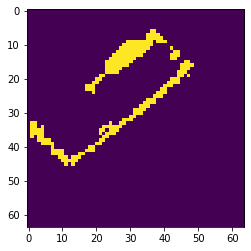

In [102]:
plt.imshow(gt_fp_projs[5][0].detach().cpu().numpy())

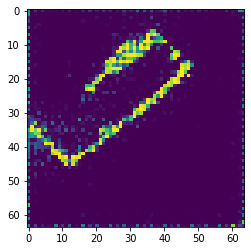

In [103]:
plt.imshow(b_proj_pred[5][0].detach().cpu().numpy())

TypeError: Invalid shape (3, 128, 128) for image data

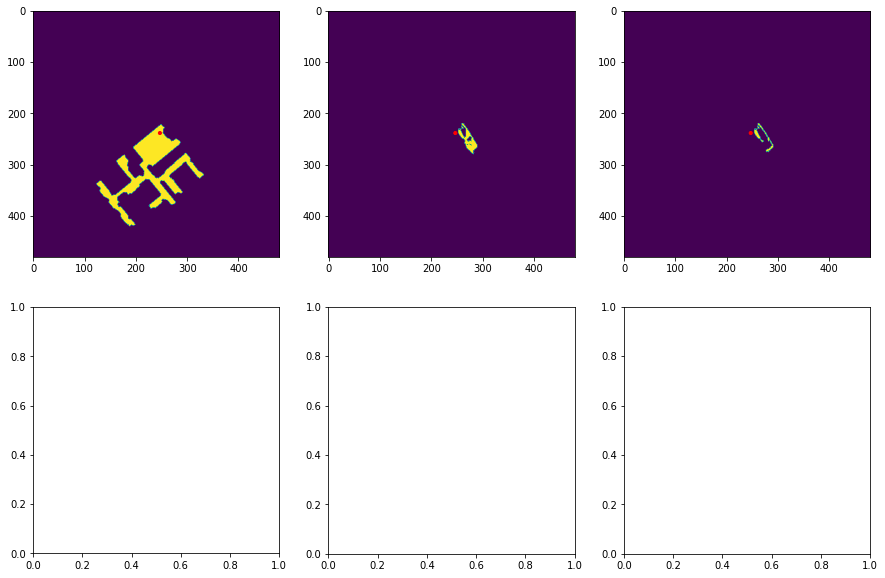

In [71]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
circ = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
circ2 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
circ3 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
circ4 = Circle((one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2),3,color='red')
ax.imshow(one_env.explorable_map)
ax.add_patch(circ)
ax2.imshow(one_env.explored_map)
ax2.add_patch(circ2)
ax3.imshow(one_env.map)
ax3.add_patch(circ3)
ax4.imshow(obs['rgb'])
top_down_map = draw_top_down_map(info, one_env.obs["heading"][0], obs['rgb'][0].shape[0])
ax5.imshow(top_down_map)
ax6.imshow(one_env.collison_map)
ax6.add_patch(circ4)
print(one_env.last_sim_location)
print([one_env.mapper_gt_pose[0]/10*2,one_env.mapper_gt_pose[1]/10*2,one_env.mapper_gt_pose[2]])